In [147]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [148]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, \
    Conv2DTranspose, BatchNormalization, UpSampling2D, LeakyReLU, Dropout, \
    Reshape, Input, Embedding, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from imutils import paths

In [150]:
# initialise the data paths

dbBase = r"/home/mhasan3/Desktop/WorkFolder/DataRepo/"
dbTrainPath = f"{dbBase}//train_gan_threshinv_5class_28px1px_pristine_cleancv2.hdf5"

# get the no. of classes
trainFile = h5py.File(name=dbTrainPath, mode="r")
class_num = len(list(np.unique(trainFile["labels"])))
print(f"Total no. of classes in dataset: {class_num}")

# get unique labels
labels = list(trainFile["label_names"])
labels = [label.decode() for label in labels]
print(f"Unique Labels: {labels}")

Total no. of classes in dataset: 5
Unique Labels: ['Bearings', 'Bolts', 'Brackets', 'Bushing', 'Collets']


In [151]:
# plot a list of loaded faces
def plot_images(faces, n):
    f, ax = plt.subplots(n, n, figsize=(16,16)) #type: Figure, axes
    faces_iter = iter(faces)
    for row in range(n):
        for col in range(n):
            axis = ax[row][col] #type: axes
            axis.set_yticklabels([])
            axis.set_xticklabels([])
            axis.grid(False)
            next_face = next(faces_iter)
            next_face = np.squeeze(next_face)
            axis.imshow(next_face, cmap='gray_r')
    plt.show()

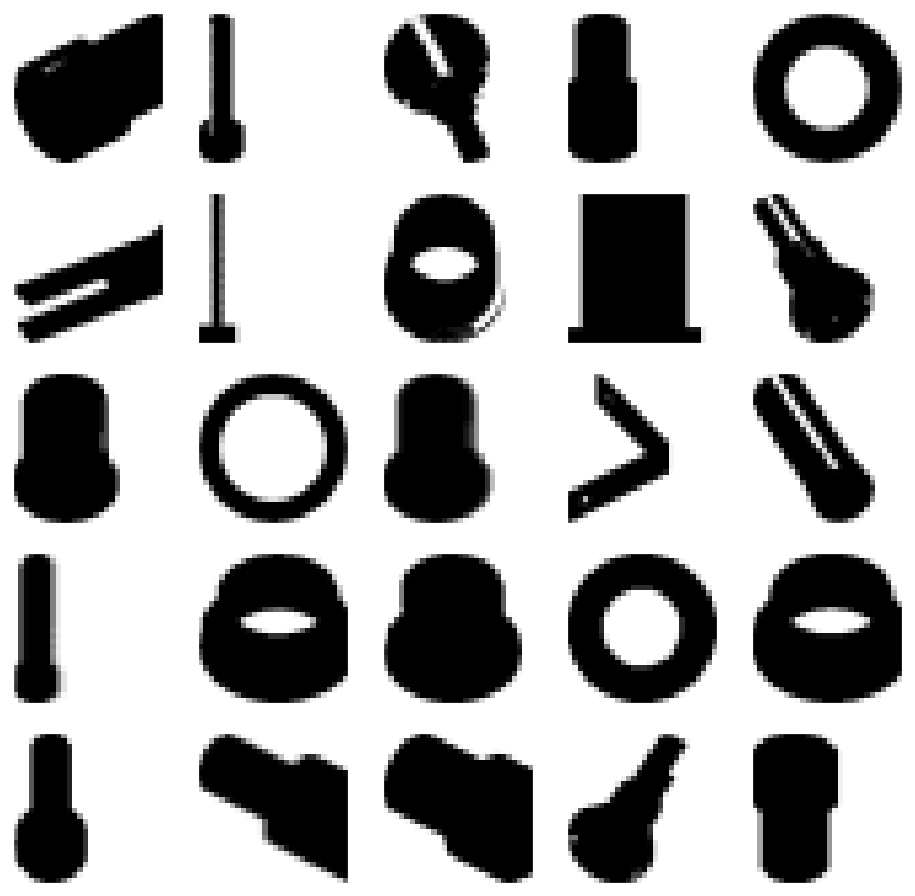

In [152]:
# load the data and plot
(trainx, trainy) = trainFile['images'], trainFile['labels']
plot_images(trainx, 5)

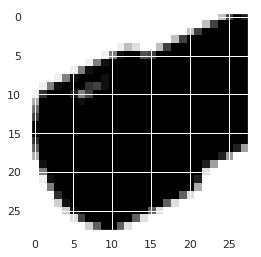

In [156]:
# look at a single image
index = 0
single_image = trainx[index]
single_image = np.squeeze(single_image)
plt.imshow(single_image, cmap='gray_r')

In [157]:
# sanity check of the single image label
single_label = trainy[index]
single_label

3

In [158]:
# define standalone discriminator
def define_discriminator(in_shape=(28,28,1), n_classes=5):

    #label input
    in_label = Input(shape=(1,))

    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)

    #scale upto image dimensions with linear activations
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)

    #reshape to additional channel -> 28x28x1
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    #image input
    in_image = Input(shape=in_shape)

    # concat the label and channel -> 28x28x2
    merge = Concatenate()([in_image, li])

    #downsample -> 14x14x128
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)

    # downsample -> 7x7x128
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    #flatten feature maps
    fe = Flatten()(fe)

    #Dropout
    fe = Dropout(0.4)(fe)

    #output
    out_layer = Dense(1, activation='sigmoid')(fe)

    # define the model
    model = Model([in_image, in_label], out_layer)

    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics = ['accuracy'])
    return model

In [159]:
# plot the model
test_d_model = define_discriminator()
#plot_model(test_d_model)

In [160]:
# double check dimensions
test_d_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 1, 50)        250         input_49[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 1, 784)       39984       embedding_24[0][0]               
__________________________________________________________________________________________________
input_50 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_36

In [161]:
# define the generator
def define_generator(latent_dim, n_classes=5):

    # label input
    in_label = Input(shape=(1,))

    # embedding for the categorical input
    li = Embedding(n_classes, 50)(in_label)

    # linear multiplication
    n_nodes = 7*7
    li = Dense(n_nodes)(li)

    # reshape to additional channel
    li = Reshape((7,7,1))(li)

    # image gemnerator input - latent vector
    in_lat = Input(shape=(latent_dim,))

    # foundation for 7x7 image
    n_nodes = 128*7*7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7,7,128))(gen)

    # merge the generated image and label input
    merge = Concatenate()([gen, li])

    # upsample to 14x14
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(4,4),
                          strides=(2,2),
                          padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 28x28
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(4,4),
                          strides=(2,2),
                          padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    #output
    out_layer = Conv2D(filters=1,
                       kernel_size=(7,7),
                       activation='tanh',
                       padding='same')(gen)

    #define the model
    model = Model([in_lat, in_label], out_layer)
    return model

In [162]:
# sanity check
test_g_model = define_generator(100, 5)
#plot_model(test_g_model)

In [163]:
# sanity check dimensions
test_g_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 6272)         633472      input_52[0][0]                   
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 1, 50)        250         input_51[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

In [164]:
# define the combine geenrator and discriminator model
def define_gan(g_model:Model, d_model:Model):

    # make weights of the discrim not trainable
    d_model.trainable = False

    # get noise and label inputs from generator
    gen_noise, gen_label = g_model.input

    # get image output from generator model
    gen_output = g_model.output

    # connect image output and label input from generator as inputs to discrim
    gan_output = d_model([gen_output, gen_label])

    # define gan model
    model = Model([gen_noise, gen_label], gan_output)

    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [165]:
# sanity check
test_gan_model = define_gan(test_g_model, test_d_model)
#plot_model(test_gan_model)

In [166]:
test_gan_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 6272)         633472      input_52[0][0]                   
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 1, 50)        250         input_51[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

In [167]:
# load real samples
def load_real_samples():
    # load the dataset
    trainx, trainy = trainFile['images'][:], trainFile['labels'][:]

    x = trainx.astype('float32')

    # scale to -1 +1_
    x = (x - 127.5) / 127.5

    return [x, trainy]

def generate_real_samples(dataset, n_samples):

    # split into images and labels
    images, labels = dataset

    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)
    ix = sorted(ix)

    # sleect the random images and labels
    x, labels = images[ix], labels[ix]

    # generate class labels
    y = np.ones((n_samples, 1))

    return [x, labels], y

In [168]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=5):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)

    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)

    # generate labels
    labels = np.random.randint(0, n_classes, n_samples) # these are fake labels
    return [z_input, labels]


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):

    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)

    #predict outputs
    images = generator.predict([z_input, labels_input])

    # create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

In [169]:
# train the generator and discriminator
d_real_losses = []
d_fake_losses = []

d_real_accus = []
d_fake_accus = []

gan_losses = []

def train(g_model:Model,
          d_model:Model,
          gan_model:Model,
          dataset:np.ndarray,
          latent_dim,
          n_epochs = 500,
          n_batch=128):

    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    for i in range(n_epochs):
        #enumerate batches over the training set
        for j in range(bat_per_epo):

            #get randomly selected real samples
            [xreal, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discrim model weights
            dloss1, dacc1 = d_model.train_on_batch([xreal, labels_real], y_real)
            d_real_losses.append(dloss1)
            d_real_accus.append(dacc1)
            

            # generate fake samples
            [xfake, labels], y_fake = generate_fake_samples(g_model,
                                                            latent_dim, half_batch)
            # update discrim model weights
            dloss2, dacc2 = d_model.train_on_batch([xfake, labels], y_fake)
            d_fake_losses.append(dloss2)
            d_fake_accus.append(dacc2)
            

            # prepare points in latent space as generator input
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            #create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))

            # update the generator
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            gan_losses.append(g_loss)

            #summarise loss on this batch
            print(f"{i+1},  {j+1}/{bat_per_epo},  d1={dloss1:0.3f}  "
                  f"d2={dloss2:0.3f} g={g_loss:0.3f}")

    g_model.save(f"{dbBase}//model_gan_5class_28px1px_threshinv.hdf5")

In [170]:
# size of the latent space
latent_dim = 100

# create the discrim
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# load the image data
dataset = load_real_samples()

# train the model
train(g_model=g_model,
      d_model=d_model,
      gan_model=gan_model,
      dataset=dataset,
      latent_dim=latent_dim,
     n_epochs=500)

1,  1/102,  d1=0.715  d2=0.694 g=0.692
1,  2/102,  d1=0.634  d2=0.698 g=0.689
1,  3/102,  d1=0.564  d2=0.703 g=0.684
1,  4/102,  d1=0.509  d2=0.710 g=0.679
1,  5/102,  d1=0.451  d2=0.719 g=0.673
1,  6/102,  d1=0.400  d2=0.725 g=0.672
1,  7/102,  d1=0.359  d2=0.725 g=0.677
1,  8/102,  d1=0.323  d2=0.716 g=0.695
1,  9/102,  d1=0.286  d2=0.706 g=0.707
1,  10/102,  d1=0.237  d2=0.695 g=0.722
1,  11/102,  d1=0.210  d2=0.697 g=0.731
1,  12/102,  d1=0.170  d2=0.693 g=0.737
1,  13/102,  d1=0.211  d2=0.709 g=0.718
1,  14/102,  d1=0.157  d2=0.730 g=0.703
1,  15/102,  d1=0.153  d2=0.746 g=0.684
1,  16/102,  d1=0.163  d2=0.772 g=0.665
1,  17/102,  d1=0.158  d2=0.803 g=0.653
1,  18/102,  d1=0.151  d2=0.835 g=0.661
1,  19/102,  d1=0.170  d2=0.821 g=0.692
1,  20/102,  d1=0.109  d2=0.759 g=0.768
1,  21/102,  d1=0.122  d2=0.686 g=0.855
1,  22/102,  d1=0.098  d2=0.689 g=0.853
1,  23/102,  d1=0.132  d2=0.774 g=0.786
1,  24/102,  d1=0.111  d2=0.908 g=0.706
1,  25/102,  d1=0.143  d2=0.943 g=0.741
1,  26/10

2,  97/102,  d1=0.152  d2=0.069 g=2.945
2,  98/102,  d1=0.293  d2=0.070 g=2.898
2,  99/102,  d1=0.261  d2=0.082 g=2.827
2,  100/102,  d1=0.241  d2=0.081 g=2.814
2,  101/102,  d1=0.351  d2=0.102 g=2.674
2,  102/102,  d1=0.141  d2=0.095 g=2.790
3,  1/102,  d1=0.135  d2=0.074 g=3.099
3,  2/102,  d1=0.135  d2=0.055 g=3.255
3,  3/102,  d1=0.116  d2=0.048 g=3.261
3,  4/102,  d1=0.199  d2=0.049 g=3.139
3,  5/102,  d1=0.120  d2=0.049 g=3.193
3,  6/102,  d1=0.047  d2=0.043 g=3.387
3,  7/102,  d1=0.024  d2=0.039 g=3.579
3,  8/102,  d1=0.191  d2=0.035 g=3.545
3,  9/102,  d1=0.078  d2=0.034 g=3.595
3,  10/102,  d1=0.066  d2=0.033 g=3.563
3,  11/102,  d1=0.070  d2=0.030 g=3.610
3,  12/102,  d1=0.140  d2=0.034 g=3.541
3,  13/102,  d1=0.243  d2=0.043 g=3.359
3,  14/102,  d1=0.138  d2=0.046 g=3.292
3,  15/102,  d1=0.182  d2=0.053 g=3.176
3,  16/102,  d1=0.127  d2=0.058 g=3.155
3,  17/102,  d1=0.228  d2=0.057 g=2.941
3,  18/102,  d1=0.054  d2=0.054 g=3.137
3,  19/102,  d1=0.088  d2=0.055 g=3.191
3,  20

4,  99/102,  d1=0.734  d2=0.756 g=0.913
4,  100/102,  d1=0.676  d2=0.700 g=0.944
4,  101/102,  d1=0.742  d2=0.640 g=0.940
4,  102/102,  d1=0.629  d2=0.761 g=0.948
5,  1/102,  d1=0.737  d2=0.652 g=0.947
5,  2/102,  d1=0.687  d2=0.646 g=0.930
5,  3/102,  d1=0.696  d2=0.665 g=0.951
5,  4/102,  d1=0.589  d2=0.622 g=0.863
5,  5/102,  d1=0.676  d2=0.713 g=0.918
5,  6/102,  d1=0.670  d2=0.665 g=0.871
5,  7/102,  d1=0.667  d2=0.663 g=0.857
5,  8/102,  d1=0.694  d2=0.639 g=0.874
5,  9/102,  d1=0.755  d2=0.705 g=0.868
5,  10/102,  d1=0.662  d2=0.719 g=0.784
5,  11/102,  d1=0.672  d2=0.674 g=0.833
5,  12/102,  d1=0.662  d2=0.712 g=0.909
5,  13/102,  d1=0.638  d2=0.731 g=0.803
5,  14/102,  d1=0.702  d2=0.656 g=0.882
5,  15/102,  d1=0.676  d2=0.702 g=0.766
5,  16/102,  d1=0.728  d2=0.671 g=0.839
5,  17/102,  d1=0.671  d2=0.735 g=0.829
5,  18/102,  d1=0.674  d2=0.741 g=0.859
5,  19/102,  d1=0.752  d2=0.675 g=0.838
5,  20/102,  d1=0.702  d2=0.703 g=0.818
5,  21/102,  d1=0.655  d2=0.689 g=0.841
5,  22

6,  101/102,  d1=0.647  d2=0.620 g=0.875
6,  102/102,  d1=0.627  d2=0.631 g=0.863
7,  1/102,  d1=0.607  d2=0.669 g=0.852
7,  2/102,  d1=0.640  d2=0.641 g=0.832
7,  3/102,  d1=0.665  d2=0.626 g=0.861
7,  4/102,  d1=0.706  d2=0.638 g=0.827
7,  5/102,  d1=0.658  d2=0.652 g=0.824
7,  6/102,  d1=0.703  d2=0.640 g=0.836
7,  7/102,  d1=0.680  d2=0.606 g=0.831
7,  8/102,  d1=0.606  d2=0.675 g=0.838
7,  9/102,  d1=0.640  d2=0.631 g=0.874
7,  10/102,  d1=0.605  d2=0.638 g=0.821
7,  11/102,  d1=0.645  d2=0.674 g=0.875
7,  12/102,  d1=0.686  d2=0.616 g=0.835
7,  13/102,  d1=0.687  d2=0.673 g=0.810
7,  14/102,  d1=0.633  d2=0.621 g=0.841
7,  15/102,  d1=0.630  d2=0.631 g=0.844
7,  16/102,  d1=0.668  d2=0.671 g=0.866
7,  17/102,  d1=0.673  d2=0.658 g=0.839
7,  18/102,  d1=0.636  d2=0.612 g=0.859
7,  19/102,  d1=0.646  d2=0.651 g=0.876
7,  20/102,  d1=0.717  d2=0.615 g=0.879
7,  21/102,  d1=0.610  d2=0.626 g=0.885
7,  22/102,  d1=0.662  d2=0.657 g=0.815
7,  23/102,  d1=0.620  d2=0.688 g=0.868
7,  24/

9,  1/102,  d1=0.605  d2=0.608 g=0.863
9,  2/102,  d1=0.632  d2=0.621 g=0.871
9,  3/102,  d1=0.643  d2=0.621 g=0.897
9,  4/102,  d1=0.703  d2=0.658 g=0.876
9,  5/102,  d1=0.636  d2=0.673 g=0.889
9,  6/102,  d1=0.667  d2=0.642 g=0.896
9,  7/102,  d1=0.622  d2=0.629 g=0.924
9,  8/102,  d1=0.642  d2=0.585 g=0.903
9,  9/102,  d1=0.691  d2=0.608 g=0.881
9,  10/102,  d1=0.690  d2=0.623 g=0.870
9,  11/102,  d1=0.573  d2=0.576 g=0.885
9,  12/102,  d1=0.689  d2=0.624 g=0.922
9,  13/102,  d1=0.649  d2=0.568 g=0.894
9,  14/102,  d1=0.636  d2=0.637 g=0.935
9,  15/102,  d1=0.642  d2=0.648 g=0.919
9,  16/102,  d1=0.637  d2=0.620 g=0.902
9,  17/102,  d1=0.604  d2=0.604 g=0.865
9,  18/102,  d1=0.682  d2=0.585 g=0.892
9,  19/102,  d1=0.638  d2=0.579 g=0.896
9,  20/102,  d1=0.603  d2=0.626 g=0.897
9,  21/102,  d1=0.645  d2=0.654 g=0.887
9,  22/102,  d1=0.596  d2=0.608 g=0.877
9,  23/102,  d1=0.637  d2=0.638 g=0.902
9,  24/102,  d1=0.603  d2=0.604 g=0.918
9,  25/102,  d1=0.621  d2=0.608 g=0.873
9,  26/10

11,  1/102,  d1=0.556  d2=0.575 g=1.092
11,  2/102,  d1=0.583  d2=0.590 g=1.042
11,  3/102,  d1=0.639  d2=0.542 g=1.033
11,  4/102,  d1=0.612  d2=0.534 g=1.044
11,  5/102,  d1=0.540  d2=0.573 g=1.085
11,  6/102,  d1=0.583  d2=0.519 g=1.052
11,  7/102,  d1=0.544  d2=0.540 g=1.040
11,  8/102,  d1=0.564  d2=0.588 g=1.047
11,  9/102,  d1=0.652  d2=0.572 g=1.016
11,  10/102,  d1=0.592  d2=0.494 g=1.007
11,  11/102,  d1=0.579  d2=0.477 g=1.049
11,  12/102,  d1=0.533  d2=0.520 g=1.057
11,  13/102,  d1=0.579  d2=0.575 g=1.049
11,  14/102,  d1=0.525  d2=0.536 g=1.051
11,  15/102,  d1=0.573  d2=0.517 g=1.092
11,  16/102,  d1=0.560  d2=0.629 g=1.114
11,  17/102,  d1=0.600  d2=0.548 g=1.023
11,  18/102,  d1=0.514  d2=0.519 g=1.105
11,  19/102,  d1=0.571  d2=0.535 g=1.093
11,  20/102,  d1=0.535  d2=0.496 g=1.111
11,  21/102,  d1=0.513  d2=0.478 g=1.099
11,  22/102,  d1=0.547  d2=0.509 g=1.120
11,  23/102,  d1=0.531  d2=0.424 g=1.049
11,  24/102,  d1=0.440  d2=0.491 g=1.083
11,  25/102,  d1=0.557  d

12,  101/102,  d1=0.764  d2=0.675 g=0.806
12,  102/102,  d1=0.655  d2=0.657 g=0.827
13,  1/102,  d1=0.702  d2=0.682 g=0.883
13,  2/102,  d1=0.689  d2=0.619 g=0.875
13,  3/102,  d1=0.712  d2=0.678 g=0.859
13,  4/102,  d1=0.691  d2=0.660 g=0.859
13,  5/102,  d1=0.688  d2=0.598 g=0.920
13,  6/102,  d1=0.747  d2=0.571 g=0.882
13,  7/102,  d1=0.664  d2=0.639 g=0.866
13,  8/102,  d1=0.674  d2=0.624 g=0.912
13,  9/102,  d1=0.668  d2=0.574 g=0.894
13,  10/102,  d1=0.638  d2=0.618 g=0.902
13,  11/102,  d1=0.623  d2=0.618 g=0.904
13,  12/102,  d1=0.746  d2=0.581 g=0.911
13,  13/102,  d1=0.647  d2=0.603 g=0.866
13,  14/102,  d1=0.657  d2=0.626 g=0.905
13,  15/102,  d1=0.633  d2=0.614 g=0.887
13,  16/102,  d1=0.629  d2=0.582 g=0.926
13,  17/102,  d1=0.626  d2=0.577 g=0.927
13,  18/102,  d1=0.685  d2=0.601 g=0.907
13,  19/102,  d1=0.661  d2=0.588 g=0.949
13,  20/102,  d1=0.704  d2=0.637 g=0.910
13,  21/102,  d1=0.660  d2=0.625 g=0.914
13,  22/102,  d1=0.671  d2=0.641 g=0.892
13,  23/102,  d1=0.635 

14,  99/102,  d1=0.675  d2=0.595 g=0.831
14,  100/102,  d1=0.644  d2=0.645 g=0.848
14,  101/102,  d1=0.618  d2=0.617 g=0.862
14,  102/102,  d1=0.612  d2=0.604 g=0.792
15,  1/102,  d1=0.603  d2=0.580 g=0.815
15,  2/102,  d1=0.595  d2=0.673 g=0.814
15,  3/102,  d1=0.620  d2=0.610 g=0.862
15,  4/102,  d1=0.607  d2=0.636 g=0.826
15,  5/102,  d1=0.639  d2=0.586 g=0.835
15,  6/102,  d1=0.598  d2=0.654 g=0.852
15,  7/102,  d1=0.628  d2=0.660 g=0.837
15,  8/102,  d1=0.672  d2=0.608 g=0.822
15,  9/102,  d1=0.616  d2=0.576 g=0.826
15,  10/102,  d1=0.607  d2=0.635 g=0.864
15,  11/102,  d1=0.664  d2=0.643 g=0.844
15,  12/102,  d1=0.629  d2=0.628 g=0.845
15,  13/102,  d1=0.672  d2=0.647 g=0.865
15,  14/102,  d1=0.649  d2=0.670 g=0.815
15,  15/102,  d1=0.592  d2=0.624 g=0.823
15,  16/102,  d1=0.607  d2=0.653 g=0.821
15,  17/102,  d1=0.628  d2=0.609 g=0.845
15,  18/102,  d1=0.653  d2=0.640 g=0.857
15,  19/102,  d1=0.654  d2=0.591 g=0.858
15,  20/102,  d1=0.617  d2=0.611 g=0.848
15,  21/102,  d1=0.603

16,  97/102,  d1=0.565  d2=0.648 g=0.879
16,  98/102,  d1=0.683  d2=0.667 g=0.860
16,  99/102,  d1=0.740  d2=0.691 g=0.861
16,  100/102,  d1=0.647  d2=0.653 g=0.881
16,  101/102,  d1=0.657  d2=0.645 g=0.877
16,  102/102,  d1=0.677  d2=0.638 g=0.877
17,  1/102,  d1=0.652  d2=0.639 g=0.856
17,  2/102,  d1=0.635  d2=0.641 g=0.882
17,  3/102,  d1=0.685  d2=0.613 g=0.838
17,  4/102,  d1=0.661  d2=0.616 g=0.839
17,  5/102,  d1=0.692  d2=0.653 g=0.839
17,  6/102,  d1=0.673  d2=0.621 g=0.834
17,  7/102,  d1=0.604  d2=0.659 g=0.840
17,  8/102,  d1=0.672  d2=0.671 g=0.810
17,  9/102,  d1=0.651  d2=0.643 g=0.799
17,  10/102,  d1=0.620  d2=0.638 g=0.835
17,  11/102,  d1=0.677  d2=0.672 g=0.811
17,  12/102,  d1=0.629  d2=0.657 g=0.838
17,  13/102,  d1=0.588  d2=0.592 g=0.898
17,  14/102,  d1=0.644  d2=0.675 g=0.862
17,  15/102,  d1=0.588  d2=0.597 g=0.853
17,  16/102,  d1=0.698  d2=0.611 g=0.869
17,  17/102,  d1=0.636  d2=0.612 g=0.874
17,  18/102,  d1=0.662  d2=0.658 g=0.847
17,  19/102,  d1=0.654

18,  95/102,  d1=0.625  d2=0.654 g=0.855
18,  96/102,  d1=0.642  d2=0.641 g=0.812
18,  97/102,  d1=0.609  d2=0.614 g=0.856
18,  98/102,  d1=0.613  d2=0.589 g=0.846
18,  99/102,  d1=0.609  d2=0.604 g=0.924
18,  100/102,  d1=0.634  d2=0.593 g=0.936
18,  101/102,  d1=0.606  d2=0.609 g=0.846
18,  102/102,  d1=0.572  d2=0.620 g=0.844
19,  1/102,  d1=0.619  d2=0.613 g=0.849
19,  2/102,  d1=0.636  d2=0.635 g=0.839
19,  3/102,  d1=0.664  d2=0.630 g=0.811
19,  4/102,  d1=0.652  d2=0.649 g=0.829
19,  5/102,  d1=0.608  d2=0.655 g=0.864
19,  6/102,  d1=0.605  d2=0.566 g=0.921
19,  7/102,  d1=0.618  d2=0.624 g=0.912
19,  8/102,  d1=0.575  d2=0.614 g=0.872
19,  9/102,  d1=0.629  d2=0.686 g=0.863
19,  10/102,  d1=0.586  d2=0.630 g=0.910
19,  11/102,  d1=0.629  d2=0.626 g=0.881
19,  12/102,  d1=0.659  d2=0.631 g=0.838
19,  13/102,  d1=0.633  d2=0.647 g=0.866
19,  14/102,  d1=0.666  d2=0.610 g=0.864
19,  15/102,  d1=0.614  d2=0.595 g=0.849
19,  16/102,  d1=0.628  d2=0.641 g=0.865
19,  17/102,  d1=0.687

20,  93/102,  d1=0.626  d2=0.635 g=0.827
20,  94/102,  d1=0.584  d2=0.649 g=0.828
20,  95/102,  d1=0.653  d2=0.604 g=0.854
20,  96/102,  d1=0.588  d2=0.638 g=0.815
20,  97/102,  d1=0.630  d2=0.648 g=0.820
20,  98/102,  d1=0.553  d2=0.575 g=0.854
20,  99/102,  d1=0.684  d2=0.604 g=0.852
20,  100/102,  d1=0.651  d2=0.597 g=0.817
20,  101/102,  d1=0.632  d2=0.663 g=0.810
20,  102/102,  d1=0.688  d2=0.701 g=0.809
21,  1/102,  d1=0.584  d2=0.638 g=0.850
21,  2/102,  d1=0.635  d2=0.632 g=0.858
21,  3/102,  d1=0.632  d2=0.675 g=0.938
21,  4/102,  d1=0.644  d2=0.631 g=0.835
21,  5/102,  d1=0.673  d2=0.688 g=0.837
21,  6/102,  d1=0.645  d2=0.613 g=0.853
21,  7/102,  d1=0.669  d2=0.630 g=0.853
21,  8/102,  d1=0.610  d2=0.620 g=0.882
21,  9/102,  d1=0.691  d2=0.637 g=0.857
21,  10/102,  d1=0.605  d2=0.649 g=0.828
21,  11/102,  d1=0.625  d2=0.686 g=0.819
21,  12/102,  d1=0.615  d2=0.660 g=0.820
21,  13/102,  d1=0.665  d2=0.663 g=0.802
21,  14/102,  d1=0.629  d2=0.674 g=0.828
21,  15/102,  d1=0.661

22,  91/102,  d1=0.584  d2=0.706 g=0.826
22,  92/102,  d1=0.613  d2=0.646 g=0.838
22,  93/102,  d1=0.644  d2=0.621 g=0.844
22,  94/102,  d1=0.655  d2=0.687 g=0.857
22,  95/102,  d1=0.580  d2=0.675 g=0.826
22,  96/102,  d1=0.673  d2=0.645 g=0.843
22,  97/102,  d1=0.651  d2=0.610 g=0.853
22,  98/102,  d1=0.609  d2=0.623 g=0.834
22,  99/102,  d1=0.625  d2=0.618 g=0.826
22,  100/102,  d1=0.628  d2=0.613 g=0.819
22,  101/102,  d1=0.628  d2=0.643 g=0.819
22,  102/102,  d1=0.692  d2=0.644 g=0.831
23,  1/102,  d1=0.609  d2=0.660 g=0.817
23,  2/102,  d1=0.616  d2=0.627 g=0.878
23,  3/102,  d1=0.674  d2=0.611 g=0.871
23,  4/102,  d1=0.694  d2=0.596 g=0.843
23,  5/102,  d1=0.617  d2=0.633 g=0.860
23,  6/102,  d1=0.624  d2=0.662 g=0.802
23,  7/102,  d1=0.635  d2=0.702 g=0.814
23,  8/102,  d1=0.630  d2=0.651 g=0.801
23,  9/102,  d1=0.612  d2=0.683 g=0.818
23,  10/102,  d1=0.631  d2=0.636 g=0.881
23,  11/102,  d1=0.619  d2=0.615 g=0.856
23,  12/102,  d1=0.622  d2=0.620 g=0.857
23,  13/102,  d1=0.629

24,  89/102,  d1=0.578  d2=0.655 g=0.913
24,  90/102,  d1=0.676  d2=0.611 g=0.927
24,  91/102,  d1=0.629  d2=0.577 g=0.981
24,  92/102,  d1=0.659  d2=0.600 g=0.887
24,  93/102,  d1=0.642  d2=0.623 g=0.865
24,  94/102,  d1=0.634  d2=0.613 g=0.847
24,  95/102,  d1=0.579  d2=0.671 g=0.820
24,  96/102,  d1=0.611  d2=0.626 g=0.887
24,  97/102,  d1=0.621  d2=0.648 g=0.830
24,  98/102,  d1=0.687  d2=0.554 g=0.890
24,  99/102,  d1=0.581  d2=0.570 g=0.922
24,  100/102,  d1=0.661  d2=0.591 g=0.954
24,  101/102,  d1=0.659  d2=0.563 g=0.921
24,  102/102,  d1=0.630  d2=0.578 g=0.920
25,  1/102,  d1=0.645  d2=0.584 g=0.831
25,  2/102,  d1=0.581  d2=0.655 g=0.826
25,  3/102,  d1=0.643  d2=0.638 g=0.795
25,  4/102,  d1=0.623  d2=0.698 g=0.795
25,  5/102,  d1=0.569  d2=0.650 g=0.840
25,  6/102,  d1=0.615  d2=0.648 g=0.913
25,  7/102,  d1=0.632  d2=0.606 g=0.920
25,  8/102,  d1=0.646  d2=0.532 g=0.970
25,  9/102,  d1=0.642  d2=0.634 g=0.969
25,  10/102,  d1=0.665  d2=0.638 g=0.931
25,  11/102,  d1=0.553

26,  87/102,  d1=0.629  d2=0.602 g=0.993
26,  88/102,  d1=0.631  d2=0.547 g=0.949
26,  89/102,  d1=0.606  d2=0.598 g=0.968
26,  90/102,  d1=0.549  d2=0.678 g=0.928
26,  91/102,  d1=0.563  d2=0.654 g=0.832
26,  92/102,  d1=0.650  d2=0.673 g=0.858
26,  93/102,  d1=0.667  d2=0.608 g=0.816
26,  94/102,  d1=0.568  d2=0.636 g=0.843
26,  95/102,  d1=0.595  d2=0.644 g=0.907
26,  96/102,  d1=0.597  d2=0.593 g=0.921
26,  97/102,  d1=0.597  d2=0.601 g=0.916
26,  98/102,  d1=0.573  d2=0.562 g=0.909
26,  99/102,  d1=0.664  d2=0.599 g=0.937
26,  100/102,  d1=0.607  d2=0.604 g=0.938
26,  101/102,  d1=0.617  d2=0.590 g=0.854
26,  102/102,  d1=0.603  d2=0.626 g=0.847
27,  1/102,  d1=0.609  d2=0.659 g=0.815
27,  2/102,  d1=0.609  d2=0.643 g=0.849
27,  3/102,  d1=0.606  d2=0.651 g=0.869
27,  4/102,  d1=0.547  d2=0.611 g=0.887
27,  5/102,  d1=0.645  d2=0.653 g=0.949
27,  6/102,  d1=0.679  d2=0.625 g=0.892
27,  7/102,  d1=0.640  d2=0.630 g=0.909
27,  8/102,  d1=0.617  d2=0.615 g=0.913
27,  9/102,  d1=0.615

28,  85/102,  d1=0.632  d2=0.621 g=0.853
28,  86/102,  d1=0.625  d2=0.624 g=0.905
28,  87/102,  d1=0.625  d2=0.605 g=0.907
28,  88/102,  d1=0.602  d2=0.624 g=0.887
28,  89/102,  d1=0.628  d2=0.641 g=0.848
28,  90/102,  d1=0.636  d2=0.639 g=0.862
28,  91/102,  d1=0.594  d2=0.659 g=0.853
28,  92/102,  d1=0.626  d2=0.639 g=0.860
28,  93/102,  d1=0.671  d2=0.656 g=0.909
28,  94/102,  d1=0.617  d2=0.590 g=0.894
28,  95/102,  d1=0.586  d2=0.633 g=0.855
28,  96/102,  d1=0.638  d2=0.612 g=0.866
28,  97/102,  d1=0.590  d2=0.630 g=0.861
28,  98/102,  d1=0.632  d2=0.597 g=0.857
28,  99/102,  d1=0.596  d2=0.586 g=0.887
28,  100/102,  d1=0.664  d2=0.624 g=0.871
28,  101/102,  d1=0.601  d2=0.634 g=0.876
28,  102/102,  d1=0.591  d2=0.615 g=0.868
29,  1/102,  d1=0.564  d2=0.644 g=0.884
29,  2/102,  d1=0.601  d2=0.571 g=0.895
29,  3/102,  d1=0.663  d2=0.565 g=0.867
29,  4/102,  d1=0.657  d2=0.621 g=0.890
29,  5/102,  d1=0.590  d2=0.592 g=0.827
29,  6/102,  d1=0.641  d2=0.629 g=0.898
29,  7/102,  d1=0.6

30,  83/102,  d1=0.576  d2=0.618 g=0.927
30,  84/102,  d1=0.584  d2=0.627 g=0.907
30,  85/102,  d1=0.636  d2=0.560 g=0.882
30,  86/102,  d1=0.597  d2=0.583 g=0.925
30,  87/102,  d1=0.585  d2=0.581 g=0.865
30,  88/102,  d1=0.592  d2=0.612 g=0.916
30,  89/102,  d1=0.552  d2=0.597 g=0.908
30,  90/102,  d1=0.595  d2=0.577 g=0.893
30,  91/102,  d1=0.528  d2=0.546 g=0.922
30,  92/102,  d1=0.545  d2=0.549 g=0.887
30,  93/102,  d1=0.646  d2=0.651 g=0.817
30,  94/102,  d1=0.593  d2=0.551 g=0.936
30,  95/102,  d1=0.602  d2=0.608 g=0.903
30,  96/102,  d1=0.564  d2=0.567 g=0.892
30,  97/102,  d1=0.600  d2=0.584 g=0.891
30,  98/102,  d1=0.587  d2=0.582 g=0.885
30,  99/102,  d1=0.588  d2=0.613 g=0.938
30,  100/102,  d1=0.613  d2=0.603 g=0.955
30,  101/102,  d1=0.630  d2=0.594 g=0.892
30,  102/102,  d1=0.588  d2=0.664 g=0.928
31,  1/102,  d1=0.630  d2=0.627 g=0.910
31,  2/102,  d1=0.629  d2=0.544 g=0.894
31,  3/102,  d1=0.550  d2=0.612 g=0.908
31,  4/102,  d1=0.606  d2=0.537 g=0.933
31,  5/102,  d1=0

32,  81/102,  d1=0.615  d2=0.615 g=0.892
32,  82/102,  d1=0.603  d2=0.580 g=0.931
32,  83/102,  d1=0.517  d2=0.611 g=0.939
32,  84/102,  d1=0.614  d2=0.553 g=0.899
32,  85/102,  d1=0.639  d2=0.565 g=0.918
32,  86/102,  d1=0.603  d2=0.571 g=0.893
32,  87/102,  d1=0.674  d2=0.590 g=0.892
32,  88/102,  d1=0.512  d2=0.603 g=0.832
32,  89/102,  d1=0.555  d2=0.624 g=0.887
32,  90/102,  d1=0.601  d2=0.629 g=0.964
32,  91/102,  d1=0.583  d2=0.628 g=0.910
32,  92/102,  d1=0.580  d2=0.563 g=0.966
32,  93/102,  d1=0.579  d2=0.594 g=0.982
32,  94/102,  d1=0.620  d2=0.596 g=0.873
32,  95/102,  d1=0.575  d2=0.609 g=0.979
32,  96/102,  d1=0.564  d2=0.563 g=0.913
32,  97/102,  d1=0.521  d2=0.617 g=0.958
32,  98/102,  d1=0.520  d2=0.566 g=0.966
32,  99/102,  d1=0.657  d2=0.552 g=0.969
32,  100/102,  d1=0.618  d2=0.593 g=0.937
32,  101/102,  d1=0.576  d2=0.619 g=0.983
32,  102/102,  d1=0.612  d2=0.634 g=1.023
33,  1/102,  d1=0.634  d2=0.559 g=0.960
33,  2/102,  d1=0.595  d2=0.592 g=0.925
33,  3/102,  d1

34,  79/102,  d1=0.630  d2=0.551 g=0.877
34,  80/102,  d1=0.568  d2=0.644 g=0.966
34,  81/102,  d1=0.596  d2=0.670 g=0.971
34,  82/102,  d1=0.611  d2=0.592 g=0.889
34,  83/102,  d1=0.535  d2=0.664 g=0.940
34,  84/102,  d1=0.604  d2=0.563 g=0.984
34,  85/102,  d1=0.536  d2=0.535 g=0.936
34,  86/102,  d1=0.590  d2=0.539 g=0.945
34,  87/102,  d1=0.570  d2=0.550 g=0.949
34,  88/102,  d1=0.622  d2=0.561 g=0.886
34,  89/102,  d1=0.682  d2=0.600 g=0.942
34,  90/102,  d1=0.565  d2=0.592 g=0.922
34,  91/102,  d1=0.573  d2=0.584 g=0.912
34,  92/102,  d1=0.562  d2=0.593 g=0.922
34,  93/102,  d1=0.615  d2=0.570 g=0.938
34,  94/102,  d1=0.573  d2=0.576 g=0.929
34,  95/102,  d1=0.546  d2=0.560 g=0.947
34,  96/102,  d1=0.544  d2=0.557 g=0.948
34,  97/102,  d1=0.577  d2=0.633 g=0.955
34,  98/102,  d1=0.534  d2=0.594 g=0.915
34,  99/102,  d1=0.575  d2=0.571 g=0.957
34,  100/102,  d1=0.610  d2=0.575 g=0.967
34,  101/102,  d1=0.537  d2=0.592 g=0.966
34,  102/102,  d1=0.638  d2=0.550 g=0.963
35,  1/102,  

36,  77/102,  d1=0.547  d2=0.574 g=1.025
36,  78/102,  d1=0.495  d2=0.586 g=1.009
36,  79/102,  d1=0.550  d2=0.563 g=0.979
36,  80/102,  d1=0.628  d2=0.569 g=0.968
36,  81/102,  d1=0.589  d2=0.569 g=0.945
36,  82/102,  d1=0.567  d2=0.545 g=0.984
36,  83/102,  d1=0.699  d2=0.569 g=0.960
36,  84/102,  d1=0.655  d2=0.599 g=0.963
36,  85/102,  d1=0.555  d2=0.597 g=0.937
36,  86/102,  d1=0.624  d2=0.563 g=0.934
36,  87/102,  d1=0.512  d2=0.605 g=0.932
36,  88/102,  d1=0.519  d2=0.597 g=0.951
36,  89/102,  d1=0.573  d2=0.555 g=0.957
36,  90/102,  d1=0.576  d2=0.558 g=0.953
36,  91/102,  d1=0.564  d2=0.548 g=0.928
36,  92/102,  d1=0.551  d2=0.643 g=0.998
36,  93/102,  d1=0.622  d2=0.582 g=0.980
36,  94/102,  d1=0.570  d2=0.557 g=0.945
36,  95/102,  d1=0.558  d2=0.577 g=0.958
36,  96/102,  d1=0.549  d2=0.553 g=0.953
36,  97/102,  d1=0.575  d2=0.533 g=0.991
36,  98/102,  d1=0.594  d2=0.558 g=0.987
36,  99/102,  d1=0.567  d2=0.556 g=0.970
36,  100/102,  d1=0.531  d2=0.599 g=0.974
36,  101/102,  

38,  75/102,  d1=0.588  d2=0.549 g=1.030
38,  76/102,  d1=0.472  d2=0.614 g=1.070
38,  77/102,  d1=0.573  d2=0.607 g=1.011
38,  78/102,  d1=0.558  d2=0.633 g=1.011
38,  79/102,  d1=0.637  d2=0.616 g=0.993
38,  80/102,  d1=0.669  d2=0.560 g=1.048
38,  81/102,  d1=0.530  d2=0.558 g=1.013
38,  82/102,  d1=0.676  d2=0.534 g=0.987
38,  83/102,  d1=0.599  d2=0.580 g=1.014
38,  84/102,  d1=0.503  d2=0.575 g=1.045
38,  85/102,  d1=0.631  d2=0.560 g=1.017
38,  86/102,  d1=0.605  d2=0.595 g=1.002
38,  87/102,  d1=0.606  d2=0.555 g=1.007
38,  88/102,  d1=0.630  d2=0.595 g=0.957
38,  89/102,  d1=0.564  d2=0.600 g=0.952
38,  90/102,  d1=0.577  d2=0.629 g=0.954
38,  91/102,  d1=0.544  d2=0.565 g=0.977
38,  92/102,  d1=0.506  d2=0.551 g=1.047
38,  93/102,  d1=0.605  d2=0.563 g=0.994
38,  94/102,  d1=0.548  d2=0.598 g=1.057
38,  95/102,  d1=0.675  d2=0.583 g=0.941
38,  96/102,  d1=0.573  d2=0.609 g=1.011
38,  97/102,  d1=0.603  d2=0.560 g=1.005
38,  98/102,  d1=0.587  d2=0.512 g=0.962
38,  99/102,  d1

40,  73/102,  d1=0.551  d2=0.652 g=1.022
40,  74/102,  d1=0.657  d2=0.605 g=1.028
40,  75/102,  d1=0.599  d2=0.576 g=1.031
40,  76/102,  d1=0.520  d2=0.608 g=1.019
40,  77/102,  d1=0.571  d2=0.524 g=1.016
40,  78/102,  d1=0.558  d2=0.640 g=1.038
40,  79/102,  d1=0.622  d2=0.535 g=0.998
40,  80/102,  d1=0.570  d2=0.567 g=1.010
40,  81/102,  d1=0.575  d2=0.534 g=0.996
40,  82/102,  d1=0.555  d2=0.576 g=0.996
40,  83/102,  d1=0.616  d2=0.650 g=1.011
40,  84/102,  d1=0.625  d2=0.564 g=0.993
40,  85/102,  d1=0.585  d2=0.602 g=1.020
40,  86/102,  d1=0.584  d2=0.561 g=0.938
40,  87/102,  d1=0.614  d2=0.575 g=1.011
40,  88/102,  d1=0.572  d2=0.657 g=1.020
40,  89/102,  d1=0.528  d2=0.554 g=0.982
40,  90/102,  d1=0.597  d2=0.489 g=1.021
40,  91/102,  d1=0.570  d2=0.466 g=1.012
40,  92/102,  d1=0.661  d2=0.627 g=1.035
40,  93/102,  d1=0.625  d2=0.544 g=0.982
40,  94/102,  d1=0.580  d2=0.592 g=0.989
40,  95/102,  d1=0.556  d2=0.555 g=0.959
40,  96/102,  d1=0.554  d2=0.603 g=0.954
40,  97/102,  d1

42,  71/102,  d1=0.580  d2=0.605 g=1.069
42,  72/102,  d1=0.561  d2=0.553 g=1.084
42,  73/102,  d1=0.519  d2=0.565 g=0.987
42,  74/102,  d1=0.572  d2=0.607 g=1.059
42,  75/102,  d1=0.625  d2=0.601 g=1.062
42,  76/102,  d1=0.502  d2=0.564 g=1.079
42,  77/102,  d1=0.560  d2=0.558 g=0.987
42,  78/102,  d1=0.616  d2=0.557 g=0.969
42,  79/102,  d1=0.536  d2=0.516 g=0.966
42,  80/102,  d1=0.623  d2=0.657 g=1.017
42,  81/102,  d1=0.568  d2=0.543 g=1.108
42,  82/102,  d1=0.583  d2=0.628 g=0.982
42,  83/102,  d1=0.640  d2=0.554 g=1.029
42,  84/102,  d1=0.578  d2=0.580 g=1.059
42,  85/102,  d1=0.563  d2=0.556 g=1.068
42,  86/102,  d1=0.531  d2=0.559 g=1.050
42,  87/102,  d1=0.666  d2=0.551 g=0.974
42,  88/102,  d1=0.540  d2=0.598 g=1.042
42,  89/102,  d1=0.585  d2=0.555 g=1.012
42,  90/102,  d1=0.534  d2=0.552 g=1.013
42,  91/102,  d1=0.541  d2=0.568 g=1.032
42,  92/102,  d1=0.575  d2=0.538 g=1.011
42,  93/102,  d1=0.658  d2=0.599 g=1.022
42,  94/102,  d1=0.579  d2=0.622 g=0.999
42,  95/102,  d1

44,  69/102,  d1=0.585  d2=0.670 g=1.000
44,  70/102,  d1=0.527  d2=0.633 g=1.008
44,  71/102,  d1=0.629  d2=0.589 g=0.991
44,  72/102,  d1=0.572  d2=0.571 g=1.007
44,  73/102,  d1=0.548  d2=0.553 g=0.987
44,  74/102,  d1=0.606  d2=0.566 g=1.046
44,  75/102,  d1=0.549  d2=0.562 g=0.979
44,  76/102,  d1=0.558  d2=0.544 g=1.032
44,  77/102,  d1=0.553  d2=0.599 g=0.990
44,  78/102,  d1=0.566  d2=0.612 g=1.023
44,  79/102,  d1=0.649  d2=0.536 g=1.048
44,  80/102,  d1=0.544  d2=0.615 g=1.040
44,  81/102,  d1=0.570  d2=0.559 g=1.053
44,  82/102,  d1=0.589  d2=0.530 g=1.051
44,  83/102,  d1=0.627  d2=0.584 g=1.037
44,  84/102,  d1=0.505  d2=0.608 g=1.120
44,  85/102,  d1=0.563  d2=0.551 g=1.058
44,  86/102,  d1=0.640  d2=0.561 g=1.022
44,  87/102,  d1=0.583  d2=0.581 g=0.963
44,  88/102,  d1=0.551  d2=0.581 g=0.951
44,  89/102,  d1=0.587  d2=0.653 g=1.048
44,  90/102,  d1=0.613  d2=0.562 g=0.981
44,  91/102,  d1=0.608  d2=0.541 g=0.979
44,  92/102,  d1=0.593  d2=0.561 g=1.014
44,  93/102,  d1

46,  67/102,  d1=0.627  d2=0.553 g=0.999
46,  68/102,  d1=0.628  d2=0.573 g=1.017
46,  69/102,  d1=0.568  d2=0.616 g=0.955
46,  70/102,  d1=0.555  d2=0.572 g=0.988
46,  71/102,  d1=0.621  d2=0.610 g=1.018
46,  72/102,  d1=0.562  d2=0.557 g=0.980
46,  73/102,  d1=0.497  d2=0.614 g=1.015
46,  74/102,  d1=0.596  d2=0.565 g=0.963
46,  75/102,  d1=0.577  d2=0.574 g=1.020
46,  76/102,  d1=0.546  d2=0.532 g=0.983
46,  77/102,  d1=0.570  d2=0.579 g=0.966
46,  78/102,  d1=0.633  d2=0.587 g=0.931
46,  79/102,  d1=0.582  d2=0.594 g=1.016
46,  80/102,  d1=0.612  d2=0.626 g=1.036
46,  81/102,  d1=0.568  d2=0.587 g=0.957
46,  82/102,  d1=0.567  d2=0.582 g=1.008
46,  83/102,  d1=0.570  d2=0.569 g=0.955
46,  84/102,  d1=0.577  d2=0.574 g=1.022
46,  85/102,  d1=0.526  d2=0.591 g=1.047
46,  86/102,  d1=0.565  d2=0.570 g=1.001
46,  87/102,  d1=0.558  d2=0.579 g=1.028
46,  88/102,  d1=0.612  d2=0.565 g=1.002
46,  89/102,  d1=0.593  d2=0.566 g=0.984
46,  90/102,  d1=0.630  d2=0.665 g=1.019
46,  91/102,  d1

48,  65/102,  d1=0.538  d2=0.572 g=1.101
48,  66/102,  d1=0.541  d2=0.549 g=1.102
48,  67/102,  d1=0.587  d2=0.520 g=1.076
48,  68/102,  d1=0.545  d2=0.626 g=1.148
48,  69/102,  d1=0.610  d2=0.531 g=1.004
48,  70/102,  d1=0.558  d2=0.506 g=1.029
48,  71/102,  d1=0.551  d2=0.551 g=1.017
48,  72/102,  d1=0.627  d2=0.541 g=1.048
48,  73/102,  d1=0.601  d2=0.636 g=0.986
48,  74/102,  d1=0.565  d2=0.592 g=1.071
48,  75/102,  d1=0.649  d2=0.548 g=0.977
48,  76/102,  d1=0.591  d2=0.538 g=0.991
48,  77/102,  d1=0.518  d2=0.553 g=1.031
48,  78/102,  d1=0.581  d2=0.577 g=1.001
48,  79/102,  d1=0.601  d2=0.581 g=1.085
48,  80/102,  d1=0.619  d2=0.538 g=1.049
48,  81/102,  d1=0.573  d2=0.657 g=1.018
48,  82/102,  d1=0.555  d2=0.542 g=1.016
48,  83/102,  d1=0.474  d2=0.567 g=1.094
48,  84/102,  d1=0.590  d2=0.574 g=1.018
48,  85/102,  d1=0.610  d2=0.581 g=0.978
48,  86/102,  d1=0.590  d2=0.571 g=0.992
48,  87/102,  d1=0.533  d2=0.594 g=1.020
48,  88/102,  d1=0.614  d2=0.556 g=1.022
48,  89/102,  d1

50,  63/102,  d1=0.592  d2=0.613 g=1.012
50,  64/102,  d1=0.520  d2=0.541 g=1.029
50,  65/102,  d1=0.587  d2=0.521 g=1.051
50,  66/102,  d1=0.549  d2=0.560 g=1.045
50,  67/102,  d1=0.560  d2=0.573 g=1.096
50,  68/102,  d1=0.544  d2=0.552 g=0.993
50,  69/102,  d1=0.583  d2=0.523 g=1.019
50,  70/102,  d1=0.546  d2=0.531 g=1.022
50,  71/102,  d1=0.592  d2=0.540 g=1.078
50,  72/102,  d1=0.538  d2=0.674 g=1.038
50,  73/102,  d1=0.601  d2=0.546 g=0.956
50,  74/102,  d1=0.611  d2=0.560 g=1.063
50,  75/102,  d1=0.535  d2=0.504 g=1.098
50,  76/102,  d1=0.511  d2=0.569 g=1.093
50,  77/102,  d1=0.537  d2=0.559 g=1.085
50,  78/102,  d1=0.573  d2=0.532 g=0.989
50,  79/102,  d1=0.534  d2=0.616 g=1.035
50,  80/102,  d1=0.532  d2=0.547 g=1.050
50,  81/102,  d1=0.654  d2=0.534 g=1.072
50,  82/102,  d1=0.534  d2=0.598 g=1.092
50,  83/102,  d1=0.540  d2=0.568 g=1.047
50,  84/102,  d1=0.593  d2=0.578 g=0.917
50,  85/102,  d1=0.671  d2=0.572 g=0.980
50,  86/102,  d1=0.609  d2=0.581 g=0.953
50,  87/102,  d1

52,  61/102,  d1=0.575  d2=0.612 g=1.066
52,  62/102,  d1=0.567  d2=0.562 g=1.099
52,  63/102,  d1=0.603  d2=0.561 g=1.059
52,  64/102,  d1=0.506  d2=0.585 g=1.022
52,  65/102,  d1=0.580  d2=0.604 g=1.013
52,  66/102,  d1=0.558  d2=0.500 g=1.044
52,  67/102,  d1=0.581  d2=0.545 g=1.046
52,  68/102,  d1=0.576  d2=0.507 g=1.084
52,  69/102,  d1=0.551  d2=0.516 g=1.089
52,  70/102,  d1=0.581  d2=0.603 g=1.048
52,  71/102,  d1=0.526  d2=0.495 g=1.056
52,  72/102,  d1=0.610  d2=0.617 g=1.057
52,  73/102,  d1=0.561  d2=0.642 g=1.086
52,  74/102,  d1=0.577  d2=0.589 g=1.058
52,  75/102,  d1=0.567  d2=0.598 g=1.045
52,  76/102,  d1=0.568  d2=0.554 g=1.143
52,  77/102,  d1=0.629  d2=0.528 g=1.035
52,  78/102,  d1=0.586  d2=0.590 g=1.127
52,  79/102,  d1=0.677  d2=0.538 g=0.997
52,  80/102,  d1=0.658  d2=0.594 g=1.026
52,  81/102,  d1=0.540  d2=0.533 g=1.022
52,  82/102,  d1=0.573  d2=0.643 g=1.029
52,  83/102,  d1=0.609  d2=0.559 g=1.086
52,  84/102,  d1=0.591  d2=0.515 g=1.023
52,  85/102,  d1

54,  59/102,  d1=0.572  d2=0.497 g=1.118
54,  60/102,  d1=0.559  d2=0.528 g=1.108
54,  61/102,  d1=0.541  d2=0.514 g=1.046
54,  62/102,  d1=0.591  d2=0.586 g=1.066
54,  63/102,  d1=0.593  d2=0.621 g=0.968
54,  64/102,  d1=0.578  d2=0.601 g=1.059
54,  65/102,  d1=0.593  d2=0.538 g=1.024
54,  66/102,  d1=0.564  d2=0.641 g=1.007
54,  67/102,  d1=0.521  d2=0.621 g=1.053
54,  68/102,  d1=0.667  d2=0.526 g=1.083
54,  69/102,  d1=0.590  d2=0.578 g=1.042
54,  70/102,  d1=0.528  d2=0.546 g=1.061
54,  71/102,  d1=0.575  d2=0.554 g=1.027
54,  72/102,  d1=0.585  d2=0.565 g=1.026
54,  73/102,  d1=0.553  d2=0.470 g=0.976
54,  74/102,  d1=0.538  d2=0.583 g=1.032
54,  75/102,  d1=0.539  d2=0.587 g=1.014
54,  76/102,  d1=0.619  d2=0.656 g=1.046
54,  77/102,  d1=0.523  d2=0.539 g=0.981
54,  78/102,  d1=0.546  d2=0.564 g=0.990
54,  79/102,  d1=0.595  d2=0.617 g=1.084
54,  80/102,  d1=0.526  d2=0.540 g=1.039
54,  81/102,  d1=0.614  d2=0.567 g=1.115
54,  82/102,  d1=0.538  d2=0.558 g=1.092
54,  83/102,  d1

56,  57/102,  d1=0.518  d2=0.486 g=1.070
56,  58/102,  d1=0.634  d2=0.527 g=1.079
56,  59/102,  d1=0.599  d2=0.533 g=1.126
56,  60/102,  d1=0.622  d2=0.642 g=1.076
56,  61/102,  d1=0.574  d2=0.567 g=1.023
56,  62/102,  d1=0.574  d2=0.639 g=1.035
56,  63/102,  d1=0.520  d2=0.502 g=1.060
56,  64/102,  d1=0.630  d2=0.522 g=0.999
56,  65/102,  d1=0.560  d2=0.589 g=1.007
56,  66/102,  d1=0.534  d2=0.554 g=0.994
56,  67/102,  d1=0.558  d2=0.550 g=1.055
56,  68/102,  d1=0.613  d2=0.537 g=1.069
56,  69/102,  d1=0.587  d2=0.588 g=1.042
56,  70/102,  d1=0.514  d2=0.559 g=1.031
56,  71/102,  d1=0.707  d2=0.581 g=1.017
56,  72/102,  d1=0.558  d2=0.581 g=1.076
56,  73/102,  d1=0.585  d2=0.573 g=0.997
56,  74/102,  d1=0.610  d2=0.576 g=1.028
56,  75/102,  d1=0.578  d2=0.498 g=1.029
56,  76/102,  d1=0.531  d2=0.632 g=0.974
56,  77/102,  d1=0.547  d2=0.574 g=1.025
56,  78/102,  d1=0.473  d2=0.624 g=0.976
56,  79/102,  d1=0.517  d2=0.558 g=1.065
56,  80/102,  d1=0.613  d2=0.532 g=1.108
56,  81/102,  d1

58,  55/102,  d1=0.689  d2=0.624 g=1.053
58,  56/102,  d1=0.707  d2=0.619 g=1.025
58,  57/102,  d1=0.558  d2=0.623 g=1.083
58,  58/102,  d1=0.606  d2=0.598 g=1.085
58,  59/102,  d1=0.510  d2=0.597 g=1.048
58,  60/102,  d1=0.564  d2=0.580 g=1.080
58,  61/102,  d1=0.540  d2=0.533 g=1.055
58,  62/102,  d1=0.543  d2=0.555 g=1.084
58,  63/102,  d1=0.649  d2=0.554 g=1.110
58,  64/102,  d1=0.580  d2=0.523 g=1.074
58,  65/102,  d1=0.592  d2=0.557 g=1.069
58,  66/102,  d1=0.559  d2=0.527 g=1.032
58,  67/102,  d1=0.645  d2=0.638 g=1.047
58,  68/102,  d1=0.575  d2=0.560 g=1.110
58,  69/102,  d1=0.530  d2=0.562 g=1.158
58,  70/102,  d1=0.599  d2=0.544 g=1.022
58,  71/102,  d1=0.556  d2=0.596 g=1.109
58,  72/102,  d1=0.599  d2=0.583 g=1.120
58,  73/102,  d1=0.632  d2=0.562 g=1.053
58,  74/102,  d1=0.567  d2=0.590 g=1.062
58,  75/102,  d1=0.514  d2=0.600 g=1.120
58,  76/102,  d1=0.514  d2=0.569 g=1.143
58,  77/102,  d1=0.587  d2=0.518 g=1.161
58,  78/102,  d1=0.551  d2=0.688 g=1.104
58,  79/102,  d1

60,  53/102,  d1=0.538  d2=0.552 g=1.060
60,  54/102,  d1=0.601  d2=0.489 g=1.039
60,  55/102,  d1=0.557  d2=0.599 g=1.133
60,  56/102,  d1=0.617  d2=0.589 g=1.174
60,  57/102,  d1=0.557  d2=0.589 g=1.117
60,  58/102,  d1=0.547  d2=0.618 g=1.043
60,  59/102,  d1=0.620  d2=0.554 g=1.154
60,  60/102,  d1=0.596  d2=0.586 g=1.064
60,  61/102,  d1=0.609  d2=0.535 g=1.069
60,  62/102,  d1=0.488  d2=0.598 g=1.093
60,  63/102,  d1=0.527  d2=0.604 g=1.111
60,  64/102,  d1=0.547  d2=0.547 g=1.143
60,  65/102,  d1=0.549  d2=0.532 g=1.060
60,  66/102,  d1=0.531  d2=0.547 g=1.078
60,  67/102,  d1=0.600  d2=0.498 g=1.074
60,  68/102,  d1=0.567  d2=0.526 g=1.113
60,  69/102,  d1=0.648  d2=0.614 g=1.014
60,  70/102,  d1=0.545  d2=0.545 g=1.077
60,  71/102,  d1=0.510  d2=0.582 g=1.086
60,  72/102,  d1=0.581  d2=0.536 g=1.064
60,  73/102,  d1=0.653  d2=0.635 g=1.019
60,  74/102,  d1=0.528  d2=0.614 g=1.044
60,  75/102,  d1=0.499  d2=0.505 g=1.073
60,  76/102,  d1=0.622  d2=0.500 g=1.062
60,  77/102,  d1

62,  51/102,  d1=0.511  d2=0.514 g=1.069
62,  52/102,  d1=0.638  d2=0.592 g=1.118
62,  53/102,  d1=0.585  d2=0.551 g=1.063
62,  54/102,  d1=0.553  d2=0.510 g=1.047
62,  55/102,  d1=0.475  d2=0.543 g=1.084
62,  56/102,  d1=0.618  d2=0.512 g=1.118
62,  57/102,  d1=0.525  d2=0.621 g=1.180
62,  58/102,  d1=0.566  d2=0.491 g=1.111
62,  59/102,  d1=0.615  d2=0.539 g=1.096
62,  60/102,  d1=0.552  d2=0.517 g=0.991
62,  61/102,  d1=0.498  d2=0.590 g=1.172
62,  62/102,  d1=0.592  d2=0.571 g=1.128
62,  63/102,  d1=0.561  d2=0.554 g=1.135
62,  64/102,  d1=0.507  d2=0.538 g=1.139
62,  65/102,  d1=0.664  d2=0.604 g=1.025
62,  66/102,  d1=0.545  d2=0.551 g=1.057
62,  67/102,  d1=0.593  d2=0.615 g=1.071
62,  68/102,  d1=0.587  d2=0.611 g=1.021
62,  69/102,  d1=0.527  d2=0.532 g=1.023
62,  70/102,  d1=0.607  d2=0.541 g=1.107
62,  71/102,  d1=0.565  d2=0.514 g=1.111
62,  72/102,  d1=0.661  d2=0.564 g=1.102
62,  73/102,  d1=0.562  d2=0.543 g=1.079
62,  74/102,  d1=0.566  d2=0.602 g=1.101
62,  75/102,  d1

64,  49/102,  d1=0.674  d2=0.567 g=1.201
64,  50/102,  d1=0.565  d2=0.625 g=1.062
64,  51/102,  d1=0.590  d2=0.606 g=1.032
64,  52/102,  d1=0.541  d2=0.512 g=1.054
64,  53/102,  d1=0.639  d2=0.563 g=1.105
64,  54/102,  d1=0.593  d2=0.500 g=1.056
64,  55/102,  d1=0.614  d2=0.546 g=1.089
64,  56/102,  d1=0.522  d2=0.577 g=1.196
64,  57/102,  d1=0.553  d2=0.556 g=1.017
64,  58/102,  d1=0.563  d2=0.525 g=1.103
64,  59/102,  d1=0.611  d2=0.561 g=1.077
64,  60/102,  d1=0.586  d2=0.596 g=1.068
64,  61/102,  d1=0.565  d2=0.551 g=1.001
64,  62/102,  d1=0.636  d2=0.607 g=1.064
64,  63/102,  d1=0.527  d2=0.533 g=1.029
64,  64/102,  d1=0.428  d2=0.587 g=1.087
64,  65/102,  d1=0.488  d2=0.503 g=1.173
64,  66/102,  d1=0.635  d2=0.572 g=1.192
64,  67/102,  d1=0.563  d2=0.521 g=1.106
64,  68/102,  d1=0.608  d2=0.538 g=1.011
64,  69/102,  d1=0.511  d2=0.504 g=1.053
64,  70/102,  d1=0.539  d2=0.521 g=1.158
64,  71/102,  d1=0.528  d2=0.587 g=1.146
64,  72/102,  d1=0.607  d2=0.555 g=1.070
64,  73/102,  d1

66,  47/102,  d1=0.524  d2=0.522 g=1.202
66,  48/102,  d1=0.610  d2=0.553 g=1.150
66,  49/102,  d1=0.596  d2=0.517 g=0.999
66,  50/102,  d1=0.514  d2=0.513 g=1.067
66,  51/102,  d1=0.494  d2=0.562 g=1.174
66,  52/102,  d1=0.564  d2=0.585 g=1.225
66,  53/102,  d1=0.544  d2=0.529 g=1.240
66,  54/102,  d1=0.623  d2=0.633 g=1.103
66,  55/102,  d1=0.503  d2=0.511 g=1.247
66,  56/102,  d1=0.693  d2=0.519 g=1.119
66,  57/102,  d1=0.553  d2=0.564 g=1.089
66,  58/102,  d1=0.586  d2=0.572 g=1.124
66,  59/102,  d1=0.565  d2=0.562 g=1.150
66,  60/102,  d1=0.613  d2=0.599 g=1.094
66,  61/102,  d1=0.558  d2=0.585 g=1.116
66,  62/102,  d1=0.651  d2=0.561 g=1.126
66,  63/102,  d1=0.541  d2=0.569 g=1.168
66,  64/102,  d1=0.558  d2=0.585 g=1.105
66,  65/102,  d1=0.538  d2=0.604 g=1.141
66,  66/102,  d1=0.580  d2=0.536 g=1.219
66,  67/102,  d1=0.545  d2=0.524 g=1.139
66,  68/102,  d1=0.549  d2=0.507 g=1.070
66,  69/102,  d1=0.562  d2=0.531 g=1.062
66,  70/102,  d1=0.539  d2=0.531 g=0.994
66,  71/102,  d1

68,  45/102,  d1=0.509  d2=0.549 g=1.188
68,  46/102,  d1=0.523  d2=0.602 g=1.140
68,  47/102,  d1=0.562  d2=0.528 g=1.093
68,  48/102,  d1=0.576  d2=0.586 g=1.096
68,  49/102,  d1=0.606  d2=0.518 g=1.094
68,  50/102,  d1=0.571  d2=0.562 g=1.090
68,  51/102,  d1=0.487  d2=0.506 g=1.092
68,  52/102,  d1=0.544  d2=0.545 g=1.147
68,  53/102,  d1=0.524  d2=0.522 g=1.103
68,  54/102,  d1=0.530  d2=0.519 g=1.141
68,  55/102,  d1=0.564  d2=0.560 g=1.022
68,  56/102,  d1=0.563  d2=0.550 g=1.080
68,  57/102,  d1=0.467  d2=0.603 g=1.186
68,  58/102,  d1=0.548  d2=0.512 g=1.145
68,  59/102,  d1=0.533  d2=0.545 g=1.175
68,  60/102,  d1=0.596  d2=0.564 g=1.063
68,  61/102,  d1=0.575  d2=0.541 g=1.062
68,  62/102,  d1=0.585  d2=0.623 g=1.094
68,  63/102,  d1=0.488  d2=0.521 g=1.190
68,  64/102,  d1=0.562  d2=0.622 g=1.121
68,  65/102,  d1=0.566  d2=0.536 g=1.155
68,  66/102,  d1=0.557  d2=0.468 g=1.194
68,  67/102,  d1=0.682  d2=0.565 g=1.070
68,  68/102,  d1=0.520  d2=0.553 g=1.063
68,  69/102,  d1

70,  43/102,  d1=0.541  d2=0.585 g=1.112
70,  44/102,  d1=0.578  d2=0.553 g=1.095
70,  45/102,  d1=0.575  d2=0.525 g=1.105
70,  46/102,  d1=0.589  d2=0.531 g=1.053
70,  47/102,  d1=0.595  d2=0.607 g=1.034
70,  48/102,  d1=0.536  d2=0.571 g=1.100
70,  49/102,  d1=0.611  d2=0.578 g=1.173
70,  50/102,  d1=0.571  d2=0.538 g=1.210
70,  51/102,  d1=0.512  d2=0.549 g=1.076
70,  52/102,  d1=0.637  d2=0.585 g=1.114
70,  53/102,  d1=0.573  d2=0.578 g=1.171
70,  54/102,  d1=0.578  d2=0.534 g=1.157
70,  55/102,  d1=0.538  d2=0.518 g=1.058
70,  56/102,  d1=0.549  d2=0.519 g=1.109
70,  57/102,  d1=0.486  d2=0.516 g=1.138
70,  58/102,  d1=0.539  d2=0.510 g=1.152
70,  59/102,  d1=0.570  d2=0.574 g=1.147
70,  60/102,  d1=0.572  d2=0.494 g=1.118
70,  61/102,  d1=0.550  d2=0.573 g=1.207
70,  62/102,  d1=0.584  d2=0.472 g=1.144
70,  63/102,  d1=0.526  d2=0.643 g=1.151
70,  64/102,  d1=0.522  d2=0.510 g=1.169
70,  65/102,  d1=0.462  d2=0.559 g=1.151
70,  66/102,  d1=0.532  d2=0.517 g=1.187
70,  67/102,  d1

72,  41/102,  d1=0.616  d2=0.527 g=1.120
72,  42/102,  d1=0.491  d2=0.579 g=1.100
72,  43/102,  d1=0.590  d2=0.497 g=1.056
72,  44/102,  d1=0.541  d2=0.511 g=1.115
72,  45/102,  d1=0.500  d2=0.569 g=1.123
72,  46/102,  d1=0.494  d2=0.482 g=1.159
72,  47/102,  d1=0.634  d2=0.547 g=1.054
72,  48/102,  d1=0.570  d2=0.646 g=1.128
72,  49/102,  d1=0.594  d2=0.524 g=1.162
72,  50/102,  d1=0.544  d2=0.559 g=1.015
72,  51/102,  d1=0.618  d2=0.514 g=0.994
72,  52/102,  d1=0.456  d2=0.599 g=0.980
72,  53/102,  d1=0.545  d2=0.623 g=1.132
72,  54/102,  d1=0.651  d2=0.587 g=1.179
72,  55/102,  d1=0.508  d2=0.541 g=1.122
72,  56/102,  d1=0.607  d2=0.564 g=1.078
72,  57/102,  d1=0.570  d2=0.562 g=1.236
72,  58/102,  d1=0.567  d2=0.526 g=1.167
72,  59/102,  d1=0.587  d2=0.500 g=1.015
72,  60/102,  d1=0.547  d2=0.618 g=1.219
72,  61/102,  d1=0.601  d2=0.524 g=1.070
72,  62/102,  d1=0.596  d2=0.640 g=1.073
72,  63/102,  d1=0.414  d2=0.643 g=1.105
72,  64/102,  d1=0.637  d2=0.556 g=1.228
72,  65/102,  d1

74,  39/102,  d1=0.634  d2=0.609 g=1.082
74,  40/102,  d1=0.551  d2=0.542 g=1.144
74,  41/102,  d1=0.525  d2=0.536 g=1.083
74,  42/102,  d1=0.644  d2=0.539 g=1.123
74,  43/102,  d1=0.546  d2=0.541 g=1.183
74,  44/102,  d1=0.516  d2=0.570 g=1.257
74,  45/102,  d1=0.581  d2=0.547 g=1.153
74,  46/102,  d1=0.510  d2=0.513 g=1.093
74,  47/102,  d1=0.662  d2=0.580 g=1.128
74,  48/102,  d1=0.519  d2=0.553 g=1.186
74,  49/102,  d1=0.610  d2=0.456 g=1.170
74,  50/102,  d1=0.463  d2=0.552 g=1.206
74,  51/102,  d1=0.543  d2=0.481 g=1.334
74,  52/102,  d1=0.545  d2=0.574 g=1.064
74,  53/102,  d1=0.508  d2=0.609 g=1.222
74,  54/102,  d1=0.527  d2=0.523 g=1.113
74,  55/102,  d1=0.547  d2=0.536 g=1.099
74,  56/102,  d1=0.603  d2=0.550 g=1.154
74,  57/102,  d1=0.546  d2=0.571 g=1.136
74,  58/102,  d1=0.498  d2=0.534 g=1.140
74,  59/102,  d1=0.613  d2=0.561 g=1.178
74,  60/102,  d1=0.538  d2=0.530 g=1.177
74,  61/102,  d1=0.579  d2=0.555 g=1.197
74,  62/102,  d1=0.636  d2=0.489 g=1.163
74,  63/102,  d1

76,  37/102,  d1=0.539  d2=0.574 g=1.197
76,  38/102,  d1=0.567  d2=0.506 g=1.151
76,  39/102,  d1=0.559  d2=0.479 g=1.131
76,  40/102,  d1=0.519  d2=0.593 g=1.241
76,  41/102,  d1=0.606  d2=0.507 g=1.199
76,  42/102,  d1=0.584  d2=0.497 g=1.170
76,  43/102,  d1=0.581  d2=0.566 g=1.067
76,  44/102,  d1=0.601  d2=0.628 g=1.155
76,  45/102,  d1=0.635  d2=0.522 g=1.086
76,  46/102,  d1=0.461  d2=0.551 g=1.041
76,  47/102,  d1=0.499  d2=0.518 g=1.139
76,  48/102,  d1=0.539  d2=0.564 g=1.174
76,  49/102,  d1=0.467  d2=0.548 g=1.192
76,  50/102,  d1=0.606  d2=0.527 g=1.054
76,  51/102,  d1=0.593  d2=0.567 g=1.088
76,  52/102,  d1=0.620  d2=0.540 g=1.146
76,  53/102,  d1=0.560  d2=0.601 g=1.107
76,  54/102,  d1=0.529  d2=0.477 g=1.101
76,  55/102,  d1=0.591  d2=0.504 g=1.148
76,  56/102,  d1=0.550  d2=0.483 g=1.115
76,  57/102,  d1=0.433  d2=0.564 g=1.142
76,  58/102,  d1=0.512  d2=0.507 g=1.200
76,  59/102,  d1=0.573  d2=0.454 g=1.179
76,  60/102,  d1=0.581  d2=0.573 g=1.157
76,  61/102,  d1

78,  35/102,  d1=0.474  d2=0.549 g=1.113
78,  36/102,  d1=0.599  d2=0.569 g=1.195
78,  37/102,  d1=0.601  d2=0.564 g=1.182
78,  38/102,  d1=0.647  d2=0.498 g=1.101
78,  39/102,  d1=0.538  d2=0.599 g=1.149
78,  40/102,  d1=0.494  d2=0.516 g=1.085
78,  41/102,  d1=0.606  d2=0.517 g=1.188
78,  42/102,  d1=0.579  d2=0.602 g=1.131
78,  43/102,  d1=0.559  d2=0.490 g=1.095
78,  44/102,  d1=0.491  d2=0.516 g=1.164
78,  45/102,  d1=0.484  d2=0.578 g=1.190
78,  46/102,  d1=0.526  d2=0.521 g=1.105
78,  47/102,  d1=0.557  d2=0.577 g=1.164
78,  48/102,  d1=0.589  d2=0.492 g=1.212
78,  49/102,  d1=0.591  d2=0.509 g=1.105
78,  50/102,  d1=0.619  d2=0.564 g=1.119
78,  51/102,  d1=0.496  d2=0.598 g=1.178
78,  52/102,  d1=0.609  d2=0.578 g=1.164
78,  53/102,  d1=0.610  d2=0.583 g=1.151
78,  54/102,  d1=0.606  d2=0.505 g=1.103
78,  55/102,  d1=0.537  d2=0.639 g=1.087
78,  56/102,  d1=0.429  d2=0.573 g=1.116
78,  57/102,  d1=0.641  d2=0.528 g=1.161
78,  58/102,  d1=0.515  d2=0.557 g=1.129
78,  59/102,  d1

80,  33/102,  d1=0.460  d2=0.569 g=1.242
80,  34/102,  d1=0.576  d2=0.535 g=1.314
80,  35/102,  d1=0.551  d2=0.453 g=1.210
80,  36/102,  d1=0.500  d2=0.435 g=1.124
80,  37/102,  d1=0.630  d2=0.516 g=1.183
80,  38/102,  d1=0.583  d2=0.539 g=1.221
80,  39/102,  d1=0.556  d2=0.574 g=1.084
80,  40/102,  d1=0.569  d2=0.615 g=1.144
80,  41/102,  d1=0.655  d2=0.543 g=1.106
80,  42/102,  d1=0.434  d2=0.501 g=1.136
80,  43/102,  d1=0.568  d2=0.590 g=1.166
80,  44/102,  d1=0.581  d2=0.505 g=1.136
80,  45/102,  d1=0.527  d2=0.498 g=1.120
80,  46/102,  d1=0.547  d2=0.529 g=1.134
80,  47/102,  d1=0.588  d2=0.560 g=1.168
80,  48/102,  d1=0.548  d2=0.542 g=1.102
80,  49/102,  d1=0.460  d2=0.550 g=1.066
80,  50/102,  d1=0.535  d2=0.531 g=1.166
80,  51/102,  d1=0.538  d2=0.510 g=1.237
80,  52/102,  d1=0.489  d2=0.500 g=1.228
80,  53/102,  d1=0.597  d2=0.456 g=1.116
80,  54/102,  d1=0.525  d2=0.614 g=1.118
80,  55/102,  d1=0.554  d2=0.521 g=1.108
80,  56/102,  d1=0.606  d2=0.563 g=1.269
80,  57/102,  d1

82,  31/102,  d1=0.523  d2=0.538 g=1.196
82,  32/102,  d1=0.550  d2=0.477 g=1.182
82,  33/102,  d1=0.534  d2=0.534 g=1.163
82,  34/102,  d1=0.507  d2=0.571 g=1.297
82,  35/102,  d1=0.475  d2=0.609 g=1.244
82,  36/102,  d1=0.624  d2=0.575 g=1.167
82,  37/102,  d1=0.593  d2=0.567 g=1.237
82,  38/102,  d1=0.686  d2=0.501 g=1.269
82,  39/102,  d1=0.600  d2=0.538 g=1.119
82,  40/102,  d1=0.556  d2=0.572 g=1.211
82,  41/102,  d1=0.663  d2=0.537 g=1.143
82,  42/102,  d1=0.512  d2=0.472 g=1.108
82,  43/102,  d1=0.591  d2=0.547 g=1.050
82,  44/102,  d1=0.495  d2=0.543 g=1.086
82,  45/102,  d1=0.452  d2=0.601 g=1.149
82,  46/102,  d1=0.566  d2=0.480 g=1.159
82,  47/102,  d1=0.591  d2=0.557 g=1.113
82,  48/102,  d1=0.568  d2=0.506 g=1.059
82,  49/102,  d1=0.480  d2=0.561 g=1.164
82,  50/102,  d1=0.544  d2=0.559 g=1.206
82,  51/102,  d1=0.524  d2=0.627 g=1.105
82,  52/102,  d1=0.547  d2=0.550 g=1.188
82,  53/102,  d1=0.542  d2=0.566 g=1.157
82,  54/102,  d1=0.530  d2=0.509 g=1.179
82,  55/102,  d1

84,  29/102,  d1=0.526  d2=0.504 g=1.275
84,  30/102,  d1=0.525  d2=0.493 g=1.107
84,  31/102,  d1=0.482  d2=0.502 g=1.220
84,  32/102,  d1=0.615  d2=0.602 g=1.286
84,  33/102,  d1=0.499  d2=0.575 g=1.303
84,  34/102,  d1=0.587  d2=0.469 g=1.302
84,  35/102,  d1=0.640  d2=0.504 g=1.182
84,  36/102,  d1=0.459  d2=0.505 g=1.135
84,  37/102,  d1=0.535  d2=0.570 g=1.168
84,  38/102,  d1=0.592  d2=0.463 g=1.206
84,  39/102,  d1=0.541  d2=0.601 g=1.172
84,  40/102,  d1=0.598  d2=0.556 g=1.128
84,  41/102,  d1=0.572  d2=0.607 g=1.261
84,  42/102,  d1=0.662  d2=0.607 g=1.162
84,  43/102,  d1=0.530  d2=0.449 g=1.230
84,  44/102,  d1=0.571  d2=0.572 g=1.234
84,  45/102,  d1=0.549  d2=0.628 g=1.045
84,  46/102,  d1=0.480  d2=0.524 g=1.158
84,  47/102,  d1=0.495  d2=0.622 g=1.170
84,  48/102,  d1=0.552  d2=0.525 g=1.276
84,  49/102,  d1=0.540  d2=0.454 g=1.187
84,  50/102,  d1=0.609  d2=0.552 g=1.211
84,  51/102,  d1=0.534  d2=0.485 g=1.217
84,  52/102,  d1=0.514  d2=0.588 g=1.232
84,  53/102,  d1

86,  27/102,  d1=0.481  d2=0.554 g=1.250
86,  28/102,  d1=0.483  d2=0.616 g=1.155
86,  29/102,  d1=0.553  d2=0.508 g=1.320
86,  30/102,  d1=0.554  d2=0.523 g=1.158
86,  31/102,  d1=0.489  d2=0.476 g=1.136
86,  32/102,  d1=0.575  d2=0.533 g=1.230
86,  33/102,  d1=0.476  d2=0.543 g=1.244
86,  34/102,  d1=0.611  d2=0.551 g=1.260
86,  35/102,  d1=0.620  d2=0.584 g=1.188
86,  36/102,  d1=0.535  d2=0.488 g=1.184
86,  37/102,  d1=0.622  d2=0.514 g=1.271
86,  38/102,  d1=0.490  d2=0.581 g=1.277
86,  39/102,  d1=0.599  d2=0.465 g=1.195
86,  40/102,  d1=0.491  d2=0.553 g=1.127
86,  41/102,  d1=0.548  d2=0.562 g=1.128
86,  42/102,  d1=0.627  d2=0.494 g=1.070
86,  43/102,  d1=0.533  d2=0.508 g=1.250
86,  44/102,  d1=0.527  d2=0.572 g=1.128
86,  45/102,  d1=0.524  d2=0.556 g=1.184
86,  46/102,  d1=0.535  d2=0.566 g=1.203
86,  47/102,  d1=0.541  d2=0.482 g=1.189
86,  48/102,  d1=0.498  d2=0.539 g=1.141
86,  49/102,  d1=0.569  d2=0.507 g=1.208
86,  50/102,  d1=0.541  d2=0.555 g=1.172
86,  51/102,  d1

88,  25/102,  d1=0.551  d2=0.556 g=1.125
88,  26/102,  d1=0.506  d2=0.508 g=1.098
88,  27/102,  d1=0.565  d2=0.541 g=1.181
88,  28/102,  d1=0.496  d2=0.489 g=1.248
88,  29/102,  d1=0.545  d2=0.502 g=1.233
88,  30/102,  d1=0.563  d2=0.604 g=1.261
88,  31/102,  d1=0.499  d2=0.558 g=1.171
88,  32/102,  d1=0.514  d2=0.475 g=1.166
88,  33/102,  d1=0.538  d2=0.478 g=1.212
88,  34/102,  d1=0.613  d2=0.528 g=1.205
88,  35/102,  d1=0.598  d2=0.530 g=1.223
88,  36/102,  d1=0.525  d2=0.503 g=1.212
88,  37/102,  d1=0.469  d2=0.586 g=1.175
88,  38/102,  d1=0.557  d2=0.467 g=1.156
88,  39/102,  d1=0.523  d2=0.491 g=1.133
88,  40/102,  d1=0.491  d2=0.610 g=1.142
88,  41/102,  d1=0.532  d2=0.547 g=1.227
88,  42/102,  d1=0.612  d2=0.460 g=1.202
88,  43/102,  d1=0.633  d2=0.506 g=1.213
88,  44/102,  d1=0.433  d2=0.614 g=1.223
88,  45/102,  d1=0.578  d2=0.547 g=1.248
88,  46/102,  d1=0.467  d2=0.520 g=1.244
88,  47/102,  d1=0.572  d2=0.512 g=1.116
88,  48/102,  d1=0.618  d2=0.569 g=1.110
88,  49/102,  d1

90,  23/102,  d1=0.625  d2=0.527 g=1.244
90,  24/102,  d1=0.551  d2=0.479 g=1.162
90,  25/102,  d1=0.600  d2=0.570 g=1.200
90,  26/102,  d1=0.480  d2=0.603 g=1.178
90,  27/102,  d1=0.597  d2=0.551 g=1.172
90,  28/102,  d1=0.638  d2=0.569 g=1.170
90,  29/102,  d1=0.492  d2=0.541 g=1.240
90,  30/102,  d1=0.599  d2=0.513 g=1.097
90,  31/102,  d1=0.539  d2=0.499 g=1.109
90,  32/102,  d1=0.586  d2=0.586 g=1.124
90,  33/102,  d1=0.479  d2=0.586 g=1.244
90,  34/102,  d1=0.500  d2=0.536 g=1.373
90,  35/102,  d1=0.584  d2=0.535 g=1.159
90,  36/102,  d1=0.461  d2=0.587 g=1.202
90,  37/102,  d1=0.548  d2=0.547 g=1.201
90,  38/102,  d1=0.491  d2=0.474 g=1.289
90,  39/102,  d1=0.521  d2=0.511 g=1.193
90,  40/102,  d1=0.478  d2=0.508 g=1.241
90,  41/102,  d1=0.551  d2=0.547 g=1.227
90,  42/102,  d1=0.549  d2=0.513 g=1.249
90,  43/102,  d1=0.541  d2=0.479 g=1.278
90,  44/102,  d1=0.550  d2=0.567 g=1.298
90,  45/102,  d1=0.683  d2=0.495 g=1.235
90,  46/102,  d1=0.522  d2=0.606 g=1.225
90,  47/102,  d1

92,  21/102,  d1=0.502  d2=0.554 g=1.287
92,  22/102,  d1=0.556  d2=0.507 g=1.247
92,  23/102,  d1=0.572  d2=0.502 g=1.202
92,  24/102,  d1=0.497  d2=0.512 g=1.204
92,  25/102,  d1=0.515  d2=0.547 g=1.276
92,  26/102,  d1=0.507  d2=0.544 g=1.197
92,  27/102,  d1=0.631  d2=0.470 g=1.220
92,  28/102,  d1=0.465  d2=0.452 g=1.264
92,  29/102,  d1=0.550  d2=0.579 g=1.149
92,  30/102,  d1=0.537  d2=0.486 g=1.182
92,  31/102,  d1=0.609  d2=0.499 g=1.183
92,  32/102,  d1=0.522  d2=0.602 g=1.207
92,  33/102,  d1=0.534  d2=0.547 g=1.293
92,  34/102,  d1=0.514  d2=0.515 g=1.245
92,  35/102,  d1=0.508  d2=0.542 g=1.313
92,  36/102,  d1=0.521  d2=0.466 g=1.214
92,  37/102,  d1=0.544  d2=0.465 g=1.148
92,  38/102,  d1=0.511  d2=0.531 g=1.218
92,  39/102,  d1=0.596  d2=0.511 g=1.239
92,  40/102,  d1=0.543  d2=0.576 g=1.167
92,  41/102,  d1=0.683  d2=0.627 g=1.145
92,  42/102,  d1=0.544  d2=0.548 g=1.274
92,  43/102,  d1=0.553  d2=0.569 g=1.216
92,  44/102,  d1=0.528  d2=0.507 g=1.152
92,  45/102,  d1

94,  19/102,  d1=0.670  d2=0.448 g=1.158
94,  20/102,  d1=0.489  d2=0.559 g=1.079
94,  21/102,  d1=0.525  d2=0.529 g=1.130
94,  22/102,  d1=0.594  d2=0.474 g=1.089
94,  23/102,  d1=0.526  d2=0.600 g=1.098
94,  24/102,  d1=0.578  d2=0.607 g=1.141
94,  25/102,  d1=0.493  d2=0.516 g=1.112
94,  26/102,  d1=0.575  d2=0.490 g=1.189
94,  27/102,  d1=0.496  d2=0.472 g=1.313
94,  28/102,  d1=0.568  d2=0.514 g=1.248
94,  29/102,  d1=0.495  d2=0.562 g=1.135
94,  30/102,  d1=0.454  d2=0.498 g=1.233
94,  31/102,  d1=0.515  d2=0.467 g=1.179
94,  32/102,  d1=0.526  d2=0.455 g=1.147
94,  33/102,  d1=0.637  d2=0.547 g=1.177
94,  34/102,  d1=0.482  d2=0.596 g=1.180
94,  35/102,  d1=0.565  d2=0.595 g=1.218
94,  36/102,  d1=0.486  d2=0.445 g=1.167
94,  37/102,  d1=0.566  d2=0.528 g=1.275
94,  38/102,  d1=0.377  d2=0.514 g=1.232
94,  39/102,  d1=0.533  d2=0.561 g=1.175
94,  40/102,  d1=0.499  d2=0.601 g=1.296
94,  41/102,  d1=0.641  d2=0.410 g=1.139
94,  42/102,  d1=0.659  d2=0.433 g=1.106
94,  43/102,  d1

96,  17/102,  d1=0.497  d2=0.531 g=1.025
96,  18/102,  d1=0.477  d2=0.609 g=1.274
96,  19/102,  d1=0.568  d2=0.501 g=1.252
96,  20/102,  d1=0.607  d2=0.563 g=1.225
96,  21/102,  d1=0.635  d2=0.589 g=1.213
96,  22/102,  d1=0.539  d2=0.638 g=1.181
96,  23/102,  d1=0.621  d2=0.469 g=1.153
96,  24/102,  d1=0.552  d2=0.579 g=1.225
96,  25/102,  d1=0.512  d2=0.467 g=1.260
96,  26/102,  d1=0.584  d2=0.575 g=1.101
96,  27/102,  d1=0.595  d2=0.527 g=1.208
96,  28/102,  d1=0.493  d2=0.533 g=1.206
96,  29/102,  d1=0.546  d2=0.436 g=1.182
96,  30/102,  d1=0.530  d2=0.537 g=1.116
96,  31/102,  d1=0.555  d2=0.587 g=1.233
96,  32/102,  d1=0.569  d2=0.579 g=1.257
96,  33/102,  d1=0.517  d2=0.481 g=1.244
96,  34/102,  d1=0.497  d2=0.573 g=1.226
96,  35/102,  d1=0.589  d2=0.578 g=1.177
96,  36/102,  d1=0.566  d2=0.476 g=1.198
96,  37/102,  d1=0.577  d2=0.513 g=1.329
96,  38/102,  d1=0.626  d2=0.685 g=1.237
96,  39/102,  d1=0.548  d2=0.555 g=1.307
96,  40/102,  d1=0.445  d2=0.438 g=1.403
96,  41/102,  d1

98,  15/102,  d1=0.495  d2=0.404 g=1.367
98,  16/102,  d1=0.477  d2=0.506 g=1.219
98,  17/102,  d1=0.475  d2=0.492 g=1.167
98,  18/102,  d1=0.493  d2=0.532 g=1.270
98,  19/102,  d1=0.610  d2=0.563 g=1.151
98,  20/102,  d1=0.468  d2=0.588 g=1.308
98,  21/102,  d1=0.560  d2=0.515 g=1.272
98,  22/102,  d1=0.574  d2=0.534 g=1.131
98,  23/102,  d1=0.667  d2=0.556 g=1.130
98,  24/102,  d1=0.546  d2=0.471 g=1.215
98,  25/102,  d1=0.512  d2=0.552 g=1.300
98,  26/102,  d1=0.527  d2=0.513 g=1.102
98,  27/102,  d1=0.631  d2=0.594 g=1.071
98,  28/102,  d1=0.437  d2=0.530 g=1.243
98,  29/102,  d1=0.643  d2=0.480 g=1.151
98,  30/102,  d1=0.567  d2=0.567 g=1.115
98,  31/102,  d1=0.494  d2=0.514 g=1.149
98,  32/102,  d1=0.413  d2=0.527 g=1.237
98,  33/102,  d1=0.506  d2=0.564 g=1.232
98,  34/102,  d1=0.547  d2=0.470 g=1.264
98,  35/102,  d1=0.582  d2=0.526 g=1.252
98,  36/102,  d1=0.610  d2=0.513 g=1.201
98,  37/102,  d1=0.648  d2=0.448 g=1.247
98,  38/102,  d1=0.488  d2=0.581 g=1.019
98,  39/102,  d1

100,  11/102,  d1=0.503  d2=0.456 g=1.159
100,  12/102,  d1=0.499  d2=0.501 g=1.174
100,  13/102,  d1=0.508  d2=0.572 g=1.230
100,  14/102,  d1=0.574  d2=0.584 g=1.175
100,  15/102,  d1=0.605  d2=0.436 g=1.267
100,  16/102,  d1=0.469  d2=0.543 g=1.226
100,  17/102,  d1=0.512  d2=0.570 g=1.178
100,  18/102,  d1=0.520  d2=0.457 g=1.138
100,  19/102,  d1=0.545  d2=0.503 g=1.178
100,  20/102,  d1=0.469  d2=0.523 g=1.216
100,  21/102,  d1=0.465  d2=0.583 g=1.264
100,  22/102,  d1=0.553  d2=0.500 g=1.200
100,  23/102,  d1=0.549  d2=0.520 g=1.238
100,  24/102,  d1=0.622  d2=0.574 g=1.149
100,  25/102,  d1=0.513  d2=0.556 g=1.167
100,  26/102,  d1=0.548  d2=0.533 g=1.282
100,  27/102,  d1=0.435  d2=0.548 g=1.265
100,  28/102,  d1=0.561  d2=0.436 g=1.319
100,  29/102,  d1=0.533  d2=0.479 g=1.252
100,  30/102,  d1=0.613  d2=0.495 g=1.137
100,  31/102,  d1=0.596  d2=0.501 g=1.223
100,  32/102,  d1=0.606  d2=0.591 g=1.144
100,  33/102,  d1=0.599  d2=0.544 g=1.229
100,  34/102,  d1=0.545  d2=0.542 

102,  3/102,  d1=0.493  d2=0.440 g=1.273
102,  4/102,  d1=0.502  d2=0.442 g=1.278
102,  5/102,  d1=0.424  d2=0.456 g=1.312
102,  6/102,  d1=0.621  d2=0.531 g=1.284
102,  7/102,  d1=0.520  d2=0.475 g=1.220
102,  8/102,  d1=0.630  d2=0.532 g=1.183
102,  9/102,  d1=0.463  d2=0.585 g=1.255
102,  10/102,  d1=0.479  d2=0.493 g=1.235
102,  11/102,  d1=0.600  d2=0.482 g=1.197
102,  12/102,  d1=0.500  d2=0.525 g=1.242
102,  13/102,  d1=0.510  d2=0.571 g=1.207
102,  14/102,  d1=0.453  d2=0.507 g=1.333
102,  15/102,  d1=0.559  d2=0.502 g=1.255
102,  16/102,  d1=0.494  d2=0.599 g=1.331
102,  17/102,  d1=0.511  d2=0.498 g=1.247
102,  18/102,  d1=0.595  d2=0.443 g=1.201
102,  19/102,  d1=0.649  d2=0.492 g=1.111
102,  20/102,  d1=0.452  d2=0.481 g=1.185
102,  21/102,  d1=0.510  d2=0.482 g=1.122
102,  22/102,  d1=0.530  d2=0.549 g=1.195
102,  23/102,  d1=0.520  d2=0.520 g=1.218
102,  24/102,  d1=0.554  d2=0.510 g=1.255
102,  25/102,  d1=0.544  d2=0.571 g=1.212
102,  26/102,  d1=0.525  d2=0.486 g=1.176

103,  97/102,  d1=0.529  d2=0.463 g=1.257
103,  98/102,  d1=0.561  d2=0.424 g=1.179
103,  99/102,  d1=0.580  d2=0.503 g=1.197
103,  100/102,  d1=0.541  d2=0.468 g=1.142
103,  101/102,  d1=0.501  d2=0.569 g=1.276
103,  102/102,  d1=0.555  d2=0.572 g=1.184
104,  1/102,  d1=0.489  d2=0.670 g=1.230
104,  2/102,  d1=0.613  d2=0.572 g=1.302
104,  3/102,  d1=0.549  d2=0.593 g=1.182
104,  4/102,  d1=0.654  d2=0.590 g=1.158
104,  5/102,  d1=0.522  d2=0.527 g=1.248
104,  6/102,  d1=0.569  d2=0.615 g=1.264
104,  7/102,  d1=0.537  d2=0.528 g=1.258
104,  8/102,  d1=0.561  d2=0.578 g=1.192
104,  9/102,  d1=0.609  d2=0.464 g=1.328
104,  10/102,  d1=0.566  d2=0.565 g=1.240
104,  11/102,  d1=0.643  d2=0.641 g=1.258
104,  12/102,  d1=0.509  d2=0.571 g=1.250
104,  13/102,  d1=0.487  d2=0.478 g=1.284
104,  14/102,  d1=0.528  d2=0.519 g=1.252
104,  15/102,  d1=0.502  d2=0.495 g=1.286
104,  16/102,  d1=0.532  d2=0.543 g=1.257
104,  17/102,  d1=0.544  d2=0.537 g=1.241
104,  18/102,  d1=0.549  d2=0.464 g=1.29

105,  89/102,  d1=0.523  d2=0.573 g=1.237
105,  90/102,  d1=0.484  d2=0.481 g=1.309
105,  91/102,  d1=0.589  d2=0.458 g=1.187
105,  92/102,  d1=0.470  d2=0.527 g=1.262
105,  93/102,  d1=0.613  d2=0.530 g=1.145
105,  94/102,  d1=0.455  d2=0.503 g=1.317
105,  95/102,  d1=0.568  d2=0.441 g=1.349
105,  96/102,  d1=0.569  d2=0.457 g=1.281
105,  97/102,  d1=0.488  d2=0.471 g=1.252
105,  98/102,  d1=0.552  d2=0.591 g=1.218
105,  99/102,  d1=0.496  d2=0.471 g=1.168
105,  100/102,  d1=0.578  d2=0.500 g=1.045
105,  101/102,  d1=0.524  d2=0.580 g=1.218
105,  102/102,  d1=0.498  d2=0.558 g=1.294
106,  1/102,  d1=0.456  d2=0.592 g=1.280
106,  2/102,  d1=0.512  d2=0.489 g=1.321
106,  3/102,  d1=0.526  d2=0.427 g=1.263
106,  4/102,  d1=0.542  d2=0.517 g=1.384
106,  5/102,  d1=0.595  d2=0.576 g=1.252
106,  6/102,  d1=0.512  d2=0.494 g=1.361
106,  7/102,  d1=0.570  d2=0.598 g=1.232
106,  8/102,  d1=0.526  d2=0.462 g=1.266
106,  9/102,  d1=0.567  d2=0.526 g=1.166
106,  10/102,  d1=0.527  d2=0.422 g=1.20

107,  81/102,  d1=0.567  d2=0.557 g=1.348
107,  82/102,  d1=0.538  d2=0.424 g=1.242
107,  83/102,  d1=0.459  d2=0.474 g=1.235
107,  84/102,  d1=0.547  d2=0.572 g=1.270
107,  85/102,  d1=0.467  d2=0.484 g=1.323
107,  86/102,  d1=0.688  d2=0.570 g=1.245
107,  87/102,  d1=0.518  d2=0.494 g=1.260
107,  88/102,  d1=0.495  d2=0.440 g=1.198
107,  89/102,  d1=0.497  d2=0.504 g=1.277
107,  90/102,  d1=0.538  d2=0.545 g=1.303
107,  91/102,  d1=0.429  d2=0.504 g=1.376
107,  92/102,  d1=0.609  d2=0.526 g=1.310
107,  93/102,  d1=0.493  d2=0.449 g=1.398
107,  94/102,  d1=0.519  d2=0.525 g=1.206
107,  95/102,  d1=0.501  d2=0.495 g=1.221
107,  96/102,  d1=0.471  d2=0.440 g=1.282
107,  97/102,  d1=0.521  d2=0.506 g=1.271
107,  98/102,  d1=0.590  d2=0.541 g=1.196
107,  99/102,  d1=0.481  d2=0.522 g=1.355
107,  100/102,  d1=0.455  d2=0.473 g=1.188
107,  101/102,  d1=0.524  d2=0.520 g=1.220
107,  102/102,  d1=0.520  d2=0.541 g=1.271
108,  1/102,  d1=0.417  d2=0.607 g=1.356
108,  2/102,  d1=0.530  d2=0.545

109,  73/102,  d1=0.596  d2=0.503 g=1.380
109,  74/102,  d1=0.525  d2=0.498 g=1.181
109,  75/102,  d1=0.533  d2=0.537 g=1.259
109,  76/102,  d1=0.584  d2=0.449 g=1.384
109,  77/102,  d1=0.532  d2=0.525 g=1.147
109,  78/102,  d1=0.424  d2=0.402 g=1.227
109,  79/102,  d1=0.519  d2=0.506 g=1.206
109,  80/102,  d1=0.540  d2=0.441 g=1.246
109,  81/102,  d1=0.476  d2=0.496 g=1.245
109,  82/102,  d1=0.588  d2=0.484 g=1.226
109,  83/102,  d1=0.506  d2=0.620 g=1.313
109,  84/102,  d1=0.464  d2=0.611 g=1.293
109,  85/102,  d1=0.553  d2=0.425 g=1.273
109,  86/102,  d1=0.534  d2=0.465 g=1.209
109,  87/102,  d1=0.599  d2=0.482 g=1.167
109,  88/102,  d1=0.492  d2=0.527 g=1.150
109,  89/102,  d1=0.559  d2=0.543 g=1.126
109,  90/102,  d1=0.556  d2=0.550 g=1.239
109,  91/102,  d1=0.540  d2=0.551 g=1.221
109,  92/102,  d1=0.526  d2=0.494 g=1.148
109,  93/102,  d1=0.626  d2=0.624 g=1.165
109,  94/102,  d1=0.564  d2=0.601 g=1.280
109,  95/102,  d1=0.575  d2=0.532 g=1.227
109,  96/102,  d1=0.561  d2=0.565 

111,  65/102,  d1=0.592  d2=0.520 g=1.247
111,  66/102,  d1=0.554  d2=0.494 g=1.211
111,  67/102,  d1=0.396  d2=0.512 g=1.342
111,  68/102,  d1=0.488  d2=0.538 g=1.243
111,  69/102,  d1=0.550  d2=0.508 g=1.255
111,  70/102,  d1=0.636  d2=0.525 g=1.378
111,  71/102,  d1=0.530  d2=0.524 g=1.200
111,  72/102,  d1=0.553  d2=0.530 g=1.234
111,  73/102,  d1=0.469  d2=0.528 g=1.328
111,  74/102,  d1=0.598  d2=0.466 g=1.169
111,  75/102,  d1=0.504  d2=0.488 g=1.290
111,  76/102,  d1=0.474  d2=0.477 g=1.162
111,  77/102,  d1=0.559  d2=0.499 g=1.146
111,  78/102,  d1=0.561  d2=0.552 g=1.109
111,  79/102,  d1=0.474  d2=0.488 g=1.206
111,  80/102,  d1=0.499  d2=0.519 g=1.298
111,  81/102,  d1=0.523  d2=0.510 g=1.189
111,  82/102,  d1=0.487  d2=0.490 g=1.330
111,  83/102,  d1=0.499  d2=0.449 g=1.226
111,  84/102,  d1=0.598  d2=0.496 g=1.175
111,  85/102,  d1=0.416  d2=0.522 g=1.227
111,  86/102,  d1=0.479  d2=0.512 g=1.147
111,  87/102,  d1=0.603  d2=0.529 g=1.230
111,  88/102,  d1=0.593  d2=0.431 

113,  57/102,  d1=0.510  d2=0.531 g=1.201
113,  58/102,  d1=0.464  d2=0.477 g=1.280
113,  59/102,  d1=0.551  d2=0.517 g=1.311
113,  60/102,  d1=0.603  d2=0.485 g=1.239
113,  61/102,  d1=0.447  d2=0.548 g=1.283
113,  62/102,  d1=0.566  d2=0.499 g=1.264
113,  63/102,  d1=0.499  d2=0.616 g=1.313
113,  64/102,  d1=0.573  d2=0.421 g=1.245
113,  65/102,  d1=0.460  d2=0.467 g=1.296
113,  66/102,  d1=0.575  d2=0.522 g=1.272
113,  67/102,  d1=0.593  d2=0.614 g=1.352
113,  68/102,  d1=0.487  d2=0.451 g=1.211
113,  69/102,  d1=0.455  d2=0.533 g=1.285
113,  70/102,  d1=0.542  d2=0.479 g=1.319
113,  71/102,  d1=0.613  d2=0.435 g=1.314
113,  72/102,  d1=0.457  d2=0.448 g=1.287
113,  73/102,  d1=0.504  d2=0.563 g=1.183
113,  74/102,  d1=0.588  d2=0.516 g=1.286
113,  75/102,  d1=0.535  d2=0.549 g=1.248
113,  76/102,  d1=0.535  d2=0.544 g=1.280
113,  77/102,  d1=0.621  d2=0.540 g=1.158
113,  78/102,  d1=0.522  d2=0.585 g=1.238
113,  79/102,  d1=0.571  d2=0.500 g=1.116
113,  80/102,  d1=0.583  d2=0.441 

115,  49/102,  d1=0.540  d2=0.508 g=1.278
115,  50/102,  d1=0.487  d2=0.470 g=1.329
115,  51/102,  d1=0.477  d2=0.554 g=1.334
115,  52/102,  d1=0.468  d2=0.517 g=1.391
115,  53/102,  d1=0.551  d2=0.414 g=1.288
115,  54/102,  d1=0.504  d2=0.418 g=1.418
115,  55/102,  d1=0.529  d2=0.513 g=1.239
115,  56/102,  d1=0.682  d2=0.601 g=1.220
115,  57/102,  d1=0.531  d2=0.525 g=1.190
115,  58/102,  d1=0.572  d2=0.538 g=1.217
115,  59/102,  d1=0.533  d2=0.460 g=1.198
115,  60/102,  d1=0.531  d2=0.489 g=1.301
115,  61/102,  d1=0.494  d2=0.591 g=1.293
115,  62/102,  d1=0.650  d2=0.529 g=1.111
115,  63/102,  d1=0.520  d2=0.600 g=1.222
115,  64/102,  d1=0.569  d2=0.542 g=1.266
115,  65/102,  d1=0.567  d2=0.554 g=1.226
115,  66/102,  d1=0.561  d2=0.472 g=1.334
115,  67/102,  d1=0.617  d2=0.543 g=1.103
115,  68/102,  d1=0.418  d2=0.571 g=1.363
115,  69/102,  d1=0.466  d2=0.560 g=1.308
115,  70/102,  d1=0.553  d2=0.435 g=1.321
115,  71/102,  d1=0.610  d2=0.500 g=1.387
115,  72/102,  d1=0.475  d2=0.618 

117,  41/102,  d1=0.523  d2=0.542 g=1.317
117,  42/102,  d1=0.501  d2=0.456 g=1.337
117,  43/102,  d1=0.598  d2=0.581 g=1.127
117,  44/102,  d1=0.467  d2=0.565 g=1.310
117,  45/102,  d1=0.541  d2=0.498 g=1.312
117,  46/102,  d1=0.474  d2=0.454 g=1.314
117,  47/102,  d1=0.636  d2=0.538 g=1.199
117,  48/102,  d1=0.569  d2=0.531 g=1.293
117,  49/102,  d1=0.481  d2=0.483 g=1.275
117,  50/102,  d1=0.515  d2=0.412 g=1.318
117,  51/102,  d1=0.497  d2=0.540 g=1.220
117,  52/102,  d1=0.570  d2=0.522 g=1.236
117,  53/102,  d1=0.439  d2=0.535 g=1.305
117,  54/102,  d1=0.549  d2=0.522 g=1.296
117,  55/102,  d1=0.615  d2=0.527 g=1.297
117,  56/102,  d1=0.573  d2=0.484 g=1.256
117,  57/102,  d1=0.504  d2=0.561 g=1.306
117,  58/102,  d1=0.394  d2=0.480 g=1.270
117,  59/102,  d1=0.619  d2=0.392 g=1.307
117,  60/102,  d1=0.507  d2=0.463 g=1.179
117,  61/102,  d1=0.404  d2=0.470 g=1.293
117,  62/102,  d1=0.540  d2=0.520 g=1.307
117,  63/102,  d1=0.570  d2=0.530 g=1.235
117,  64/102,  d1=0.562  d2=0.574 

119,  33/102,  d1=0.535  d2=0.475 g=1.279
119,  34/102,  d1=0.587  d2=0.509 g=1.236
119,  35/102,  d1=0.539  d2=0.551 g=1.339
119,  36/102,  d1=0.557  d2=0.483 g=1.062
119,  37/102,  d1=0.494  d2=0.477 g=1.138
119,  38/102,  d1=0.542  d2=0.594 g=1.230
119,  39/102,  d1=0.486  d2=0.547 g=1.326
119,  40/102,  d1=0.449  d2=0.468 g=1.336
119,  41/102,  d1=0.468  d2=0.504 g=1.362
119,  42/102,  d1=0.526  d2=0.499 g=1.421
119,  43/102,  d1=0.538  d2=0.462 g=1.285
119,  44/102,  d1=0.536  d2=0.461 g=1.313
119,  45/102,  d1=0.543  d2=0.479 g=1.380
119,  46/102,  d1=0.579  d2=0.516 g=1.319
119,  47/102,  d1=0.555  d2=0.540 g=1.263
119,  48/102,  d1=0.474  d2=0.434 g=1.366
119,  49/102,  d1=0.554  d2=0.517 g=1.176
119,  50/102,  d1=0.406  d2=0.512 g=1.454
119,  51/102,  d1=0.526  d2=0.526 g=1.314
119,  52/102,  d1=0.494  d2=0.491 g=1.373
119,  53/102,  d1=0.575  d2=0.550 g=1.341
119,  54/102,  d1=0.669  d2=0.511 g=1.263
119,  55/102,  d1=0.512  d2=0.514 g=1.322
119,  56/102,  d1=0.593  d2=0.470 

121,  25/102,  d1=0.570  d2=0.461 g=1.260
121,  26/102,  d1=0.436  d2=0.503 g=1.255
121,  27/102,  d1=0.541  d2=0.512 g=1.318
121,  28/102,  d1=0.545  d2=0.513 g=1.221
121,  29/102,  d1=0.476  d2=0.503 g=1.318
121,  30/102,  d1=0.552  d2=0.571 g=1.291
121,  31/102,  d1=0.577  d2=0.487 g=1.199
121,  32/102,  d1=0.559  d2=0.540 g=1.248
121,  33/102,  d1=0.524  d2=0.492 g=1.261
121,  34/102,  d1=0.470  d2=0.493 g=1.402
121,  35/102,  d1=0.579  d2=0.489 g=1.228
121,  36/102,  d1=0.583  d2=0.577 g=1.379
121,  37/102,  d1=0.419  d2=0.467 g=1.305
121,  38/102,  d1=0.577  d2=0.451 g=1.244
121,  39/102,  d1=0.518  d2=0.491 g=1.305
121,  40/102,  d1=0.639  d2=0.451 g=1.262
121,  41/102,  d1=0.464  d2=0.562 g=1.248
121,  42/102,  d1=0.474  d2=0.472 g=1.295
121,  43/102,  d1=0.447  d2=0.517 g=1.299
121,  44/102,  d1=0.515  d2=0.517 g=1.305
121,  45/102,  d1=0.619  d2=0.457 g=1.281
121,  46/102,  d1=0.498  d2=0.512 g=1.205
121,  47/102,  d1=0.444  d2=0.560 g=1.199
121,  48/102,  d1=0.538  d2=0.580 

123,  17/102,  d1=0.562  d2=0.514 g=1.250
123,  18/102,  d1=0.481  d2=0.517 g=1.248
123,  19/102,  d1=0.567  d2=0.617 g=1.300
123,  20/102,  d1=0.414  d2=0.486 g=1.342
123,  21/102,  d1=0.664  d2=0.467 g=1.207
123,  22/102,  d1=0.464  d2=0.503 g=1.278
123,  23/102,  d1=0.538  d2=0.518 g=1.239
123,  24/102,  d1=0.541  d2=0.537 g=1.380
123,  25/102,  d1=0.553  d2=0.560 g=1.337
123,  26/102,  d1=0.506  d2=0.480 g=1.220
123,  27/102,  d1=0.588  d2=0.457 g=1.254
123,  28/102,  d1=0.551  d2=0.496 g=1.314
123,  29/102,  d1=0.483  d2=0.601 g=1.254
123,  30/102,  d1=0.533  d2=0.593 g=1.256
123,  31/102,  d1=0.572  d2=0.493 g=1.312
123,  32/102,  d1=0.611  d2=0.434 g=1.163
123,  33/102,  d1=0.437  d2=0.569 g=1.277
123,  34/102,  d1=0.459  d2=0.440 g=1.422
123,  35/102,  d1=0.535  d2=0.439 g=1.299
123,  36/102,  d1=0.509  d2=0.509 g=1.309
123,  37/102,  d1=0.509  d2=0.533 g=1.339
123,  38/102,  d1=0.542  d2=0.531 g=1.155
123,  39/102,  d1=0.467  d2=0.647 g=1.326
123,  40/102,  d1=0.606  d2=0.385 

125,  9/102,  d1=0.612  d2=0.528 g=1.211
125,  10/102,  d1=0.484  d2=0.598 g=1.512
125,  11/102,  d1=0.509  d2=0.516 g=1.373
125,  12/102,  d1=0.547  d2=0.545 g=1.274
125,  13/102,  d1=0.485  d2=0.439 g=1.318
125,  14/102,  d1=0.589  d2=0.580 g=1.408
125,  15/102,  d1=0.556  d2=0.487 g=1.250
125,  16/102,  d1=0.541  d2=0.554 g=1.285
125,  17/102,  d1=0.662  d2=0.469 g=1.203
125,  18/102,  d1=0.589  d2=0.535 g=1.263
125,  19/102,  d1=0.484  d2=0.503 g=1.329
125,  20/102,  d1=0.570  d2=0.660 g=1.332
125,  21/102,  d1=0.477  d2=0.460 g=1.322
125,  22/102,  d1=0.471  d2=0.409 g=1.370
125,  23/102,  d1=0.664  d2=0.602 g=1.162
125,  24/102,  d1=0.382  d2=0.451 g=1.366
125,  25/102,  d1=0.581  d2=0.486 g=1.382
125,  26/102,  d1=0.535  d2=0.502 g=1.358
125,  27/102,  d1=0.612  d2=0.454 g=1.357
125,  28/102,  d1=0.505  d2=0.468 g=1.193
125,  29/102,  d1=0.491  d2=0.498 g=1.110
125,  30/102,  d1=0.475  d2=0.593 g=1.217
125,  31/102,  d1=0.510  d2=0.480 g=1.232
125,  32/102,  d1=0.516  d2=0.553 g

127,  1/102,  d1=0.584  d2=0.421 g=1.322
127,  2/102,  d1=0.453  d2=0.472 g=1.339
127,  3/102,  d1=0.514  d2=0.557 g=1.194
127,  4/102,  d1=0.498  d2=0.458 g=1.208
127,  5/102,  d1=0.562  d2=0.501 g=1.183
127,  6/102,  d1=0.439  d2=0.583 g=1.321
127,  7/102,  d1=0.580  d2=0.540 g=1.276
127,  8/102,  d1=0.441  d2=0.449 g=1.408
127,  9/102,  d1=0.480  d2=0.446 g=1.362
127,  10/102,  d1=0.487  d2=0.431 g=1.289
127,  11/102,  d1=0.462  d2=0.569 g=1.189
127,  12/102,  d1=0.540  d2=0.483 g=1.274
127,  13/102,  d1=0.426  d2=0.475 g=1.293
127,  14/102,  d1=0.524  d2=0.507 g=1.368
127,  15/102,  d1=0.518  d2=0.582 g=1.327
127,  16/102,  d1=0.501  d2=0.526 g=1.273
127,  17/102,  d1=0.521  d2=0.447 g=1.354
127,  18/102,  d1=0.533  d2=0.504 g=1.278
127,  19/102,  d1=0.477  d2=0.515 g=1.321
127,  20/102,  d1=0.526  d2=0.450 g=1.293
127,  21/102,  d1=0.523  d2=0.457 g=1.323
127,  22/102,  d1=0.496  d2=0.524 g=1.353
127,  23/102,  d1=0.611  d2=0.503 g=1.350
127,  24/102,  d1=0.558  d2=0.464 g=1.242
1

128,  95/102,  d1=0.548  d2=0.596 g=1.375
128,  96/102,  d1=0.528  d2=0.373 g=1.416
128,  97/102,  d1=0.465  d2=0.498 g=1.490
128,  98/102,  d1=0.523  d2=0.526 g=1.232
128,  99/102,  d1=0.524  d2=0.558 g=1.574
128,  100/102,  d1=0.492  d2=0.397 g=1.437
128,  101/102,  d1=0.538  d2=0.451 g=1.380
128,  102/102,  d1=0.479  d2=0.538 g=1.506
129,  1/102,  d1=0.541  d2=0.431 g=1.395
129,  2/102,  d1=0.553  d2=0.423 g=1.419
129,  3/102,  d1=0.501  d2=0.527 g=1.272
129,  4/102,  d1=0.518  d2=0.471 g=1.544
129,  5/102,  d1=0.434  d2=0.495 g=1.453
129,  6/102,  d1=0.609  d2=0.582 g=1.356
129,  7/102,  d1=0.553  d2=0.462 g=1.305
129,  8/102,  d1=0.582  d2=0.554 g=1.317
129,  9/102,  d1=0.525  d2=0.491 g=1.326
129,  10/102,  d1=0.418  d2=0.504 g=1.292
129,  11/102,  d1=0.487  d2=0.511 g=1.380
129,  12/102,  d1=0.468  d2=0.393 g=1.384
129,  13/102,  d1=0.530  d2=0.544 g=1.311
129,  14/102,  d1=0.592  d2=0.441 g=1.310
129,  15/102,  d1=0.548  d2=0.461 g=1.250
129,  16/102,  d1=0.477  d2=0.557 g=1.18

130,  87/102,  d1=0.528  d2=0.467 g=1.383
130,  88/102,  d1=0.552  d2=0.542 g=1.425
130,  89/102,  d1=0.604  d2=0.496 g=1.287
130,  90/102,  d1=0.504  d2=0.518 g=1.308
130,  91/102,  d1=0.553  d2=0.616 g=1.220
130,  92/102,  d1=0.542  d2=0.433 g=1.318
130,  93/102,  d1=0.503  d2=0.483 g=1.445
130,  94/102,  d1=0.525  d2=0.518 g=1.333
130,  95/102,  d1=0.549  d2=0.536 g=1.273
130,  96/102,  d1=0.551  d2=0.560 g=1.388
130,  97/102,  d1=0.560  d2=0.460 g=1.367
130,  98/102,  d1=0.425  d2=0.541 g=1.299
130,  99/102,  d1=0.537  d2=0.473 g=1.376
130,  100/102,  d1=0.461  d2=0.570 g=1.401
130,  101/102,  d1=0.540  d2=0.413 g=1.434
130,  102/102,  d1=0.580  d2=0.529 g=1.331
131,  1/102,  d1=0.453  d2=0.558 g=1.244
131,  2/102,  d1=0.597  d2=0.481 g=1.415
131,  3/102,  d1=0.599  d2=0.491 g=1.285
131,  4/102,  d1=0.524  d2=0.578 g=1.299
131,  5/102,  d1=0.572  d2=0.533 g=1.347
131,  6/102,  d1=0.468  d2=0.465 g=1.339
131,  7/102,  d1=0.480  d2=0.391 g=1.260
131,  8/102,  d1=0.562  d2=0.515 g=1.2

132,  79/102,  d1=0.521  d2=0.483 g=1.241
132,  80/102,  d1=0.476  d2=0.545 g=1.320
132,  81/102,  d1=0.395  d2=0.549 g=1.382
132,  82/102,  d1=0.543  d2=0.487 g=1.403
132,  83/102,  d1=0.565  d2=0.506 g=1.342
132,  84/102,  d1=0.527  d2=0.468 g=1.335
132,  85/102,  d1=0.537  d2=0.544 g=1.297
132,  86/102,  d1=0.616  d2=0.478 g=1.332
132,  87/102,  d1=0.500  d2=0.494 g=1.312
132,  88/102,  d1=0.515  d2=0.579 g=1.197
132,  89/102,  d1=0.516  d2=0.535 g=1.346
132,  90/102,  d1=0.491  d2=0.574 g=1.310
132,  91/102,  d1=0.473  d2=0.450 g=1.387
132,  92/102,  d1=0.642  d2=0.455 g=1.420
132,  93/102,  d1=0.479  d2=0.528 g=1.299
132,  94/102,  d1=0.661  d2=0.550 g=1.236
132,  95/102,  d1=0.595  d2=0.567 g=1.280
132,  96/102,  d1=0.426  d2=0.501 g=1.271
132,  97/102,  d1=0.502  d2=0.583 g=1.360
132,  98/102,  d1=0.493  d2=0.529 g=1.338
132,  99/102,  d1=0.528  d2=0.524 g=1.292
132,  100/102,  d1=0.580  d2=0.495 g=1.259
132,  101/102,  d1=0.558  d2=0.577 g=1.346
132,  102/102,  d1=0.468  d2=0.4

134,  71/102,  d1=0.569  d2=0.477 g=1.350
134,  72/102,  d1=0.598  d2=0.463 g=1.212
134,  73/102,  d1=0.530  d2=0.606 g=1.377
134,  74/102,  d1=0.474  d2=0.475 g=1.333
134,  75/102,  d1=0.535  d2=0.522 g=1.396
134,  76/102,  d1=0.475  d2=0.461 g=1.437
134,  77/102,  d1=0.619  d2=0.510 g=1.435
134,  78/102,  d1=0.539  d2=0.525 g=1.483
134,  79/102,  d1=0.587  d2=0.529 g=1.271
134,  80/102,  d1=0.590  d2=0.519 g=1.263
134,  81/102,  d1=0.491  d2=0.523 g=1.292
134,  82/102,  d1=0.544  d2=0.496 g=1.271
134,  83/102,  d1=0.421  d2=0.535 g=1.314
134,  84/102,  d1=0.486  d2=0.532 g=1.393
134,  85/102,  d1=0.594  d2=0.592 g=1.282
134,  86/102,  d1=0.544  d2=0.407 g=1.328
134,  87/102,  d1=0.497  d2=0.556 g=1.267
134,  88/102,  d1=0.507  d2=0.489 g=1.387
134,  89/102,  d1=0.568  d2=0.449 g=1.369
134,  90/102,  d1=0.487  d2=0.510 g=1.293
134,  91/102,  d1=0.572  d2=0.417 g=1.409
134,  92/102,  d1=0.468  d2=0.525 g=1.298
134,  93/102,  d1=0.496  d2=0.474 g=1.347
134,  94/102,  d1=0.448  d2=0.491 

136,  63/102,  d1=0.504  d2=0.486 g=1.319
136,  64/102,  d1=0.542  d2=0.481 g=1.234
136,  65/102,  d1=0.575  d2=0.474 g=1.220
136,  66/102,  d1=0.460  d2=0.465 g=1.362
136,  67/102,  d1=0.456  d2=0.383 g=1.257
136,  68/102,  d1=0.463  d2=0.524 g=1.338
136,  69/102,  d1=0.510  d2=0.470 g=1.334
136,  70/102,  d1=0.457  d2=0.428 g=1.189
136,  71/102,  d1=0.556  d2=0.546 g=1.293
136,  72/102,  d1=0.388  d2=0.548 g=1.353
136,  73/102,  d1=0.595  d2=0.527 g=1.410
136,  74/102,  d1=0.496  d2=0.468 g=1.226
136,  75/102,  d1=0.645  d2=0.511 g=1.226
136,  76/102,  d1=0.415  d2=0.539 g=1.366
136,  77/102,  d1=0.432  d2=0.493 g=1.317
136,  78/102,  d1=0.586  d2=0.500 g=1.335
136,  79/102,  d1=0.495  d2=0.556 g=1.424
136,  80/102,  d1=0.591  d2=0.506 g=1.344
136,  81/102,  d1=0.489  d2=0.436 g=1.330
136,  82/102,  d1=0.516  d2=0.465 g=1.291
136,  83/102,  d1=0.531  d2=0.540 g=1.414
136,  84/102,  d1=0.483  d2=0.483 g=1.335
136,  85/102,  d1=0.546  d2=0.533 g=1.352
136,  86/102,  d1=0.477  d2=0.434 

138,  55/102,  d1=0.496  d2=0.555 g=1.370
138,  56/102,  d1=0.515  d2=0.432 g=1.331
138,  57/102,  d1=0.541  d2=0.480 g=1.204
138,  58/102,  d1=0.507  d2=0.514 g=1.237
138,  59/102,  d1=0.435  d2=0.473 g=1.371
138,  60/102,  d1=0.467  d2=0.471 g=1.390
138,  61/102,  d1=0.546  d2=0.533 g=1.376
138,  62/102,  d1=0.570  d2=0.536 g=1.355
138,  63/102,  d1=0.607  d2=0.544 g=1.282
138,  64/102,  d1=0.483  d2=0.416 g=1.306
138,  65/102,  d1=0.701  d2=0.546 g=1.342
138,  66/102,  d1=0.547  d2=0.547 g=1.325
138,  67/102,  d1=0.437  d2=0.554 g=1.286
138,  68/102,  d1=0.604  d2=0.451 g=1.231
138,  69/102,  d1=0.499  d2=0.448 g=1.437
138,  70/102,  d1=0.491  d2=0.494 g=1.182
138,  71/102,  d1=0.539  d2=0.547 g=1.391
138,  72/102,  d1=0.473  d2=0.540 g=1.287
138,  73/102,  d1=0.457  d2=0.432 g=1.492
138,  74/102,  d1=0.531  d2=0.594 g=1.420
138,  75/102,  d1=0.505  d2=0.438 g=1.376
138,  76/102,  d1=0.449  d2=0.517 g=1.207
138,  77/102,  d1=0.559  d2=0.535 g=1.291
138,  78/102,  d1=0.428  d2=0.486 

140,  47/102,  d1=0.567  d2=0.530 g=1.232
140,  48/102,  d1=0.473  d2=0.484 g=1.232
140,  49/102,  d1=0.443  d2=0.486 g=1.325
140,  50/102,  d1=0.508  d2=0.499 g=1.283
140,  51/102,  d1=0.567  d2=0.572 g=1.302
140,  52/102,  d1=0.586  d2=0.550 g=1.360
140,  53/102,  d1=0.460  d2=0.493 g=1.362
140,  54/102,  d1=0.561  d2=0.521 g=1.308
140,  55/102,  d1=0.536  d2=0.463 g=1.248
140,  56/102,  d1=0.513  d2=0.379 g=1.260
140,  57/102,  d1=0.490  d2=0.459 g=1.263
140,  58/102,  d1=0.414  d2=0.461 g=1.301
140,  59/102,  d1=0.481  d2=0.493 g=1.314
140,  60/102,  d1=0.546  d2=0.472 g=1.300
140,  61/102,  d1=0.475  d2=0.459 g=1.338
140,  62/102,  d1=0.544  d2=0.456 g=1.277
140,  63/102,  d1=0.428  d2=0.497 g=1.378
140,  64/102,  d1=0.522  d2=0.478 g=1.303
140,  65/102,  d1=0.578  d2=0.497 g=1.363
140,  66/102,  d1=0.457  d2=0.486 g=1.469
140,  67/102,  d1=0.509  d2=0.598 g=1.337
140,  68/102,  d1=0.544  d2=0.600 g=1.404
140,  69/102,  d1=0.497  d2=0.542 g=1.490
140,  70/102,  d1=0.577  d2=0.393 

142,  39/102,  d1=0.468  d2=0.489 g=1.395
142,  40/102,  d1=0.534  d2=0.452 g=1.269
142,  41/102,  d1=0.567  d2=0.508 g=1.421
142,  42/102,  d1=0.594  d2=0.501 g=1.299
142,  43/102,  d1=0.570  d2=0.604 g=1.373
142,  44/102,  d1=0.451  d2=0.498 g=1.282
142,  45/102,  d1=0.570  d2=0.444 g=1.360
142,  46/102,  d1=0.481  d2=0.484 g=1.198
142,  47/102,  d1=0.458  d2=0.546 g=1.305
142,  48/102,  d1=0.532  d2=0.571 g=1.309
142,  49/102,  d1=0.545  d2=0.498 g=1.397
142,  50/102,  d1=0.505  d2=0.459 g=1.376
142,  51/102,  d1=0.469  d2=0.507 g=1.391
142,  52/102,  d1=0.578  d2=0.450 g=1.287
142,  53/102,  d1=0.468  d2=0.522 g=1.366
142,  54/102,  d1=0.442  d2=0.523 g=1.327
142,  55/102,  d1=0.391  d2=0.432 g=1.443
142,  56/102,  d1=0.579  d2=0.454 g=1.374
142,  57/102,  d1=0.510  d2=0.414 g=1.359
142,  58/102,  d1=0.447  d2=0.630 g=1.396
142,  59/102,  d1=0.552  d2=0.477 g=1.419
142,  60/102,  d1=0.493  d2=0.483 g=1.368
142,  61/102,  d1=0.487  d2=0.449 g=1.495
142,  62/102,  d1=0.497  d2=0.430 

144,  31/102,  d1=0.551  d2=0.571 g=1.279
144,  32/102,  d1=0.482  d2=0.416 g=1.281
144,  33/102,  d1=0.506  d2=0.527 g=1.289
144,  34/102,  d1=0.496  d2=0.465 g=1.345
144,  35/102,  d1=0.542  d2=0.453 g=1.428
144,  36/102,  d1=0.477  d2=0.511 g=1.577
144,  37/102,  d1=0.669  d2=0.577 g=1.182
144,  38/102,  d1=0.486  d2=0.515 g=1.327
144,  39/102,  d1=0.465  d2=0.475 g=1.269
144,  40/102,  d1=0.533  d2=0.514 g=1.352
144,  41/102,  d1=0.501  d2=0.465 g=1.427
144,  42/102,  d1=0.361  d2=0.405 g=1.428
144,  43/102,  d1=0.647  d2=0.484 g=1.274
144,  44/102,  d1=0.367  d2=0.497 g=1.285
144,  45/102,  d1=0.558  d2=0.485 g=1.459
144,  46/102,  d1=0.403  d2=0.485 g=1.303
144,  47/102,  d1=0.516  d2=0.448 g=1.321
144,  48/102,  d1=0.449  d2=0.463 g=1.438
144,  49/102,  d1=0.551  d2=0.506 g=1.312
144,  50/102,  d1=0.503  d2=0.457 g=1.345
144,  51/102,  d1=0.481  d2=0.458 g=1.279
144,  52/102,  d1=0.524  d2=0.451 g=1.427
144,  53/102,  d1=0.528  d2=0.468 g=1.304
144,  54/102,  d1=0.561  d2=0.548 

146,  23/102,  d1=0.493  d2=0.560 g=1.253
146,  24/102,  d1=0.481  d2=0.495 g=1.480
146,  25/102,  d1=0.540  d2=0.489 g=1.476
146,  26/102,  d1=0.498  d2=0.530 g=1.421
146,  27/102,  d1=0.498  d2=0.529 g=1.410
146,  28/102,  d1=0.570  d2=0.450 g=1.309
146,  29/102,  d1=0.568  d2=0.400 g=1.309
146,  30/102,  d1=0.499  d2=0.555 g=1.247
146,  31/102,  d1=0.422  d2=0.490 g=1.206
146,  32/102,  d1=0.504  d2=0.511 g=1.426
146,  33/102,  d1=0.493  d2=0.470 g=1.395
146,  34/102,  d1=0.525  d2=0.449 g=1.387
146,  35/102,  d1=0.517  d2=0.536 g=1.413
146,  36/102,  d1=0.555  d2=0.423 g=1.336
146,  37/102,  d1=0.468  d2=0.488 g=1.345
146,  38/102,  d1=0.424  d2=0.480 g=1.388
146,  39/102,  d1=0.521  d2=0.471 g=1.319
146,  40/102,  d1=0.449  d2=0.443 g=1.474
146,  41/102,  d1=0.488  d2=0.401 g=1.393
146,  42/102,  d1=0.632  d2=0.495 g=1.213
146,  43/102,  d1=0.502  d2=0.451 g=1.246
146,  44/102,  d1=0.447  d2=0.476 g=1.391
146,  45/102,  d1=0.399  d2=0.477 g=1.377
146,  46/102,  d1=0.488  d2=0.546 

148,  15/102,  d1=0.465  d2=0.470 g=1.521
148,  16/102,  d1=0.554  d2=0.401 g=1.480
148,  17/102,  d1=0.577  d2=0.448 g=1.290
148,  18/102,  d1=0.435  d2=0.486 g=1.376
148,  19/102,  d1=0.501  d2=0.522 g=1.406
148,  20/102,  d1=0.506  d2=0.463 g=1.315
148,  21/102,  d1=0.492  d2=0.525 g=1.341
148,  22/102,  d1=0.463  d2=0.538 g=1.292
148,  23/102,  d1=0.497  d2=0.466 g=1.416
148,  24/102,  d1=0.493  d2=0.521 g=1.484
148,  25/102,  d1=0.435  d2=0.475 g=1.528
148,  26/102,  d1=0.673  d2=0.436 g=1.530
148,  27/102,  d1=0.474  d2=0.478 g=1.403
148,  28/102,  d1=0.483  d2=0.434 g=1.257
148,  29/102,  d1=0.579  d2=0.573 g=1.412
148,  30/102,  d1=0.445  d2=0.501 g=1.334
148,  31/102,  d1=0.473  d2=0.467 g=1.321
148,  32/102,  d1=0.475  d2=0.413 g=1.364
148,  33/102,  d1=0.497  d2=0.537 g=1.304
148,  34/102,  d1=0.523  d2=0.480 g=1.418
148,  35/102,  d1=0.498  d2=0.517 g=1.485
148,  36/102,  d1=0.464  d2=0.469 g=1.394
148,  37/102,  d1=0.558  d2=0.506 g=1.282
148,  38/102,  d1=0.528  d2=0.444 

150,  7/102,  d1=0.441  d2=0.478 g=1.535
150,  8/102,  d1=0.489  d2=0.505 g=1.420
150,  9/102,  d1=0.485  d2=0.441 g=1.493
150,  10/102,  d1=0.481  d2=0.612 g=1.247
150,  11/102,  d1=0.474  d2=0.463 g=1.378
150,  12/102,  d1=0.492  d2=0.455 g=1.487
150,  13/102,  d1=0.496  d2=0.449 g=1.555
150,  14/102,  d1=0.536  d2=0.479 g=1.287
150,  15/102,  d1=0.435  d2=0.494 g=1.396
150,  16/102,  d1=0.501  d2=0.451 g=1.223
150,  17/102,  d1=0.478  d2=0.498 g=1.381
150,  18/102,  d1=0.526  d2=0.440 g=1.301
150,  19/102,  d1=0.459  d2=0.556 g=1.388
150,  20/102,  d1=0.493  d2=0.577 g=1.383
150,  21/102,  d1=0.545  d2=0.473 g=1.451
150,  22/102,  d1=0.518  d2=0.430 g=1.378
150,  23/102,  d1=0.608  d2=0.498 g=1.330
150,  24/102,  d1=0.533  d2=0.551 g=1.415
150,  25/102,  d1=0.532  d2=0.456 g=1.229
150,  26/102,  d1=0.489  d2=0.539 g=1.245
150,  27/102,  d1=0.506  d2=0.491 g=1.293
150,  28/102,  d1=0.531  d2=0.447 g=1.384
150,  29/102,  d1=0.481  d2=0.513 g=1.401
150,  30/102,  d1=0.395  d2=0.386 g=1

151,  101/102,  d1=0.483  d2=0.525 g=1.342
151,  102/102,  d1=0.565  d2=0.583 g=1.292
152,  1/102,  d1=0.508  d2=0.475 g=1.332
152,  2/102,  d1=0.419  d2=0.496 g=1.387
152,  3/102,  d1=0.592  d2=0.483 g=1.306
152,  4/102,  d1=0.442  d2=0.443 g=1.318
152,  5/102,  d1=0.416  d2=0.537 g=1.462
152,  6/102,  d1=0.502  d2=0.496 g=1.419
152,  7/102,  d1=0.414  d2=0.441 g=1.490
152,  8/102,  d1=0.560  d2=0.440 g=1.456
152,  9/102,  d1=0.568  d2=0.435 g=1.374
152,  10/102,  d1=0.509  d2=0.528 g=1.325
152,  11/102,  d1=0.482  d2=0.507 g=1.379
152,  12/102,  d1=0.465  d2=0.461 g=1.358
152,  13/102,  d1=0.572  d2=0.523 g=1.398
152,  14/102,  d1=0.541  d2=0.536 g=1.378
152,  15/102,  d1=0.386  d2=0.489 g=1.456
152,  16/102,  d1=0.543  d2=0.439 g=1.539
152,  17/102,  d1=0.498  d2=0.467 g=1.318
152,  18/102,  d1=0.468  d2=0.480 g=1.483
152,  19/102,  d1=0.518  d2=0.533 g=1.382
152,  20/102,  d1=0.492  d2=0.513 g=1.445
152,  21/102,  d1=0.626  d2=0.448 g=1.305
152,  22/102,  d1=0.484  d2=0.472 g=1.484

153,  93/102,  d1=0.573  d2=0.570 g=1.352
153,  94/102,  d1=0.480  d2=0.474 g=1.444
153,  95/102,  d1=0.481  d2=0.381 g=1.570
153,  96/102,  d1=0.602  d2=0.480 g=1.374
153,  97/102,  d1=0.574  d2=0.565 g=1.376
153,  98/102,  d1=0.540  d2=0.498 g=1.260
153,  99/102,  d1=0.449  d2=0.436 g=1.401
153,  100/102,  d1=0.577  d2=0.599 g=1.381
153,  101/102,  d1=0.429  d2=0.557 g=1.386
153,  102/102,  d1=0.560  d2=0.499 g=1.285
154,  1/102,  d1=0.451  d2=0.443 g=1.420
154,  2/102,  d1=0.528  d2=0.487 g=1.292
154,  3/102,  d1=0.506  d2=0.510 g=1.489
154,  4/102,  d1=0.401  d2=0.560 g=1.528
154,  5/102,  d1=0.512  d2=0.391 g=1.570
154,  6/102,  d1=0.608  d2=0.497 g=1.460
154,  7/102,  d1=0.497  d2=0.526 g=1.433
154,  8/102,  d1=0.485  d2=0.489 g=1.461
154,  9/102,  d1=0.518  d2=0.395 g=1.438
154,  10/102,  d1=0.545  d2=0.512 g=1.413
154,  11/102,  d1=0.499  d2=0.618 g=1.345
154,  12/102,  d1=0.504  d2=0.400 g=1.458
154,  13/102,  d1=0.482  d2=0.584 g=1.233
154,  14/102,  d1=0.472  d2=0.492 g=1.36

155,  85/102,  d1=0.556  d2=0.526 g=1.420
155,  86/102,  d1=0.501  d2=0.540 g=1.483
155,  87/102,  d1=0.502  d2=0.460 g=1.376
155,  88/102,  d1=0.492  d2=0.474 g=1.326
155,  89/102,  d1=0.522  d2=0.555 g=1.478
155,  90/102,  d1=0.365  d2=0.388 g=1.445
155,  91/102,  d1=0.430  d2=0.448 g=1.336
155,  92/102,  d1=0.601  d2=0.609 g=1.445
155,  93/102,  d1=0.516  d2=0.486 g=1.350
155,  94/102,  d1=0.448  d2=0.481 g=1.487
155,  95/102,  d1=0.483  d2=0.396 g=1.299
155,  96/102,  d1=0.528  d2=0.485 g=1.469
155,  97/102,  d1=0.488  d2=0.426 g=1.492
155,  98/102,  d1=0.583  d2=0.628 g=1.419
155,  99/102,  d1=0.476  d2=0.473 g=1.508
155,  100/102,  d1=0.443  d2=0.469 g=1.476
155,  101/102,  d1=0.502  d2=0.477 g=1.361
155,  102/102,  d1=0.544  d2=0.451 g=1.488
156,  1/102,  d1=0.461  d2=0.476 g=1.401
156,  2/102,  d1=0.501  d2=0.477 g=1.257
156,  3/102,  d1=0.545  d2=0.570 g=1.397
156,  4/102,  d1=0.473  d2=0.431 g=1.420
156,  5/102,  d1=0.583  d2=0.630 g=1.276
156,  6/102,  d1=0.436  d2=0.443 g=1

157,  77/102,  d1=0.508  d2=0.520 g=1.325
157,  78/102,  d1=0.524  d2=0.439 g=1.451
157,  79/102,  d1=0.494  d2=0.524 g=1.294
157,  80/102,  d1=0.436  d2=0.408 g=1.386
157,  81/102,  d1=0.543  d2=0.503 g=1.373
157,  82/102,  d1=0.469  d2=0.473 g=1.268
157,  83/102,  d1=0.405  d2=0.462 g=1.356
157,  84/102,  d1=0.561  d2=0.515 g=1.448
157,  85/102,  d1=0.475  d2=0.450 g=1.312
157,  86/102,  d1=0.469  d2=0.515 g=1.289
157,  87/102,  d1=0.531  d2=0.495 g=1.417
157,  88/102,  d1=0.559  d2=0.467 g=1.337
157,  89/102,  d1=0.533  d2=0.479 g=1.297
157,  90/102,  d1=0.371  d2=0.509 g=1.354
157,  91/102,  d1=0.409  d2=0.484 g=1.284
157,  92/102,  d1=0.546  d2=0.435 g=1.462
157,  93/102,  d1=0.564  d2=0.514 g=1.370
157,  94/102,  d1=0.482  d2=0.532 g=1.367
157,  95/102,  d1=0.565  d2=0.476 g=1.442
157,  96/102,  d1=0.454  d2=0.478 g=1.416
157,  97/102,  d1=0.521  d2=0.485 g=1.482
157,  98/102,  d1=0.508  d2=0.508 g=1.409
157,  99/102,  d1=0.532  d2=0.520 g=1.506
157,  100/102,  d1=0.608  d2=0.588

159,  69/102,  d1=0.528  d2=0.477 g=1.523
159,  70/102,  d1=0.553  d2=0.526 g=1.420
159,  71/102,  d1=0.632  d2=0.545 g=1.516
159,  72/102,  d1=0.554  d2=0.397 g=1.336
159,  73/102,  d1=0.489  d2=0.483 g=1.207
159,  74/102,  d1=0.618  d2=0.511 g=1.356
159,  75/102,  d1=0.465  d2=0.545 g=1.319
159,  76/102,  d1=0.585  d2=0.574 g=1.428
159,  77/102,  d1=0.464  d2=0.524 g=1.237
159,  78/102,  d1=0.382  d2=0.482 g=1.404
159,  79/102,  d1=0.443  d2=0.437 g=1.374
159,  80/102,  d1=0.612  d2=0.566 g=1.623
159,  81/102,  d1=0.496  d2=0.492 g=1.474
159,  82/102,  d1=0.556  d2=0.401 g=1.428
159,  83/102,  d1=0.536  d2=0.540 g=1.282
159,  84/102,  d1=0.562  d2=0.434 g=1.339
159,  85/102,  d1=0.528  d2=0.430 g=1.365
159,  86/102,  d1=0.455  d2=0.493 g=1.535
159,  87/102,  d1=0.375  d2=0.566 g=1.473
159,  88/102,  d1=0.387  d2=0.470 g=1.588
159,  89/102,  d1=0.481  d2=0.489 g=1.539
159,  90/102,  d1=0.565  d2=0.421 g=1.502
159,  91/102,  d1=0.525  d2=0.468 g=1.439
159,  92/102,  d1=0.454  d2=0.449 

161,  61/102,  d1=0.522  d2=0.542 g=1.539
161,  62/102,  d1=0.524  d2=0.513 g=1.510
161,  63/102,  d1=0.468  d2=0.516 g=1.518
161,  64/102,  d1=0.511  d2=0.560 g=1.449
161,  65/102,  d1=0.456  d2=0.330 g=1.334
161,  66/102,  d1=0.610  d2=0.562 g=1.447
161,  67/102,  d1=0.503  d2=0.518 g=1.252
161,  68/102,  d1=0.429  d2=0.477 g=1.348
161,  69/102,  d1=0.452  d2=0.360 g=1.448
161,  70/102,  d1=0.421  d2=0.530 g=1.378
161,  71/102,  d1=0.468  d2=0.409 g=1.567
161,  72/102,  d1=0.568  d2=0.435 g=1.470
161,  73/102,  d1=0.405  d2=0.577 g=1.324
161,  74/102,  d1=0.513  d2=0.437 g=1.471
161,  75/102,  d1=0.575  d2=0.434 g=1.422
161,  76/102,  d1=0.573  d2=0.461 g=1.424
161,  77/102,  d1=0.534  d2=0.497 g=1.418
161,  78/102,  d1=0.382  d2=0.477 g=1.614
161,  79/102,  d1=0.570  d2=0.542 g=1.568
161,  80/102,  d1=0.444  d2=0.447 g=1.513
161,  81/102,  d1=0.490  d2=0.514 g=1.560
161,  82/102,  d1=0.547  d2=0.444 g=1.357
161,  83/102,  d1=0.486  d2=0.439 g=1.394
161,  84/102,  d1=0.507  d2=0.465 

163,  53/102,  d1=0.470  d2=0.534 g=1.407
163,  54/102,  d1=0.452  d2=0.533 g=1.421
163,  55/102,  d1=0.450  d2=0.422 g=1.309
163,  56/102,  d1=0.581  d2=0.426 g=1.299
163,  57/102,  d1=0.541  d2=0.462 g=1.427
163,  58/102,  d1=0.451  d2=0.497 g=1.455
163,  59/102,  d1=0.396  d2=0.490 g=1.318
163,  60/102,  d1=0.544  d2=0.423 g=1.523
163,  61/102,  d1=0.462  d2=0.443 g=1.520
163,  62/102,  d1=0.488  d2=0.490 g=1.398
163,  63/102,  d1=0.482  d2=0.461 g=1.433
163,  64/102,  d1=0.505  d2=0.418 g=1.558
163,  65/102,  d1=0.441  d2=0.406 g=1.363
163,  66/102,  d1=0.491  d2=0.448 g=1.455
163,  67/102,  d1=0.565  d2=0.571 g=1.486
163,  68/102,  d1=0.433  d2=0.440 g=1.538
163,  69/102,  d1=0.474  d2=0.492 g=1.320
163,  70/102,  d1=0.559  d2=0.497 g=1.331
163,  71/102,  d1=0.532  d2=0.478 g=1.366
163,  72/102,  d1=0.434  d2=0.508 g=1.377
163,  73/102,  d1=0.503  d2=0.501 g=1.564
163,  74/102,  d1=0.456  d2=0.442 g=1.362
163,  75/102,  d1=0.379  d2=0.459 g=1.568
163,  76/102,  d1=0.426  d2=0.430 

165,  45/102,  d1=0.477  d2=0.509 g=1.447
165,  46/102,  d1=0.464  d2=0.509 g=1.421
165,  47/102,  d1=0.515  d2=0.498 g=1.357
165,  48/102,  d1=0.456  d2=0.494 g=1.427
165,  49/102,  d1=0.571  d2=0.545 g=1.548
165,  50/102,  d1=0.465  d2=0.473 g=1.445
165,  51/102,  d1=0.489  d2=0.412 g=1.550
165,  52/102,  d1=0.518  d2=0.471 g=1.536
165,  53/102,  d1=0.529  d2=0.467 g=1.497
165,  54/102,  d1=0.513  d2=0.476 g=1.438
165,  55/102,  d1=0.434  d2=0.468 g=1.508
165,  56/102,  d1=0.500  d2=0.557 g=1.477
165,  57/102,  d1=0.509  d2=0.418 g=1.334
165,  58/102,  d1=0.524  d2=0.395 g=1.383
165,  59/102,  d1=0.447  d2=0.466 g=1.449
165,  60/102,  d1=0.447  d2=0.479 g=1.417
165,  61/102,  d1=0.460  d2=0.508 g=1.492
165,  62/102,  d1=0.479  d2=0.425 g=1.514
165,  63/102,  d1=0.492  d2=0.533 g=1.414
165,  64/102,  d1=0.519  d2=0.489 g=1.425
165,  65/102,  d1=0.481  d2=0.457 g=1.476
165,  66/102,  d1=0.504  d2=0.637 g=1.614
165,  67/102,  d1=0.475  d2=0.402 g=1.467
165,  68/102,  d1=0.544  d2=0.499 

167,  37/102,  d1=0.425  d2=0.466 g=1.400
167,  38/102,  d1=0.488  d2=0.555 g=1.401
167,  39/102,  d1=0.590  d2=0.493 g=1.391
167,  40/102,  d1=0.507  d2=0.384 g=1.522
167,  41/102,  d1=0.583  d2=0.495 g=1.385
167,  42/102,  d1=0.616  d2=0.526 g=1.301
167,  43/102,  d1=0.456  d2=0.500 g=1.455
167,  44/102,  d1=0.548  d2=0.610 g=1.501
167,  45/102,  d1=0.470  d2=0.434 g=1.363
167,  46/102,  d1=0.455  d2=0.464 g=1.473
167,  47/102,  d1=0.443  d2=0.451 g=1.487
167,  48/102,  d1=0.465  d2=0.410 g=1.462
167,  49/102,  d1=0.550  d2=0.461 g=1.360
167,  50/102,  d1=0.410  d2=0.441 g=1.356
167,  51/102,  d1=0.478  d2=0.487 g=1.333
167,  52/102,  d1=0.448  d2=0.369 g=1.432
167,  53/102,  d1=0.463  d2=0.487 g=1.334
167,  54/102,  d1=0.520  d2=0.492 g=1.388
167,  55/102,  d1=0.536  d2=0.558 g=1.393
167,  56/102,  d1=0.499  d2=0.477 g=1.466
167,  57/102,  d1=0.455  d2=0.548 g=1.589
167,  58/102,  d1=0.532  d2=0.430 g=1.411
167,  59/102,  d1=0.539  d2=0.503 g=1.397
167,  60/102,  d1=0.579  d2=0.511 

169,  29/102,  d1=0.451  d2=0.366 g=1.399
169,  30/102,  d1=0.513  d2=0.383 g=1.233
169,  31/102,  d1=0.443  d2=0.536 g=1.395
169,  32/102,  d1=0.557  d2=0.532 g=1.467
169,  33/102,  d1=0.557  d2=0.525 g=1.411
169,  34/102,  d1=0.510  d2=0.455 g=1.422
169,  35/102,  d1=0.562  d2=0.556 g=1.312
169,  36/102,  d1=0.501  d2=0.493 g=1.458
169,  37/102,  d1=0.503  d2=0.458 g=1.411
169,  38/102,  d1=0.495  d2=0.462 g=1.387
169,  39/102,  d1=0.514  d2=0.517 g=1.453
169,  40/102,  d1=0.476  d2=0.474 g=1.441
169,  41/102,  d1=0.467  d2=0.468 g=1.367
169,  42/102,  d1=0.539  d2=0.480 g=1.286
169,  43/102,  d1=0.463  d2=0.556 g=1.409
169,  44/102,  d1=0.531  d2=0.478 g=1.382
169,  45/102,  d1=0.629  d2=0.515 g=1.227
169,  46/102,  d1=0.525  d2=0.454 g=1.454
169,  47/102,  d1=0.463  d2=0.416 g=1.303
169,  48/102,  d1=0.459  d2=0.526 g=1.311
169,  49/102,  d1=0.544  d2=0.524 g=1.425
169,  50/102,  d1=0.488  d2=0.569 g=1.437
169,  51/102,  d1=0.504  d2=0.449 g=1.429
169,  52/102,  d1=0.432  d2=0.529 

171,  21/102,  d1=0.481  d2=0.522 g=1.497
171,  22/102,  d1=0.572  d2=0.475 g=1.527
171,  23/102,  d1=0.585  d2=0.502 g=1.458
171,  24/102,  d1=0.553  d2=0.506 g=1.370
171,  25/102,  d1=0.435  d2=0.507 g=1.467
171,  26/102,  d1=0.402  d2=0.459 g=1.369
171,  27/102,  d1=0.381  d2=0.381 g=1.469
171,  28/102,  d1=0.445  d2=0.471 g=1.493
171,  29/102,  d1=0.435  d2=0.418 g=1.404
171,  30/102,  d1=0.559  d2=0.536 g=1.436
171,  31/102,  d1=0.549  d2=0.418 g=1.267
171,  32/102,  d1=0.525  d2=0.483 g=1.483
171,  33/102,  d1=0.488  d2=0.512 g=1.543
171,  34/102,  d1=0.451  d2=0.503 g=1.412
171,  35/102,  d1=0.598  d2=0.541 g=1.560
171,  36/102,  d1=0.538  d2=0.440 g=1.452
171,  37/102,  d1=0.575  d2=0.426 g=1.448
171,  38/102,  d1=0.568  d2=0.517 g=1.432
171,  39/102,  d1=0.503  d2=0.536 g=1.330
171,  40/102,  d1=0.439  d2=0.456 g=1.360
171,  41/102,  d1=0.569  d2=0.431 g=1.483
171,  42/102,  d1=0.410  d2=0.584 g=1.389
171,  43/102,  d1=0.597  d2=0.425 g=1.438
171,  44/102,  d1=0.525  d2=0.623 

173,  13/102,  d1=0.472  d2=0.512 g=1.462
173,  14/102,  d1=0.458  d2=0.570 g=1.443
173,  15/102,  d1=0.466  d2=0.436 g=1.529
173,  16/102,  d1=0.583  d2=0.579 g=1.430
173,  17/102,  d1=0.531  d2=0.417 g=1.436
173,  18/102,  d1=0.454  d2=0.482 g=1.441
173,  19/102,  d1=0.484  d2=0.442 g=1.498
173,  20/102,  d1=0.508  d2=0.486 g=1.472
173,  21/102,  d1=0.401  d2=0.375 g=1.503
173,  22/102,  d1=0.586  d2=0.421 g=1.370
173,  23/102,  d1=0.461  d2=0.508 g=1.455
173,  24/102,  d1=0.454  d2=0.487 g=1.444
173,  25/102,  d1=0.580  d2=0.588 g=1.359
173,  26/102,  d1=0.490  d2=0.488 g=1.426
173,  27/102,  d1=0.523  d2=0.460 g=1.403
173,  28/102,  d1=0.466  d2=0.451 g=1.482
173,  29/102,  d1=0.497  d2=0.546 g=1.503
173,  30/102,  d1=0.488  d2=0.458 g=1.436
173,  31/102,  d1=0.422  d2=0.517 g=1.466
173,  32/102,  d1=0.487  d2=0.337 g=1.555
173,  33/102,  d1=0.368  d2=0.536 g=1.695
173,  34/102,  d1=0.417  d2=0.371 g=1.516
173,  35/102,  d1=0.565  d2=0.523 g=1.479
173,  36/102,  d1=0.503  d2=0.483 

175,  5/102,  d1=0.471  d2=0.526 g=1.458
175,  6/102,  d1=0.660  d2=0.473 g=1.360
175,  7/102,  d1=0.400  d2=0.448 g=1.405
175,  8/102,  d1=0.555  d2=0.502 g=1.485
175,  9/102,  d1=0.556  d2=0.460 g=1.336
175,  10/102,  d1=0.312  d2=0.458 g=1.480
175,  11/102,  d1=0.502  d2=0.490 g=1.472
175,  12/102,  d1=0.519  d2=0.515 g=1.409
175,  13/102,  d1=0.484  d2=0.455 g=1.400
175,  14/102,  d1=0.420  d2=0.370 g=1.484
175,  15/102,  d1=0.527  d2=0.434 g=1.413
175,  16/102,  d1=0.483  d2=0.536 g=1.394
175,  17/102,  d1=0.567  d2=0.463 g=1.433
175,  18/102,  d1=0.541  d2=0.592 g=1.366
175,  19/102,  d1=0.551  d2=0.608 g=1.498
175,  20/102,  d1=0.494  d2=0.449 g=1.567
175,  21/102,  d1=0.550  d2=0.434 g=1.329
175,  22/102,  d1=0.464  d2=0.553 g=1.537
175,  23/102,  d1=0.460  d2=0.455 g=1.493
175,  24/102,  d1=0.476  d2=0.436 g=1.554
175,  25/102,  d1=0.537  d2=0.453 g=1.516
175,  26/102,  d1=0.505  d2=0.462 g=1.542
175,  27/102,  d1=0.538  d2=0.440 g=1.410
175,  28/102,  d1=0.461  d2=0.449 g=1.2

176,  99/102,  d1=0.498  d2=0.600 g=1.561
176,  100/102,  d1=0.508  d2=0.418 g=1.714
176,  101/102,  d1=0.530  d2=0.423 g=1.397
176,  102/102,  d1=0.594  d2=0.435 g=1.460
177,  1/102,  d1=0.377  d2=0.480 g=1.371
177,  2/102,  d1=0.472  d2=0.426 g=1.263
177,  3/102,  d1=0.452  d2=0.485 g=1.369
177,  4/102,  d1=0.377  d2=0.555 g=1.491
177,  5/102,  d1=0.681  d2=0.409 g=1.444
177,  6/102,  d1=0.502  d2=0.544 g=1.486
177,  7/102,  d1=0.446  d2=0.544 g=1.384
177,  8/102,  d1=0.459  d2=0.638 g=1.589
177,  9/102,  d1=0.516  d2=0.390 g=1.477
177,  10/102,  d1=0.593  d2=0.427 g=1.514
177,  11/102,  d1=0.509  d2=0.435 g=1.494
177,  12/102,  d1=0.521  d2=0.461 g=1.408
177,  13/102,  d1=0.453  d2=0.540 g=1.599
177,  14/102,  d1=0.473  d2=0.401 g=1.500
177,  15/102,  d1=0.578  d2=0.506 g=1.449
177,  16/102,  d1=0.525  d2=0.496 g=1.322
177,  17/102,  d1=0.433  d2=0.510 g=1.454
177,  18/102,  d1=0.481  d2=0.416 g=1.457
177,  19/102,  d1=0.470  d2=0.440 g=1.294
177,  20/102,  d1=0.536  d2=0.587 g=1.53

178,  91/102,  d1=0.523  d2=0.487 g=1.261
178,  92/102,  d1=0.422  d2=0.510 g=1.443
178,  93/102,  d1=0.497  d2=0.513 g=1.429
178,  94/102,  d1=0.455  d2=0.467 g=1.483
178,  95/102,  d1=0.591  d2=0.454 g=1.469
178,  96/102,  d1=0.442  d2=0.466 g=1.492
178,  97/102,  d1=0.575  d2=0.479 g=1.507
178,  98/102,  d1=0.448  d2=0.477 g=1.343
178,  99/102,  d1=0.484  d2=0.430 g=1.448
178,  100/102,  d1=0.533  d2=0.540 g=1.498
178,  101/102,  d1=0.492  d2=0.535 g=1.412
178,  102/102,  d1=0.508  d2=0.426 g=1.420
179,  1/102,  d1=0.494  d2=0.420 g=1.471
179,  2/102,  d1=0.399  d2=0.480 g=1.464
179,  3/102,  d1=0.483  d2=0.404 g=1.438
179,  4/102,  d1=0.623  d2=0.492 g=1.389
179,  5/102,  d1=0.514  d2=0.572 g=1.441
179,  6/102,  d1=0.505  d2=0.417 g=1.500
179,  7/102,  d1=0.504  d2=0.579 g=1.450
179,  8/102,  d1=0.496  d2=0.406 g=1.484
179,  9/102,  d1=0.441  d2=0.432 g=1.463
179,  10/102,  d1=0.500  d2=0.465 g=1.329
179,  11/102,  d1=0.475  d2=0.389 g=1.491
179,  12/102,  d1=0.487  d2=0.510 g=1.40

180,  83/102,  d1=0.445  d2=0.465 g=1.497
180,  84/102,  d1=0.464  d2=0.463 g=1.493
180,  85/102,  d1=0.540  d2=0.467 g=1.514
180,  86/102,  d1=0.578  d2=0.460 g=1.218
180,  87/102,  d1=0.393  d2=0.512 g=1.535
180,  88/102,  d1=0.444  d2=0.470 g=1.460
180,  89/102,  d1=0.576  d2=0.431 g=1.524
180,  90/102,  d1=0.563  d2=0.568 g=1.492
180,  91/102,  d1=0.450  d2=0.551 g=1.458
180,  92/102,  d1=0.524  d2=0.476 g=1.430
180,  93/102,  d1=0.523  d2=0.423 g=1.472
180,  94/102,  d1=0.478  d2=0.443 g=1.478
180,  95/102,  d1=0.497  d2=0.471 g=1.432
180,  96/102,  d1=0.405  d2=0.498 g=1.375
180,  97/102,  d1=0.620  d2=0.544 g=1.347
180,  98/102,  d1=0.443  d2=0.468 g=1.374
180,  99/102,  d1=0.552  d2=0.467 g=1.562
180,  100/102,  d1=0.599  d2=0.449 g=1.399
180,  101/102,  d1=0.516  d2=0.481 g=1.379
180,  102/102,  d1=0.398  d2=0.446 g=1.440
181,  1/102,  d1=0.493  d2=0.398 g=1.339
181,  2/102,  d1=0.465  d2=0.347 g=1.560
181,  3/102,  d1=0.359  d2=0.614 g=1.226
181,  4/102,  d1=0.507  d2=0.502 g

182,  75/102,  d1=0.524  d2=0.493 g=1.531
182,  76/102,  d1=0.461  d2=0.556 g=1.510
182,  77/102,  d1=0.525  d2=0.499 g=1.445
182,  78/102,  d1=0.472  d2=0.506 g=1.530
182,  79/102,  d1=0.524  d2=0.347 g=1.487
182,  80/102,  d1=0.610  d2=0.495 g=1.434
182,  81/102,  d1=0.396  d2=0.671 g=1.457
182,  82/102,  d1=0.434  d2=0.422 g=1.466
182,  83/102,  d1=0.462  d2=0.444 g=1.446
182,  84/102,  d1=0.544  d2=0.398 g=1.415
182,  85/102,  d1=0.569  d2=0.520 g=1.559
182,  86/102,  d1=0.508  d2=0.527 g=1.598
182,  87/102,  d1=0.447  d2=0.419 g=1.532
182,  88/102,  d1=0.493  d2=0.362 g=1.545
182,  89/102,  d1=0.600  d2=0.575 g=1.422
182,  90/102,  d1=0.487  d2=0.450 g=1.573
182,  91/102,  d1=0.551  d2=0.464 g=1.585
182,  92/102,  d1=0.509  d2=0.513 g=1.397
182,  93/102,  d1=0.455  d2=0.393 g=1.459
182,  94/102,  d1=0.478  d2=0.386 g=1.441
182,  95/102,  d1=0.517  d2=0.500 g=1.399
182,  96/102,  d1=0.478  d2=0.484 g=1.368
182,  97/102,  d1=0.476  d2=0.572 g=1.339
182,  98/102,  d1=0.457  d2=0.435 

184,  67/102,  d1=0.679  d2=0.515 g=1.547
184,  68/102,  d1=0.471  d2=0.423 g=1.428
184,  69/102,  d1=0.537  d2=0.445 g=1.370
184,  70/102,  d1=0.497  d2=0.518 g=1.460
184,  71/102,  d1=0.416  d2=0.555 g=1.447
184,  72/102,  d1=0.564  d2=0.438 g=1.513
184,  73/102,  d1=0.491  d2=0.465 g=1.417
184,  74/102,  d1=0.501  d2=0.497 g=1.607
184,  75/102,  d1=0.597  d2=0.445 g=1.422
184,  76/102,  d1=0.506  d2=0.480 g=1.375
184,  77/102,  d1=0.484  d2=0.456 g=1.426
184,  78/102,  d1=0.434  d2=0.440 g=1.530
184,  79/102,  d1=0.527  d2=0.540 g=1.309
184,  80/102,  d1=0.493  d2=0.441 g=1.613
184,  81/102,  d1=0.487  d2=0.369 g=1.464
184,  82/102,  d1=0.387  d2=0.413 g=1.465
184,  83/102,  d1=0.461  d2=0.486 g=1.584
184,  84/102,  d1=0.648  d2=0.493 g=1.442
184,  85/102,  d1=0.444  d2=0.526 g=1.450
184,  86/102,  d1=0.445  d2=0.370 g=1.516
184,  87/102,  d1=0.470  d2=0.514 g=1.553
184,  88/102,  d1=0.613  d2=0.513 g=1.417
184,  89/102,  d1=0.489  d2=0.566 g=1.546
184,  90/102,  d1=0.528  d2=0.443 

186,  59/102,  d1=0.584  d2=0.416 g=1.492
186,  60/102,  d1=0.482  d2=0.372 g=1.457
186,  61/102,  d1=0.415  d2=0.493 g=1.485
186,  62/102,  d1=0.456  d2=0.528 g=1.515
186,  63/102,  d1=0.436  d2=0.551 g=1.749
186,  64/102,  d1=0.507  d2=0.444 g=1.495
186,  65/102,  d1=0.532  d2=0.388 g=1.479
186,  66/102,  d1=0.539  d2=0.503 g=1.461
186,  67/102,  d1=0.506  d2=0.475 g=1.502
186,  68/102,  d1=0.466  d2=0.442 g=1.454
186,  69/102,  d1=0.509  d2=0.470 g=1.323
186,  70/102,  d1=0.491  d2=0.566 g=1.408
186,  71/102,  d1=0.474  d2=0.460 g=1.476
186,  72/102,  d1=0.487  d2=0.440 g=1.622
186,  73/102,  d1=0.456  d2=0.498 g=1.403
186,  74/102,  d1=0.449  d2=0.474 g=1.415
186,  75/102,  d1=0.523  d2=0.440 g=1.460
186,  76/102,  d1=0.401  d2=0.530 g=1.485
186,  77/102,  d1=0.518  d2=0.491 g=1.501
186,  78/102,  d1=0.425  d2=0.480 g=1.346
186,  79/102,  d1=0.426  d2=0.501 g=1.517
186,  80/102,  d1=0.565  d2=0.438 g=1.541
186,  81/102,  d1=0.446  d2=0.441 g=1.444
186,  82/102,  d1=0.503  d2=0.454 

188,  51/102,  d1=0.402  d2=0.441 g=1.390
188,  52/102,  d1=0.547  d2=0.519 g=1.543
188,  53/102,  d1=0.319  d2=0.461 g=1.685
188,  54/102,  d1=0.552  d2=0.438 g=1.652
188,  55/102,  d1=0.543  d2=0.453 g=1.560
188,  56/102,  d1=0.491  d2=0.470 g=1.367
188,  57/102,  d1=0.471  d2=0.504 g=1.452
188,  58/102,  d1=0.486  d2=0.445 g=1.469
188,  59/102,  d1=0.478  d2=0.473 g=1.590
188,  60/102,  d1=0.548  d2=0.519 g=1.315
188,  61/102,  d1=0.517  d2=0.508 g=1.402
188,  62/102,  d1=0.434  d2=0.462 g=1.378
188,  63/102,  d1=0.392  d2=0.404 g=1.666
188,  64/102,  d1=0.528  d2=0.475 g=1.559
188,  65/102,  d1=0.481  d2=0.396 g=1.523
188,  66/102,  d1=0.348  d2=0.524 g=1.369
188,  67/102,  d1=0.444  d2=0.418 g=1.391
188,  68/102,  d1=0.561  d2=0.455 g=1.449
188,  69/102,  d1=0.474  d2=0.413 g=1.323
188,  70/102,  d1=0.497  d2=0.453 g=1.479
188,  71/102,  d1=0.443  d2=0.363 g=1.431
188,  72/102,  d1=0.426  d2=0.455 g=1.549
188,  73/102,  d1=0.520  d2=0.536 g=1.413
188,  74/102,  d1=0.374  d2=0.363 

190,  43/102,  d1=0.530  d2=0.381 g=1.419
190,  44/102,  d1=0.440  d2=0.563 g=1.497
190,  45/102,  d1=0.451  d2=0.541 g=1.481
190,  46/102,  d1=0.384  d2=0.396 g=1.603
190,  47/102,  d1=0.602  d2=0.410 g=1.441
190,  48/102,  d1=0.638  d2=0.577 g=1.501
190,  49/102,  d1=0.396  d2=0.485 g=1.647
190,  50/102,  d1=0.374  d2=0.403 g=1.488
190,  51/102,  d1=0.456  d2=0.332 g=1.582
190,  52/102,  d1=0.468  d2=0.401 g=1.500
190,  53/102,  d1=0.405  d2=0.441 g=1.546
190,  54/102,  d1=0.535  d2=0.481 g=1.514
190,  55/102,  d1=0.484  d2=0.494 g=1.502
190,  56/102,  d1=0.455  d2=0.480 g=1.478
190,  57/102,  d1=0.496  d2=0.463 g=1.513
190,  58/102,  d1=0.515  d2=0.452 g=1.453
190,  59/102,  d1=0.516  d2=0.458 g=1.389
190,  60/102,  d1=0.529  d2=0.585 g=1.387
190,  61/102,  d1=0.396  d2=0.433 g=1.470
190,  62/102,  d1=0.489  d2=0.545 g=1.507
190,  63/102,  d1=0.521  d2=0.419 g=1.565
190,  64/102,  d1=0.465  d2=0.475 g=1.538
190,  65/102,  d1=0.537  d2=0.450 g=1.479
190,  66/102,  d1=0.379  d2=0.447 

192,  35/102,  d1=0.526  d2=0.504 g=1.433
192,  36/102,  d1=0.576  d2=0.517 g=1.431
192,  37/102,  d1=0.555  d2=0.527 g=1.568
192,  38/102,  d1=0.488  d2=0.533 g=1.383
192,  39/102,  d1=0.567  d2=0.581 g=1.369
192,  40/102,  d1=0.478  d2=0.428 g=1.455
192,  41/102,  d1=0.482  d2=0.510 g=1.323
192,  42/102,  d1=0.522  d2=0.450 g=1.458
192,  43/102,  d1=0.567  d2=0.516 g=1.348
192,  44/102,  d1=0.543  d2=0.514 g=1.346
192,  45/102,  d1=0.393  d2=0.466 g=1.508
192,  46/102,  d1=0.531  d2=0.408 g=1.483
192,  47/102,  d1=0.428  d2=0.499 g=1.403
192,  48/102,  d1=0.491  d2=0.538 g=1.413
192,  49/102,  d1=0.547  d2=0.482 g=1.475
192,  50/102,  d1=0.504  d2=0.481 g=1.597
192,  51/102,  d1=0.462  d2=0.455 g=1.431
192,  52/102,  d1=0.458  d2=0.570 g=1.487
192,  53/102,  d1=0.609  d2=0.518 g=1.517
192,  54/102,  d1=0.517  d2=0.371 g=1.356
192,  55/102,  d1=0.385  d2=0.437 g=1.346
192,  56/102,  d1=0.446  d2=0.450 g=1.416
192,  57/102,  d1=0.558  d2=0.557 g=1.318
192,  58/102,  d1=0.523  d2=0.565 

194,  27/102,  d1=0.546  d2=0.475 g=1.578
194,  28/102,  d1=0.442  d2=0.485 g=1.477
194,  29/102,  d1=0.464  d2=0.507 g=1.647
194,  30/102,  d1=0.570  d2=0.439 g=1.460
194,  31/102,  d1=0.482  d2=0.385 g=1.573
194,  32/102,  d1=0.481  d2=0.541 g=1.489
194,  33/102,  d1=0.394  d2=0.426 g=1.671
194,  34/102,  d1=0.426  d2=0.392 g=1.571
194,  35/102,  d1=0.511  d2=0.436 g=1.464
194,  36/102,  d1=0.483  d2=0.531 g=1.538
194,  37/102,  d1=0.462  d2=0.415 g=1.431
194,  38/102,  d1=0.471  d2=0.464 g=1.489
194,  39/102,  d1=0.441  d2=0.420 g=1.680
194,  40/102,  d1=0.483  d2=0.435 g=1.587
194,  41/102,  d1=0.373  d2=0.461 g=1.537
194,  42/102,  d1=0.496  d2=0.382 g=1.674
194,  43/102,  d1=0.498  d2=0.470 g=1.479
194,  44/102,  d1=0.544  d2=0.443 g=1.483
194,  45/102,  d1=0.514  d2=0.514 g=1.436
194,  46/102,  d1=0.531  d2=0.475 g=1.431
194,  47/102,  d1=0.475  d2=0.581 g=1.373
194,  48/102,  d1=0.463  d2=0.462 g=1.544
194,  49/102,  d1=0.459  d2=0.442 g=1.529
194,  50/102,  d1=0.589  d2=0.498 

196,  19/102,  d1=0.451  d2=0.531 g=1.485
196,  20/102,  d1=0.519  d2=0.459 g=1.563
196,  21/102,  d1=0.491  d2=0.447 g=1.587
196,  22/102,  d1=0.524  d2=0.413 g=1.389
196,  23/102,  d1=0.446  d2=0.416 g=1.402
196,  24/102,  d1=0.557  d2=0.454 g=1.546
196,  25/102,  d1=0.534  d2=0.541 g=1.353
196,  26/102,  d1=0.442  d2=0.398 g=1.362
196,  27/102,  d1=0.469  d2=0.513 g=1.571
196,  28/102,  d1=0.413  d2=0.375 g=1.522
196,  29/102,  d1=0.428  d2=0.413 g=1.587
196,  30/102,  d1=0.472  d2=0.494 g=1.556
196,  31/102,  d1=0.475  d2=0.451 g=1.456
196,  32/102,  d1=0.507  d2=0.452 g=1.506
196,  33/102,  d1=0.468  d2=0.446 g=1.618
196,  34/102,  d1=0.370  d2=0.483 g=1.559
196,  35/102,  d1=0.454  d2=0.410 g=1.592
196,  36/102,  d1=0.652  d2=0.471 g=1.433
196,  37/102,  d1=0.485  d2=0.417 g=1.509
196,  38/102,  d1=0.442  d2=0.529 g=1.421
196,  39/102,  d1=0.558  d2=0.496 g=1.509
196,  40/102,  d1=0.497  d2=0.496 g=1.490
196,  41/102,  d1=0.458  d2=0.432 g=1.492
196,  42/102,  d1=0.475  d2=0.512 

198,  11/102,  d1=0.470  d2=0.425 g=1.394
198,  12/102,  d1=0.570  d2=0.440 g=1.660
198,  13/102,  d1=0.412  d2=0.518 g=1.613
198,  14/102,  d1=0.532  d2=0.435 g=1.365
198,  15/102,  d1=0.345  d2=0.525 g=1.466
198,  16/102,  d1=0.618  d2=0.443 g=1.545
198,  17/102,  d1=0.499  d2=0.429 g=1.556
198,  18/102,  d1=0.479  d2=0.503 g=1.431
198,  19/102,  d1=0.406  d2=0.560 g=1.524
198,  20/102,  d1=0.491  d2=0.477 g=1.613
198,  21/102,  d1=0.461  d2=0.313 g=1.541
198,  22/102,  d1=0.603  d2=0.453 g=1.540
198,  23/102,  d1=0.399  d2=0.440 g=1.411
198,  24/102,  d1=0.476  d2=0.534 g=1.433
198,  25/102,  d1=0.503  d2=0.400 g=1.498
198,  26/102,  d1=0.497  d2=0.433 g=1.458
198,  27/102,  d1=0.484  d2=0.534 g=1.449
198,  28/102,  d1=0.490  d2=0.500 g=1.519
198,  29/102,  d1=0.499  d2=0.401 g=1.626
198,  30/102,  d1=0.413  d2=0.495 g=1.647
198,  31/102,  d1=0.491  d2=0.362 g=1.659
198,  32/102,  d1=0.397  d2=0.364 g=1.466
198,  33/102,  d1=0.433  d2=0.417 g=1.606
198,  34/102,  d1=0.424  d2=0.450 

200,  3/102,  d1=0.467  d2=0.449 g=1.504
200,  4/102,  d1=0.425  d2=0.485 g=1.530
200,  5/102,  d1=0.508  d2=0.381 g=1.484
200,  6/102,  d1=0.502  d2=0.428 g=1.451
200,  7/102,  d1=0.494  d2=0.522 g=1.409
200,  8/102,  d1=0.454  d2=0.470 g=1.410
200,  9/102,  d1=0.396  d2=0.456 g=1.544
200,  10/102,  d1=0.594  d2=0.546 g=1.564
200,  11/102,  d1=0.558  d2=0.418 g=1.478
200,  12/102,  d1=0.417  d2=0.390 g=1.494
200,  13/102,  d1=0.407  d2=0.519 g=1.472
200,  14/102,  d1=0.444  d2=0.443 g=1.428
200,  15/102,  d1=0.520  d2=0.451 g=1.383
200,  16/102,  d1=0.461  d2=0.417 g=1.358
200,  17/102,  d1=0.512  d2=0.450 g=1.566
200,  18/102,  d1=0.585  d2=0.526 g=1.323
200,  19/102,  d1=0.451  d2=0.508 g=1.327
200,  20/102,  d1=0.573  d2=0.440 g=1.410
200,  21/102,  d1=0.446  d2=0.517 g=1.597
200,  22/102,  d1=0.428  d2=0.482 g=1.549
200,  23/102,  d1=0.510  d2=0.403 g=1.537
200,  24/102,  d1=0.430  d2=0.505 g=1.482
200,  25/102,  d1=0.515  d2=0.492 g=1.440
200,  26/102,  d1=0.496  d2=0.441 g=1.652

201,  97/102,  d1=0.565  d2=0.377 g=1.479
201,  98/102,  d1=0.373  d2=0.438 g=1.414
201,  99/102,  d1=0.617  d2=0.538 g=1.513
201,  100/102,  d1=0.420  d2=0.514 g=1.467
201,  101/102,  d1=0.409  d2=0.433 g=1.661
201,  102/102,  d1=0.452  d2=0.408 g=1.530
202,  1/102,  d1=0.622  d2=0.534 g=1.416
202,  2/102,  d1=0.447  d2=0.421 g=1.394
202,  3/102,  d1=0.442  d2=0.485 g=1.501
202,  4/102,  d1=0.468  d2=0.499 g=1.472
202,  5/102,  d1=0.493  d2=0.453 g=1.536
202,  6/102,  d1=0.454  d2=0.460 g=1.545
202,  7/102,  d1=0.465  d2=0.495 g=1.580
202,  8/102,  d1=0.415  d2=0.445 g=1.601
202,  9/102,  d1=0.574  d2=0.387 g=1.504
202,  10/102,  d1=0.466  d2=0.535 g=1.472
202,  11/102,  d1=0.497  d2=0.371 g=1.493
202,  12/102,  d1=0.572  d2=0.436 g=1.397
202,  13/102,  d1=0.469  d2=0.444 g=1.391
202,  14/102,  d1=0.459  d2=0.614 g=1.317
202,  15/102,  d1=0.454  d2=0.438 g=1.613
202,  16/102,  d1=0.402  d2=0.407 g=1.510
202,  17/102,  d1=0.495  d2=0.422 g=1.450
202,  18/102,  d1=0.536  d2=0.392 g=1.51

203,  89/102,  d1=0.476  d2=0.433 g=1.765
203,  90/102,  d1=0.577  d2=0.498 g=1.428
203,  91/102,  d1=0.514  d2=0.433 g=1.532
203,  92/102,  d1=0.477  d2=0.462 g=1.481
203,  93/102,  d1=0.406  d2=0.545 g=1.493
203,  94/102,  d1=0.501  d2=0.525 g=1.569
203,  95/102,  d1=0.543  d2=0.486 g=1.579
203,  96/102,  d1=0.478  d2=0.463 g=1.549
203,  97/102,  d1=0.578  d2=0.413 g=1.482
203,  98/102,  d1=0.465  d2=0.451 g=1.492
203,  99/102,  d1=0.338  d2=0.535 g=1.483
203,  100/102,  d1=0.619  d2=0.406 g=1.478
203,  101/102,  d1=0.400  d2=0.437 g=1.517
203,  102/102,  d1=0.375  d2=0.471 g=1.568
204,  1/102,  d1=0.542  d2=0.442 g=1.619
204,  2/102,  d1=0.527  d2=0.355 g=1.546
204,  3/102,  d1=0.440  d2=0.504 g=1.507
204,  4/102,  d1=0.478  d2=0.474 g=1.413
204,  5/102,  d1=0.495  d2=0.541 g=1.444
204,  6/102,  d1=0.447  d2=0.385 g=1.396
204,  7/102,  d1=0.353  d2=0.437 g=1.533
204,  8/102,  d1=0.383  d2=0.452 g=1.621
204,  9/102,  d1=0.527  d2=0.398 g=1.513
204,  10/102,  d1=0.533  d2=0.435 g=1.48

205,  81/102,  d1=0.525  d2=0.515 g=1.596
205,  82/102,  d1=0.480  d2=0.414 g=1.607
205,  83/102,  d1=0.372  d2=0.388 g=1.645
205,  84/102,  d1=0.467  d2=0.469 g=1.533
205,  85/102,  d1=0.385  d2=0.493 g=1.660
205,  86/102,  d1=0.543  d2=0.409 g=1.574
205,  87/102,  d1=0.584  d2=0.507 g=1.519
205,  88/102,  d1=0.506  d2=0.471 g=1.493
205,  89/102,  d1=0.426  d2=0.452 g=1.563
205,  90/102,  d1=0.432  d2=0.455 g=1.545
205,  91/102,  d1=0.571  d2=0.493 g=1.405
205,  92/102,  d1=0.480  d2=0.446 g=1.525
205,  93/102,  d1=0.496  d2=0.446 g=1.520
205,  94/102,  d1=0.442  d2=0.410 g=1.516
205,  95/102,  d1=0.600  d2=0.441 g=1.508
205,  96/102,  d1=0.471  d2=0.414 g=1.526
205,  97/102,  d1=0.458  d2=0.547 g=1.518
205,  98/102,  d1=0.424  d2=0.429 g=1.332
205,  99/102,  d1=0.515  d2=0.419 g=1.384
205,  100/102,  d1=0.466  d2=0.422 g=1.521
205,  101/102,  d1=0.506  d2=0.386 g=1.615
205,  102/102,  d1=0.494  d2=0.395 g=1.270
206,  1/102,  d1=0.400  d2=0.575 g=1.455
206,  2/102,  d1=0.445  d2=0.461

207,  73/102,  d1=0.481  d2=0.414 g=1.502
207,  74/102,  d1=0.541  d2=0.448 g=1.776
207,  75/102,  d1=0.418  d2=0.478 g=1.588
207,  76/102,  d1=0.485  d2=0.433 g=1.692
207,  77/102,  d1=0.504  d2=0.409 g=1.529
207,  78/102,  d1=0.452  d2=0.612 g=1.501
207,  79/102,  d1=0.501  d2=0.460 g=1.546
207,  80/102,  d1=0.470  d2=0.315 g=1.542
207,  81/102,  d1=0.569  d2=0.454 g=1.546
207,  82/102,  d1=0.500  d2=0.561 g=1.443
207,  83/102,  d1=0.517  d2=0.595 g=1.692
207,  84/102,  d1=0.557  d2=0.422 g=1.473
207,  85/102,  d1=0.457  d2=0.390 g=1.507
207,  86/102,  d1=0.477  d2=0.419 g=1.600
207,  87/102,  d1=0.422  d2=0.419 g=1.543
207,  88/102,  d1=0.418  d2=0.509 g=1.502
207,  89/102,  d1=0.505  d2=0.508 g=1.434
207,  90/102,  d1=0.424  d2=0.391 g=1.549
207,  91/102,  d1=0.481  d2=0.469 g=1.331
207,  92/102,  d1=0.553  d2=0.551 g=1.427
207,  93/102,  d1=0.453  d2=0.480 g=1.509
207,  94/102,  d1=0.475  d2=0.443 g=1.565
207,  95/102,  d1=0.527  d2=0.458 g=1.592
207,  96/102,  d1=0.421  d2=0.420 

209,  65/102,  d1=0.506  d2=0.431 g=1.566
209,  66/102,  d1=0.558  d2=0.563 g=1.456
209,  67/102,  d1=0.425  d2=0.556 g=1.530
209,  68/102,  d1=0.496  d2=0.440 g=1.498
209,  69/102,  d1=0.574  d2=0.442 g=1.472
209,  70/102,  d1=0.468  d2=0.573 g=1.486
209,  71/102,  d1=0.449  d2=0.507 g=1.464
209,  72/102,  d1=0.435  d2=0.407 g=1.705
209,  73/102,  d1=0.361  d2=0.371 g=1.592
209,  74/102,  d1=0.446  d2=0.362 g=1.395
209,  75/102,  d1=0.479  d2=0.417 g=1.544
209,  76/102,  d1=0.501  d2=0.493 g=1.466
209,  77/102,  d1=0.466  d2=0.480 g=1.373
209,  78/102,  d1=0.354  d2=0.471 g=1.712
209,  79/102,  d1=0.559  d2=0.372 g=1.630
209,  80/102,  d1=0.519  d2=0.318 g=1.544
209,  81/102,  d1=0.371  d2=0.425 g=1.539
209,  82/102,  d1=0.430  d2=0.540 g=1.661
209,  83/102,  d1=0.397  d2=0.448 g=1.611
209,  84/102,  d1=0.457  d2=0.481 g=1.630
209,  85/102,  d1=0.527  d2=0.462 g=1.569
209,  86/102,  d1=0.546  d2=0.380 g=1.549
209,  87/102,  d1=0.405  d2=0.392 g=1.533
209,  88/102,  d1=0.485  d2=0.460 

211,  57/102,  d1=0.412  d2=0.423 g=1.607
211,  58/102,  d1=0.503  d2=0.395 g=1.609
211,  59/102,  d1=0.371  d2=0.346 g=1.592
211,  60/102,  d1=0.515  d2=0.459 g=1.552
211,  61/102,  d1=0.434  d2=0.467 g=1.535
211,  62/102,  d1=0.508  d2=0.480 g=1.524
211,  63/102,  d1=0.462  d2=0.429 g=1.648
211,  64/102,  d1=0.409  d2=0.431 g=1.560
211,  65/102,  d1=0.510  d2=0.516 g=1.558
211,  66/102,  d1=0.444  d2=0.423 g=1.524
211,  67/102,  d1=0.467  d2=0.463 g=1.464
211,  68/102,  d1=0.467  d2=0.473 g=1.557
211,  69/102,  d1=0.382  d2=0.473 g=1.498
211,  70/102,  d1=0.559  d2=0.620 g=1.666
211,  71/102,  d1=0.507  d2=0.497 g=1.559
211,  72/102,  d1=0.501  d2=0.419 g=1.611
211,  73/102,  d1=0.455  d2=0.404 g=1.645
211,  74/102,  d1=0.542  d2=0.394 g=1.630
211,  75/102,  d1=0.427  d2=0.481 g=1.611
211,  76/102,  d1=0.435  d2=0.426 g=1.658
211,  77/102,  d1=0.473  d2=0.426 g=1.593
211,  78/102,  d1=0.506  d2=0.581 g=1.414
211,  79/102,  d1=0.404  d2=0.394 g=1.614
211,  80/102,  d1=0.574  d2=0.420 

213,  49/102,  d1=0.406  d2=0.427 g=1.434
213,  50/102,  d1=0.519  d2=0.515 g=1.550
213,  51/102,  d1=0.340  d2=0.497 g=1.600
213,  52/102,  d1=0.412  d2=0.395 g=1.623
213,  53/102,  d1=0.471  d2=0.395 g=1.562
213,  54/102,  d1=0.421  d2=0.436 g=1.614
213,  55/102,  d1=0.505  d2=0.309 g=1.578
213,  56/102,  d1=0.436  d2=0.478 g=1.457
213,  57/102,  d1=0.416  d2=0.400 g=1.471
213,  58/102,  d1=0.492  d2=0.439 g=1.330
213,  59/102,  d1=0.466  d2=0.534 g=1.443
213,  60/102,  d1=0.458  d2=0.432 g=1.638
213,  61/102,  d1=0.406  d2=0.437 g=1.458
213,  62/102,  d1=0.479  d2=0.407 g=1.534
213,  63/102,  d1=0.501  d2=0.538 g=1.544
213,  64/102,  d1=0.464  d2=0.435 g=1.631
213,  65/102,  d1=0.588  d2=0.445 g=1.536
213,  66/102,  d1=0.356  d2=0.419 g=1.602
213,  67/102,  d1=0.552  d2=0.508 g=1.693
213,  68/102,  d1=0.473  d2=0.546 g=1.646
213,  69/102,  d1=0.492  d2=0.402 g=1.673
213,  70/102,  d1=0.394  d2=0.391 g=1.725
213,  71/102,  d1=0.419  d2=0.336 g=1.711
213,  72/102,  d1=0.578  d2=0.529 

215,  41/102,  d1=0.444  d2=0.598 g=1.598
215,  42/102,  d1=0.470  d2=0.428 g=1.591
215,  43/102,  d1=0.425  d2=0.331 g=1.709
215,  44/102,  d1=0.550  d2=0.394 g=1.465
215,  45/102,  d1=0.530  d2=0.457 g=1.592
215,  46/102,  d1=0.461  d2=0.453 g=1.543
215,  47/102,  d1=0.464  d2=0.425 g=1.466
215,  48/102,  d1=0.414  d2=0.410 g=1.582
215,  49/102,  d1=0.436  d2=0.478 g=1.606
215,  50/102,  d1=0.390  d2=0.539 g=1.540
215,  51/102,  d1=0.469  d2=0.408 g=1.641
215,  52/102,  d1=0.604  d2=0.360 g=1.607
215,  53/102,  d1=0.458  d2=0.542 g=1.435
215,  54/102,  d1=0.464  d2=0.430 g=1.549
215,  55/102,  d1=0.498  d2=0.522 g=1.416
215,  56/102,  d1=0.459  d2=0.511 g=1.485
215,  57/102,  d1=0.476  d2=0.372 g=1.549
215,  58/102,  d1=0.466  d2=0.425 g=1.381
215,  59/102,  d1=0.503  d2=0.485 g=1.411
215,  60/102,  d1=0.397  d2=0.471 g=1.534
215,  61/102,  d1=0.343  d2=0.549 g=1.639
215,  62/102,  d1=0.429  d2=0.389 g=1.543
215,  63/102,  d1=0.511  d2=0.508 g=1.711
215,  64/102,  d1=0.578  d2=0.461 

217,  33/102,  d1=0.441  d2=0.503 g=1.497
217,  34/102,  d1=0.562  d2=0.537 g=1.508
217,  35/102,  d1=0.528  d2=0.531 g=1.521
217,  36/102,  d1=0.484  d2=0.383 g=1.685
217,  37/102,  d1=0.432  d2=0.352 g=1.753
217,  38/102,  d1=0.434  d2=0.455 g=1.613
217,  39/102,  d1=0.514  d2=0.328 g=1.778
217,  40/102,  d1=0.547  d2=0.449 g=1.402
217,  41/102,  d1=0.360  d2=0.429 g=1.372
217,  42/102,  d1=0.418  d2=0.482 g=1.583
217,  43/102,  d1=0.458  d2=0.507 g=1.566
217,  44/102,  d1=0.461  d2=0.541 g=1.505
217,  45/102,  d1=0.450  d2=0.484 g=1.558
217,  46/102,  d1=0.455  d2=0.380 g=1.617
217,  47/102,  d1=0.360  d2=0.449 g=1.527
217,  48/102,  d1=0.478  d2=0.373 g=1.584
217,  49/102,  d1=0.515  d2=0.360 g=1.737
217,  50/102,  d1=0.447  d2=0.365 g=1.567
217,  51/102,  d1=0.469  d2=0.572 g=1.626
217,  52/102,  d1=0.477  d2=0.471 g=1.697
217,  53/102,  d1=0.459  d2=0.428 g=1.590
217,  54/102,  d1=0.517  d2=0.454 g=1.568
217,  55/102,  d1=0.415  d2=0.390 g=1.563
217,  56/102,  d1=0.477  d2=0.437 

219,  25/102,  d1=0.484  d2=0.434 g=1.571
219,  26/102,  d1=0.539  d2=0.578 g=1.478
219,  27/102,  d1=0.532  d2=0.493 g=1.440
219,  28/102,  d1=0.460  d2=0.613 g=1.788
219,  29/102,  d1=0.496  d2=0.421 g=1.603
219,  30/102,  d1=0.543  d2=0.489 g=1.544
219,  31/102,  d1=0.464  d2=0.509 g=1.699
219,  32/102,  d1=0.552  d2=0.414 g=1.519
219,  33/102,  d1=0.477  d2=0.414 g=1.721
219,  34/102,  d1=0.607  d2=0.473 g=1.591
219,  35/102,  d1=0.431  d2=0.421 g=1.619
219,  36/102,  d1=0.445  d2=0.429 g=1.558
219,  37/102,  d1=0.514  d2=0.441 g=1.491
219,  38/102,  d1=0.409  d2=0.461 g=1.502
219,  39/102,  d1=0.457  d2=0.396 g=1.730
219,  40/102,  d1=0.593  d2=0.466 g=1.448
219,  41/102,  d1=0.464  d2=0.400 g=1.306
219,  42/102,  d1=0.441  d2=0.536 g=1.562
219,  43/102,  d1=0.407  d2=0.463 g=1.629
219,  44/102,  d1=0.546  d2=0.394 g=1.370
219,  45/102,  d1=0.505  d2=0.475 g=1.626
219,  46/102,  d1=0.426  d2=0.404 g=1.452
219,  47/102,  d1=0.466  d2=0.445 g=1.472
219,  48/102,  d1=0.456  d2=0.427 

221,  17/102,  d1=0.436  d2=0.455 g=1.525
221,  18/102,  d1=0.310  d2=0.448 g=1.609
221,  19/102,  d1=0.494  d2=0.418 g=1.511
221,  20/102,  d1=0.473  d2=0.404 g=1.664
221,  21/102,  d1=0.408  d2=0.634 g=1.602
221,  22/102,  d1=0.485  d2=0.515 g=1.754
221,  23/102,  d1=0.489  d2=0.443 g=1.507
221,  24/102,  d1=0.517  d2=0.444 g=1.663
221,  25/102,  d1=0.546  d2=0.408 g=1.671
221,  26/102,  d1=0.486  d2=0.460 g=1.502
221,  27/102,  d1=0.432  d2=0.419 g=1.504
221,  28/102,  d1=0.454  d2=0.483 g=1.510
221,  29/102,  d1=0.445  d2=0.425 g=1.621
221,  30/102,  d1=0.416  d2=0.360 g=1.602
221,  31/102,  d1=0.459  d2=0.524 g=1.722
221,  32/102,  d1=0.577  d2=0.445 g=1.443
221,  33/102,  d1=0.468  d2=0.465 g=1.531
221,  34/102,  d1=0.413  d2=0.463 g=1.524
221,  35/102,  d1=0.372  d2=0.413 g=1.565
221,  36/102,  d1=0.352  d2=0.427 g=1.834
221,  37/102,  d1=0.573  d2=0.421 g=1.630
221,  38/102,  d1=0.494  d2=0.446 g=1.587
221,  39/102,  d1=0.478  d2=0.519 g=1.616
221,  40/102,  d1=0.410  d2=0.546 

223,  9/102,  d1=0.453  d2=0.562 g=1.585
223,  10/102,  d1=0.542  d2=0.487 g=1.548
223,  11/102,  d1=0.421  d2=0.360 g=1.680
223,  12/102,  d1=0.435  d2=0.463 g=1.538
223,  13/102,  d1=0.404  d2=0.387 g=1.574
223,  14/102,  d1=0.484  d2=0.353 g=1.507
223,  15/102,  d1=0.577  d2=0.501 g=1.301
223,  16/102,  d1=0.419  d2=0.516 g=1.518
223,  17/102,  d1=0.387  d2=0.421 g=1.537
223,  18/102,  d1=0.343  d2=0.441 g=1.591
223,  19/102,  d1=0.420  d2=0.474 g=1.451
223,  20/102,  d1=0.573  d2=0.369 g=1.438
223,  21/102,  d1=0.578  d2=0.455 g=1.427
223,  22/102,  d1=0.478  d2=0.529 g=1.452
223,  23/102,  d1=0.439  d2=0.521 g=1.453
223,  24/102,  d1=0.492  d2=0.543 g=1.456
223,  25/102,  d1=0.407  d2=0.503 g=1.618
223,  26/102,  d1=0.542  d2=0.325 g=1.710
223,  27/102,  d1=0.569  d2=0.426 g=1.506
223,  28/102,  d1=0.440  d2=0.592 g=1.499
223,  29/102,  d1=0.440  d2=0.464 g=1.542
223,  30/102,  d1=0.426  d2=0.498 g=1.586
223,  31/102,  d1=0.472  d2=0.500 g=1.613
223,  32/102,  d1=0.485  d2=0.496 g

225,  1/102,  d1=0.534  d2=0.494 g=1.484
225,  2/102,  d1=0.490  d2=0.427 g=1.479
225,  3/102,  d1=0.583  d2=0.407 g=1.437
225,  4/102,  d1=0.493  d2=0.471 g=1.533
225,  5/102,  d1=0.521  d2=0.527 g=1.427
225,  6/102,  d1=0.445  d2=0.419 g=1.543
225,  7/102,  d1=0.461  d2=0.443 g=1.522
225,  8/102,  d1=0.390  d2=0.363 g=1.496
225,  9/102,  d1=0.504  d2=0.464 g=1.399
225,  10/102,  d1=0.499  d2=0.508 g=1.446
225,  11/102,  d1=0.489  d2=0.441 g=1.483
225,  12/102,  d1=0.480  d2=0.398 g=1.540
225,  13/102,  d1=0.414  d2=0.364 g=1.549
225,  14/102,  d1=0.484  d2=0.495 g=1.471
225,  15/102,  d1=0.435  d2=0.477 g=1.581
225,  16/102,  d1=0.370  d2=0.460 g=1.620
225,  17/102,  d1=0.394  d2=0.438 g=1.596
225,  18/102,  d1=0.461  d2=0.359 g=1.649
225,  19/102,  d1=0.534  d2=0.490 g=1.589
225,  20/102,  d1=0.681  d2=0.388 g=1.498
225,  21/102,  d1=0.362  d2=0.479 g=1.511
225,  22/102,  d1=0.385  d2=0.466 g=1.712
225,  23/102,  d1=0.438  d2=0.354 g=1.430
225,  24/102,  d1=0.364  d2=0.512 g=1.676
2

226,  95/102,  d1=0.467  d2=0.394 g=1.499
226,  96/102,  d1=0.428  d2=0.384 g=1.658
226,  97/102,  d1=0.527  d2=0.513 g=1.474
226,  98/102,  d1=0.423  d2=0.453 g=1.500
226,  99/102,  d1=0.453  d2=0.401 g=1.576
226,  100/102,  d1=0.503  d2=0.395 g=1.591
226,  101/102,  d1=0.447  d2=0.460 g=1.528
226,  102/102,  d1=0.439  d2=0.477 g=1.590
227,  1/102,  d1=0.445  d2=0.520 g=1.691
227,  2/102,  d1=0.347  d2=0.385 g=1.737
227,  3/102,  d1=0.525  d2=0.480 g=1.653
227,  4/102,  d1=0.499  d2=0.469 g=1.759
227,  5/102,  d1=0.422  d2=0.401 g=1.659
227,  6/102,  d1=0.406  d2=0.533 g=1.743
227,  7/102,  d1=0.492  d2=0.460 g=1.578
227,  8/102,  d1=0.674  d2=0.426 g=1.722
227,  9/102,  d1=0.444  d2=0.468 g=1.607
227,  10/102,  d1=0.507  d2=0.407 g=1.530
227,  11/102,  d1=0.459  d2=0.483 g=1.539
227,  12/102,  d1=0.464  d2=0.344 g=1.604
227,  13/102,  d1=0.433  d2=0.438 g=1.554
227,  14/102,  d1=0.400  d2=0.393 g=1.491
227,  15/102,  d1=0.470  d2=0.499 g=1.668
227,  16/102,  d1=0.530  d2=0.378 g=1.70

228,  87/102,  d1=0.423  d2=0.458 g=1.580
228,  88/102,  d1=0.370  d2=0.502 g=1.728
228,  89/102,  d1=0.429  d2=0.389 g=1.606
228,  90/102,  d1=0.556  d2=0.499 g=1.594
228,  91/102,  d1=0.444  d2=0.441 g=1.638
228,  92/102,  d1=0.447  d2=0.361 g=1.652
228,  93/102,  d1=0.402  d2=0.431 g=1.745
228,  94/102,  d1=0.448  d2=0.469 g=1.727
228,  95/102,  d1=0.480  d2=0.426 g=1.599
228,  96/102,  d1=0.567  d2=0.467 g=1.494
228,  97/102,  d1=0.442  d2=0.423 g=1.577
228,  98/102,  d1=0.373  d2=0.497 g=1.604
228,  99/102,  d1=0.435  d2=0.485 g=1.669
228,  100/102,  d1=0.618  d2=0.384 g=1.569
228,  101/102,  d1=0.419  d2=0.411 g=1.692
228,  102/102,  d1=0.445  d2=0.307 g=1.535
229,  1/102,  d1=0.512  d2=0.430 g=1.395
229,  2/102,  d1=0.433  d2=0.517 g=1.371
229,  3/102,  d1=0.374  d2=0.514 g=1.530
229,  4/102,  d1=0.413  d2=0.528 g=1.609
229,  5/102,  d1=0.468  d2=0.347 g=1.454
229,  6/102,  d1=0.603  d2=0.478 g=1.625
229,  7/102,  d1=0.432  d2=0.362 g=1.583
229,  8/102,  d1=0.509  d2=0.372 g=1.5

230,  79/102,  d1=0.473  d2=0.456 g=1.684
230,  80/102,  d1=0.464  d2=0.432 g=1.662
230,  81/102,  d1=0.532  d2=0.451 g=1.557
230,  82/102,  d1=0.373  d2=0.425 g=1.632
230,  83/102,  d1=0.361  d2=0.392 g=1.816
230,  84/102,  d1=0.501  d2=0.411 g=1.564
230,  85/102,  d1=0.362  d2=0.473 g=1.847
230,  86/102,  d1=0.499  d2=0.369 g=1.869
230,  87/102,  d1=0.492  d2=0.437 g=1.580
230,  88/102,  d1=0.446  d2=0.530 g=1.649
230,  89/102,  d1=0.400  d2=0.374 g=1.725
230,  90/102,  d1=0.508  d2=0.371 g=1.676
230,  91/102,  d1=0.399  d2=0.499 g=1.529
230,  92/102,  d1=0.499  d2=0.443 g=1.594
230,  93/102,  d1=0.410  d2=0.523 g=1.663
230,  94/102,  d1=0.364  d2=0.424 g=1.613
230,  95/102,  d1=0.626  d2=0.318 g=1.583
230,  96/102,  d1=0.428  d2=0.404 g=1.462
230,  97/102,  d1=0.439  d2=0.435 g=1.462
230,  98/102,  d1=0.432  d2=0.456 g=1.427
230,  99/102,  d1=0.456  d2=0.537 g=1.501
230,  100/102,  d1=0.585  d2=0.462 g=1.526
230,  101/102,  d1=0.476  d2=0.442 g=1.539
230,  102/102,  d1=0.423  d2=0.4

232,  71/102,  d1=0.528  d2=0.437 g=1.644
232,  72/102,  d1=0.498  d2=0.514 g=1.593
232,  73/102,  d1=0.438  d2=0.498 g=1.643
232,  74/102,  d1=0.534  d2=0.406 g=1.574
232,  75/102,  d1=0.440  d2=0.427 g=1.581
232,  76/102,  d1=0.358  d2=0.511 g=1.553
232,  77/102,  d1=0.461  d2=0.405 g=1.595
232,  78/102,  d1=0.547  d2=0.376 g=1.605
232,  79/102,  d1=0.421  d2=0.479 g=1.703
232,  80/102,  d1=0.512  d2=0.326 g=1.612
232,  81/102,  d1=0.434  d2=0.452 g=1.629
232,  82/102,  d1=0.345  d2=0.443 g=1.593
232,  83/102,  d1=0.524  d2=0.429 g=1.431
232,  84/102,  d1=0.399  d2=0.380 g=1.473
232,  85/102,  d1=0.437  d2=0.422 g=1.612
232,  86/102,  d1=0.483  d2=0.390 g=1.528
232,  87/102,  d1=0.378  d2=0.508 g=1.488
232,  88/102,  d1=0.521  d2=0.361 g=1.734
232,  89/102,  d1=0.556  d2=0.423 g=1.482
232,  90/102,  d1=0.373  d2=0.407 g=1.693
232,  91/102,  d1=0.447  d2=0.482 g=1.587
232,  92/102,  d1=0.400  d2=0.441 g=1.615
232,  93/102,  d1=0.417  d2=0.497 g=1.661
232,  94/102,  d1=0.434  d2=0.329 

234,  63/102,  d1=0.404  d2=0.465 g=1.687
234,  64/102,  d1=0.491  d2=0.389 g=1.723
234,  65/102,  d1=0.493  d2=0.385 g=1.538
234,  66/102,  d1=0.457  d2=0.442 g=1.638
234,  67/102,  d1=0.495  d2=0.544 g=1.422
234,  68/102,  d1=0.417  d2=0.424 g=1.653
234,  69/102,  d1=0.487  d2=0.361 g=1.768
234,  70/102,  d1=0.414  d2=0.513 g=1.591
234,  71/102,  d1=0.448  d2=0.398 g=1.527
234,  72/102,  d1=0.466  d2=0.432 g=1.686
234,  73/102,  d1=0.511  d2=0.454 g=1.592
234,  74/102,  d1=0.427  d2=0.384 g=1.626
234,  75/102,  d1=0.477  d2=0.486 g=1.881
234,  76/102,  d1=0.452  d2=0.418 g=1.778
234,  77/102,  d1=0.511  d2=0.503 g=1.589
234,  78/102,  d1=0.497  d2=0.446 g=1.562
234,  79/102,  d1=0.570  d2=0.338 g=1.691
234,  80/102,  d1=0.389  d2=0.464 g=1.491
234,  81/102,  d1=0.412  d2=0.532 g=1.594
234,  82/102,  d1=0.425  d2=0.518 g=1.538
234,  83/102,  d1=0.417  d2=0.515 g=1.721
234,  84/102,  d1=0.557  d2=0.391 g=1.650
234,  85/102,  d1=0.439  d2=0.491 g=1.637
234,  86/102,  d1=0.414  d2=0.485 

236,  55/102,  d1=0.558  d2=0.432 g=1.481
236,  56/102,  d1=0.412  d2=0.537 g=1.558
236,  57/102,  d1=0.454  d2=0.445 g=1.606
236,  58/102,  d1=0.528  d2=0.495 g=1.529
236,  59/102,  d1=0.462  d2=0.373 g=1.548
236,  60/102,  d1=0.464  d2=0.439 g=1.726
236,  61/102,  d1=0.485  d2=0.445 g=1.633
236,  62/102,  d1=0.404  d2=0.489 g=1.654
236,  63/102,  d1=0.424  d2=0.480 g=1.728
236,  64/102,  d1=0.468  d2=0.346 g=1.684
236,  65/102,  d1=0.461  d2=0.387 g=1.674
236,  66/102,  d1=0.523  d2=0.467 g=1.725
236,  67/102,  d1=0.365  d2=0.456 g=1.708
236,  68/102,  d1=0.522  d2=0.515 g=1.573
236,  69/102,  d1=0.460  d2=0.488 g=1.594
236,  70/102,  d1=0.588  d2=0.464 g=1.544
236,  71/102,  d1=0.411  d2=0.499 g=1.626
236,  72/102,  d1=0.421  d2=0.354 g=1.733
236,  73/102,  d1=0.494  d2=0.543 g=1.438
236,  74/102,  d1=0.495  d2=0.451 g=1.484
236,  75/102,  d1=0.355  d2=0.448 g=1.773
236,  76/102,  d1=0.445  d2=0.368 g=1.759
236,  77/102,  d1=0.564  d2=0.480 g=1.566
236,  78/102,  d1=0.496  d2=0.450 

238,  47/102,  d1=0.351  d2=0.558 g=1.583
238,  48/102,  d1=0.567  d2=0.372 g=1.468
238,  49/102,  d1=0.425  d2=0.408 g=1.663
238,  50/102,  d1=0.543  d2=0.368 g=1.715
238,  51/102,  d1=0.354  d2=0.443 g=1.613
238,  52/102,  d1=0.410  d2=0.439 g=1.686
238,  53/102,  d1=0.530  d2=0.443 g=1.668
238,  54/102,  d1=0.383  d2=0.419 g=1.577
238,  55/102,  d1=0.477  d2=0.529 g=1.547
238,  56/102,  d1=0.332  d2=0.372 g=1.715
238,  57/102,  d1=0.536  d2=0.399 g=1.785
238,  58/102,  d1=0.579  d2=0.440 g=1.509
238,  59/102,  d1=0.416  d2=0.390 g=1.680
238,  60/102,  d1=0.358  d2=0.397 g=1.594
238,  61/102,  d1=0.419  d2=0.410 g=1.556
238,  62/102,  d1=0.419  d2=0.397 g=1.642
238,  63/102,  d1=0.451  d2=0.405 g=1.481
238,  64/102,  d1=0.455  d2=0.416 g=1.653
238,  65/102,  d1=0.549  d2=0.452 g=1.533
238,  66/102,  d1=0.446  d2=0.408 g=1.587
238,  67/102,  d1=0.406  d2=0.509 g=1.511
238,  68/102,  d1=0.456  d2=0.467 g=1.778
238,  69/102,  d1=0.518  d2=0.377 g=1.651
238,  70/102,  d1=0.434  d2=0.517 

240,  39/102,  d1=0.367  d2=0.367 g=1.660
240,  40/102,  d1=0.414  d2=0.509 g=1.605
240,  41/102,  d1=0.439  d2=0.477 g=1.636
240,  42/102,  d1=0.452  d2=0.489 g=1.489
240,  43/102,  d1=0.394  d2=0.346 g=1.567
240,  44/102,  d1=0.336  d2=0.389 g=1.710
240,  45/102,  d1=0.504  d2=0.437 g=1.563
240,  46/102,  d1=0.431  d2=0.404 g=1.723
240,  47/102,  d1=0.405  d2=0.375 g=1.754
240,  48/102,  d1=0.445  d2=0.379 g=1.567
240,  49/102,  d1=0.476  d2=0.457 g=1.615
240,  50/102,  d1=0.436  d2=0.407 g=1.646
240,  51/102,  d1=0.444  d2=0.471 g=1.608
240,  52/102,  d1=0.408  d2=0.461 g=1.527
240,  53/102,  d1=0.439  d2=0.406 g=1.502
240,  54/102,  d1=0.589  d2=0.609 g=1.492
240,  55/102,  d1=0.468  d2=0.439 g=1.726
240,  56/102,  d1=0.467  d2=0.347 g=1.565
240,  57/102,  d1=0.492  d2=0.564 g=1.718
240,  58/102,  d1=0.421  d2=0.476 g=1.609
240,  59/102,  d1=0.525  d2=0.448 g=1.662
240,  60/102,  d1=0.509  d2=0.411 g=1.598
240,  61/102,  d1=0.471  d2=0.451 g=1.652
240,  62/102,  d1=0.535  d2=0.346 

242,  31/102,  d1=0.478  d2=0.463 g=1.561
242,  32/102,  d1=0.434  d2=0.418 g=1.688
242,  33/102,  d1=0.512  d2=0.427 g=1.611
242,  34/102,  d1=0.379  d2=0.392 g=1.601
242,  35/102,  d1=0.567  d2=0.448 g=1.605
242,  36/102,  d1=0.365  d2=0.475 g=1.664
242,  37/102,  d1=0.481  d2=0.469 g=1.563
242,  38/102,  d1=0.406  d2=0.547 g=1.751
242,  39/102,  d1=0.547  d2=0.370 g=1.745
242,  40/102,  d1=0.472  d2=0.447 g=1.695
242,  41/102,  d1=0.500  d2=0.476 g=1.469
242,  42/102,  d1=0.522  d2=0.446 g=1.605
242,  43/102,  d1=0.484  d2=0.528 g=1.548
242,  44/102,  d1=0.403  d2=0.419 g=1.493
242,  45/102,  d1=0.512  d2=0.491 g=1.629
242,  46/102,  d1=0.506  d2=0.357 g=1.594
242,  47/102,  d1=0.446  d2=0.488 g=1.641
242,  48/102,  d1=0.418  d2=0.302 g=1.620
242,  49/102,  d1=0.563  d2=0.424 g=1.512
242,  50/102,  d1=0.411  d2=0.485 g=1.704
242,  51/102,  d1=0.530  d2=0.489 g=1.562
242,  52/102,  d1=0.391  d2=0.482 g=1.619
242,  53/102,  d1=0.358  d2=0.478 g=1.614
242,  54/102,  d1=0.575  d2=0.437 

244,  23/102,  d1=0.556  d2=0.420 g=1.626
244,  24/102,  d1=0.340  d2=0.433 g=1.614
244,  25/102,  d1=0.406  d2=0.403 g=1.713
244,  26/102,  d1=0.434  d2=0.350 g=1.656
244,  27/102,  d1=0.406  d2=0.391 g=1.473
244,  28/102,  d1=0.459  d2=0.590 g=1.617
244,  29/102,  d1=0.465  d2=0.386 g=1.690
244,  30/102,  d1=0.498  d2=0.471 g=1.707
244,  31/102,  d1=0.460  d2=0.486 g=1.676
244,  32/102,  d1=0.531  d2=0.455 g=1.668
244,  33/102,  d1=0.459  d2=0.415 g=1.708
244,  34/102,  d1=0.492  d2=0.461 g=1.709
244,  35/102,  d1=0.453  d2=0.374 g=1.638
244,  36/102,  d1=0.438  d2=0.430 g=1.745
244,  37/102,  d1=0.475  d2=0.449 g=1.706
244,  38/102,  d1=0.438  d2=0.439 g=1.586
244,  39/102,  d1=0.486  d2=0.427 g=1.555
244,  40/102,  d1=0.514  d2=0.397 g=1.463
244,  41/102,  d1=0.380  d2=0.394 g=1.554
244,  42/102,  d1=0.410  d2=0.544 g=1.554
244,  43/102,  d1=0.401  d2=0.485 g=1.655
244,  44/102,  d1=0.497  d2=0.412 g=1.667
244,  45/102,  d1=0.372  d2=0.409 g=1.755
244,  46/102,  d1=0.517  d2=0.380 

246,  15/102,  d1=0.339  d2=0.408 g=1.674
246,  16/102,  d1=0.471  d2=0.559 g=1.558
246,  17/102,  d1=0.532  d2=0.458 g=1.576
246,  18/102,  d1=0.402  d2=0.476 g=1.633
246,  19/102,  d1=0.552  d2=0.393 g=1.887
246,  20/102,  d1=0.453  d2=0.371 g=1.827
246,  21/102,  d1=0.544  d2=0.327 g=1.576
246,  22/102,  d1=0.385  d2=0.341 g=1.506
246,  23/102,  d1=0.480  d2=0.551 g=1.298
246,  24/102,  d1=0.324  d2=0.536 g=1.665
246,  25/102,  d1=0.472  d2=0.429 g=1.586
246,  26/102,  d1=0.404  d2=0.373 g=1.590
246,  27/102,  d1=0.562  d2=0.394 g=1.561
246,  28/102,  d1=0.506  d2=0.515 g=1.518
246,  29/102,  d1=0.468  d2=0.365 g=1.468
246,  30/102,  d1=0.601  d2=0.432 g=1.347
246,  31/102,  d1=0.400  d2=0.523 g=1.359
246,  32/102,  d1=0.351  d2=0.452 g=1.435
246,  33/102,  d1=0.478  d2=0.458 g=1.596
246,  34/102,  d1=0.504  d2=0.569 g=1.447
246,  35/102,  d1=0.415  d2=0.411 g=1.715
246,  36/102,  d1=0.501  d2=0.397 g=1.697
246,  37/102,  d1=0.524  d2=0.342 g=1.669
246,  38/102,  d1=0.481  d2=0.549 

248,  7/102,  d1=0.439  d2=0.386 g=1.700
248,  8/102,  d1=0.574  d2=0.457 g=1.666
248,  9/102,  d1=0.405  d2=0.411 g=1.634
248,  10/102,  d1=0.508  d2=0.403 g=1.602
248,  11/102,  d1=0.406  d2=0.489 g=1.573
248,  12/102,  d1=0.435  d2=0.456 g=1.636
248,  13/102,  d1=0.418  d2=0.408 g=1.493
248,  14/102,  d1=0.389  d2=0.393 g=1.671
248,  15/102,  d1=0.461  d2=0.410 g=1.678
248,  16/102,  d1=0.496  d2=0.479 g=1.699
248,  17/102,  d1=0.488  d2=0.384 g=1.808
248,  18/102,  d1=0.404  d2=0.383 g=1.693
248,  19/102,  d1=0.334  d2=0.488 g=1.723
248,  20/102,  d1=0.396  d2=0.429 g=1.682
248,  21/102,  d1=0.438  d2=0.415 g=1.647
248,  22/102,  d1=0.486  d2=0.504 g=1.678
248,  23/102,  d1=0.521  d2=0.415 g=1.774
248,  24/102,  d1=0.475  d2=0.404 g=1.589
248,  25/102,  d1=0.578  d2=0.451 g=1.628
248,  26/102,  d1=0.290  d2=0.327 g=1.647
248,  27/102,  d1=0.508  d2=0.380 g=1.705
248,  28/102,  d1=0.451  d2=0.420 g=1.628
248,  29/102,  d1=0.408  d2=0.408 g=1.762
248,  30/102,  d1=0.435  d2=0.391 g=1

249,  101/102,  d1=0.415  d2=0.470 g=1.766
249,  102/102,  d1=0.514  d2=0.501 g=1.799
250,  1/102,  d1=0.510  d2=0.547 g=1.691
250,  2/102,  d1=0.572  d2=0.386 g=1.639
250,  3/102,  d1=0.411  d2=0.408 g=1.714
250,  4/102,  d1=0.430  d2=0.395 g=1.736
250,  5/102,  d1=0.596  d2=0.441 g=1.707
250,  6/102,  d1=0.484  d2=0.426 g=1.649
250,  7/102,  d1=0.451  d2=0.473 g=1.746
250,  8/102,  d1=0.408  d2=0.461 g=1.666
250,  9/102,  d1=0.390  d2=0.383 g=1.809
250,  10/102,  d1=0.495  d2=0.430 g=1.660
250,  11/102,  d1=0.392  d2=0.423 g=1.655
250,  12/102,  d1=0.509  d2=0.372 g=1.419
250,  13/102,  d1=0.434  d2=0.577 g=1.463
250,  14/102,  d1=0.516  d2=0.482 g=1.734
250,  15/102,  d1=0.531  d2=0.320 g=1.542
250,  16/102,  d1=0.410  d2=0.422 g=1.605
250,  17/102,  d1=0.403  d2=0.439 g=1.537
250,  18/102,  d1=0.477  d2=0.433 g=1.624
250,  19/102,  d1=0.480  d2=0.358 g=1.542
250,  20/102,  d1=0.501  d2=0.387 g=1.601
250,  21/102,  d1=0.423  d2=0.481 g=1.683
250,  22/102,  d1=0.543  d2=0.416 g=1.767

251,  93/102,  d1=0.447  d2=0.497 g=1.677
251,  94/102,  d1=0.553  d2=0.487 g=1.634
251,  95/102,  d1=0.588  d2=0.479 g=1.523
251,  96/102,  d1=0.298  d2=0.512 g=1.658
251,  97/102,  d1=0.516  d2=0.299 g=1.606
251,  98/102,  d1=0.521  d2=0.455 g=1.469
251,  99/102,  d1=0.363  d2=0.440 g=1.606
251,  100/102,  d1=0.433  d2=0.371 g=1.728
251,  101/102,  d1=0.353  d2=0.498 g=1.543
251,  102/102,  d1=0.493  d2=0.391 g=1.779
252,  1/102,  d1=0.565  d2=0.321 g=1.851
252,  2/102,  d1=0.464  d2=0.427 g=1.573
252,  3/102,  d1=0.377  d2=0.413 g=1.580
252,  4/102,  d1=0.469  d2=0.425 g=1.744
252,  5/102,  d1=0.543  d2=0.439 g=1.568
252,  6/102,  d1=0.486  d2=0.454 g=1.524
252,  7/102,  d1=0.426  d2=0.493 g=1.773
252,  8/102,  d1=0.393  d2=0.437 g=1.573
252,  9/102,  d1=0.385  d2=0.428 g=1.698
252,  10/102,  d1=0.396  d2=0.348 g=1.773
252,  11/102,  d1=0.421  d2=0.389 g=1.764
252,  12/102,  d1=0.547  d2=0.463 g=1.782
252,  13/102,  d1=0.468  d2=0.383 g=1.558
252,  14/102,  d1=0.331  d2=0.449 g=1.71

253,  85/102,  d1=0.356  d2=0.367 g=1.655
253,  86/102,  d1=0.512  d2=0.395 g=1.633
253,  87/102,  d1=0.477  d2=0.393 g=1.558
253,  88/102,  d1=0.345  d2=0.410 g=1.719
253,  89/102,  d1=0.385  d2=0.410 g=1.720
253,  90/102,  d1=0.472  d2=0.497 g=1.821
253,  91/102,  d1=0.485  d2=0.407 g=1.812
253,  92/102,  d1=0.510  d2=0.329 g=1.646
253,  93/102,  d1=0.504  d2=0.446 g=1.576
253,  94/102,  d1=0.364  d2=0.538 g=1.645
253,  95/102,  d1=0.387  d2=0.444 g=1.657
253,  96/102,  d1=0.476  d2=0.347 g=1.603
253,  97/102,  d1=0.453  d2=0.479 g=1.679
253,  98/102,  d1=0.429  d2=0.366 g=1.639
253,  99/102,  d1=0.496  d2=0.559 g=1.691
253,  100/102,  d1=0.507  d2=0.412 g=1.706
253,  101/102,  d1=0.461  d2=0.448 g=1.541
253,  102/102,  d1=0.411  d2=0.420 g=1.665
254,  1/102,  d1=0.552  d2=0.459 g=1.641
254,  2/102,  d1=0.503  d2=0.457 g=1.495
254,  3/102,  d1=0.493  d2=0.441 g=1.605
254,  4/102,  d1=0.420  d2=0.509 g=1.687
254,  5/102,  d1=0.462  d2=0.456 g=1.682
254,  6/102,  d1=0.387  d2=0.367 g=1

255,  77/102,  d1=0.545  d2=0.426 g=1.496
255,  78/102,  d1=0.301  d2=0.455 g=1.606
255,  79/102,  d1=0.444  d2=0.453 g=1.674
255,  80/102,  d1=0.367  d2=0.526 g=1.836
255,  81/102,  d1=0.549  d2=0.372 g=1.650
255,  82/102,  d1=0.469  d2=0.374 g=1.800
255,  83/102,  d1=0.377  d2=0.389 g=1.624
255,  84/102,  d1=0.454  d2=0.513 g=1.785
255,  85/102,  d1=0.401  d2=0.357 g=1.749
255,  86/102,  d1=0.511  d2=0.373 g=1.833
255,  87/102,  d1=0.484  d2=0.410 g=1.709
255,  88/102,  d1=0.413  d2=0.406 g=1.653
255,  89/102,  d1=0.464  d2=0.446 g=1.502
255,  90/102,  d1=0.431  d2=0.399 g=1.750
255,  91/102,  d1=0.486  d2=0.493 g=1.683
255,  92/102,  d1=0.459  d2=0.361 g=1.689
255,  93/102,  d1=0.413  d2=0.460 g=1.538
255,  94/102,  d1=0.661  d2=0.444 g=1.680
255,  95/102,  d1=0.326  d2=0.471 g=1.559
255,  96/102,  d1=0.507  d2=0.529 g=1.512
255,  97/102,  d1=0.554  d2=0.431 g=1.589
255,  98/102,  d1=0.401  d2=0.433 g=1.784
255,  99/102,  d1=0.552  d2=0.446 g=1.747
255,  100/102,  d1=0.491  d2=0.499

257,  69/102,  d1=0.475  d2=0.456 g=1.670
257,  70/102,  d1=0.536  d2=0.379 g=1.814
257,  71/102,  d1=0.430  d2=0.349 g=1.753
257,  72/102,  d1=0.526  d2=0.402 g=1.584
257,  73/102,  d1=0.424  d2=0.504 g=1.551
257,  74/102,  d1=0.332  d2=0.368 g=1.708
257,  75/102,  d1=0.347  d2=0.459 g=1.635
257,  76/102,  d1=0.539  d2=0.409 g=1.752
257,  77/102,  d1=0.324  d2=0.375 g=1.826
257,  78/102,  d1=0.500  d2=0.473 g=1.694
257,  79/102,  d1=0.401  d2=0.330 g=1.655
257,  80/102,  d1=0.432  d2=0.464 g=1.624
257,  81/102,  d1=0.473  d2=0.538 g=1.614
257,  82/102,  d1=0.507  d2=0.405 g=1.624
257,  83/102,  d1=0.519  d2=0.499 g=1.516
257,  84/102,  d1=0.456  d2=0.403 g=1.577
257,  85/102,  d1=0.450  d2=0.469 g=1.582
257,  86/102,  d1=0.397  d2=0.446 g=1.408
257,  87/102,  d1=0.487  d2=0.423 g=1.728
257,  88/102,  d1=0.377  d2=0.424 g=1.637
257,  89/102,  d1=0.473  d2=0.386 g=1.840
257,  90/102,  d1=0.527  d2=0.488 g=1.641
257,  91/102,  d1=0.473  d2=0.381 g=1.567
257,  92/102,  d1=0.419  d2=0.526 

259,  61/102,  d1=0.469  d2=0.409 g=1.729
259,  62/102,  d1=0.467  d2=0.341 g=1.559
259,  63/102,  d1=0.583  d2=0.503 g=1.434
259,  64/102,  d1=0.407  d2=0.496 g=1.521
259,  65/102,  d1=0.452  d2=0.475 g=1.642
259,  66/102,  d1=0.476  d2=0.529 g=1.642
259,  67/102,  d1=0.531  d2=0.526 g=1.599
259,  68/102,  d1=0.388  d2=0.429 g=1.596
259,  69/102,  d1=0.475  d2=0.405 g=1.715
259,  70/102,  d1=0.417  d2=0.403 g=1.745
259,  71/102,  d1=0.413  d2=0.400 g=1.770
259,  72/102,  d1=0.503  d2=0.408 g=1.679
259,  73/102,  d1=0.489  d2=0.439 g=1.522
259,  74/102,  d1=0.508  d2=0.447 g=1.576
259,  75/102,  d1=0.357  d2=0.445 g=1.628
259,  76/102,  d1=0.428  d2=0.456 g=1.580
259,  77/102,  d1=0.423  d2=0.417 g=1.797
259,  78/102,  d1=0.389  d2=0.449 g=1.732
259,  79/102,  d1=0.439  d2=0.358 g=1.795
259,  80/102,  d1=0.484  d2=0.534 g=1.591
259,  81/102,  d1=0.457  d2=0.368 g=1.577
259,  82/102,  d1=0.422  d2=0.437 g=1.659
259,  83/102,  d1=0.396  d2=0.404 g=1.831
259,  84/102,  d1=0.472  d2=0.379 

261,  53/102,  d1=0.483  d2=0.388 g=1.649
261,  54/102,  d1=0.454  d2=0.414 g=1.480
261,  55/102,  d1=0.461  d2=0.408 g=1.670
261,  56/102,  d1=0.424  d2=0.553 g=1.618
261,  57/102,  d1=0.400  d2=0.421 g=1.801
261,  58/102,  d1=0.374  d2=0.397 g=1.728
261,  59/102,  d1=0.462  d2=0.402 g=1.709
261,  60/102,  d1=0.482  d2=0.408 g=1.626
261,  61/102,  d1=0.548  d2=0.469 g=1.450
261,  62/102,  d1=0.447  d2=0.488 g=1.635
261,  63/102,  d1=0.395  d2=0.396 g=1.569
261,  64/102,  d1=0.419  d2=0.357 g=1.562
261,  65/102,  d1=0.469  d2=0.464 g=1.631
261,  66/102,  d1=0.551  d2=0.503 g=1.563
261,  67/102,  d1=0.381  d2=0.342 g=1.596
261,  68/102,  d1=0.394  d2=0.477 g=1.760
261,  69/102,  d1=0.474  d2=0.400 g=1.841
261,  70/102,  d1=0.493  d2=0.384 g=1.812
261,  71/102,  d1=0.476  d2=0.381 g=1.513
261,  72/102,  d1=0.294  d2=0.358 g=1.683
261,  73/102,  d1=0.575  d2=0.469 g=1.699
261,  74/102,  d1=0.305  d2=0.442 g=1.713
261,  75/102,  d1=0.601  d2=0.368 g=1.610
261,  76/102,  d1=0.607  d2=0.448 

263,  45/102,  d1=0.359  d2=0.407 g=1.773
263,  46/102,  d1=0.517  d2=0.465 g=1.805
263,  47/102,  d1=0.425  d2=0.435 g=1.698
263,  48/102,  d1=0.560  d2=0.384 g=1.836
263,  49/102,  d1=0.367  d2=0.445 g=1.719
263,  50/102,  d1=0.531  d2=0.528 g=1.565
263,  51/102,  d1=0.466  d2=0.492 g=1.575
263,  52/102,  d1=0.409  d2=0.341 g=1.769
263,  53/102,  d1=0.438  d2=0.361 g=1.794
263,  54/102,  d1=0.531  d2=0.479 g=1.695
263,  55/102,  d1=0.408  d2=0.558 g=1.851
263,  56/102,  d1=0.457  d2=0.469 g=1.590
263,  57/102,  d1=0.415  d2=0.386 g=1.648
263,  58/102,  d1=0.432  d2=0.504 g=1.657
263,  59/102,  d1=0.425  d2=0.357 g=1.646
263,  60/102,  d1=0.382  d2=0.439 g=1.846
263,  61/102,  d1=0.530  d2=0.397 g=1.780
263,  62/102,  d1=0.414  d2=0.500 g=1.742
263,  63/102,  d1=0.427  d2=0.316 g=1.861
263,  64/102,  d1=0.537  d2=0.354 g=1.736
263,  65/102,  d1=0.561  d2=0.395 g=1.571
263,  66/102,  d1=0.353  d2=0.460 g=1.532
263,  67/102,  d1=0.344  d2=0.445 g=1.664
263,  68/102,  d1=0.319  d2=0.439 

265,  37/102,  d1=0.293  d2=0.464 g=1.644
265,  38/102,  d1=0.411  d2=0.459 g=1.679
265,  39/102,  d1=0.368  d2=0.438 g=1.655
265,  40/102,  d1=0.519  d2=0.434 g=1.845
265,  41/102,  d1=0.556  d2=0.472 g=1.613
265,  42/102,  d1=0.521  d2=0.452 g=1.515
265,  43/102,  d1=0.424  d2=0.499 g=1.748
265,  44/102,  d1=0.474  d2=0.410 g=1.847
265,  45/102,  d1=0.438  d2=0.440 g=1.638
265,  46/102,  d1=0.406  d2=0.397 g=1.594
265,  47/102,  d1=0.279  d2=0.476 g=1.807
265,  48/102,  d1=0.529  d2=0.435 g=1.744
265,  49/102,  d1=0.523  d2=0.419 g=1.596
265,  50/102,  d1=0.365  d2=0.411 g=1.686
265,  51/102,  d1=0.515  d2=0.393 g=1.575
265,  52/102,  d1=0.365  d2=0.454 g=1.723
265,  53/102,  d1=0.446  d2=0.362 g=1.721
265,  54/102,  d1=0.543  d2=0.448 g=1.573
265,  55/102,  d1=0.401  d2=0.402 g=1.741
265,  56/102,  d1=0.405  d2=0.297 g=1.622
265,  57/102,  d1=0.410  d2=0.443 g=1.757
265,  58/102,  d1=0.484  d2=0.366 g=1.672
265,  59/102,  d1=0.502  d2=0.492 g=1.744
265,  60/102,  d1=0.392  d2=0.461 

267,  29/102,  d1=0.549  d2=0.469 g=1.678
267,  30/102,  d1=0.619  d2=0.367 g=1.435
267,  31/102,  d1=0.435  d2=0.394 g=1.747
267,  32/102,  d1=0.466  d2=0.426 g=1.555
267,  33/102,  d1=0.458  d2=0.373 g=1.532
267,  34/102,  d1=0.371  d2=0.483 g=1.646
267,  35/102,  d1=0.505  d2=0.514 g=1.649
267,  36/102,  d1=0.407  d2=0.479 g=1.646
267,  37/102,  d1=0.493  d2=0.376 g=1.638
267,  38/102,  d1=0.495  d2=0.434 g=1.678
267,  39/102,  d1=0.374  d2=0.381 g=1.525
267,  40/102,  d1=0.485  d2=0.434 g=1.598
267,  41/102,  d1=0.449  d2=0.520 g=1.550
267,  42/102,  d1=0.330  d2=0.454 g=1.580
267,  43/102,  d1=0.590  d2=0.311 g=1.647
267,  44/102,  d1=0.401  d2=0.534 g=1.624
267,  45/102,  d1=0.452  d2=0.484 g=1.801
267,  46/102,  d1=0.561  d2=0.347 g=1.784
267,  47/102,  d1=0.430  d2=0.394 g=1.541
267,  48/102,  d1=0.391  d2=0.482 g=1.692
267,  49/102,  d1=0.528  d2=0.428 g=1.436
267,  50/102,  d1=0.507  d2=0.452 g=1.486
267,  51/102,  d1=0.544  d2=0.533 g=1.636
267,  52/102,  d1=0.417  d2=0.325 

269,  21/102,  d1=0.413  d2=0.327 g=1.726
269,  22/102,  d1=0.445  d2=0.542 g=1.500
269,  23/102,  d1=0.386  d2=0.456 g=1.611
269,  24/102,  d1=0.539  d2=0.421 g=1.730
269,  25/102,  d1=0.523  d2=0.435 g=1.653
269,  26/102,  d1=0.400  d2=0.425 g=1.648
269,  27/102,  d1=0.504  d2=0.479 g=1.679
269,  28/102,  d1=0.466  d2=0.425 g=1.726
269,  29/102,  d1=0.557  d2=0.370 g=1.612
269,  30/102,  d1=0.540  d2=0.436 g=1.547
269,  31/102,  d1=0.328  d2=0.612 g=1.739
269,  32/102,  d1=0.473  d2=0.394 g=1.732
269,  33/102,  d1=0.489  d2=0.459 g=1.674
269,  34/102,  d1=0.390  d2=0.440 g=1.858
269,  35/102,  d1=0.500  d2=0.361 g=1.664
269,  36/102,  d1=0.423  d2=0.370 g=1.620
269,  37/102,  d1=0.330  d2=0.424 g=1.954
269,  38/102,  d1=0.509  d2=0.466 g=1.783
269,  39/102,  d1=0.383  d2=0.498 g=1.861
269,  40/102,  d1=0.482  d2=0.443 g=1.806
269,  41/102,  d1=0.601  d2=0.299 g=1.797
269,  42/102,  d1=0.376  d2=0.347 g=1.645
269,  43/102,  d1=0.368  d2=0.520 g=1.555
269,  44/102,  d1=0.424  d2=0.440 

271,  13/102,  d1=0.490  d2=0.317 g=1.715
271,  14/102,  d1=0.511  d2=0.467 g=1.558
271,  15/102,  d1=0.410  d2=0.455 g=1.493
271,  16/102,  d1=0.420  d2=0.416 g=1.671
271,  17/102,  d1=0.499  d2=0.512 g=1.594
271,  18/102,  d1=0.385  d2=0.531 g=1.686
271,  19/102,  d1=0.400  d2=0.387 g=1.792
271,  20/102,  d1=0.566  d2=0.376 g=1.739
271,  21/102,  d1=0.417  d2=0.416 g=1.632
271,  22/102,  d1=0.408  d2=0.410 g=1.575
271,  23/102,  d1=0.396  d2=0.417 g=1.926
271,  24/102,  d1=0.387  d2=0.371 g=1.751
271,  25/102,  d1=0.530  d2=0.454 g=1.788
271,  26/102,  d1=0.356  d2=0.392 g=1.882
271,  27/102,  d1=0.557  d2=0.460 g=1.904
271,  28/102,  d1=0.404  d2=0.460 g=1.957
271,  29/102,  d1=0.542  d2=0.518 g=1.560
271,  30/102,  d1=0.410  d2=0.330 g=1.738
271,  31/102,  d1=0.489  d2=0.410 g=1.771
271,  32/102,  d1=0.478  d2=0.502 g=1.834
271,  33/102,  d1=0.415  d2=0.411 g=1.777
271,  34/102,  d1=0.460  d2=0.369 g=1.690
271,  35/102,  d1=0.398  d2=0.415 g=1.809
271,  36/102,  d1=0.444  d2=0.368 

273,  5/102,  d1=0.417  d2=0.395 g=1.750
273,  6/102,  d1=0.563  d2=0.419 g=1.530
273,  7/102,  d1=0.494  d2=0.394 g=1.608
273,  8/102,  d1=0.390  d2=0.507 g=1.674
273,  9/102,  d1=0.391  d2=0.530 g=1.732
273,  10/102,  d1=0.481  d2=0.400 g=1.747
273,  11/102,  d1=0.526  d2=0.380 g=1.561
273,  12/102,  d1=0.459  d2=0.379 g=1.562
273,  13/102,  d1=0.441  d2=0.421 g=1.536
273,  14/102,  d1=0.507  d2=0.505 g=1.731
273,  15/102,  d1=0.380  d2=0.403 g=1.660
273,  16/102,  d1=0.440  d2=0.505 g=1.769
273,  17/102,  d1=0.521  d2=0.391 g=1.783
273,  18/102,  d1=0.376  d2=0.331 g=1.739
273,  19/102,  d1=0.539  d2=0.571 g=1.749
273,  20/102,  d1=0.403  d2=0.445 g=1.948
273,  21/102,  d1=0.438  d2=0.408 g=2.007
273,  22/102,  d1=0.513  d2=0.375 g=1.683
273,  23/102,  d1=0.503  d2=0.400 g=1.461
273,  24/102,  d1=0.402  d2=0.401 g=1.684
273,  25/102,  d1=0.475  d2=0.405 g=1.537
273,  26/102,  d1=0.584  d2=0.490 g=1.589
273,  27/102,  d1=0.391  d2=0.454 g=1.602
273,  28/102,  d1=0.504  d2=0.386 g=1.5

274,  99/102,  d1=0.460  d2=0.420 g=1.704
274,  100/102,  d1=0.520  d2=0.437 g=1.809
274,  101/102,  d1=0.430  d2=0.392 g=1.633
274,  102/102,  d1=0.309  d2=0.482 g=1.834
275,  1/102,  d1=0.400  d2=0.362 g=1.693
275,  2/102,  d1=0.475  d2=0.524 g=1.702
275,  3/102,  d1=0.446  d2=0.310 g=1.785
275,  4/102,  d1=0.433  d2=0.373 g=1.591
275,  5/102,  d1=0.437  d2=0.340 g=1.595
275,  6/102,  d1=0.517  d2=0.438 g=1.633
275,  7/102,  d1=0.492  d2=0.522 g=1.633
275,  8/102,  d1=0.405  d2=0.529 g=1.843
275,  9/102,  d1=0.442  d2=0.505 g=1.851
275,  10/102,  d1=0.436  d2=0.286 g=1.721
275,  11/102,  d1=0.347  d2=0.378 g=1.744
275,  12/102,  d1=0.469  d2=0.378 g=1.641
275,  13/102,  d1=0.446  d2=0.413 g=1.687
275,  14/102,  d1=0.358  d2=0.359 g=1.682
275,  15/102,  d1=0.317  d2=0.346 g=1.789
275,  16/102,  d1=0.479  d2=0.420 g=1.616
275,  17/102,  d1=0.483  d2=0.396 g=1.757
275,  18/102,  d1=0.534  d2=0.481 g=1.734
275,  19/102,  d1=0.329  d2=0.372 g=1.777
275,  20/102,  d1=0.480  d2=0.359 g=1.46

276,  91/102,  d1=0.460  d2=0.426 g=1.638
276,  92/102,  d1=0.450  d2=0.433 g=1.707
276,  93/102,  d1=0.452  d2=0.365 g=1.497
276,  94/102,  d1=0.343  d2=0.398 g=1.593
276,  95/102,  d1=0.473  d2=0.503 g=1.696
276,  96/102,  d1=0.447  d2=0.419 g=1.653
276,  97/102,  d1=0.511  d2=0.427 g=1.792
276,  98/102,  d1=0.565  d2=0.558 g=1.822
276,  99/102,  d1=0.483  d2=0.408 g=1.685
276,  100/102,  d1=0.442  d2=0.356 g=1.688
276,  101/102,  d1=0.374  d2=0.427 g=1.467
276,  102/102,  d1=0.511  d2=0.375 g=1.715
277,  1/102,  d1=0.426  d2=0.429 g=1.559
277,  2/102,  d1=0.411  d2=0.430 g=1.607
277,  3/102,  d1=0.366  d2=0.499 g=1.847
277,  4/102,  d1=0.460  d2=0.433 g=1.728
277,  5/102,  d1=0.411  d2=0.405 g=1.715
277,  6/102,  d1=0.525  d2=0.400 g=1.755
277,  7/102,  d1=0.528  d2=0.455 g=1.635
277,  8/102,  d1=0.402  d2=0.479 g=1.664
277,  9/102,  d1=0.521  d2=0.428 g=1.636
277,  10/102,  d1=0.411  d2=0.472 g=1.711
277,  11/102,  d1=0.525  d2=0.366 g=1.760
277,  12/102,  d1=0.505  d2=0.455 g=1.65

278,  83/102,  d1=0.408  d2=0.353 g=1.565
278,  84/102,  d1=0.371  d2=0.454 g=1.777
278,  85/102,  d1=0.449  d2=0.407 g=1.698
278,  86/102,  d1=0.598  d2=0.470 g=1.666
278,  87/102,  d1=0.370  d2=0.532 g=1.713
278,  88/102,  d1=0.384  d2=0.458 g=1.986
278,  89/102,  d1=0.542  d2=0.354 g=1.815
278,  90/102,  d1=0.469  d2=0.394 g=1.753
278,  91/102,  d1=0.375  d2=0.482 g=1.821
278,  92/102,  d1=0.415  d2=0.423 g=1.882
278,  93/102,  d1=0.459  d2=0.325 g=1.680
278,  94/102,  d1=0.551  d2=0.404 g=1.688
278,  95/102,  d1=0.447  d2=0.491 g=1.646
278,  96/102,  d1=0.525  d2=0.471 g=1.518
278,  97/102,  d1=0.366  d2=0.462 g=1.561
278,  98/102,  d1=0.448  d2=0.457 g=1.599
278,  99/102,  d1=0.347  d2=0.374 g=1.645
278,  100/102,  d1=0.426  d2=0.452 g=1.743
278,  101/102,  d1=0.434  d2=0.323 g=1.701
278,  102/102,  d1=0.498  d2=0.376 g=1.563
279,  1/102,  d1=0.520  d2=0.420 g=1.586
279,  2/102,  d1=0.397  d2=0.476 g=1.660
279,  3/102,  d1=0.394  d2=0.363 g=1.675
279,  4/102,  d1=0.496  d2=0.363 g

280,  75/102,  d1=0.462  d2=0.527 g=1.795
280,  76/102,  d1=0.425  d2=0.438 g=1.754
280,  77/102,  d1=0.453  d2=0.414 g=1.683
280,  78/102,  d1=0.465  d2=0.397 g=1.870
280,  79/102,  d1=0.479  d2=0.337 g=1.696
280,  80/102,  d1=0.388  d2=0.327 g=1.837
280,  81/102,  d1=0.537  d2=0.456 g=1.772
280,  82/102,  d1=0.469  d2=0.528 g=1.643
280,  83/102,  d1=0.422  d2=0.458 g=1.764
280,  84/102,  d1=0.549  d2=0.416 g=1.707
280,  85/102,  d1=0.385  d2=0.426 g=1.643
280,  86/102,  d1=0.398  d2=0.447 g=1.719
280,  87/102,  d1=0.408  d2=0.349 g=1.749
280,  88/102,  d1=0.445  d2=0.420 g=1.844
280,  89/102,  d1=0.562  d2=0.392 g=1.513
280,  90/102,  d1=0.452  d2=0.474 g=1.820
280,  91/102,  d1=0.398  d2=0.473 g=1.681
280,  92/102,  d1=0.333  d2=0.339 g=1.747
280,  93/102,  d1=0.468  d2=0.431 g=1.797
280,  94/102,  d1=0.483  d2=0.394 g=1.714
280,  95/102,  d1=0.435  d2=0.350 g=1.747
280,  96/102,  d1=0.454  d2=0.378 g=1.802
280,  97/102,  d1=0.425  d2=0.436 g=1.832
280,  98/102,  d1=0.503  d2=0.562 

282,  67/102,  d1=0.429  d2=0.431 g=1.663
282,  68/102,  d1=0.578  d2=0.365 g=1.708
282,  69/102,  d1=0.510  d2=0.456 g=1.572
282,  70/102,  d1=0.456  d2=0.508 g=1.680
282,  71/102,  d1=0.485  d2=0.340 g=1.723
282,  72/102,  d1=0.360  d2=0.416 g=1.656
282,  73/102,  d1=0.401  d2=0.476 g=1.695
282,  74/102,  d1=0.457  d2=0.365 g=1.629
282,  75/102,  d1=0.524  d2=0.401 g=1.516
282,  76/102,  d1=0.418  d2=0.463 g=1.776
282,  77/102,  d1=0.447  d2=0.443 g=1.683
282,  78/102,  d1=0.430  d2=0.382 g=1.754
282,  79/102,  d1=0.606  d2=0.403 g=1.513
282,  80/102,  d1=0.375  d2=0.440 g=1.744
282,  81/102,  d1=0.333  d2=0.423 g=1.721
282,  82/102,  d1=0.438  d2=0.486 g=1.753
282,  83/102,  d1=0.454  d2=0.457 g=1.677
282,  84/102,  d1=0.455  d2=0.346 g=1.800
282,  85/102,  d1=0.416  d2=0.477 g=1.743
282,  86/102,  d1=0.567  d2=0.536 g=1.753
282,  87/102,  d1=0.352  d2=0.475 g=1.712
282,  88/102,  d1=0.488  d2=0.319 g=1.884
282,  89/102,  d1=0.395  d2=0.376 g=1.750
282,  90/102,  d1=0.435  d2=0.379 

284,  59/102,  d1=0.428  d2=0.524 g=1.722
284,  60/102,  d1=0.398  d2=0.431 g=1.686
284,  61/102,  d1=0.398  d2=0.392 g=1.785
284,  62/102,  d1=0.395  d2=0.429 g=1.724
284,  63/102,  d1=0.418  d2=0.328 g=1.876
284,  64/102,  d1=0.422  d2=0.409 g=1.682
284,  65/102,  d1=0.374  d2=0.372 g=1.798
284,  66/102,  d1=0.504  d2=0.464 g=1.688
284,  67/102,  d1=0.471  d2=0.555 g=1.554
284,  68/102,  d1=0.385  d2=0.443 g=1.633
284,  69/102,  d1=0.461  d2=0.361 g=1.781
284,  70/102,  d1=0.393  d2=0.487 g=1.736
284,  71/102,  d1=0.387  d2=0.436 g=1.945
284,  72/102,  d1=0.493  d2=0.299 g=1.815
284,  73/102,  d1=0.411  d2=0.381 g=1.842
284,  74/102,  d1=0.462  d2=0.440 g=1.819
284,  75/102,  d1=0.411  d2=0.407 g=1.759
284,  76/102,  d1=0.475  d2=0.485 g=1.836
284,  77/102,  d1=0.367  d2=0.445 g=1.730
284,  78/102,  d1=0.470  d2=0.454 g=1.897
284,  79/102,  d1=0.485  d2=0.443 g=1.730
284,  80/102,  d1=0.508  d2=0.463 g=1.813
284,  81/102,  d1=0.439  d2=0.430 g=1.981
284,  82/102,  d1=0.445  d2=0.426 

286,  51/102,  d1=0.428  d2=0.363 g=1.588
286,  52/102,  d1=0.401  d2=0.491 g=1.747
286,  53/102,  d1=0.488  d2=0.346 g=1.748
286,  54/102,  d1=0.549  d2=0.440 g=1.640
286,  55/102,  d1=0.409  d2=0.412 g=1.505
286,  56/102,  d1=0.381  d2=0.504 g=1.743
286,  57/102,  d1=0.452  d2=0.504 g=1.849
286,  58/102,  d1=0.427  d2=0.394 g=1.870
286,  59/102,  d1=0.566  d2=0.441 g=1.634
286,  60/102,  d1=0.473  d2=0.408 g=1.598
286,  61/102,  d1=0.517  d2=0.485 g=1.748
286,  62/102,  d1=0.461  d2=0.359 g=1.572
286,  63/102,  d1=0.400  d2=0.457 g=1.645
286,  64/102,  d1=0.456  d2=0.444 g=1.832
286,  65/102,  d1=0.511  d2=0.509 g=1.622
286,  66/102,  d1=0.407  d2=0.441 g=1.767
286,  67/102,  d1=0.549  d2=0.424 g=1.558
286,  68/102,  d1=0.382  d2=0.345 g=1.686
286,  69/102,  d1=0.370  d2=0.373 g=1.724
286,  70/102,  d1=0.402  d2=0.563 g=1.868
286,  71/102,  d1=0.400  d2=0.361 g=1.970
286,  72/102,  d1=0.475  d2=0.388 g=1.752
286,  73/102,  d1=0.389  d2=0.415 g=1.893
286,  74/102,  d1=0.377  d2=0.321 

288,  43/102,  d1=0.589  d2=0.402 g=1.662
288,  44/102,  d1=0.478  d2=0.390 g=1.907
288,  45/102,  d1=0.441  d2=0.389 g=1.799
288,  46/102,  d1=0.391  d2=0.334 g=1.687
288,  47/102,  d1=0.426  d2=0.371 g=1.755
288,  48/102,  d1=0.463  d2=0.489 g=1.502
288,  49/102,  d1=0.448  d2=0.393 g=1.582
288,  50/102,  d1=0.448  d2=0.397 g=1.686
288,  51/102,  d1=0.472  d2=0.340 g=1.767
288,  52/102,  d1=0.524  d2=0.498 g=1.636
288,  53/102,  d1=0.346  d2=0.525 g=1.708
288,  54/102,  d1=0.406  d2=0.346 g=1.692
288,  55/102,  d1=0.525  d2=0.450 g=1.884
288,  56/102,  d1=0.501  d2=0.557 g=1.730
288,  57/102,  d1=0.461  d2=0.366 g=1.892
288,  58/102,  d1=0.324  d2=0.467 g=1.827
288,  59/102,  d1=0.419  d2=0.409 g=1.698
288,  60/102,  d1=0.532  d2=0.338 g=1.846
288,  61/102,  d1=0.457  d2=0.381 g=1.728
288,  62/102,  d1=0.502  d2=0.370 g=1.761
288,  63/102,  d1=0.403  d2=0.445 g=1.565
288,  64/102,  d1=0.372  d2=0.462 g=1.685
288,  65/102,  d1=0.563  d2=0.460 g=1.854
288,  66/102,  d1=0.492  d2=0.344 

290,  35/102,  d1=0.385  d2=0.452 g=1.844
290,  36/102,  d1=0.314  d2=0.445 g=1.934
290,  37/102,  d1=0.512  d2=0.366 g=1.916
290,  38/102,  d1=0.455  d2=0.334 g=1.728
290,  39/102,  d1=0.458  d2=0.344 g=1.655
290,  40/102,  d1=0.370  d2=0.391 g=1.701
290,  41/102,  d1=0.495  d2=0.364 g=1.595
290,  42/102,  d1=0.368  d2=0.449 g=1.641
290,  43/102,  d1=0.347  d2=0.457 g=1.662
290,  44/102,  d1=0.499  d2=0.436 g=1.822
290,  45/102,  d1=0.363  d2=0.432 g=1.843
290,  46/102,  d1=0.494  d2=0.370 g=1.805
290,  47/102,  d1=0.399  d2=0.373 g=1.808
290,  48/102,  d1=0.444  d2=0.318 g=1.689
290,  49/102,  d1=0.331  d2=0.431 g=1.697
290,  50/102,  d1=0.496  d2=0.385 g=1.907
290,  51/102,  d1=0.413  d2=0.393 g=1.627
290,  52/102,  d1=0.407  d2=0.445 g=1.739
290,  53/102,  d1=0.333  d2=0.430 g=1.980
290,  54/102,  d1=0.560  d2=0.504 g=1.755
290,  55/102,  d1=0.467  d2=0.348 g=1.695
290,  56/102,  d1=0.414  d2=0.425 g=1.738
290,  57/102,  d1=0.452  d2=0.470 g=1.713
290,  58/102,  d1=0.371  d2=0.526 

292,  27/102,  d1=0.305  d2=0.364 g=1.775
292,  28/102,  d1=0.462  d2=0.425 g=1.692
292,  29/102,  d1=0.446  d2=0.510 g=1.901
292,  30/102,  d1=0.497  d2=0.482 g=1.788
292,  31/102,  d1=0.530  d2=0.290 g=1.758
292,  32/102,  d1=0.551  d2=0.390 g=1.634
292,  33/102,  d1=0.369  d2=0.460 g=1.554
292,  34/102,  d1=0.355  d2=0.474 g=1.750
292,  35/102,  d1=0.413  d2=0.392 g=1.690
292,  36/102,  d1=0.442  d2=0.393 g=1.610
292,  37/102,  d1=0.416  d2=0.458 g=1.785
292,  38/102,  d1=0.452  d2=0.430 g=1.750
292,  39/102,  d1=0.482  d2=0.477 g=1.848
292,  40/102,  d1=0.583  d2=0.334 g=1.727
292,  41/102,  d1=0.417  d2=0.369 g=1.673
292,  42/102,  d1=0.381  d2=0.551 g=1.697
292,  43/102,  d1=0.458  d2=0.437 g=1.741
292,  44/102,  d1=0.399  d2=0.360 g=1.804
292,  45/102,  d1=0.625  d2=0.398 g=1.507
292,  46/102,  d1=0.420  d2=0.443 g=1.694
292,  47/102,  d1=0.395  d2=0.579 g=1.651
292,  48/102,  d1=0.578  d2=0.419 g=1.689
292,  49/102,  d1=0.413  d2=0.367 g=1.639
292,  50/102,  d1=0.450  d2=0.373 

294,  19/102,  d1=0.389  d2=0.536 g=1.694
294,  20/102,  d1=0.527  d2=0.433 g=1.842
294,  21/102,  d1=0.452  d2=0.402 g=1.756
294,  22/102,  d1=0.394  d2=0.373 g=1.703
294,  23/102,  d1=0.359  d2=0.355 g=1.625
294,  24/102,  d1=0.509  d2=0.444 g=1.861
294,  25/102,  d1=0.448  d2=0.453 g=1.775
294,  26/102,  d1=0.379  d2=0.368 g=1.719
294,  27/102,  d1=0.469  d2=0.482 g=1.844
294,  28/102,  d1=0.541  d2=0.327 g=1.882
294,  29/102,  d1=0.352  d2=0.414 g=1.778
294,  30/102,  d1=0.539  d2=0.567 g=1.473
294,  31/102,  d1=0.477  d2=0.318 g=1.873
294,  32/102,  d1=0.530  d2=0.424 g=1.665
294,  33/102,  d1=0.357  d2=0.421 g=1.821
294,  34/102,  d1=0.503  d2=0.442 g=1.710
294,  35/102,  d1=0.428  d2=0.375 g=1.679
294,  36/102,  d1=0.580  d2=0.434 g=1.627
294,  37/102,  d1=0.418  d2=0.352 g=1.671
294,  38/102,  d1=0.390  d2=0.346 g=1.479
294,  39/102,  d1=0.491  d2=0.491 g=1.625
294,  40/102,  d1=0.475  d2=0.498 g=1.718
294,  41/102,  d1=0.372  d2=0.497 g=1.670
294,  42/102,  d1=0.422  d2=0.361 

296,  11/102,  d1=0.342  d2=0.408 g=1.950
296,  12/102,  d1=0.488  d2=0.433 g=1.788
296,  13/102,  d1=0.401  d2=0.397 g=1.839
296,  14/102,  d1=0.408  d2=0.439 g=1.785
296,  15/102,  d1=0.479  d2=0.463 g=1.874
296,  16/102,  d1=0.502  d2=0.428 g=1.741
296,  17/102,  d1=0.499  d2=0.440 g=1.798
296,  18/102,  d1=0.448  d2=0.403 g=1.649
296,  19/102,  d1=0.372  d2=0.397 g=1.883
296,  20/102,  d1=0.449  d2=0.364 g=1.731
296,  21/102,  d1=0.431  d2=0.411 g=1.787
296,  22/102,  d1=0.478  d2=0.408 g=1.647
296,  23/102,  d1=0.404  d2=0.467 g=1.729
296,  24/102,  d1=0.485  d2=0.438 g=1.642
296,  25/102,  d1=0.398  d2=0.455 g=1.725
296,  26/102,  d1=0.573  d2=0.446 g=1.925
296,  27/102,  d1=0.405  d2=0.358 g=1.710
296,  28/102,  d1=0.389  d2=0.409 g=1.710
296,  29/102,  d1=0.480  d2=0.397 g=1.880
296,  30/102,  d1=0.397  d2=0.478 g=1.761
296,  31/102,  d1=0.348  d2=0.434 g=1.786
296,  32/102,  d1=0.493  d2=0.407 g=1.789
296,  33/102,  d1=0.431  d2=0.511 g=1.840
296,  34/102,  d1=0.435  d2=0.304 

298,  3/102,  d1=0.461  d2=0.537 g=1.751
298,  4/102,  d1=0.428  d2=0.387 g=1.844
298,  5/102,  d1=0.507  d2=0.369 g=1.729
298,  6/102,  d1=0.482  d2=0.478 g=1.671
298,  7/102,  d1=0.366  d2=0.556 g=1.636
298,  8/102,  d1=0.410  d2=0.399 g=1.830
298,  9/102,  d1=0.436  d2=0.327 g=1.638
298,  10/102,  d1=0.465  d2=0.488 g=1.720
298,  11/102,  d1=0.607  d2=0.481 g=1.568
298,  12/102,  d1=0.354  d2=0.471 g=1.608
298,  13/102,  d1=0.429  d2=0.497 g=1.837
298,  14/102,  d1=0.359  d2=0.485 g=1.876
298,  15/102,  d1=0.468  d2=0.386 g=2.035
298,  16/102,  d1=0.502  d2=0.435 g=1.759
298,  17/102,  d1=0.464  d2=0.407 g=1.931
298,  18/102,  d1=0.469  d2=0.407 g=1.844
298,  19/102,  d1=0.410  d2=0.350 g=1.893
298,  20/102,  d1=0.405  d2=0.345 g=1.790
298,  21/102,  d1=0.489  d2=0.489 g=1.808
298,  22/102,  d1=0.448  d2=0.396 g=1.926
298,  23/102,  d1=0.470  d2=0.472 g=1.791
298,  24/102,  d1=0.445  d2=0.423 g=1.897
298,  25/102,  d1=0.542  d2=0.337 g=1.600
298,  26/102,  d1=0.523  d2=0.449 g=2.009

299,  97/102,  d1=0.508  d2=0.447 g=1.633
299,  98/102,  d1=0.366  d2=0.321 g=1.864
299,  99/102,  d1=0.350  d2=0.500 g=1.769
299,  100/102,  d1=0.456  d2=0.335 g=1.973
299,  101/102,  d1=0.604  d2=0.346 g=1.750
299,  102/102,  d1=0.476  d2=0.403 g=1.467
300,  1/102,  d1=0.414  d2=0.422 g=1.521
300,  2/102,  d1=0.363  d2=0.416 g=1.762
300,  3/102,  d1=0.376  d2=0.486 g=1.636
300,  4/102,  d1=0.431  d2=0.321 g=1.827
300,  5/102,  d1=0.481  d2=0.510 g=1.780
300,  6/102,  d1=0.549  d2=0.434 g=1.657
300,  7/102,  d1=0.338  d2=0.330 g=1.718
300,  8/102,  d1=0.534  d2=0.465 g=1.531
300,  9/102,  d1=0.385  d2=0.461 g=1.839
300,  10/102,  d1=0.465  d2=0.374 g=1.928
300,  11/102,  d1=0.382  d2=0.413 g=1.854
300,  12/102,  d1=0.523  d2=0.392 g=1.573
300,  13/102,  d1=0.528  d2=0.378 g=1.564
300,  14/102,  d1=0.421  d2=0.404 g=1.682
300,  15/102,  d1=0.411  d2=0.367 g=1.748
300,  16/102,  d1=0.371  d2=0.423 g=1.779
300,  17/102,  d1=0.469  d2=0.444 g=1.621
300,  18/102,  d1=0.339  d2=0.454 g=1.67

301,  89/102,  d1=0.519  d2=0.500 g=1.618
301,  90/102,  d1=0.360  d2=0.570 g=1.870
301,  91/102,  d1=0.593  d2=0.329 g=1.831
301,  92/102,  d1=0.403  d2=0.327 g=1.709
301,  93/102,  d1=0.453  d2=0.415 g=1.639
301,  94/102,  d1=0.495  d2=0.371 g=1.684
301,  95/102,  d1=0.354  d2=0.426 g=1.674
301,  96/102,  d1=0.485  d2=0.409 g=1.586
301,  97/102,  d1=0.462  d2=0.447 g=1.718
301,  98/102,  d1=0.436  d2=0.458 g=1.629
301,  99/102,  d1=0.364  d2=0.531 g=1.872
301,  100/102,  d1=0.470  d2=0.472 g=1.740
301,  101/102,  d1=0.426  d2=0.509 g=1.864
301,  102/102,  d1=0.695  d2=0.370 g=2.004
302,  1/102,  d1=0.502  d2=0.327 g=1.796
302,  2/102,  d1=0.385  d2=0.618 g=1.702
302,  3/102,  d1=0.375  d2=0.430 g=1.757
302,  4/102,  d1=0.455  d2=0.431 g=1.836
302,  5/102,  d1=0.482  d2=0.368 g=1.760
302,  6/102,  d1=0.452  d2=0.656 g=1.642
302,  7/102,  d1=0.436  d2=0.364 g=1.811
302,  8/102,  d1=0.381  d2=0.387 g=1.858
302,  9/102,  d1=0.394  d2=0.331 g=1.832
302,  10/102,  d1=0.453  d2=0.401 g=1.83

303,  81/102,  d1=0.449  d2=0.358 g=1.656
303,  82/102,  d1=0.391  d2=0.337 g=1.957
303,  83/102,  d1=0.443  d2=0.424 g=1.680
303,  84/102,  d1=0.536  d2=0.372 g=1.561
303,  85/102,  d1=0.389  d2=0.341 g=1.603
303,  86/102,  d1=0.425  d2=0.549 g=1.723
303,  87/102,  d1=0.407  d2=0.388 g=1.696
303,  88/102,  d1=0.303  d2=0.423 g=1.821
303,  89/102,  d1=0.488  d2=0.388 g=1.826
303,  90/102,  d1=0.505  d2=0.444 g=1.899
303,  91/102,  d1=0.412  d2=0.327 g=1.794
303,  92/102,  d1=0.477  d2=0.512 g=1.566
303,  93/102,  d1=0.508  d2=0.529 g=1.748
303,  94/102,  d1=0.428  d2=0.476 g=1.734
303,  95/102,  d1=0.414  d2=0.428 g=1.720
303,  96/102,  d1=0.431  d2=0.433 g=2.007
303,  97/102,  d1=0.516  d2=0.255 g=1.745
303,  98/102,  d1=0.370  d2=0.404 g=1.684
303,  99/102,  d1=0.364  d2=0.374 g=1.624
303,  100/102,  d1=0.265  d2=0.374 g=1.754
303,  101/102,  d1=0.417  d2=0.453 g=1.923
303,  102/102,  d1=0.399  d2=0.387 g=1.895
304,  1/102,  d1=0.501  d2=0.362 g=1.843
304,  2/102,  d1=0.368  d2=0.424

305,  73/102,  d1=0.435  d2=0.517 g=1.522
305,  74/102,  d1=0.419  d2=0.482 g=1.578
305,  75/102,  d1=0.445  d2=0.404 g=1.805
305,  76/102,  d1=0.438  d2=0.368 g=1.780
305,  77/102,  d1=0.395  d2=0.408 g=1.783
305,  78/102,  d1=0.542  d2=0.413 g=1.704
305,  79/102,  d1=0.381  d2=0.377 g=1.586
305,  80/102,  d1=0.458  d2=0.346 g=1.699
305,  81/102,  d1=0.409  d2=0.329 g=1.721
305,  82/102,  d1=0.361  d2=0.560 g=1.648
305,  83/102,  d1=0.419  d2=0.564 g=1.872
305,  84/102,  d1=0.421  d2=0.379 g=2.045
305,  85/102,  d1=0.524  d2=0.348 g=1.904
305,  86/102,  d1=0.379  d2=0.471 g=1.710
305,  87/102,  d1=0.435  d2=0.422 g=1.639
305,  88/102,  d1=0.437  d2=0.441 g=1.874
305,  89/102,  d1=0.428  d2=0.475 g=1.967
305,  90/102,  d1=0.461  d2=0.346 g=1.677
305,  91/102,  d1=0.389  d2=0.420 g=1.970
305,  92/102,  d1=0.405  d2=0.400 g=1.781
305,  93/102,  d1=0.382  d2=0.420 g=1.809
305,  94/102,  d1=0.377  d2=0.481 g=1.946
305,  95/102,  d1=0.445  d2=0.327 g=1.899
305,  96/102,  d1=0.515  d2=0.430 

307,  65/102,  d1=0.440  d2=0.409 g=1.985
307,  66/102,  d1=0.386  d2=0.410 g=1.886
307,  67/102,  d1=0.546  d2=0.408 g=1.812
307,  68/102,  d1=0.435  d2=0.430 g=1.679
307,  69/102,  d1=0.383  d2=0.399 g=1.923
307,  70/102,  d1=0.341  d2=0.302 g=1.896
307,  71/102,  d1=0.470  d2=0.368 g=1.625
307,  72/102,  d1=0.446  d2=0.409 g=1.782
307,  73/102,  d1=0.444  d2=0.381 g=1.809
307,  74/102,  d1=0.405  d2=0.421 g=1.903
307,  75/102,  d1=0.376  d2=0.389 g=1.762
307,  76/102,  d1=0.431  d2=0.413 g=1.627
307,  77/102,  d1=0.326  d2=0.404 g=1.786
307,  78/102,  d1=0.409  d2=0.494 g=1.826
307,  79/102,  d1=0.501  d2=0.325 g=1.796
307,  80/102,  d1=0.562  d2=0.370 g=1.846
307,  81/102,  d1=0.305  d2=0.430 g=1.923
307,  82/102,  d1=0.364  d2=0.409 g=1.925
307,  83/102,  d1=0.588  d2=0.349 g=1.703
307,  84/102,  d1=0.376  d2=0.320 g=1.611
307,  85/102,  d1=0.321  d2=0.392 g=1.822
307,  86/102,  d1=0.404  d2=0.369 g=1.891
307,  87/102,  d1=0.463  d2=0.380 g=1.786
307,  88/102,  d1=0.424  d2=0.438 

309,  57/102,  d1=0.427  d2=0.466 g=1.696
309,  58/102,  d1=0.415  d2=0.422 g=1.810
309,  59/102,  d1=0.432  d2=0.416 g=1.907
309,  60/102,  d1=0.553  d2=0.314 g=1.768
309,  61/102,  d1=0.426  d2=0.306 g=1.875
309,  62/102,  d1=0.431  d2=0.489 g=1.660
309,  63/102,  d1=0.453  d2=0.477 g=1.804
309,  64/102,  d1=0.425  d2=0.393 g=1.773
309,  65/102,  d1=0.494  d2=0.363 g=1.707
309,  66/102,  d1=0.435  d2=0.413 g=1.712
309,  67/102,  d1=0.238  d2=0.416 g=1.884
309,  68/102,  d1=0.380  d2=0.312 g=1.798
309,  69/102,  d1=0.460  d2=0.386 g=1.845
309,  70/102,  d1=0.519  d2=0.374 g=1.951
309,  71/102,  d1=0.491  d2=0.498 g=1.831
309,  72/102,  d1=0.267  d2=0.443 g=1.905
309,  73/102,  d1=0.423  d2=0.309 g=2.003
309,  74/102,  d1=0.429  d2=0.307 g=1.900
309,  75/102,  d1=0.389  d2=0.388 g=1.703
309,  76/102,  d1=0.446  d2=0.334 g=1.625
309,  77/102,  d1=0.464  d2=0.505 g=1.693
309,  78/102,  d1=0.277  d2=0.409 g=2.116
309,  79/102,  d1=0.455  d2=0.508 g=1.909
309,  80/102,  d1=0.424  d2=0.281 

311,  49/102,  d1=0.472  d2=0.413 g=1.906
311,  50/102,  d1=0.496  d2=0.427 g=1.988
311,  51/102,  d1=0.429  d2=0.391 g=1.793
311,  52/102,  d1=0.445  d2=0.508 g=1.864
311,  53/102,  d1=0.476  d2=0.275 g=1.790
311,  54/102,  d1=0.537  d2=0.426 g=1.642
311,  55/102,  d1=0.422  d2=0.461 g=1.668
311,  56/102,  d1=0.421  d2=0.602 g=1.671
311,  57/102,  d1=0.484  d2=0.305 g=1.796
311,  58/102,  d1=0.440  d2=0.406 g=1.755
311,  59/102,  d1=0.451  d2=0.495 g=1.510
311,  60/102,  d1=0.450  d2=0.358 g=1.751
311,  61/102,  d1=0.379  d2=0.351 g=1.526
311,  62/102,  d1=0.396  d2=0.450 g=1.495
311,  63/102,  d1=0.405  d2=0.486 g=1.648
311,  64/102,  d1=0.464  d2=0.411 g=1.857
311,  65/102,  d1=0.475  d2=0.434 g=1.745
311,  66/102,  d1=0.423  d2=0.390 g=1.713
311,  67/102,  d1=0.388  d2=0.435 g=1.893
311,  68/102,  d1=0.355  d2=0.316 g=1.763
311,  69/102,  d1=0.408  d2=0.391 g=1.719
311,  70/102,  d1=0.482  d2=0.427 g=1.715
311,  71/102,  d1=0.394  d2=0.362 g=1.680
311,  72/102,  d1=0.376  d2=0.466 

313,  41/102,  d1=0.541  d2=0.367 g=1.974
313,  42/102,  d1=0.515  d2=0.417 g=1.724
313,  43/102,  d1=0.415  d2=0.353 g=1.933
313,  44/102,  d1=0.496  d2=0.374 g=1.741
313,  45/102,  d1=0.344  d2=0.402 g=1.720
313,  46/102,  d1=0.357  d2=0.360 g=1.846
313,  47/102,  d1=0.456  d2=0.417 g=1.736
313,  48/102,  d1=0.434  d2=0.460 g=1.729
313,  49/102,  d1=0.461  d2=0.419 g=1.887
313,  50/102,  d1=0.291  d2=0.348 g=1.922
313,  51/102,  d1=0.427  d2=0.335 g=1.930
313,  52/102,  d1=0.381  d2=0.451 g=1.906
313,  53/102,  d1=0.471  d2=0.314 g=1.796
313,  54/102,  d1=0.369  d2=0.487 g=2.093
313,  55/102,  d1=0.436  d2=0.391 g=1.936
313,  56/102,  d1=0.476  d2=0.480 g=2.026
313,  57/102,  d1=0.468  d2=0.335 g=1.773
313,  58/102,  d1=0.440  d2=0.381 g=1.768
313,  59/102,  d1=0.416  d2=0.379 g=1.634
313,  60/102,  d1=0.440  d2=0.472 g=1.692
313,  61/102,  d1=0.495  d2=0.406 g=1.824
313,  62/102,  d1=0.443  d2=0.430 g=1.638
313,  63/102,  d1=0.469  d2=0.379 g=1.786
313,  64/102,  d1=0.333  d2=0.537 

315,  33/102,  d1=0.460  d2=0.372 g=1.684
315,  34/102,  d1=0.334  d2=0.460 g=1.764
315,  35/102,  d1=0.480  d2=0.463 g=1.857
315,  36/102,  d1=0.478  d2=0.389 g=1.927
315,  37/102,  d1=0.328  d2=0.354 g=1.940
315,  38/102,  d1=0.488  d2=0.398 g=1.817
315,  39/102,  d1=0.417  d2=0.375 g=1.920
315,  40/102,  d1=0.486  d2=0.401 g=1.813
315,  41/102,  d1=0.416  d2=0.346 g=1.609
315,  42/102,  d1=0.377  d2=0.441 g=1.820
315,  43/102,  d1=0.522  d2=0.417 g=1.953
315,  44/102,  d1=0.462  d2=0.366 g=1.674
315,  45/102,  d1=0.430  d2=0.446 g=1.841
315,  46/102,  d1=0.369  d2=0.448 g=1.799
315,  47/102,  d1=0.490  d2=0.394 g=1.671
315,  48/102,  d1=0.466  d2=0.400 g=1.757
315,  49/102,  d1=0.388  d2=0.472 g=1.905
315,  50/102,  d1=0.349  d2=0.480 g=1.862
315,  51/102,  d1=0.421  d2=0.271 g=1.744
315,  52/102,  d1=0.442  d2=0.495 g=1.806
315,  53/102,  d1=0.593  d2=0.444 g=1.781
315,  54/102,  d1=0.461  d2=0.423 g=1.793
315,  55/102,  d1=0.371  d2=0.545 g=1.706
315,  56/102,  d1=0.436  d2=0.334 

317,  25/102,  d1=0.543  d2=0.401 g=1.763
317,  26/102,  d1=0.390  d2=0.347 g=1.586
317,  27/102,  d1=0.453  d2=0.535 g=1.621
317,  28/102,  d1=0.363  d2=0.420 g=1.799
317,  29/102,  d1=0.473  d2=0.447 g=1.750
317,  30/102,  d1=0.345  d2=0.319 g=1.963
317,  31/102,  d1=0.354  d2=0.317 g=1.862
317,  32/102,  d1=0.480  d2=0.393 g=1.735
317,  33/102,  d1=0.372  d2=0.420 g=1.847
317,  34/102,  d1=0.341  d2=0.371 g=2.057
317,  35/102,  d1=0.485  d2=0.338 g=1.815
317,  36/102,  d1=0.449  d2=0.429 g=2.090
317,  37/102,  d1=0.510  d2=0.428 g=1.840
317,  38/102,  d1=0.545  d2=0.566 g=1.822
317,  39/102,  d1=0.493  d2=0.379 g=1.618
317,  40/102,  d1=0.425  d2=0.402 g=1.911
317,  41/102,  d1=0.455  d2=0.349 g=1.641
317,  42/102,  d1=0.422  d2=0.394 g=1.719
317,  43/102,  d1=0.481  d2=0.449 g=1.880
317,  44/102,  d1=0.338  d2=0.381 g=1.747
317,  45/102,  d1=0.571  d2=0.400 g=1.684
317,  46/102,  d1=0.462  d2=0.435 g=1.540
317,  47/102,  d1=0.452  d2=0.422 g=1.840
317,  48/102,  d1=0.422  d2=0.417 

319,  17/102,  d1=0.360  d2=0.474 g=1.764
319,  18/102,  d1=0.444  d2=0.384 g=1.655
319,  19/102,  d1=0.422  d2=0.419 g=1.913
319,  20/102,  d1=0.522  d2=0.436 g=1.790
319,  21/102,  d1=0.478  d2=0.368 g=1.615
319,  22/102,  d1=0.376  d2=0.454 g=1.640
319,  23/102,  d1=0.297  d2=0.433 g=1.804
319,  24/102,  d1=0.434  d2=0.400 g=1.800
319,  25/102,  d1=0.415  d2=0.329 g=1.899
319,  26/102,  d1=0.320  d2=0.365 g=1.905
319,  27/102,  d1=0.558  d2=0.439 g=1.893
319,  28/102,  d1=0.335  d2=0.404 g=1.790
319,  29/102,  d1=0.475  d2=0.376 g=1.800
319,  30/102,  d1=0.461  d2=0.398 g=1.857
319,  31/102,  d1=0.349  d2=0.316 g=2.122
319,  32/102,  d1=0.574  d2=0.384 g=1.812
319,  33/102,  d1=0.418  d2=0.359 g=1.800
319,  34/102,  d1=0.348  d2=0.392 g=1.741
319,  35/102,  d1=0.376  d2=0.320 g=1.958
319,  36/102,  d1=0.415  d2=0.446 g=1.833
319,  37/102,  d1=0.440  d2=0.415 g=1.948
319,  38/102,  d1=0.461  d2=0.348 g=1.849
319,  39/102,  d1=0.376  d2=0.422 g=1.924
319,  40/102,  d1=0.437  d2=0.408 

321,  9/102,  d1=0.527  d2=0.439 g=1.658
321,  10/102,  d1=0.366  d2=0.342 g=1.678
321,  11/102,  d1=0.374  d2=0.475 g=1.879
321,  12/102,  d1=0.414  d2=0.424 g=2.060
321,  13/102,  d1=0.531  d2=0.352 g=1.824
321,  14/102,  d1=0.352  d2=0.348 g=1.833
321,  15/102,  d1=0.486  d2=0.515 g=1.698
321,  16/102,  d1=0.413  d2=0.373 g=1.683
321,  17/102,  d1=0.472  d2=0.445 g=1.649
321,  18/102,  d1=0.490  d2=0.418 g=1.697
321,  19/102,  d1=0.381  d2=0.505 g=1.807
321,  20/102,  d1=0.381  d2=0.359 g=1.923
321,  21/102,  d1=0.451  d2=0.313 g=1.757
321,  22/102,  d1=0.481  d2=0.286 g=2.008
321,  23/102,  d1=0.326  d2=0.470 g=1.826
321,  24/102,  d1=0.414  d2=0.351 g=1.769
321,  25/102,  d1=0.442  d2=0.422 g=1.869
321,  26/102,  d1=0.509  d2=0.417 g=1.753
321,  27/102,  d1=0.364  d2=0.430 g=1.733
321,  28/102,  d1=0.473  d2=0.435 g=1.650
321,  29/102,  d1=0.422  d2=0.409 g=1.853
321,  30/102,  d1=0.535  d2=0.357 g=1.630
321,  31/102,  d1=0.354  d2=0.359 g=1.806
321,  32/102,  d1=0.345  d2=0.393 g

323,  1/102,  d1=0.300  d2=0.378 g=1.807
323,  2/102,  d1=0.393  d2=0.397 g=1.892
323,  3/102,  d1=0.341  d2=0.375 g=1.971
323,  4/102,  d1=0.484  d2=0.377 g=1.865
323,  5/102,  d1=0.387  d2=0.262 g=1.780
323,  6/102,  d1=0.383  d2=0.446 g=1.721
323,  7/102,  d1=0.373  d2=0.416 g=1.774
323,  8/102,  d1=0.502  d2=0.497 g=1.853
323,  9/102,  d1=0.322  d2=0.318 g=1.704
323,  10/102,  d1=0.496  d2=0.465 g=1.676
323,  11/102,  d1=0.444  d2=0.335 g=1.740
323,  12/102,  d1=0.485  d2=0.444 g=1.782
323,  13/102,  d1=0.424  d2=0.357 g=1.800
323,  14/102,  d1=0.344  d2=0.424 g=1.854
323,  15/102,  d1=0.520  d2=0.392 g=1.780
323,  16/102,  d1=0.564  d2=0.423 g=1.649
323,  17/102,  d1=0.408  d2=0.535 g=1.628
323,  18/102,  d1=0.390  d2=0.342 g=1.982
323,  19/102,  d1=0.392  d2=0.351 g=1.840
323,  20/102,  d1=0.406  d2=0.406 g=1.915
323,  21/102,  d1=0.439  d2=0.374 g=1.766
323,  22/102,  d1=0.438  d2=0.365 g=1.700
323,  23/102,  d1=0.370  d2=0.403 g=1.964
323,  24/102,  d1=0.458  d2=0.428 g=1.703
3

324,  95/102,  d1=0.521  d2=0.397 g=1.668
324,  96/102,  d1=0.370  d2=0.439 g=1.883
324,  97/102,  d1=0.448  d2=0.424 g=1.820
324,  98/102,  d1=0.501  d2=0.470 g=1.868
324,  99/102,  d1=0.494  d2=0.369 g=1.678
324,  100/102,  d1=0.393  d2=0.456 g=1.891
324,  101/102,  d1=0.376  d2=0.411 g=1.750
324,  102/102,  d1=0.430  d2=0.394 g=1.544
325,  1/102,  d1=0.450  d2=0.509 g=1.815
325,  2/102,  d1=0.435  d2=0.490 g=1.750
325,  3/102,  d1=0.372  d2=0.436 g=1.862
325,  4/102,  d1=0.606  d2=0.304 g=1.716
325,  5/102,  d1=0.481  d2=0.511 g=1.836
325,  6/102,  d1=0.408  d2=0.506 g=1.917
325,  7/102,  d1=0.493  d2=0.361 g=1.826
325,  8/102,  d1=0.367  d2=0.316 g=1.803
325,  9/102,  d1=0.294  d2=0.295 g=1.851
325,  10/102,  d1=0.441  d2=0.513 g=1.828
325,  11/102,  d1=0.362  d2=0.425 g=2.073
325,  12/102,  d1=0.527  d2=0.486 g=1.704
325,  13/102,  d1=0.336  d2=0.323 g=1.890
325,  14/102,  d1=0.452  d2=0.321 g=1.771
325,  15/102,  d1=0.287  d2=0.400 g=1.874
325,  16/102,  d1=0.471  d2=0.388 g=1.82

326,  87/102,  d1=0.363  d2=0.363 g=1.777
326,  88/102,  d1=0.522  d2=0.453 g=1.704
326,  89/102,  d1=0.369  d2=0.336 g=1.465
326,  90/102,  d1=0.296  d2=0.422 g=2.002
326,  91/102,  d1=0.520  d2=0.509 g=1.866
326,  92/102,  d1=0.464  d2=0.307 g=1.699
326,  93/102,  d1=0.470  d2=0.409 g=1.793
326,  94/102,  d1=0.415  d2=0.473 g=1.784
326,  95/102,  d1=0.418  d2=0.294 g=1.745
326,  96/102,  d1=0.333  d2=0.463 g=1.873
326,  97/102,  d1=0.468  d2=0.387 g=1.778
326,  98/102,  d1=0.369  d2=0.497 g=1.860
326,  99/102,  d1=0.335  d2=0.413 g=1.969
326,  100/102,  d1=0.586  d2=0.347 g=1.756
326,  101/102,  d1=0.501  d2=0.354 g=1.930
326,  102/102,  d1=0.464  d2=0.386 g=1.743
327,  1/102,  d1=0.427  d2=0.366 g=1.696
327,  2/102,  d1=0.371  d2=0.417 g=1.813
327,  3/102,  d1=0.377  d2=0.450 g=1.813
327,  4/102,  d1=0.347  d2=0.428 g=2.051
327,  5/102,  d1=0.506  d2=0.390 g=1.782
327,  6/102,  d1=0.450  d2=0.400 g=1.842
327,  7/102,  d1=0.422  d2=0.440 g=1.934
327,  8/102,  d1=0.402  d2=0.398 g=1.9

328,  79/102,  d1=0.475  d2=0.413 g=1.879
328,  80/102,  d1=0.379  d2=0.419 g=1.797
328,  81/102,  d1=0.384  d2=0.443 g=1.861
328,  82/102,  d1=0.417  d2=0.289 g=1.868
328,  83/102,  d1=0.472  d2=0.347 g=1.740
328,  84/102,  d1=0.394  d2=0.513 g=1.801
328,  85/102,  d1=0.406  d2=0.347 g=1.783
328,  86/102,  d1=0.506  d2=0.551 g=1.625
328,  87/102,  d1=0.433  d2=0.367 g=1.724
328,  88/102,  d1=0.390  d2=0.405 g=1.771
328,  89/102,  d1=0.496  d2=0.350 g=1.632
328,  90/102,  d1=0.407  d2=0.554 g=1.758
328,  91/102,  d1=0.491  d2=0.393 g=1.747
328,  92/102,  d1=0.393  d2=0.362 g=2.132
328,  93/102,  d1=0.348  d2=0.374 g=1.844
328,  94/102,  d1=0.547  d2=0.427 g=1.675
328,  95/102,  d1=0.325  d2=0.489 g=1.843
328,  96/102,  d1=0.416  d2=0.281 g=1.867
328,  97/102,  d1=0.463  d2=0.382 g=1.796
328,  98/102,  d1=0.416  d2=0.346 g=2.062
328,  99/102,  d1=0.271  d2=0.335 g=1.929
328,  100/102,  d1=0.395  d2=0.374 g=1.745
328,  101/102,  d1=0.407  d2=0.369 g=1.935
328,  102/102,  d1=0.522  d2=0.4

330,  71/102,  d1=0.442  d2=0.432 g=1.950
330,  72/102,  d1=0.445  d2=0.302 g=1.901
330,  73/102,  d1=0.444  d2=0.453 g=1.928
330,  74/102,  d1=0.447  d2=0.357 g=1.898
330,  75/102,  d1=0.506  d2=0.439 g=1.902
330,  76/102,  d1=0.482  d2=0.344 g=1.860
330,  77/102,  d1=0.416  d2=0.451 g=1.732
330,  78/102,  d1=0.448  d2=0.346 g=1.744
330,  79/102,  d1=0.434  d2=0.459 g=1.849
330,  80/102,  d1=0.285  d2=0.492 g=1.830
330,  81/102,  d1=0.444  d2=0.302 g=1.818
330,  82/102,  d1=0.511  d2=0.375 g=1.918
330,  83/102,  d1=0.455  d2=0.393 g=1.932
330,  84/102,  d1=0.390  d2=0.294 g=1.754
330,  85/102,  d1=0.384  d2=0.451 g=1.834
330,  86/102,  d1=0.472  d2=0.413 g=1.849
330,  87/102,  d1=0.436  d2=0.369 g=1.917
330,  88/102,  d1=0.326  d2=0.401 g=1.759
330,  89/102,  d1=0.356  d2=0.341 g=1.887
330,  90/102,  d1=0.437  d2=0.367 g=1.845
330,  91/102,  d1=0.404  d2=0.366 g=1.828
330,  92/102,  d1=0.418  d2=0.379 g=1.741
330,  93/102,  d1=0.450  d2=0.347 g=1.694
330,  94/102,  d1=0.333  d2=0.470 

332,  63/102,  d1=0.471  d2=0.468 g=2.015
332,  64/102,  d1=0.500  d2=0.358 g=1.826
332,  65/102,  d1=0.580  d2=0.421 g=1.882
332,  66/102,  d1=0.305  d2=0.446 g=1.964
332,  67/102,  d1=0.333  d2=0.335 g=2.075
332,  68/102,  d1=0.492  d2=0.361 g=1.849
332,  69/102,  d1=0.400  d2=0.404 g=1.890
332,  70/102,  d1=0.376  d2=0.415 g=1.933
332,  71/102,  d1=0.469  d2=0.231 g=2.034
332,  72/102,  d1=0.372  d2=0.308 g=1.711
332,  73/102,  d1=0.475  d2=0.515 g=1.708
332,  74/102,  d1=0.347  d2=0.360 g=1.925
332,  75/102,  d1=0.405  d2=0.466 g=1.821
332,  76/102,  d1=0.465  d2=0.430 g=1.600
332,  77/102,  d1=0.410  d2=0.395 g=1.871
332,  78/102,  d1=0.366  d2=0.297 g=1.779
332,  79/102,  d1=0.474  d2=0.401 g=1.796
332,  80/102,  d1=0.492  d2=0.515 g=1.786
332,  81/102,  d1=0.362  d2=0.357 g=1.907
332,  82/102,  d1=0.526  d2=0.509 g=1.991
332,  83/102,  d1=0.476  d2=0.445 g=1.767
332,  84/102,  d1=0.584  d2=0.491 g=1.694
332,  85/102,  d1=0.415  d2=0.392 g=1.794
332,  86/102,  d1=0.409  d2=0.463 

334,  55/102,  d1=0.392  d2=0.326 g=1.919
334,  56/102,  d1=0.411  d2=0.425 g=1.914
334,  57/102,  d1=0.522  d2=0.338 g=1.846
334,  58/102,  d1=0.379  d2=0.420 g=1.768
334,  59/102,  d1=0.284  d2=0.421 g=2.073
334,  60/102,  d1=0.331  d2=0.402 g=2.005
334,  61/102,  d1=0.523  d2=0.350 g=2.003
334,  62/102,  d1=0.350  d2=0.319 g=2.033
334,  63/102,  d1=0.417  d2=0.420 g=1.944
334,  64/102,  d1=0.451  d2=0.422 g=1.947
334,  65/102,  d1=0.372  d2=0.342 g=1.815
334,  66/102,  d1=0.361  d2=0.322 g=1.980
334,  67/102,  d1=0.351  d2=0.390 g=1.839
334,  68/102,  d1=0.439  d2=0.469 g=1.905
334,  69/102,  d1=0.421  d2=0.527 g=1.873
334,  70/102,  d1=0.501  d2=0.471 g=1.946
334,  71/102,  d1=0.405  d2=0.318 g=1.887
334,  72/102,  d1=0.303  d2=0.393 g=1.897
334,  73/102,  d1=0.349  d2=0.385 g=2.017
334,  74/102,  d1=0.380  d2=0.443 g=1.872
334,  75/102,  d1=0.467  d2=0.353 g=1.845
334,  76/102,  d1=0.344  d2=0.374 g=2.016
334,  77/102,  d1=0.567  d2=0.361 g=1.789
334,  78/102,  d1=0.391  d2=0.333 

336,  47/102,  d1=0.426  d2=0.392 g=1.692
336,  48/102,  d1=0.334  d2=0.378 g=1.726
336,  49/102,  d1=0.450  d2=0.375 g=1.773
336,  50/102,  d1=0.373  d2=0.356 g=1.804
336,  51/102,  d1=0.491  d2=0.455 g=1.979
336,  52/102,  d1=0.483  d2=0.338 g=2.025
336,  53/102,  d1=0.396  d2=0.454 g=1.929
336,  54/102,  d1=0.469  d2=0.472 g=1.886
336,  55/102,  d1=0.379  d2=0.356 g=1.902
336,  56/102,  d1=0.515  d2=0.396 g=2.005
336,  57/102,  d1=0.390  d2=0.377 g=1.744
336,  58/102,  d1=0.360  d2=0.426 g=1.849
336,  59/102,  d1=0.334  d2=0.408 g=2.010
336,  60/102,  d1=0.378  d2=0.372 g=1.788
336,  61/102,  d1=0.513  d2=0.287 g=1.676
336,  62/102,  d1=0.397  d2=0.384 g=1.645
336,  63/102,  d1=0.365  d2=0.391 g=1.659
336,  64/102,  d1=0.379  d2=0.347 g=1.818
336,  65/102,  d1=0.462  d2=0.449 g=1.741
336,  66/102,  d1=0.349  d2=0.417 g=1.886
336,  67/102,  d1=0.430  d2=0.374 g=1.906
336,  68/102,  d1=0.500  d2=0.390 g=1.981
336,  69/102,  d1=0.370  d2=0.330 g=1.911
336,  70/102,  d1=0.517  d2=0.358 

338,  39/102,  d1=0.443  d2=0.450 g=1.618
338,  40/102,  d1=0.480  d2=0.473 g=1.776
338,  41/102,  d1=0.395  d2=0.360 g=1.640
338,  42/102,  d1=0.369  d2=0.346 g=1.771
338,  43/102,  d1=0.364  d2=0.374 g=1.776
338,  44/102,  d1=0.334  d2=0.432 g=2.096
338,  45/102,  d1=0.429  d2=0.348 g=1.743
338,  46/102,  d1=0.556  d2=0.394 g=1.793
338,  47/102,  d1=0.344  d2=0.334 g=1.751
338,  48/102,  d1=0.374  d2=0.415 g=1.991
338,  49/102,  d1=0.358  d2=0.410 g=1.869
338,  50/102,  d1=0.569  d2=0.336 g=1.687
338,  51/102,  d1=0.395  d2=0.335 g=1.792
338,  52/102,  d1=0.407  d2=0.458 g=1.834
338,  53/102,  d1=0.417  d2=0.444 g=1.815
338,  54/102,  d1=0.407  d2=0.396 g=2.033
338,  55/102,  d1=0.442  d2=0.411 g=1.954
338,  56/102,  d1=0.346  d2=0.336 g=1.955
338,  57/102,  d1=0.415  d2=0.454 g=1.997
338,  58/102,  d1=0.279  d2=0.357 g=1.991
338,  59/102,  d1=0.457  d2=0.396 g=1.766
338,  60/102,  d1=0.430  d2=0.377 g=1.576
338,  61/102,  d1=0.614  d2=0.474 g=1.768
338,  62/102,  d1=0.388  d2=0.430 

340,  31/102,  d1=0.461  d2=0.439 g=2.057
340,  32/102,  d1=0.420  d2=0.445 g=1.910
340,  33/102,  d1=0.529  d2=0.325 g=1.952
340,  34/102,  d1=0.407  d2=0.355 g=1.764
340,  35/102,  d1=0.510  d2=0.394 g=1.938
340,  36/102,  d1=0.528  d2=0.320 g=1.659
340,  37/102,  d1=0.429  d2=0.497 g=1.567
340,  38/102,  d1=0.306  d2=0.407 g=1.770
340,  39/102,  d1=0.397  d2=0.329 g=1.950
340,  40/102,  d1=0.353  d2=0.363 g=1.968
340,  41/102,  d1=0.424  d2=0.446 g=1.959
340,  42/102,  d1=0.410  d2=0.471 g=1.859
340,  43/102,  d1=0.471  d2=0.436 g=1.866
340,  44/102,  d1=0.320  d2=0.366 g=1.773
340,  45/102,  d1=0.447  d2=0.429 g=1.768
340,  46/102,  d1=0.527  d2=0.440 g=1.705
340,  47/102,  d1=0.281  d2=0.435 g=2.040
340,  48/102,  d1=0.305  d2=0.385 g=2.137
340,  49/102,  d1=0.535  d2=0.328 g=1.920
340,  50/102,  d1=0.415  d2=0.311 g=1.922
340,  51/102,  d1=0.425  d2=0.390 g=1.748
340,  52/102,  d1=0.441  d2=0.411 g=1.937
340,  53/102,  d1=0.436  d2=0.428 g=1.703
340,  54/102,  d1=0.392  d2=0.451 

342,  23/102,  d1=0.319  d2=0.391 g=1.958
342,  24/102,  d1=0.524  d2=0.328 g=1.872
342,  25/102,  d1=0.378  d2=0.474 g=1.996
342,  26/102,  d1=0.443  d2=0.486 g=2.131
342,  27/102,  d1=0.297  d2=0.408 g=2.059
342,  28/102,  d1=0.437  d2=0.455 g=1.806
342,  29/102,  d1=0.464  d2=0.346 g=2.218
342,  30/102,  d1=0.539  d2=0.258 g=2.230
342,  31/102,  d1=0.337  d2=0.377 g=1.834
342,  32/102,  d1=0.391  d2=0.222 g=1.873
342,  33/102,  d1=0.391  d2=0.473 g=1.651
342,  34/102,  d1=0.396  d2=0.496 g=1.725
342,  35/102,  d1=0.550  d2=0.408 g=1.891
342,  36/102,  d1=0.319  d2=0.334 g=1.937
342,  37/102,  d1=0.474  d2=0.593 g=1.771
342,  38/102,  d1=0.468  d2=0.427 g=1.955
342,  39/102,  d1=0.490  d2=0.438 g=1.913
342,  40/102,  d1=0.497  d2=0.466 g=2.099
342,  41/102,  d1=0.583  d2=0.392 g=1.653
342,  42/102,  d1=0.481  d2=0.465 g=1.870
342,  43/102,  d1=0.458  d2=0.360 g=1.988
342,  44/102,  d1=0.435  d2=0.409 g=1.748
342,  45/102,  d1=0.420  d2=0.444 g=1.867
342,  46/102,  d1=0.429  d2=0.362 

344,  15/102,  d1=0.327  d2=0.512 g=1.839
344,  16/102,  d1=0.454  d2=0.364 g=2.058
344,  17/102,  d1=0.491  d2=0.355 g=1.939
344,  18/102,  d1=0.583  d2=0.313 g=1.841
344,  19/102,  d1=0.462  d2=0.471 g=1.882
344,  20/102,  d1=0.387  d2=0.375 g=1.593
344,  21/102,  d1=0.392  d2=0.442 g=1.713
344,  22/102,  d1=0.390  d2=0.386 g=1.632
344,  23/102,  d1=0.326  d2=0.365 g=1.852
344,  24/102,  d1=0.383  d2=0.406 g=1.982
344,  25/102,  d1=0.487  d2=0.373 g=1.991
344,  26/102,  d1=0.399  d2=0.373 g=1.793
344,  27/102,  d1=0.367  d2=0.373 g=2.073
344,  28/102,  d1=0.500  d2=0.450 g=1.810
344,  29/102,  d1=0.433  d2=0.515 g=1.830
344,  30/102,  d1=0.436  d2=0.388 g=1.866
344,  31/102,  d1=0.352  d2=0.388 g=1.930
344,  32/102,  d1=0.466  d2=0.301 g=1.974
344,  33/102,  d1=0.423  d2=0.426 g=2.032
344,  34/102,  d1=0.414  d2=0.391 g=1.664
344,  35/102,  d1=0.508  d2=0.441 g=1.874
344,  36/102,  d1=0.354  d2=0.387 g=1.951
344,  37/102,  d1=0.422  d2=0.378 g=1.938
344,  38/102,  d1=0.484  d2=0.343 

346,  7/102,  d1=0.373  d2=0.424 g=1.970
346,  8/102,  d1=0.463  d2=0.404 g=2.120
346,  9/102,  d1=0.483  d2=0.368 g=1.901
346,  10/102,  d1=0.400  d2=0.357 g=1.887
346,  11/102,  d1=0.317  d2=0.349 g=1.788
346,  12/102,  d1=0.582  d2=0.489 g=1.767
346,  13/102,  d1=0.374  d2=0.406 g=1.894
346,  14/102,  d1=0.368  d2=0.408 g=1.801
346,  15/102,  d1=0.355  d2=0.395 g=1.879
346,  16/102,  d1=0.411  d2=0.371 g=1.930
346,  17/102,  d1=0.417  d2=0.428 g=2.003
346,  18/102,  d1=0.405  d2=0.327 g=2.005
346,  19/102,  d1=0.319  d2=0.383 g=2.001
346,  20/102,  d1=0.420  d2=0.334 g=1.913
346,  21/102,  d1=0.322  d2=0.287 g=1.911
346,  22/102,  d1=0.306  d2=0.455 g=1.967
346,  23/102,  d1=0.434  d2=0.332 g=1.876
346,  24/102,  d1=0.321  d2=0.337 g=1.979
346,  25/102,  d1=0.489  d2=0.347 g=1.804
346,  26/102,  d1=0.484  d2=0.470 g=1.845
346,  27/102,  d1=0.446  d2=0.351 g=1.922
346,  28/102,  d1=0.462  d2=0.444 g=1.735
346,  29/102,  d1=0.407  d2=0.365 g=1.718
346,  30/102,  d1=0.343  d2=0.355 g=1

347,  101/102,  d1=0.548  d2=0.644 g=1.698
347,  102/102,  d1=0.442  d2=0.346 g=1.836
348,  1/102,  d1=0.377  d2=0.310 g=1.961
348,  2/102,  d1=0.382  d2=0.396 g=1.861
348,  3/102,  d1=0.430  d2=0.464 g=1.685
348,  4/102,  d1=0.342  d2=0.542 g=2.025
348,  5/102,  d1=0.334  d2=0.309 g=2.006
348,  6/102,  d1=0.477  d2=0.420 g=1.958
348,  7/102,  d1=0.559  d2=0.387 g=1.753
348,  8/102,  d1=0.324  d2=0.439 g=1.930
348,  9/102,  d1=0.355  d2=0.339 g=2.025
348,  10/102,  d1=0.390  d2=0.290 g=1.949
348,  11/102,  d1=0.416  d2=0.442 g=1.916
348,  12/102,  d1=0.389  d2=0.489 g=1.938
348,  13/102,  d1=0.394  d2=0.411 g=2.105
348,  14/102,  d1=0.531  d2=0.337 g=2.157
348,  15/102,  d1=0.432  d2=0.384 g=1.835
348,  16/102,  d1=0.432  d2=0.401 g=2.132
348,  17/102,  d1=0.428  d2=0.354 g=1.768
348,  18/102,  d1=0.352  d2=0.355 g=1.746
348,  19/102,  d1=0.364  d2=0.425 g=1.862
348,  20/102,  d1=0.550  d2=0.364 g=1.901
348,  21/102,  d1=0.379  d2=0.438 g=1.641
348,  22/102,  d1=0.302  d2=0.350 g=1.914

349,  93/102,  d1=0.435  d2=0.355 g=1.936
349,  94/102,  d1=0.352  d2=0.380 g=1.718
349,  95/102,  d1=0.343  d2=0.446 g=1.950
349,  96/102,  d1=0.435  d2=0.397 g=1.874
349,  97/102,  d1=0.294  d2=0.414 g=1.882
349,  98/102,  d1=0.438  d2=0.381 g=2.017
349,  99/102,  d1=0.526  d2=0.268 g=1.919
349,  100/102,  d1=0.413  d2=0.369 g=1.785
349,  101/102,  d1=0.360  d2=0.528 g=1.755
349,  102/102,  d1=0.453  d2=0.374 g=1.857
350,  1/102,  d1=0.402  d2=0.315 g=1.942
350,  2/102,  d1=0.391  d2=0.309 g=1.886
350,  3/102,  d1=0.350  d2=0.563 g=1.908
350,  4/102,  d1=0.449  d2=0.328 g=1.962
350,  5/102,  d1=0.439  d2=0.385 g=1.716
350,  6/102,  d1=0.486  d2=0.363 g=1.721
350,  7/102,  d1=0.401  d2=0.518 g=1.761
350,  8/102,  d1=0.429  d2=0.469 g=1.961
350,  9/102,  d1=0.484  d2=0.286 g=1.949
350,  10/102,  d1=0.388  d2=0.460 g=1.755
350,  11/102,  d1=0.462  d2=0.488 g=1.928
350,  12/102,  d1=0.477  d2=0.312 g=2.018
350,  13/102,  d1=0.486  d2=0.372 g=1.728
350,  14/102,  d1=0.372  d2=0.401 g=1.63

351,  85/102,  d1=0.386  d2=0.398 g=1.780
351,  86/102,  d1=0.355  d2=0.415 g=2.171
351,  87/102,  d1=0.391  d2=0.371 g=1.916
351,  88/102,  d1=0.598  d2=0.295 g=1.900
351,  89/102,  d1=0.518  d2=0.389 g=1.758
351,  90/102,  d1=0.257  d2=0.403 g=1.852
351,  91/102,  d1=0.451  d2=0.482 g=1.945
351,  92/102,  d1=0.410  d2=0.427 g=1.972
351,  93/102,  d1=0.453  d2=0.386 g=1.878
351,  94/102,  d1=0.389  d2=0.393 g=1.721
351,  95/102,  d1=0.466  d2=0.454 g=1.802
351,  96/102,  d1=0.357  d2=0.331 g=1.831
351,  97/102,  d1=0.384  d2=0.338 g=1.900
351,  98/102,  d1=0.301  d2=0.388 g=1.903
351,  99/102,  d1=0.470  d2=0.273 g=1.967
351,  100/102,  d1=0.426  d2=0.363 g=2.040
351,  101/102,  d1=0.377  d2=0.421 g=1.951
351,  102/102,  d1=0.399  d2=0.436 g=1.945
352,  1/102,  d1=0.438  d2=0.430 g=2.196
352,  2/102,  d1=0.377  d2=0.395 g=1.988
352,  3/102,  d1=0.612  d2=0.512 g=1.852
352,  4/102,  d1=0.504  d2=0.414 g=2.014
352,  5/102,  d1=0.484  d2=0.421 g=1.951
352,  6/102,  d1=0.460  d2=0.350 g=1

353,  77/102,  d1=0.340  d2=0.355 g=1.678
353,  78/102,  d1=0.405  d2=0.483 g=1.832
353,  79/102,  d1=0.430  d2=0.425 g=1.955
353,  80/102,  d1=0.448  d2=0.382 g=1.938
353,  81/102,  d1=0.610  d2=0.408 g=1.595
353,  82/102,  d1=0.422  d2=0.522 g=1.813
353,  83/102,  d1=0.520  d2=0.515 g=1.836
353,  84/102,  d1=0.383  d2=0.402 g=1.950
353,  85/102,  d1=0.523  d2=0.511 g=1.879
353,  86/102,  d1=0.506  d2=0.362 g=1.874
353,  87/102,  d1=0.405  d2=0.370 g=1.794
353,  88/102,  d1=0.444  d2=0.323 g=1.894
353,  89/102,  d1=0.428  d2=0.468 g=1.863
353,  90/102,  d1=0.335  d2=0.444 g=1.971
353,  91/102,  d1=0.463  d2=0.350 g=1.928
353,  92/102,  d1=0.420  d2=0.409 g=1.773
353,  93/102,  d1=0.411  d2=0.376 g=1.776
353,  94/102,  d1=0.429  d2=0.496 g=1.890
353,  95/102,  d1=0.400  d2=0.392 g=1.938
353,  96/102,  d1=0.598  d2=0.566 g=1.776
353,  97/102,  d1=0.458  d2=0.463 g=1.992
353,  98/102,  d1=0.484  d2=0.316 g=1.880
353,  99/102,  d1=0.385  d2=0.432 g=1.957
353,  100/102,  d1=0.362  d2=0.370

355,  69/102,  d1=0.349  d2=0.361 g=2.020
355,  70/102,  d1=0.514  d2=0.451 g=1.796
355,  71/102,  d1=0.366  d2=0.384 g=1.748
355,  72/102,  d1=0.443  d2=0.382 g=1.873
355,  73/102,  d1=0.375  d2=0.437 g=1.885
355,  74/102,  d1=0.453  d2=0.364 g=1.810
355,  75/102,  d1=0.433  d2=0.421 g=1.722
355,  76/102,  d1=0.353  d2=0.333 g=1.882
355,  77/102,  d1=0.409  d2=0.350 g=1.811
355,  78/102,  d1=0.405  d2=0.377 g=1.755
355,  79/102,  d1=0.358  d2=0.566 g=1.742
355,  80/102,  d1=0.475  d2=0.437 g=1.736
355,  81/102,  d1=0.417  d2=0.454 g=1.997
355,  82/102,  d1=0.323  d2=0.393 g=1.646
355,  83/102,  d1=0.588  d2=0.341 g=2.003
355,  84/102,  d1=0.367  d2=0.390 g=1.862
355,  85/102,  d1=0.474  d2=0.527 g=1.667
355,  86/102,  d1=0.434  d2=0.456 g=1.822
355,  87/102,  d1=0.445  d2=0.374 g=2.080
355,  88/102,  d1=0.417  d2=0.398 g=2.041
355,  89/102,  d1=0.561  d2=0.350 g=2.090
355,  90/102,  d1=0.373  d2=0.551 g=1.979
355,  91/102,  d1=0.480  d2=0.398 g=1.801
355,  92/102,  d1=0.346  d2=0.382 

357,  61/102,  d1=0.441  d2=0.327 g=1.844
357,  62/102,  d1=0.408  d2=0.486 g=1.898
357,  63/102,  d1=0.398  d2=0.499 g=1.963
357,  64/102,  d1=0.414  d2=0.321 g=1.867
357,  65/102,  d1=0.416  d2=0.506 g=1.975
357,  66/102,  d1=0.451  d2=0.277 g=1.849
357,  67/102,  d1=0.452  d2=0.348 g=1.952
357,  68/102,  d1=0.367  d2=0.385 g=1.833
357,  69/102,  d1=0.389  d2=0.361 g=1.786
357,  70/102,  d1=0.397  d2=0.417 g=1.849
357,  71/102,  d1=0.454  d2=0.428 g=1.912
357,  72/102,  d1=0.384  d2=0.503 g=1.808
357,  73/102,  d1=0.456  d2=0.319 g=1.998
357,  74/102,  d1=0.494  d2=0.354 g=1.791
357,  75/102,  d1=0.409  d2=0.471 g=2.003
357,  76/102,  d1=0.430  d2=0.447 g=1.938
357,  77/102,  d1=0.525  d2=0.343 g=1.870
357,  78/102,  d1=0.494  d2=0.453 g=1.956
357,  79/102,  d1=0.353  d2=0.339 g=1.888
357,  80/102,  d1=0.468  d2=0.539 g=1.768
357,  81/102,  d1=0.336  d2=0.435 g=2.073
357,  82/102,  d1=0.456  d2=0.366 g=1.838
357,  83/102,  d1=0.449  d2=0.344 g=1.977
357,  84/102,  d1=0.385  d2=0.460 

359,  53/102,  d1=0.330  d2=0.424 g=1.914
359,  54/102,  d1=0.407  d2=0.448 g=2.065
359,  55/102,  d1=0.333  d2=0.379 g=1.904
359,  56/102,  d1=0.434  d2=0.288 g=1.997
359,  57/102,  d1=0.423  d2=0.397 g=1.880
359,  58/102,  d1=0.451  d2=0.410 g=2.033
359,  59/102,  d1=0.456  d2=0.380 g=1.803
359,  60/102,  d1=0.403  d2=0.403 g=1.931
359,  61/102,  d1=0.391  d2=0.425 g=1.888
359,  62/102,  d1=0.483  d2=0.430 g=1.778
359,  63/102,  d1=0.430  d2=0.373 g=1.871
359,  64/102,  d1=0.384  d2=0.427 g=1.963
359,  65/102,  d1=0.354  d2=0.362 g=1.865
359,  66/102,  d1=0.381  d2=0.379 g=1.734
359,  67/102,  d1=0.469  d2=0.327 g=1.953
359,  68/102,  d1=0.308  d2=0.459 g=1.915
359,  69/102,  d1=0.335  d2=0.565 g=1.920
359,  70/102,  d1=0.512  d2=0.291 g=2.046
359,  71/102,  d1=0.392  d2=0.341 g=1.938
359,  72/102,  d1=0.382  d2=0.464 g=1.910
359,  73/102,  d1=0.503  d2=0.341 g=1.670
359,  74/102,  d1=0.417  d2=0.558 g=1.913
359,  75/102,  d1=0.502  d2=0.514 g=1.852
359,  76/102,  d1=0.347  d2=0.435 

361,  45/102,  d1=0.290  d2=0.414 g=2.073
361,  46/102,  d1=0.521  d2=0.394 g=1.864
361,  47/102,  d1=0.445  d2=0.392 g=1.878
361,  48/102,  d1=0.391  d2=0.450 g=1.901
361,  49/102,  d1=0.517  d2=0.317 g=1.832
361,  50/102,  d1=0.331  d2=0.421 g=1.759
361,  51/102,  d1=0.459  d2=0.287 g=1.752
361,  52/102,  d1=0.418  d2=0.503 g=1.927
361,  53/102,  d1=0.313  d2=0.436 g=2.003
361,  54/102,  d1=0.486  d2=0.383 g=2.073
361,  55/102,  d1=0.536  d2=0.387 g=1.892
361,  56/102,  d1=0.347  d2=0.347 g=1.915
361,  57/102,  d1=0.463  d2=0.404 g=1.867
361,  58/102,  d1=0.405  d2=0.372 g=1.849
361,  59/102,  d1=0.389  d2=0.428 g=1.770
361,  60/102,  d1=0.377  d2=0.404 g=1.909
361,  61/102,  d1=0.355  d2=0.391 g=2.061
361,  62/102,  d1=0.420  d2=0.213 g=1.965
361,  63/102,  d1=0.360  d2=0.530 g=1.975
361,  64/102,  d1=0.504  d2=0.294 g=2.110
361,  65/102,  d1=0.241  d2=0.333 g=1.928
361,  66/102,  d1=0.409  d2=0.347 g=1.935
361,  67/102,  d1=0.336  d2=0.424 g=1.921
361,  68/102,  d1=0.369  d2=0.415 

363,  37/102,  d1=0.427  d2=0.355 g=2.093
363,  38/102,  d1=0.436  d2=0.444 g=1.918
363,  39/102,  d1=0.419  d2=0.406 g=1.778
363,  40/102,  d1=0.515  d2=0.452 g=1.818
363,  41/102,  d1=0.414  d2=0.420 g=1.882
363,  42/102,  d1=0.522  d2=0.479 g=1.905
363,  43/102,  d1=0.363  d2=0.415 g=1.971
363,  44/102,  d1=0.309  d2=0.260 g=2.073
363,  45/102,  d1=0.492  d2=0.384 g=1.860
363,  46/102,  d1=0.518  d2=0.367 g=1.810
363,  47/102,  d1=0.384  d2=0.504 g=1.878
363,  48/102,  d1=0.444  d2=0.405 g=1.927
363,  49/102,  d1=0.608  d2=0.451 g=1.873
363,  50/102,  d1=0.360  d2=0.409 g=1.933
363,  51/102,  d1=0.458  d2=0.326 g=1.793
363,  52/102,  d1=0.465  d2=0.404 g=1.785
363,  53/102,  d1=0.392  d2=0.352 g=1.715
363,  54/102,  d1=0.457  d2=0.396 g=1.777
363,  55/102,  d1=0.374  d2=0.375 g=1.616
363,  56/102,  d1=0.323  d2=0.365 g=1.950
363,  57/102,  d1=0.461  d2=0.448 g=1.797
363,  58/102,  d1=0.374  d2=0.414 g=1.900
363,  59/102,  d1=0.351  d2=0.388 g=1.797
363,  60/102,  d1=0.435  d2=0.354 

365,  29/102,  d1=0.450  d2=0.298 g=1.906
365,  30/102,  d1=0.369  d2=0.387 g=1.786
365,  31/102,  d1=0.396  d2=0.455 g=2.048
365,  32/102,  d1=0.317  d2=0.343 g=2.048
365,  33/102,  d1=0.518  d2=0.368 g=2.115
365,  34/102,  d1=0.423  d2=0.367 g=1.679
365,  35/102,  d1=0.594  d2=0.548 g=1.686
365,  36/102,  d1=0.310  d2=0.361 g=1.954
365,  37/102,  d1=0.349  d2=0.459 g=1.947
365,  38/102,  d1=0.503  d2=0.380 g=1.897
365,  39/102,  d1=0.450  d2=0.296 g=1.971
365,  40/102,  d1=0.492  d2=0.545 g=1.857
365,  41/102,  d1=0.421  d2=0.349 g=1.905
365,  42/102,  d1=0.352  d2=0.507 g=1.979
365,  43/102,  d1=0.341  d2=0.439 g=2.168
365,  44/102,  d1=0.349  d2=0.306 g=2.095
365,  45/102,  d1=0.423  d2=0.341 g=2.041
365,  46/102,  d1=0.398  d2=0.314 g=1.888
365,  47/102,  d1=0.411  d2=0.426 g=1.915
365,  48/102,  d1=0.468  d2=0.392 g=1.885
365,  49/102,  d1=0.392  d2=0.318 g=2.008
365,  50/102,  d1=0.347  d2=0.294 g=2.398
365,  51/102,  d1=0.477  d2=0.487 g=1.958
365,  52/102,  d1=0.427  d2=0.452 

367,  21/102,  d1=0.509  d2=0.538 g=1.858
367,  22/102,  d1=0.412  d2=0.429 g=2.073
367,  23/102,  d1=0.379  d2=0.397 g=2.034
367,  24/102,  d1=0.365  d2=0.501 g=1.885
367,  25/102,  d1=0.545  d2=0.346 g=1.939
367,  26/102,  d1=0.500  d2=0.328 g=1.835
367,  27/102,  d1=0.457  d2=0.374 g=1.765
367,  28/102,  d1=0.278  d2=0.426 g=1.999
367,  29/102,  d1=0.609  d2=0.388 g=1.975
367,  30/102,  d1=0.351  d2=0.444 g=1.901
367,  31/102,  d1=0.335  d2=0.412 g=1.871
367,  32/102,  d1=0.515  d2=0.345 g=1.892
367,  33/102,  d1=0.472  d2=0.367 g=1.905
367,  34/102,  d1=0.380  d2=0.367 g=1.858
367,  35/102,  d1=0.336  d2=0.444 g=1.966
367,  36/102,  d1=0.293  d2=0.412 g=2.099
367,  37/102,  d1=0.454  d2=0.389 g=1.751
367,  38/102,  d1=0.418  d2=0.281 g=1.752
367,  39/102,  d1=0.457  d2=0.359 g=1.683
367,  40/102,  d1=0.354  d2=0.541 g=1.701
367,  41/102,  d1=0.412  d2=0.353 g=1.865
367,  42/102,  d1=0.433  d2=0.365 g=1.832
367,  43/102,  d1=0.395  d2=0.378 g=1.759
367,  44/102,  d1=0.349  d2=0.419 

369,  13/102,  d1=0.408  d2=0.354 g=1.787
369,  14/102,  d1=0.329  d2=0.393 g=1.878
369,  15/102,  d1=0.466  d2=0.395 g=1.849
369,  16/102,  d1=0.390  d2=0.403 g=1.944
369,  17/102,  d1=0.526  d2=0.408 g=1.971
369,  18/102,  d1=0.485  d2=0.370 g=1.883
369,  19/102,  d1=0.369  d2=0.394 g=1.883
369,  20/102,  d1=0.355  d2=0.484 g=1.729
369,  21/102,  d1=0.352  d2=0.411 g=1.971
369,  22/102,  d1=0.604  d2=0.443 g=1.801
369,  23/102,  d1=0.420  d2=0.425 g=1.895
369,  24/102,  d1=0.341  d2=0.365 g=2.102
369,  25/102,  d1=0.476  d2=0.361 g=2.091
369,  26/102,  d1=0.416  d2=0.459 g=1.991
369,  27/102,  d1=0.337  d2=0.347 g=1.929
369,  28/102,  d1=0.344  d2=0.436 g=2.153
369,  29/102,  d1=0.526  d2=0.308 g=2.123
369,  30/102,  d1=0.569  d2=0.308 g=2.001
369,  31/102,  d1=0.379  d2=0.308 g=1.870
369,  32/102,  d1=0.381  d2=0.409 g=1.810
369,  33/102,  d1=0.374  d2=0.362 g=1.847
369,  34/102,  d1=0.438  d2=0.327 g=1.996
369,  35/102,  d1=0.363  d2=0.435 g=2.035
369,  36/102,  d1=0.412  d2=0.324 

371,  5/102,  d1=0.442  d2=0.353 g=1.888
371,  6/102,  d1=0.410  d2=0.472 g=1.866
371,  7/102,  d1=0.437  d2=0.420 g=2.029
371,  8/102,  d1=0.419  d2=0.429 g=1.835
371,  9/102,  d1=0.482  d2=0.470 g=1.841
371,  10/102,  d1=0.395  d2=0.429 g=1.846
371,  11/102,  d1=0.462  d2=0.395 g=2.021
371,  12/102,  d1=0.554  d2=0.307 g=1.690
371,  13/102,  d1=0.415  d2=0.460 g=2.021
371,  14/102,  d1=0.432  d2=0.380 g=1.777
371,  15/102,  d1=0.335  d2=0.355 g=2.098
371,  16/102,  d1=0.411  d2=0.420 g=1.851
371,  17/102,  d1=0.477  d2=0.325 g=1.877
371,  18/102,  d1=0.503  d2=0.438 g=1.762
371,  19/102,  d1=0.380  d2=0.476 g=1.864
371,  20/102,  d1=0.441  d2=0.358 g=1.888
371,  21/102,  d1=0.462  d2=0.491 g=1.951
371,  22/102,  d1=0.364  d2=0.401 g=2.035
371,  23/102,  d1=0.331  d2=0.336 g=2.056
371,  24/102,  d1=0.550  d2=0.436 g=2.005
371,  25/102,  d1=0.473  d2=0.362 g=1.961
371,  26/102,  d1=0.460  d2=0.491 g=1.911
371,  27/102,  d1=0.477  d2=0.451 g=1.820
371,  28/102,  d1=0.353  d2=0.506 g=1.9

372,  99/102,  d1=0.413  d2=0.388 g=1.775
372,  100/102,  d1=0.438  d2=0.342 g=1.882
372,  101/102,  d1=0.502  d2=0.420 g=1.931
372,  102/102,  d1=0.311  d2=0.392 g=2.103
373,  1/102,  d1=0.453  d2=0.214 g=1.829
373,  2/102,  d1=0.402  d2=0.500 g=2.025
373,  3/102,  d1=0.396  d2=0.331 g=2.016
373,  4/102,  d1=0.364  d2=0.374 g=2.036
373,  5/102,  d1=0.470  d2=0.413 g=1.842
373,  6/102,  d1=0.388  d2=0.477 g=2.044
373,  7/102,  d1=0.341  d2=0.360 g=2.149
373,  8/102,  d1=0.418  d2=0.329 g=2.187
373,  9/102,  d1=0.425  d2=0.337 g=2.043
373,  10/102,  d1=0.512  d2=0.392 g=1.886
373,  11/102,  d1=0.447  d2=0.460 g=1.900
373,  12/102,  d1=0.359  d2=0.581 g=2.153
373,  13/102,  d1=0.482  d2=0.371 g=1.903
373,  14/102,  d1=0.356  d2=0.407 g=2.071
373,  15/102,  d1=0.533  d2=0.413 g=1.971
373,  16/102,  d1=0.524  d2=0.452 g=1.757
373,  17/102,  d1=0.459  d2=0.555 g=1.873
373,  18/102,  d1=0.548  d2=0.300 g=2.201
373,  19/102,  d1=0.373  d2=0.471 g=1.920
373,  20/102,  d1=0.279  d2=0.359 g=2.01

374,  91/102,  d1=0.448  d2=0.464 g=2.018
374,  92/102,  d1=0.493  d2=0.468 g=1.790
374,  93/102,  d1=0.344  d2=0.496 g=1.914
374,  94/102,  d1=0.403  d2=0.319 g=1.968
374,  95/102,  d1=0.366  d2=0.245 g=2.143
374,  96/102,  d1=0.359  d2=0.334 g=1.680
374,  97/102,  d1=0.394  d2=0.421 g=1.938
374,  98/102,  d1=0.314  d2=0.464 g=2.053
374,  99/102,  d1=0.456  d2=0.322 g=1.955
374,  100/102,  d1=0.474  d2=0.378 g=2.112
374,  101/102,  d1=0.455  d2=0.310 g=1.806
374,  102/102,  d1=0.450  d2=0.431 g=1.786
375,  1/102,  d1=0.236  d2=0.391 g=2.018
375,  2/102,  d1=0.425  d2=0.337 g=1.997
375,  3/102,  d1=0.374  d2=0.500 g=1.745
375,  4/102,  d1=0.444  d2=0.436 g=1.822
375,  5/102,  d1=0.476  d2=0.488 g=1.682
375,  6/102,  d1=0.391  d2=0.379 g=1.827
375,  7/102,  d1=0.533  d2=0.293 g=1.861
375,  8/102,  d1=0.409  d2=0.396 g=1.742
375,  9/102,  d1=0.337  d2=0.424 g=1.924
375,  10/102,  d1=0.431  d2=0.334 g=1.629
375,  11/102,  d1=0.360  d2=0.464 g=1.867
375,  12/102,  d1=0.531  d2=0.445 g=1.83

376,  83/102,  d1=0.327  d2=0.456 g=1.754
376,  84/102,  d1=0.418  d2=0.498 g=2.012
376,  85/102,  d1=0.315  d2=0.385 g=2.202
376,  86/102,  d1=0.473  d2=0.384 g=2.097
376,  87/102,  d1=0.309  d2=0.295 g=2.128
376,  88/102,  d1=0.356  d2=0.338 g=1.753
376,  89/102,  d1=0.444  d2=0.428 g=1.793
376,  90/102,  d1=0.434  d2=0.369 g=2.340
376,  91/102,  d1=0.411  d2=0.280 g=1.908
376,  92/102,  d1=0.586  d2=0.423 g=1.814
376,  93/102,  d1=0.297  d2=0.411 g=1.769
376,  94/102,  d1=0.398  d2=0.423 g=1.795
376,  95/102,  d1=0.453  d2=0.320 g=2.018
376,  96/102,  d1=0.468  d2=0.549 g=1.853
376,  97/102,  d1=0.332  d2=0.353 g=1.981
376,  98/102,  d1=0.415  d2=0.420 g=2.112
376,  99/102,  d1=0.591  d2=0.427 g=1.871
376,  100/102,  d1=0.444  d2=0.437 g=1.974
376,  101/102,  d1=0.326  d2=0.373 g=1.983
376,  102/102,  d1=0.337  d2=0.311 g=2.078
377,  1/102,  d1=0.423  d2=0.387 g=2.142
377,  2/102,  d1=0.416  d2=0.352 g=1.925
377,  3/102,  d1=0.475  d2=0.337 g=1.989
377,  4/102,  d1=0.300  d2=0.402 g

378,  75/102,  d1=0.373  d2=0.362 g=1.811
378,  76/102,  d1=0.408  d2=0.357 g=1.903
378,  77/102,  d1=0.445  d2=0.381 g=1.958
378,  78/102,  d1=0.455  d2=0.325 g=1.679
378,  79/102,  d1=0.310  d2=0.371 g=1.955
378,  80/102,  d1=0.337  d2=0.335 g=2.101
378,  81/102,  d1=0.455  d2=0.420 g=1.862
378,  82/102,  d1=0.401  d2=0.361 g=1.999
378,  83/102,  d1=0.395  d2=0.287 g=1.916
378,  84/102,  d1=0.412  d2=0.424 g=1.974
378,  85/102,  d1=0.365  d2=0.350 g=1.825
378,  86/102,  d1=0.286  d2=0.506 g=2.019
378,  87/102,  d1=0.373  d2=0.332 g=1.998
378,  88/102,  d1=0.439  d2=0.306 g=1.917
378,  89/102,  d1=0.390  d2=0.383 g=1.984
378,  90/102,  d1=0.513  d2=0.377 g=1.928
378,  91/102,  d1=0.340  d2=0.394 g=2.094
378,  92/102,  d1=0.421  d2=0.359 g=2.092
378,  93/102,  d1=0.489  d2=0.402 g=1.970
378,  94/102,  d1=0.334  d2=0.449 g=1.982
378,  95/102,  d1=0.415  d2=0.384 g=1.927
378,  96/102,  d1=0.358  d2=0.254 g=1.842
378,  97/102,  d1=0.399  d2=0.398 g=1.996
378,  98/102,  d1=0.347  d2=0.366 

380,  67/102,  d1=0.298  d2=0.447 g=1.862
380,  68/102,  d1=0.595  d2=0.325 g=2.005
380,  69/102,  d1=0.234  d2=0.349 g=1.893
380,  70/102,  d1=0.479  d2=0.305 g=1.918
380,  71/102,  d1=0.395  d2=0.294 g=1.622
380,  72/102,  d1=0.250  d2=0.402 g=1.952
380,  73/102,  d1=0.432  d2=0.410 g=1.981
380,  74/102,  d1=0.395  d2=0.292 g=2.042
380,  75/102,  d1=0.470  d2=0.373 g=1.725
380,  76/102,  d1=0.434  d2=0.390 g=2.071
380,  77/102,  d1=0.310  d2=0.451 g=1.876
380,  78/102,  d1=0.340  d2=0.456 g=2.165
380,  79/102,  d1=0.506  d2=0.355 g=2.062
380,  80/102,  d1=0.376  d2=0.426 g=1.962
380,  81/102,  d1=0.337  d2=0.327 g=2.142
380,  82/102,  d1=0.323  d2=0.311 g=1.854
380,  83/102,  d1=0.462  d2=0.313 g=1.966
380,  84/102,  d1=0.469  d2=0.360 g=1.833
380,  85/102,  d1=0.342  d2=0.403 g=1.765
380,  86/102,  d1=0.408  d2=0.400 g=1.755
380,  87/102,  d1=0.498  d2=0.418 g=1.783
380,  88/102,  d1=0.264  d2=0.483 g=2.025
380,  89/102,  d1=0.570  d2=0.313 g=2.167
380,  90/102,  d1=0.477  d2=0.346 

382,  59/102,  d1=0.404  d2=0.315 g=1.954
382,  60/102,  d1=0.539  d2=0.460 g=2.050
382,  61/102,  d1=0.425  d2=0.399 g=1.793
382,  62/102,  d1=0.333  d2=0.375 g=1.884
382,  63/102,  d1=0.339  d2=0.371 g=1.843
382,  64/102,  d1=0.351  d2=0.294 g=1.680
382,  65/102,  d1=0.398  d2=0.307 g=1.970
382,  66/102,  d1=0.382  d2=0.488 g=2.002
382,  67/102,  d1=0.352  d2=0.414 g=2.093
382,  68/102,  d1=0.507  d2=0.465 g=2.120
382,  69/102,  d1=0.369  d2=0.262 g=2.202
382,  70/102,  d1=0.326  d2=0.376 g=2.087
382,  71/102,  d1=0.447  d2=0.486 g=1.840
382,  72/102,  d1=0.536  d2=0.352 g=1.873
382,  73/102,  d1=0.378  d2=0.381 g=1.726
382,  74/102,  d1=0.320  d2=0.359 g=1.979
382,  75/102,  d1=0.266  d2=0.248 g=2.139
382,  76/102,  d1=0.510  d2=0.357 g=2.043
382,  77/102,  d1=0.517  d2=0.354 g=1.921
382,  78/102,  d1=0.514  d2=0.406 g=1.820
382,  79/102,  d1=0.289  d2=0.507 g=1.903
382,  80/102,  d1=0.413  d2=0.394 g=1.877
382,  81/102,  d1=0.380  d2=0.404 g=1.837
382,  82/102,  d1=0.329  d2=0.422 

384,  51/102,  d1=0.401  d2=0.365 g=2.138
384,  52/102,  d1=0.470  d2=0.373 g=2.212
384,  53/102,  d1=0.407  d2=0.514 g=1.906
384,  54/102,  d1=0.484  d2=0.363 g=1.839
384,  55/102,  d1=0.471  d2=0.307 g=1.841
384,  56/102,  d1=0.403  d2=0.461 g=1.800
384,  57/102,  d1=0.344  d2=0.475 g=1.915
384,  58/102,  d1=0.410  d2=0.367 g=1.925
384,  59/102,  d1=0.526  d2=0.426 g=1.678
384,  60/102,  d1=0.299  d2=0.429 g=1.660
384,  61/102,  d1=0.377  d2=0.440 g=1.829
384,  62/102,  d1=0.365  d2=0.486 g=1.973
384,  63/102,  d1=0.407  d2=0.285 g=2.120
384,  64/102,  d1=0.429  d2=0.477 g=1.777
384,  65/102,  d1=0.410  d2=0.356 g=1.855
384,  66/102,  d1=0.248  d2=0.276 g=2.092
384,  67/102,  d1=0.429  d2=0.257 g=2.002
384,  68/102,  d1=0.367  d2=0.299 g=2.260
384,  69/102,  d1=0.570  d2=0.469 g=1.953
384,  70/102,  d1=0.398  d2=0.384 g=1.983
384,  71/102,  d1=0.264  d2=0.459 g=2.156
384,  72/102,  d1=0.565  d2=0.453 g=2.103
384,  73/102,  d1=0.411  d2=0.487 g=2.023
384,  74/102,  d1=0.450  d2=0.473 

386,  43/102,  d1=0.276  d2=0.403 g=1.942
386,  44/102,  d1=0.411  d2=0.354 g=2.219
386,  45/102,  d1=0.456  d2=0.310 g=2.086
386,  46/102,  d1=0.407  d2=0.388 g=1.949
386,  47/102,  d1=0.521  d2=0.370 g=1.779
386,  48/102,  d1=0.514  d2=0.403 g=1.781
386,  49/102,  d1=0.394  d2=0.459 g=1.827
386,  50/102,  d1=0.321  d2=0.383 g=1.809
386,  51/102,  d1=0.448  d2=0.205 g=1.813
386,  52/102,  d1=0.444  d2=0.433 g=1.777
386,  53/102,  d1=0.313  d2=0.320 g=1.988
386,  54/102,  d1=0.407  d2=0.421 g=1.821
386,  55/102,  d1=0.357  d2=0.401 g=1.841
386,  56/102,  d1=0.405  d2=0.371 g=1.772
386,  57/102,  d1=0.335  d2=0.412 g=1.996
386,  58/102,  d1=0.376  d2=0.361 g=2.122
386,  59/102,  d1=0.402  d2=0.320 g=1.879
386,  60/102,  d1=0.369  d2=0.328 g=2.113
386,  61/102,  d1=0.351  d2=0.311 g=2.286
386,  62/102,  d1=0.332  d2=0.447 g=2.136
386,  63/102,  d1=0.316  d2=0.229 g=1.796
386,  64/102,  d1=0.331  d2=0.465 g=2.061
386,  65/102,  d1=0.441  d2=0.270 g=1.955
386,  66/102,  d1=0.408  d2=0.321 

388,  35/102,  d1=0.346  d2=0.357 g=1.900
388,  36/102,  d1=0.411  d2=0.424 g=2.060
388,  37/102,  d1=0.406  d2=0.268 g=2.008
388,  38/102,  d1=0.415  d2=0.405 g=2.000
388,  39/102,  d1=0.351  d2=0.337 g=2.185
388,  40/102,  d1=0.488  d2=0.352 g=2.030
388,  41/102,  d1=0.378  d2=0.490 g=1.778
388,  42/102,  d1=0.396  d2=0.430 g=2.036
388,  43/102,  d1=0.478  d2=0.294 g=2.048
388,  44/102,  d1=0.433  d2=0.454 g=1.857
388,  45/102,  d1=0.419  d2=0.540 g=2.155
388,  46/102,  d1=0.465  d2=0.407 g=1.962
388,  47/102,  d1=0.322  d2=0.300 g=2.314
388,  48/102,  d1=0.459  d2=0.298 g=2.198
388,  49/102,  d1=0.366  d2=0.360 g=1.890
388,  50/102,  d1=0.481  d2=0.536 g=1.927
388,  51/102,  d1=0.460  d2=0.350 g=1.669
388,  52/102,  d1=0.331  d2=0.403 g=1.961
388,  53/102,  d1=0.355  d2=0.427 g=2.077
388,  54/102,  d1=0.484  d2=0.391 g=1.944
388,  55/102,  d1=0.441  d2=0.463 g=1.895
388,  56/102,  d1=0.483  d2=0.415 g=2.065
388,  57/102,  d1=0.413  d2=0.418 g=1.767
388,  58/102,  d1=0.453  d2=0.400 

390,  27/102,  d1=0.364  d2=0.342 g=1.991
390,  28/102,  d1=0.401  d2=0.420 g=2.085
390,  29/102,  d1=0.469  d2=0.393 g=1.964
390,  30/102,  d1=0.373  d2=0.360 g=1.905
390,  31/102,  d1=0.453  d2=0.342 g=2.140
390,  32/102,  d1=0.528  d2=0.402 g=1.922
390,  33/102,  d1=0.455  d2=0.433 g=2.045
390,  34/102,  d1=0.346  d2=0.322 g=1.997
390,  35/102,  d1=0.486  d2=0.341 g=1.986
390,  36/102,  d1=0.370  d2=0.320 g=1.935
390,  37/102,  d1=0.505  d2=0.400 g=1.919
390,  38/102,  d1=0.443  d2=0.419 g=1.840
390,  39/102,  d1=0.373  d2=0.426 g=1.877
390,  40/102,  d1=0.376  d2=0.296 g=1.792
390,  41/102,  d1=0.350  d2=0.592 g=1.893
390,  42/102,  d1=0.326  d2=0.329 g=2.260
390,  43/102,  d1=0.434  d2=0.334 g=1.986
390,  44/102,  d1=0.442  d2=0.427 g=1.959
390,  45/102,  d1=0.357  d2=0.397 g=1.815
390,  46/102,  d1=0.451  d2=0.443 g=1.806
390,  47/102,  d1=0.341  d2=0.340 g=1.696
390,  48/102,  d1=0.522  d2=0.373 g=1.855
390,  49/102,  d1=0.457  d2=0.337 g=2.178
390,  50/102,  d1=0.355  d2=0.373 

392,  19/102,  d1=0.555  d2=0.481 g=2.020
392,  20/102,  d1=0.433  d2=0.455 g=1.957
392,  21/102,  d1=0.385  d2=0.366 g=2.223
392,  22/102,  d1=0.445  d2=0.388 g=1.969
392,  23/102,  d1=0.423  d2=0.408 g=1.975
392,  24/102,  d1=0.384  d2=0.353 g=1.799
392,  25/102,  d1=0.572  d2=0.489 g=1.917
392,  26/102,  d1=0.486  d2=0.356 g=2.029
392,  27/102,  d1=0.290  d2=0.424 g=2.039
392,  28/102,  d1=0.472  d2=0.385 g=2.181
392,  29/102,  d1=0.433  d2=0.348 g=1.894
392,  30/102,  d1=0.400  d2=0.461 g=1.953
392,  31/102,  d1=0.387  d2=0.342 g=1.947
392,  32/102,  d1=0.408  d2=0.304 g=1.826
392,  33/102,  d1=0.435  d2=0.369 g=1.648
392,  34/102,  d1=0.261  d2=0.473 g=1.998
392,  35/102,  d1=0.367  d2=0.297 g=2.082
392,  36/102,  d1=0.405  d2=0.383 g=1.983
392,  37/102,  d1=0.468  d2=0.354 g=2.024
392,  38/102,  d1=0.551  d2=0.447 g=1.783
392,  39/102,  d1=0.273  d2=0.367 g=2.011
392,  40/102,  d1=0.347  d2=0.486 g=2.021
392,  41/102,  d1=0.559  d2=0.419 g=1.848
392,  42/102,  d1=0.408  d2=0.397 

394,  11/102,  d1=0.419  d2=0.452 g=1.676
394,  12/102,  d1=0.357  d2=0.393 g=1.974
394,  13/102,  d1=0.381  d2=0.436 g=1.809
394,  14/102,  d1=0.370  d2=0.370 g=2.147
394,  15/102,  d1=0.497  d2=0.413 g=2.021
394,  16/102,  d1=0.392  d2=0.310 g=1.841
394,  17/102,  d1=0.285  d2=0.400 g=2.011
394,  18/102,  d1=0.359  d2=0.563 g=2.134
394,  19/102,  d1=0.394  d2=0.268 g=2.213
394,  20/102,  d1=0.456  d2=0.369 g=1.928
394,  21/102,  d1=0.497  d2=0.299 g=2.085
394,  22/102,  d1=0.317  d2=0.433 g=1.958
394,  23/102,  d1=0.331  d2=0.381 g=2.084
394,  24/102,  d1=0.414  d2=0.379 g=1.949
394,  25/102,  d1=0.389  d2=0.329 g=2.030
394,  26/102,  d1=0.419  d2=0.222 g=2.052
394,  27/102,  d1=0.439  d2=0.463 g=1.763
394,  28/102,  d1=0.324  d2=0.315 g=2.008
394,  29/102,  d1=0.347  d2=0.399 g=2.034
394,  30/102,  d1=0.397  d2=0.397 g=1.888
394,  31/102,  d1=0.369  d2=0.482 g=2.025
394,  32/102,  d1=0.527  d2=0.392 g=1.841
394,  33/102,  d1=0.396  d2=0.347 g=1.870
394,  34/102,  d1=0.374  d2=0.495 

396,  3/102,  d1=0.399  d2=0.409 g=1.826
396,  4/102,  d1=0.492  d2=0.399 g=1.905
396,  5/102,  d1=0.483  d2=0.318 g=1.987
396,  6/102,  d1=0.443  d2=0.342 g=1.961
396,  7/102,  d1=0.198  d2=0.347 g=1.924
396,  8/102,  d1=0.417  d2=0.367 g=2.021
396,  9/102,  d1=0.384  d2=0.382 g=1.873
396,  10/102,  d1=0.447  d2=0.314 g=2.100
396,  11/102,  d1=0.411  d2=0.398 g=2.078
396,  12/102,  d1=0.432  d2=0.459 g=2.099
396,  13/102,  d1=0.427  d2=0.426 g=2.226
396,  14/102,  d1=0.391  d2=0.354 g=2.255
396,  15/102,  d1=0.331  d2=0.379 g=2.043
396,  16/102,  d1=0.410  d2=0.294 g=2.101
396,  17/102,  d1=0.458  d2=0.308 g=1.963
396,  18/102,  d1=0.309  d2=0.324 g=2.029
396,  19/102,  d1=0.505  d2=0.435 g=1.867
396,  20/102,  d1=0.347  d2=0.378 g=2.003
396,  21/102,  d1=0.375  d2=0.481 g=2.011
396,  22/102,  d1=0.429  d2=0.391 g=1.737
396,  23/102,  d1=0.491  d2=0.380 g=1.830
396,  24/102,  d1=0.379  d2=0.408 g=1.721
396,  25/102,  d1=0.428  d2=0.566 g=1.773
396,  26/102,  d1=0.439  d2=0.282 g=1.870

397,  97/102,  d1=0.351  d2=0.423 g=2.015
397,  98/102,  d1=0.424  d2=0.311 g=2.260
397,  99/102,  d1=0.466  d2=0.338 g=1.852
397,  100/102,  d1=0.438  d2=0.462 g=1.697
397,  101/102,  d1=0.380  d2=0.276 g=1.787
397,  102/102,  d1=0.384  d2=0.466 g=1.784
398,  1/102,  d1=0.243  d2=0.428 g=2.126
398,  2/102,  d1=0.370  d2=0.339 g=2.018
398,  3/102,  d1=0.330  d2=0.340 g=2.012
398,  4/102,  d1=0.645  d2=0.323 g=1.858
398,  5/102,  d1=0.319  d2=0.373 g=1.720
398,  6/102,  d1=0.303  d2=0.492 g=1.950
398,  7/102,  d1=0.387  d2=0.440 g=2.179
398,  8/102,  d1=0.517  d2=0.465 g=2.268
398,  9/102,  d1=0.357  d2=0.285 g=2.140
398,  10/102,  d1=0.442  d2=0.329 g=2.231
398,  11/102,  d1=0.433  d2=0.367 g=2.133
398,  12/102,  d1=0.432  d2=0.348 g=2.185
398,  13/102,  d1=0.297  d2=0.338 g=2.209
398,  14/102,  d1=0.307  d2=0.383 g=1.878
398,  15/102,  d1=0.495  d2=0.335 g=1.961
398,  16/102,  d1=0.383  d2=0.408 g=1.809
398,  17/102,  d1=0.436  d2=0.341 g=2.205
398,  18/102,  d1=0.320  d2=0.437 g=1.93

399,  89/102,  d1=0.354  d2=0.463 g=2.213
399,  90/102,  d1=0.444  d2=0.418 g=2.015
399,  91/102,  d1=0.385  d2=0.418 g=1.971
399,  92/102,  d1=0.499  d2=0.316 g=1.991
399,  93/102,  d1=0.442  d2=0.344 g=1.664
399,  94/102,  d1=0.370  d2=0.453 g=1.924
399,  95/102,  d1=0.361  d2=0.446 g=1.816
399,  96/102,  d1=0.375  d2=0.410 g=1.930
399,  97/102,  d1=0.397  d2=0.429 g=1.932
399,  98/102,  d1=0.466  d2=0.366 g=2.272
399,  99/102,  d1=0.516  d2=0.412 g=2.067
399,  100/102,  d1=0.479  d2=0.308 g=1.898
399,  101/102,  d1=0.399  d2=0.332 g=1.943
399,  102/102,  d1=0.337  d2=0.466 g=2.074
400,  1/102,  d1=0.350  d2=0.447 g=1.906
400,  2/102,  d1=0.404  d2=0.393 g=1.936
400,  3/102,  d1=0.365  d2=0.307 g=1.962
400,  4/102,  d1=0.395  d2=0.337 g=1.975
400,  5/102,  d1=0.417  d2=0.371 g=1.988
400,  6/102,  d1=0.323  d2=0.430 g=2.141
400,  7/102,  d1=0.542  d2=0.276 g=1.997
400,  8/102,  d1=0.456  d2=0.373 g=1.817
400,  9/102,  d1=0.393  d2=0.533 g=1.899
400,  10/102,  d1=0.306  d2=0.372 g=2.17

401,  81/102,  d1=0.365  d2=0.432 g=1.901
401,  82/102,  d1=0.349  d2=0.374 g=1.923
401,  83/102,  d1=0.355  d2=0.428 g=2.052
401,  84/102,  d1=0.384  d2=0.348 g=2.172
401,  85/102,  d1=0.418  d2=0.459 g=2.155
401,  86/102,  d1=0.433  d2=0.458 g=2.347
401,  87/102,  d1=0.583  d2=0.370 g=1.998
401,  88/102,  d1=0.561  d2=0.393 g=1.980
401,  89/102,  d1=0.405  d2=0.474 g=1.858
401,  90/102,  d1=0.365  d2=0.349 g=2.278
401,  91/102,  d1=0.467  d2=0.343 g=2.136
401,  92/102,  d1=0.476  d2=0.311 g=1.862
401,  93/102,  d1=0.330  d2=0.469 g=1.895
401,  94/102,  d1=0.381  d2=0.425 g=2.087
401,  95/102,  d1=0.498  d2=0.447 g=1.855
401,  96/102,  d1=0.403  d2=0.436 g=1.986
401,  97/102,  d1=0.375  d2=0.351 g=1.914
401,  98/102,  d1=0.537  d2=0.374 g=2.035
401,  99/102,  d1=0.355  d2=0.470 g=2.092
401,  100/102,  d1=0.289  d2=0.277 g=1.982
401,  101/102,  d1=0.377  d2=0.329 g=1.842
401,  102/102,  d1=0.470  d2=0.424 g=1.991
402,  1/102,  d1=0.410  d2=0.375 g=1.927
402,  2/102,  d1=0.406  d2=0.446

403,  73/102,  d1=0.350  d2=0.423 g=1.871
403,  74/102,  d1=0.280  d2=0.341 g=1.872
403,  75/102,  d1=0.461  d2=0.341 g=1.957
403,  76/102,  d1=0.367  d2=0.368 g=1.949
403,  77/102,  d1=0.407  d2=0.314 g=1.739
403,  78/102,  d1=0.286  d2=0.451 g=2.075
403,  79/102,  d1=0.373  d2=0.272 g=1.967
403,  80/102,  d1=0.407  d2=0.346 g=2.028
403,  81/102,  d1=0.408  d2=0.429 g=1.821
403,  82/102,  d1=0.412  d2=0.396 g=1.884
403,  83/102,  d1=0.404  d2=0.365 g=2.109
403,  84/102,  d1=0.483  d2=0.332 g=1.936
403,  85/102,  d1=0.272  d2=0.322 g=1.953
403,  86/102,  d1=0.385  d2=0.429 g=1.822
403,  87/102,  d1=0.346  d2=0.323 g=2.160
403,  88/102,  d1=0.447  d2=0.398 g=1.784
403,  89/102,  d1=0.368  d2=0.453 g=1.993
403,  90/102,  d1=0.227  d2=0.274 g=2.342
403,  91/102,  d1=0.298  d2=0.307 g=2.126
403,  92/102,  d1=0.384  d2=0.273 g=2.345
403,  93/102,  d1=0.493  d2=0.293 g=2.110
403,  94/102,  d1=0.417  d2=0.366 g=1.912
403,  95/102,  d1=0.376  d2=0.477 g=1.933
403,  96/102,  d1=0.480  d2=0.488 

405,  65/102,  d1=0.409  d2=0.258 g=1.960
405,  66/102,  d1=0.368  d2=0.287 g=1.907
405,  67/102,  d1=0.555  d2=0.335 g=1.963
405,  68/102,  d1=0.499  d2=0.461 g=1.668
405,  69/102,  d1=0.301  d2=0.432 g=1.902
405,  70/102,  d1=0.376  d2=0.310 g=1.932
405,  71/102,  d1=0.288  d2=0.392 g=2.125
405,  72/102,  d1=0.305  d2=0.429 g=2.120
405,  73/102,  d1=0.447  d2=0.316 g=2.040
405,  74/102,  d1=0.430  d2=0.313 g=1.993
405,  75/102,  d1=0.409  d2=0.388 g=2.092
405,  76/102,  d1=0.359  d2=0.412 g=1.731
405,  77/102,  d1=0.376  d2=0.320 g=1.973
405,  78/102,  d1=0.317  d2=0.522 g=1.972
405,  79/102,  d1=0.352  d2=0.369 g=2.193
405,  80/102,  d1=0.528  d2=0.346 g=1.896
405,  81/102,  d1=0.324  d2=0.293 g=2.082
405,  82/102,  d1=0.322  d2=0.481 g=2.198
405,  83/102,  d1=0.526  d2=0.390 g=2.074
405,  84/102,  d1=0.395  d2=0.284 g=2.086
405,  85/102,  d1=0.293  d2=0.351 g=2.025
405,  86/102,  d1=0.388  d2=0.491 g=2.230
405,  87/102,  d1=0.415  d2=0.364 g=1.885
405,  88/102,  d1=0.348  d2=0.382 

407,  57/102,  d1=0.554  d2=0.353 g=2.229
407,  58/102,  d1=0.279  d2=0.429 g=1.979
407,  59/102,  d1=0.496  d2=0.373 g=1.943
407,  60/102,  d1=0.386  d2=0.367 g=2.050
407,  61/102,  d1=0.334  d2=0.335 g=1.844
407,  62/102,  d1=0.432  d2=0.386 g=1.999
407,  63/102,  d1=0.395  d2=0.503 g=2.021
407,  64/102,  d1=0.363  d2=0.285 g=1.996
407,  65/102,  d1=0.540  d2=0.368 g=1.886
407,  66/102,  d1=0.390  d2=0.464 g=2.192
407,  67/102,  d1=0.493  d2=0.359 g=2.025
407,  68/102,  d1=0.385  d2=0.439 g=1.928
407,  69/102,  d1=0.373  d2=0.465 g=2.085
407,  70/102,  d1=0.468  d2=0.387 g=1.804
407,  71/102,  d1=0.454  d2=0.334 g=2.165
407,  72/102,  d1=0.359  d2=0.358 g=1.901
407,  73/102,  d1=0.318  d2=0.360 g=2.058
407,  74/102,  d1=0.428  d2=0.410 g=1.957
407,  75/102,  d1=0.364  d2=0.454 g=1.879
407,  76/102,  d1=0.454  d2=0.366 g=2.112
407,  77/102,  d1=0.363  d2=0.346 g=2.126
407,  78/102,  d1=0.343  d2=0.304 g=2.099
407,  79/102,  d1=0.495  d2=0.355 g=2.073
407,  80/102,  d1=0.367  d2=0.379 

409,  49/102,  d1=0.412  d2=0.325 g=1.913
409,  50/102,  d1=0.423  d2=0.462 g=1.855
409,  51/102,  d1=0.467  d2=0.368 g=1.934
409,  52/102,  d1=0.333  d2=0.338 g=1.946
409,  53/102,  d1=0.391  d2=0.495 g=2.087
409,  54/102,  d1=0.371  d2=0.429 g=1.838
409,  55/102,  d1=0.405  d2=0.281 g=1.889
409,  56/102,  d1=0.513  d2=0.348 g=2.022
409,  57/102,  d1=0.377  d2=0.419 g=1.764
409,  58/102,  d1=0.426  d2=0.393 g=1.969
409,  59/102,  d1=0.424  d2=0.409 g=1.886
409,  60/102,  d1=0.378  d2=0.498 g=1.814
409,  61/102,  d1=0.337  d2=0.357 g=1.980
409,  62/102,  d1=0.324  d2=0.293 g=1.948
409,  63/102,  d1=0.362  d2=0.349 g=1.891
409,  64/102,  d1=0.529  d2=0.306 g=1.950
409,  65/102,  d1=0.442  d2=0.387 g=2.071
409,  66/102,  d1=0.292  d2=0.408 g=2.197
409,  67/102,  d1=0.407  d2=0.428 g=2.259
409,  68/102,  d1=0.417  d2=0.426 g=1.904
409,  69/102,  d1=0.491  d2=0.377 g=1.780
409,  70/102,  d1=0.357  d2=0.429 g=2.023
409,  71/102,  d1=0.431  d2=0.410 g=1.919
409,  72/102,  d1=0.436  d2=0.358 

411,  41/102,  d1=0.530  d2=0.407 g=1.938
411,  42/102,  d1=0.437  d2=0.341 g=2.037
411,  43/102,  d1=0.423  d2=0.345 g=1.895
411,  44/102,  d1=0.464  d2=0.525 g=2.164
411,  45/102,  d1=0.469  d2=0.292 g=2.104
411,  46/102,  d1=0.315  d2=0.349 g=2.077
411,  47/102,  d1=0.419  d2=0.360 g=2.127
411,  48/102,  d1=0.459  d2=0.397 g=1.718
411,  49/102,  d1=0.365  d2=0.435 g=2.035
411,  50/102,  d1=0.364  d2=0.303 g=1.928
411,  51/102,  d1=0.348  d2=0.386 g=2.144
411,  52/102,  d1=0.333  d2=0.349 g=2.135
411,  53/102,  d1=0.558  d2=0.358 g=2.019
411,  54/102,  d1=0.380  d2=0.446 g=1.987
411,  55/102,  d1=0.443  d2=0.485 g=2.063
411,  56/102,  d1=0.444  d2=0.408 g=1.948
411,  57/102,  d1=0.524  d2=0.358 g=1.915
411,  58/102,  d1=0.375  d2=0.421 g=2.005
411,  59/102,  d1=0.311  d2=0.396 g=1.913
411,  60/102,  d1=0.432  d2=0.360 g=2.268
411,  61/102,  d1=0.499  d2=0.330 g=1.907
411,  62/102,  d1=0.466  d2=0.415 g=1.967
411,  63/102,  d1=0.386  d2=0.459 g=1.988
411,  64/102,  d1=0.414  d2=0.343 

413,  33/102,  d1=0.312  d2=0.310 g=2.168
413,  34/102,  d1=0.375  d2=0.252 g=1.834
413,  35/102,  d1=0.310  d2=0.261 g=2.007
413,  36/102,  d1=0.440  d2=0.322 g=1.874
413,  37/102,  d1=0.288  d2=0.378 g=1.977
413,  38/102,  d1=0.362  d2=0.311 g=2.111
413,  39/102,  d1=0.445  d2=0.376 g=1.896
413,  40/102,  d1=0.390  d2=0.458 g=2.018
413,  41/102,  d1=0.460  d2=0.335 g=1.940
413,  42/102,  d1=0.328  d2=0.338 g=2.257
413,  43/102,  d1=0.391  d2=0.310 g=1.914
413,  44/102,  d1=0.434  d2=0.401 g=2.002
413,  45/102,  d1=0.349  d2=0.437 g=2.083
413,  46/102,  d1=0.396  d2=0.340 g=1.987
413,  47/102,  d1=0.455  d2=0.324 g=1.882
413,  48/102,  d1=0.487  d2=0.320 g=2.096
413,  49/102,  d1=0.447  d2=0.342 g=1.805
413,  50/102,  d1=0.288  d2=0.571 g=2.268
413,  51/102,  d1=0.496  d2=0.413 g=2.277
413,  52/102,  d1=0.485  d2=0.293 g=1.832
413,  53/102,  d1=0.341  d2=0.410 g=2.077
413,  54/102,  d1=0.458  d2=0.377 g=2.016
413,  55/102,  d1=0.370  d2=0.283 g=2.233
413,  56/102,  d1=0.392  d2=0.338 

415,  25/102,  d1=0.368  d2=0.304 g=1.800
415,  26/102,  d1=0.497  d2=0.403 g=2.129
415,  27/102,  d1=0.341  d2=0.375 g=1.942
415,  28/102,  d1=0.283  d2=0.404 g=2.261
415,  29/102,  d1=0.398  d2=0.347 g=2.044
415,  30/102,  d1=0.580  d2=0.392 g=1.814
415,  31/102,  d1=0.411  d2=0.460 g=1.866
415,  32/102,  d1=0.308  d2=0.335 g=2.244
415,  33/102,  d1=0.390  d2=0.352 g=2.249
415,  34/102,  d1=0.424  d2=0.470 g=1.914
415,  35/102,  d1=0.440  d2=0.338 g=1.802
415,  36/102,  d1=0.480  d2=0.383 g=1.840
415,  37/102,  d1=0.374  d2=0.463 g=1.885
415,  38/102,  d1=0.369  d2=0.321 g=1.904
415,  39/102,  d1=0.394  d2=0.398 g=1.842
415,  40/102,  d1=0.239  d2=0.369 g=2.122
415,  41/102,  d1=0.527  d2=0.331 g=2.380
415,  42/102,  d1=0.366  d2=0.372 g=2.100
415,  43/102,  d1=0.430  d2=0.337 g=1.671
415,  44/102,  d1=0.476  d2=0.634 g=2.028
415,  45/102,  d1=0.337  d2=0.458 g=2.129
415,  46/102,  d1=0.505  d2=0.323 g=2.006
415,  47/102,  d1=0.336  d2=0.339 g=2.097
415,  48/102,  d1=0.313  d2=0.277 

417,  17/102,  d1=0.454  d2=0.303 g=2.078
417,  18/102,  d1=0.555  d2=0.381 g=2.177
417,  19/102,  d1=0.425  d2=0.351 g=2.190
417,  20/102,  d1=0.292  d2=0.413 g=2.028
417,  21/102,  d1=0.263  d2=0.376 g=1.960
417,  22/102,  d1=0.583  d2=0.250 g=1.899
417,  23/102,  d1=0.341  d2=0.503 g=2.006
417,  24/102,  d1=0.524  d2=0.403 g=1.898
417,  25/102,  d1=0.488  d2=0.484 g=1.978
417,  26/102,  d1=0.227  d2=0.385 g=2.111
417,  27/102,  d1=0.520  d2=0.385 g=2.000
417,  28/102,  d1=0.447  d2=0.377 g=2.077
417,  29/102,  d1=0.475  d2=0.347 g=1.912
417,  30/102,  d1=0.363  d2=0.384 g=1.819
417,  31/102,  d1=0.325  d2=0.418 g=1.981
417,  32/102,  d1=0.362  d2=0.296 g=2.096
417,  33/102,  d1=0.418  d2=0.321 g=2.287
417,  34/102,  d1=0.341  d2=0.333 g=1.952
417,  35/102,  d1=0.338  d2=0.415 g=2.004
417,  36/102,  d1=0.373  d2=0.304 g=2.020
417,  37/102,  d1=0.424  d2=0.323 g=1.949
417,  38/102,  d1=0.372  d2=0.286 g=2.095
417,  39/102,  d1=0.519  d2=0.353 g=2.017
417,  40/102,  d1=0.428  d2=0.542 

419,  9/102,  d1=0.397  d2=0.415 g=1.794
419,  10/102,  d1=0.381  d2=0.336 g=2.009
419,  11/102,  d1=0.357  d2=0.378 g=2.068
419,  12/102,  d1=0.532  d2=0.422 g=2.135
419,  13/102,  d1=0.410  d2=0.350 g=1.779
419,  14/102,  d1=0.385  d2=0.422 g=1.942
419,  15/102,  d1=0.319  d2=0.416 g=2.191
419,  16/102,  d1=0.458  d2=0.321 g=2.009
419,  17/102,  d1=0.469  d2=0.311 g=2.040
419,  18/102,  d1=0.350  d2=0.376 g=2.023
419,  19/102,  d1=0.302  d2=0.266 g=1.969
419,  20/102,  d1=0.473  d2=0.438 g=2.034
419,  21/102,  d1=0.412  d2=0.316 g=2.163
419,  22/102,  d1=0.300  d2=0.356 g=2.061
419,  23/102,  d1=0.288  d2=0.385 g=2.187
419,  24/102,  d1=0.489  d2=0.311 g=2.048
419,  25/102,  d1=0.420  d2=0.375 g=2.228
419,  26/102,  d1=0.298  d2=0.334 g=1.935
419,  27/102,  d1=0.372  d2=0.344 g=1.886
419,  28/102,  d1=0.526  d2=0.439 g=1.966
419,  29/102,  d1=0.340  d2=0.422 g=1.811
419,  30/102,  d1=0.303  d2=0.439 g=2.098
419,  31/102,  d1=0.335  d2=0.306 g=2.068
419,  32/102,  d1=0.388  d2=0.382 g

421,  1/102,  d1=0.404  d2=0.412 g=1.954
421,  2/102,  d1=0.434  d2=0.398 g=2.186
421,  3/102,  d1=0.440  d2=0.336 g=2.060
421,  4/102,  d1=0.487  d2=0.373 g=1.992
421,  5/102,  d1=0.391  d2=0.385 g=1.948
421,  6/102,  d1=0.372  d2=0.286 g=1.795
421,  7/102,  d1=0.483  d2=0.349 g=1.774
421,  8/102,  d1=0.391  d2=0.389 g=1.878
421,  9/102,  d1=0.336  d2=0.423 g=1.700
421,  10/102,  d1=0.348  d2=0.551 g=2.127
421,  11/102,  d1=0.539  d2=0.372 g=2.359
421,  12/102,  d1=0.332  d2=0.335 g=2.047
421,  13/102,  d1=0.409  d2=0.306 g=1.900
421,  14/102,  d1=0.414  d2=0.402 g=1.905
421,  15/102,  d1=0.338  d2=0.357 g=1.871
421,  16/102,  d1=0.472  d2=0.455 g=1.841
421,  17/102,  d1=0.427  d2=0.528 g=1.763
421,  18/102,  d1=0.352  d2=0.396 g=1.966
421,  19/102,  d1=0.485  d2=0.369 g=1.881
421,  20/102,  d1=0.426  d2=0.377 g=1.926
421,  21/102,  d1=0.312  d2=0.443 g=2.123
421,  22/102,  d1=0.453  d2=0.218 g=2.106
421,  23/102,  d1=0.516  d2=0.449 g=1.820
421,  24/102,  d1=0.439  d2=0.434 g=1.887
4

422,  95/102,  d1=0.383  d2=0.423 g=1.713
422,  96/102,  d1=0.411  d2=0.376 g=1.863
422,  97/102,  d1=0.277  d2=0.329 g=2.207
422,  98/102,  d1=0.490  d2=0.417 g=1.846
422,  99/102,  d1=0.297  d2=0.359 g=2.189
422,  100/102,  d1=0.520  d2=0.273 g=2.190
422,  101/102,  d1=0.295  d2=0.333 g=2.007
422,  102/102,  d1=0.400  d2=0.345 g=2.261
423,  1/102,  d1=0.395  d2=0.497 g=2.287
423,  2/102,  d1=0.352  d2=0.447 g=2.097
423,  3/102,  d1=0.526  d2=0.351 g=1.992
423,  4/102,  d1=0.448  d2=0.440 g=1.871
423,  5/102,  d1=0.397  d2=0.346 g=1.777
423,  6/102,  d1=0.401  d2=0.399 g=1.889
423,  7/102,  d1=0.348  d2=0.486 g=2.142
423,  8/102,  d1=0.407  d2=0.305 g=2.359
423,  9/102,  d1=0.428  d2=0.473 g=2.179
423,  10/102,  d1=0.309  d2=0.347 g=2.166
423,  11/102,  d1=0.498  d2=0.341 g=1.996
423,  12/102,  d1=0.387  d2=0.297 g=2.012
423,  13/102,  d1=0.354  d2=0.278 g=1.991
423,  14/102,  d1=0.329  d2=0.459 g=1.904
423,  15/102,  d1=0.262  d2=0.347 g=2.082
423,  16/102,  d1=0.496  d2=0.382 g=2.10

424,  87/102,  d1=0.338  d2=0.354 g=2.081
424,  88/102,  d1=0.371  d2=0.407 g=2.281
424,  89/102,  d1=0.513  d2=0.327 g=2.163
424,  90/102,  d1=0.290  d2=0.266 g=2.197
424,  91/102,  d1=0.478  d2=0.369 g=1.893
424,  92/102,  d1=0.456  d2=0.535 g=2.038
424,  93/102,  d1=0.391  d2=0.362 g=2.053
424,  94/102,  d1=0.453  d2=0.350 g=2.047
424,  95/102,  d1=0.426  d2=0.393 g=2.098
424,  96/102,  d1=0.401  d2=0.397 g=1.941
424,  97/102,  d1=0.465  d2=0.344 g=1.724
424,  98/102,  d1=0.377  d2=0.361 g=1.700
424,  99/102,  d1=0.313  d2=0.453 g=2.056
424,  100/102,  d1=0.355  d2=0.333 g=2.069
424,  101/102,  d1=0.361  d2=0.466 g=2.010
424,  102/102,  d1=0.343  d2=0.287 g=2.281
425,  1/102,  d1=0.362  d2=0.318 g=1.880
425,  2/102,  d1=0.304  d2=0.322 g=2.315
425,  3/102,  d1=0.364  d2=0.405 g=2.178
425,  4/102,  d1=0.455  d2=0.356 g=2.093
425,  5/102,  d1=0.402  d2=0.321 g=2.046
425,  6/102,  d1=0.342  d2=0.491 g=2.003
425,  7/102,  d1=0.428  d2=0.350 g=2.092
425,  8/102,  d1=0.389  d2=0.315 g=1.9

426,  79/102,  d1=0.311  d2=0.315 g=2.309
426,  80/102,  d1=0.398  d2=0.313 g=1.887
426,  81/102,  d1=0.407  d2=0.433 g=1.984
426,  82/102,  d1=0.312  d2=0.352 g=1.991
426,  83/102,  d1=0.353  d2=0.374 g=2.162
426,  84/102,  d1=0.331  d2=0.386 g=2.114
426,  85/102,  d1=0.398  d2=0.391 g=1.791
426,  86/102,  d1=0.457  d2=0.375 g=1.958
426,  87/102,  d1=0.332  d2=0.362 g=2.038
426,  88/102,  d1=0.399  d2=0.185 g=1.879
426,  89/102,  d1=0.402  d2=0.431 g=1.809
426,  90/102,  d1=0.410  d2=0.402 g=2.035
426,  91/102,  d1=0.359  d2=0.582 g=2.046
426,  92/102,  d1=0.454  d2=0.416 g=2.058
426,  93/102,  d1=0.470  d2=0.442 g=2.180
426,  94/102,  d1=0.480  d2=0.371 g=2.255
426,  95/102,  d1=0.397  d2=0.381 g=2.015
426,  96/102,  d1=0.356  d2=0.302 g=2.151
426,  97/102,  d1=0.369  d2=0.299 g=2.225
426,  98/102,  d1=0.399  d2=0.306 g=2.102
426,  99/102,  d1=0.472  d2=0.344 g=2.072
426,  100/102,  d1=0.347  d2=0.444 g=2.206
426,  101/102,  d1=0.419  d2=0.441 g=1.751
426,  102/102,  d1=0.521  d2=0.4

428,  71/102,  d1=0.425  d2=0.426 g=2.019
428,  72/102,  d1=0.387  d2=0.413 g=2.363
428,  73/102,  d1=0.387  d2=0.388 g=2.226
428,  74/102,  d1=0.320  d2=0.259 g=1.944
428,  75/102,  d1=0.509  d2=0.349 g=2.038
428,  76/102,  d1=0.406  d2=0.425 g=2.207
428,  77/102,  d1=0.465  d2=0.328 g=1.982
428,  78/102,  d1=0.598  d2=0.277 g=2.023
428,  79/102,  d1=0.281  d2=0.425 g=1.936
428,  80/102,  d1=0.330  d2=0.397 g=1.958
428,  81/102,  d1=0.325  d2=0.315 g=2.073
428,  82/102,  d1=0.349  d2=0.361 g=2.250
428,  83/102,  d1=0.467  d2=0.369 g=1.914
428,  84/102,  d1=0.397  d2=0.420 g=1.989
428,  85/102,  d1=0.337  d2=0.429 g=2.061
428,  86/102,  d1=0.492  d2=0.473 g=1.945
428,  87/102,  d1=0.296  d2=0.352 g=2.037
428,  88/102,  d1=0.411  d2=0.278 g=2.148
428,  89/102,  d1=0.349  d2=0.299 g=2.046
428,  90/102,  d1=0.382  d2=0.410 g=1.977
428,  91/102,  d1=0.365  d2=0.301 g=1.933
428,  92/102,  d1=0.260  d2=0.333 g=2.139
428,  93/102,  d1=0.341  d2=0.393 g=2.160
428,  94/102,  d1=0.404  d2=0.429 

430,  63/102,  d1=0.352  d2=0.392 g=1.919
430,  64/102,  d1=0.302  d2=0.463 g=1.945
430,  65/102,  d1=0.333  d2=0.266 g=2.183
430,  66/102,  d1=0.526  d2=0.452 g=2.103
430,  67/102,  d1=0.394  d2=0.378 g=2.080
430,  68/102,  d1=0.430  d2=0.308 g=1.948
430,  69/102,  d1=0.359  d2=0.420 g=2.019
430,  70/102,  d1=0.305  d2=0.366 g=1.950
430,  71/102,  d1=0.337  d2=0.367 g=1.936
430,  72/102,  d1=0.331  d2=0.349 g=2.139
430,  73/102,  d1=0.411  d2=0.427 g=2.158
430,  74/102,  d1=0.516  d2=0.244 g=1.965
430,  75/102,  d1=0.361  d2=0.437 g=2.027
430,  76/102,  d1=0.372  d2=0.554 g=2.088
430,  77/102,  d1=0.405  d2=0.353 g=2.145
430,  78/102,  d1=0.504  d2=0.410 g=2.035
430,  79/102,  d1=0.388  d2=0.383 g=2.194
430,  80/102,  d1=0.425  d2=0.397 g=2.168
430,  81/102,  d1=0.412  d2=0.372 g=2.033
430,  82/102,  d1=0.420  d2=0.509 g=2.248
430,  83/102,  d1=0.351  d2=0.425 g=2.096
430,  84/102,  d1=0.361  d2=0.485 g=2.061
430,  85/102,  d1=0.410  d2=0.265 g=2.068
430,  86/102,  d1=0.431  d2=0.289 

432,  55/102,  d1=0.442  d2=0.315 g=2.102
432,  56/102,  d1=0.412  d2=0.382 g=2.031
432,  57/102,  d1=0.391  d2=0.353 g=2.439
432,  58/102,  d1=0.507  d2=0.428 g=2.098
432,  59/102,  d1=0.330  d2=0.346 g=2.243
432,  60/102,  d1=0.447  d2=0.294 g=1.841
432,  61/102,  d1=0.428  d2=0.452 g=1.788
432,  62/102,  d1=0.295  d2=0.338 g=2.208
432,  63/102,  d1=0.354  d2=0.327 g=2.448
432,  64/102,  d1=0.356  d2=0.307 g=2.277
432,  65/102,  d1=0.404  d2=0.321 g=1.998
432,  66/102,  d1=0.380  d2=0.437 g=2.142
432,  67/102,  d1=0.404  d2=0.414 g=2.321
432,  68/102,  d1=0.380  d2=0.279 g=2.064
432,  69/102,  d1=0.424  d2=0.440 g=2.097
432,  70/102,  d1=0.381  d2=0.273 g=2.162
432,  71/102,  d1=0.427  d2=0.484 g=1.942
432,  72/102,  d1=0.280  d2=0.313 g=2.226
432,  73/102,  d1=0.507  d2=0.292 g=2.134
432,  74/102,  d1=0.376  d2=0.375 g=2.026
432,  75/102,  d1=0.415  d2=0.435 g=1.733
432,  76/102,  d1=0.364  d2=0.394 g=1.981
432,  77/102,  d1=0.367  d2=0.473 g=2.228
432,  78/102,  d1=0.338  d2=0.317 

434,  47/102,  d1=0.293  d2=0.352 g=2.253
434,  48/102,  d1=0.436  d2=0.309 g=2.110
434,  49/102,  d1=0.297  d2=0.345 g=2.387
434,  50/102,  d1=0.429  d2=0.418 g=2.054
434,  51/102,  d1=0.392  d2=0.382 g=2.032
434,  52/102,  d1=0.399  d2=0.373 g=1.866
434,  53/102,  d1=0.307  d2=0.392 g=1.966
434,  54/102,  d1=0.417  d2=0.308 g=2.051
434,  55/102,  d1=0.408  d2=0.408 g=1.833
434,  56/102,  d1=0.458  d2=0.376 g=2.241
434,  57/102,  d1=0.382  d2=0.424 g=1.921
434,  58/102,  d1=0.365  d2=0.329 g=2.078
434,  59/102,  d1=0.329  d2=0.310 g=2.321
434,  60/102,  d1=0.420  d2=0.392 g=2.138
434,  61/102,  d1=0.533  d2=0.329 g=2.047
434,  62/102,  d1=0.378  d2=0.395 g=1.916
434,  63/102,  d1=0.304  d2=0.317 g=1.956
434,  64/102,  d1=0.599  d2=0.451 g=1.905
434,  65/102,  d1=0.317  d2=0.352 g=1.879
434,  66/102,  d1=0.558  d2=0.272 g=2.165
434,  67/102,  d1=0.276  d2=0.393 g=2.065
434,  68/102,  d1=0.426  d2=0.486 g=2.088
434,  69/102,  d1=0.326  d2=0.333 g=2.075
434,  70/102,  d1=0.402  d2=0.410 

436,  39/102,  d1=0.308  d2=0.319 g=1.977
436,  40/102,  d1=0.378  d2=0.431 g=1.868
436,  41/102,  d1=0.472  d2=0.330 g=2.151
436,  42/102,  d1=0.361  d2=0.345 g=2.078
436,  43/102,  d1=0.447  d2=0.358 g=1.943
436,  44/102,  d1=0.431  d2=0.352 g=1.933
436,  45/102,  d1=0.341  d2=0.585 g=1.941
436,  46/102,  d1=0.390  d2=0.373 g=2.104
436,  47/102,  d1=0.622  d2=0.386 g=1.898
436,  48/102,  d1=0.412  d2=0.327 g=2.158
436,  49/102,  d1=0.450  d2=0.464 g=1.933
436,  50/102,  d1=0.476  d2=0.465 g=2.015
436,  51/102,  d1=0.350  d2=0.410 g=2.145
436,  52/102,  d1=0.365  d2=0.330 g=1.806
436,  53/102,  d1=0.449  d2=0.403 g=1.933
436,  54/102,  d1=0.465  d2=0.329 g=2.028
436,  55/102,  d1=0.397  d2=0.419 g=1.888
436,  56/102,  d1=0.352  d2=0.446 g=1.989
436,  57/102,  d1=0.425  d2=0.334 g=2.081
436,  58/102,  d1=0.468  d2=0.367 g=1.934
436,  59/102,  d1=0.372  d2=0.377 g=1.956
436,  60/102,  d1=0.514  d2=0.324 g=1.834
436,  61/102,  d1=0.354  d2=0.537 g=1.972
436,  62/102,  d1=0.395  d2=0.276 

438,  31/102,  d1=0.380  d2=0.379 g=2.131
438,  32/102,  d1=0.404  d2=0.407 g=1.944
438,  33/102,  d1=0.424  d2=0.397 g=2.020
438,  34/102,  d1=0.520  d2=0.374 g=2.049
438,  35/102,  d1=0.468  d2=0.454 g=1.807
438,  36/102,  d1=0.375  d2=0.478 g=1.958
438,  37/102,  d1=0.331  d2=0.305 g=2.345
438,  38/102,  d1=0.429  d2=0.353 g=2.235
438,  39/102,  d1=0.435  d2=0.362 g=2.245
438,  40/102,  d1=0.275  d2=0.330 g=1.915
438,  41/102,  d1=0.461  d2=0.345 g=1.954
438,  42/102,  d1=0.420  d2=0.414 g=1.975
438,  43/102,  d1=0.297  d2=0.344 g=1.896
438,  44/102,  d1=0.328  d2=0.401 g=2.184
438,  45/102,  d1=0.416  d2=0.303 g=2.087
438,  46/102,  d1=0.381  d2=0.371 g=2.254
438,  47/102,  d1=0.466  d2=0.426 g=2.054
438,  48/102,  d1=0.335  d2=0.358 g=2.046
438,  49/102,  d1=0.422  d2=0.299 g=2.023
438,  50/102,  d1=0.417  d2=0.398 g=2.061
438,  51/102,  d1=0.433  d2=0.396 g=2.229
438,  52/102,  d1=0.452  d2=0.382 g=2.070
438,  53/102,  d1=0.387  d2=0.380 g=2.052
438,  54/102,  d1=0.403  d2=0.270 

440,  23/102,  d1=0.454  d2=0.355 g=1.936
440,  24/102,  d1=0.420  d2=0.486 g=1.942
440,  25/102,  d1=0.412  d2=0.406 g=1.938
440,  26/102,  d1=0.361  d2=0.369 g=1.921
440,  27/102,  d1=0.428  d2=0.438 g=2.319
440,  28/102,  d1=0.487  d2=0.386 g=2.004
440,  29/102,  d1=0.471  d2=0.368 g=2.035
440,  30/102,  d1=0.457  d2=0.576 g=1.830
440,  31/102,  d1=0.331  d2=0.407 g=2.072
440,  32/102,  d1=0.393  d2=0.290 g=2.284
440,  33/102,  d1=0.441  d2=0.435 g=2.225
440,  34/102,  d1=0.247  d2=0.333 g=2.107
440,  35/102,  d1=0.498  d2=0.315 g=1.738
440,  36/102,  d1=0.364  d2=0.290 g=1.833
440,  37/102,  d1=0.331  d2=0.392 g=1.884
440,  38/102,  d1=0.353  d2=0.313 g=2.064
440,  39/102,  d1=0.304  d2=0.355 g=1.929
440,  40/102,  d1=0.427  d2=0.342 g=2.091
440,  41/102,  d1=0.453  d2=0.397 g=1.904
440,  42/102,  d1=0.336  d2=0.384 g=2.107
440,  43/102,  d1=0.407  d2=0.394 g=1.869
440,  44/102,  d1=0.384  d2=0.410 g=2.137
440,  45/102,  d1=0.517  d2=0.310 g=2.071
440,  46/102,  d1=0.374  d2=0.354 

442,  15/102,  d1=0.383  d2=0.378 g=2.026
442,  16/102,  d1=0.456  d2=0.406 g=2.196
442,  17/102,  d1=0.427  d2=0.395 g=2.116
442,  18/102,  d1=0.344  d2=0.426 g=2.168
442,  19/102,  d1=0.418  d2=0.415 g=2.111
442,  20/102,  d1=0.278  d2=0.360 g=2.149
442,  21/102,  d1=0.484  d2=0.294 g=2.260
442,  22/102,  d1=0.528  d2=0.377 g=2.105
442,  23/102,  d1=0.412  d2=0.443 g=1.774
442,  24/102,  d1=0.388  d2=0.419 g=1.972
442,  25/102,  d1=0.318  d2=0.362 g=1.938
442,  26/102,  d1=0.366  d2=0.394 g=2.134
442,  27/102,  d1=0.382  d2=0.347 g=2.231
442,  28/102,  d1=0.461  d2=0.371 g=2.152
442,  29/102,  d1=0.335  d2=0.388 g=2.066
442,  30/102,  d1=0.412  d2=0.409 g=2.227
442,  31/102,  d1=0.558  d2=0.437 g=2.196
442,  32/102,  d1=0.464  d2=0.429 g=1.781
442,  33/102,  d1=0.327  d2=0.279 g=1.915
442,  34/102,  d1=0.418  d2=0.308 g=1.917
442,  35/102,  d1=0.349  d2=0.524 g=1.812
442,  36/102,  d1=0.366  d2=0.315 g=2.086
442,  37/102,  d1=0.344  d2=0.394 g=2.566
442,  38/102,  d1=0.472  d2=0.319 

444,  7/102,  d1=0.352  d2=0.412 g=2.192
444,  8/102,  d1=0.271  d2=0.246 g=2.359
444,  9/102,  d1=0.440  d2=0.295 g=2.047
444,  10/102,  d1=0.355  d2=0.379 g=2.114
444,  11/102,  d1=0.411  d2=0.391 g=2.179
444,  12/102,  d1=0.379  d2=0.383 g=2.110
444,  13/102,  d1=0.561  d2=0.360 g=2.010
444,  14/102,  d1=0.226  d2=0.343 g=2.202
444,  15/102,  d1=0.432  d2=0.394 g=2.196
444,  16/102,  d1=0.399  d2=0.399 g=2.152
444,  17/102,  d1=0.408  d2=0.277 g=2.274
444,  18/102,  d1=0.501  d2=0.472 g=2.024
444,  19/102,  d1=0.326  d2=0.360 g=1.881
444,  20/102,  d1=0.380  d2=0.423 g=2.156
444,  21/102,  d1=0.424  d2=0.312 g=1.921
444,  22/102,  d1=0.401  d2=0.336 g=1.953
444,  23/102,  d1=0.332  d2=0.471 g=2.155
444,  24/102,  d1=0.298  d2=0.283 g=2.378
444,  25/102,  d1=0.458  d2=0.421 g=2.076
444,  26/102,  d1=0.480  d2=0.231 g=2.082
444,  27/102,  d1=0.374  d2=0.381 g=1.690
444,  28/102,  d1=0.376  d2=0.451 g=1.788
444,  29/102,  d1=0.381  d2=0.491 g=1.802
444,  30/102,  d1=0.492  d2=0.507 g=2

445,  101/102,  d1=0.411  d2=0.316 g=2.086
445,  102/102,  d1=0.308  d2=0.454 g=1.994
446,  1/102,  d1=0.397  d2=0.279 g=2.031
446,  2/102,  d1=0.483  d2=0.322 g=2.004
446,  3/102,  d1=0.409  d2=0.389 g=1.895
446,  4/102,  d1=0.444  d2=0.341 g=2.293
446,  5/102,  d1=0.401  d2=0.344 g=1.928
446,  6/102,  d1=0.306  d2=0.340 g=2.008
446,  7/102,  d1=0.364  d2=0.431 g=2.119
446,  8/102,  d1=0.479  d2=0.341 g=1.944
446,  9/102,  d1=0.396  d2=0.513 g=2.093
446,  10/102,  d1=0.373  d2=0.457 g=2.001
446,  11/102,  d1=0.409  d2=0.366 g=1.988
446,  12/102,  d1=0.487  d2=0.458 g=2.168
446,  13/102,  d1=0.477  d2=0.433 g=1.952
446,  14/102,  d1=0.515  d2=0.373 g=1.866
446,  15/102,  d1=0.367  d2=0.425 g=2.000
446,  16/102,  d1=0.421  d2=0.329 g=2.054
446,  17/102,  d1=0.362  d2=0.326 g=2.105
446,  18/102,  d1=0.488  d2=0.367 g=2.130
446,  19/102,  d1=0.417  d2=0.341 g=2.255
446,  20/102,  d1=0.489  d2=0.585 g=1.955
446,  21/102,  d1=0.466  d2=0.339 g=1.920
446,  22/102,  d1=0.359  d2=0.361 g=2.004

447,  93/102,  d1=0.407  d2=0.316 g=1.874
447,  94/102,  d1=0.386  d2=0.541 g=1.990
447,  95/102,  d1=0.370  d2=0.431 g=1.756
447,  96/102,  d1=0.424  d2=0.352 g=2.069
447,  97/102,  d1=0.398  d2=0.368 g=2.045
447,  98/102,  d1=0.374  d2=0.386 g=1.880
447,  99/102,  d1=0.306  d2=0.482 g=2.290
447,  100/102,  d1=0.378  d2=0.289 g=2.165
447,  101/102,  d1=0.472  d2=0.378 g=2.066
447,  102/102,  d1=0.423  d2=0.466 g=2.106
448,  1/102,  d1=0.436  d2=0.326 g=2.017
448,  2/102,  d1=0.367  d2=0.356 g=2.218
448,  3/102,  d1=0.522  d2=0.437 g=2.159
448,  4/102,  d1=0.356  d2=0.304 g=2.141
448,  5/102,  d1=0.372  d2=0.392 g=2.100
448,  6/102,  d1=0.429  d2=0.315 g=1.898
448,  7/102,  d1=0.313  d2=0.402 g=1.920
448,  8/102,  d1=0.460  d2=0.339 g=2.181
448,  9/102,  d1=0.448  d2=0.349 g=1.910
448,  10/102,  d1=0.347  d2=0.378 g=2.151
448,  11/102,  d1=0.454  d2=0.308 g=1.811
448,  12/102,  d1=0.436  d2=0.492 g=1.997
448,  13/102,  d1=0.329  d2=0.427 g=1.907
448,  14/102,  d1=0.449  d2=0.378 g=2.24

449,  85/102,  d1=0.293  d2=0.317 g=2.502
449,  86/102,  d1=0.296  d2=0.245 g=2.195
449,  87/102,  d1=0.313  d2=0.248 g=1.919
449,  88/102,  d1=0.253  d2=0.356 g=1.947
449,  89/102,  d1=0.444  d2=0.376 g=1.980
449,  90/102,  d1=0.416  d2=0.394 g=2.050
449,  91/102,  d1=0.360  d2=0.298 g=2.106
449,  92/102,  d1=0.400  d2=0.340 g=1.931
449,  93/102,  d1=0.403  d2=0.365 g=1.875
449,  94/102,  d1=0.287  d2=0.326 g=1.968
449,  95/102,  d1=0.313  d2=0.307 g=2.207
449,  96/102,  d1=0.545  d2=0.368 g=2.011
449,  97/102,  d1=0.340  d2=0.371 g=1.945
449,  98/102,  d1=0.343  d2=0.286 g=2.159
449,  99/102,  d1=0.320  d2=0.278 g=2.066
449,  100/102,  d1=0.396  d2=0.423 g=1.882
449,  101/102,  d1=0.344  d2=0.264 g=2.143
449,  102/102,  d1=0.260  d2=0.429 g=2.002
450,  1/102,  d1=0.488  d2=0.441 g=2.213
450,  2/102,  d1=0.333  d2=0.284 g=2.064
450,  3/102,  d1=0.385  d2=0.419 g=2.089
450,  4/102,  d1=0.415  d2=0.386 g=1.971
450,  5/102,  d1=0.370  d2=0.461 g=2.081
450,  6/102,  d1=0.408  d2=0.271 g=2

451,  77/102,  d1=0.387  d2=0.358 g=2.165
451,  78/102,  d1=0.346  d2=0.374 g=2.230
451,  79/102,  d1=0.426  d2=0.315 g=2.111
451,  80/102,  d1=0.363  d2=0.308 g=2.234
451,  81/102,  d1=0.274  d2=0.397 g=2.138
451,  82/102,  d1=0.393  d2=0.344 g=2.125
451,  83/102,  d1=0.454  d2=0.422 g=2.269
451,  84/102,  d1=0.379  d2=0.251 g=2.072
451,  85/102,  d1=0.438  d2=0.364 g=1.953
451,  86/102,  d1=0.373  d2=0.428 g=1.798
451,  87/102,  d1=0.387  d2=0.424 g=2.080
451,  88/102,  d1=0.403  d2=0.305 g=2.034
451,  89/102,  d1=0.433  d2=0.361 g=2.064
451,  90/102,  d1=0.442  d2=0.428 g=1.940
451,  91/102,  d1=0.305  d2=0.395 g=2.089
451,  92/102,  d1=0.524  d2=0.359 g=2.186
451,  93/102,  d1=0.419  d2=0.447 g=2.186
451,  94/102,  d1=0.383  d2=0.419 g=2.135
451,  95/102,  d1=0.396  d2=0.295 g=2.256
451,  96/102,  d1=0.355  d2=0.353 g=2.113
451,  97/102,  d1=0.451  d2=0.389 g=2.101
451,  98/102,  d1=0.354  d2=0.410 g=2.116
451,  99/102,  d1=0.381  d2=0.274 g=2.102
451,  100/102,  d1=0.478  d2=0.397

453,  69/102,  d1=0.490  d2=0.362 g=1.680
453,  70/102,  d1=0.345  d2=0.506 g=2.090
453,  71/102,  d1=0.349  d2=0.325 g=2.131
453,  72/102,  d1=0.413  d2=0.302 g=2.256
453,  73/102,  d1=0.397  d2=0.393 g=2.155
453,  74/102,  d1=0.355  d2=0.472 g=2.180
453,  75/102,  d1=0.407  d2=0.389 g=2.106
453,  76/102,  d1=0.418  d2=0.413 g=2.238
453,  77/102,  d1=0.381  d2=0.292 g=2.174
453,  78/102,  d1=0.350  d2=0.320 g=2.099
453,  79/102,  d1=0.428  d2=0.256 g=2.020
453,  80/102,  d1=0.385  d2=0.445 g=2.011
453,  81/102,  d1=0.392  d2=0.436 g=1.903
453,  82/102,  d1=0.445  d2=0.423 g=2.161
453,  83/102,  d1=0.442  d2=0.345 g=2.402
453,  84/102,  d1=0.360  d2=0.335 g=2.409
453,  85/102,  d1=0.416  d2=0.305 g=2.102
453,  86/102,  d1=0.352  d2=0.300 g=2.156
453,  87/102,  d1=0.369  d2=0.476 g=1.883
453,  88/102,  d1=0.405  d2=0.359 g=2.153
453,  89/102,  d1=0.378  d2=0.311 g=2.162
453,  90/102,  d1=0.297  d2=0.323 g=2.479
453,  91/102,  d1=0.405  d2=0.435 g=2.027
453,  92/102,  d1=0.542  d2=0.342 

455,  61/102,  d1=0.614  d2=0.370 g=2.130
455,  62/102,  d1=0.499  d2=0.331 g=1.855
455,  63/102,  d1=0.328  d2=0.372 g=1.782
455,  64/102,  d1=0.367  d2=0.427 g=1.784
455,  65/102,  d1=0.342  d2=0.297 g=2.006
455,  66/102,  d1=0.528  d2=0.365 g=1.905
455,  67/102,  d1=0.328  d2=0.446 g=1.957
455,  68/102,  d1=0.329  d2=0.322 g=1.996
455,  69/102,  d1=0.346  d2=0.298 g=2.109
455,  70/102,  d1=0.458  d2=0.400 g=1.976
455,  71/102,  d1=0.362  d2=0.294 g=2.001
455,  72/102,  d1=0.271  d2=0.413 g=2.282
455,  73/102,  d1=0.412  d2=0.296 g=2.540
455,  74/102,  d1=0.406  d2=0.348 g=2.096
455,  75/102,  d1=0.352  d2=0.391 g=2.082
455,  76/102,  d1=0.324  d2=0.401 g=2.158
455,  77/102,  d1=0.453  d2=0.341 g=1.966
455,  78/102,  d1=0.413  d2=0.223 g=1.844
455,  79/102,  d1=0.445  d2=0.391 g=1.702
455,  80/102,  d1=0.345  d2=0.387 g=2.008
455,  81/102,  d1=0.286  d2=0.509 g=2.352
455,  82/102,  d1=0.347  d2=0.355 g=2.203
455,  83/102,  d1=0.629  d2=0.379 g=2.104
455,  84/102,  d1=0.400  d2=0.404 

457,  53/102,  d1=0.289  d2=0.427 g=2.303
457,  54/102,  d1=0.354  d2=0.267 g=2.219
457,  55/102,  d1=0.328  d2=0.390 g=2.252
457,  56/102,  d1=0.413  d2=0.316 g=2.298
457,  57/102,  d1=0.309  d2=0.236 g=1.912
457,  58/102,  d1=0.411  d2=0.327 g=1.863
457,  59/102,  d1=0.474  d2=0.428 g=1.842
457,  60/102,  d1=0.366  d2=0.468 g=2.044
457,  61/102,  d1=0.381  d2=0.393 g=2.015
457,  62/102,  d1=0.515  d2=0.402 g=2.171
457,  63/102,  d1=0.414  d2=0.238 g=2.113
457,  64/102,  d1=0.334  d2=0.350 g=2.047
457,  65/102,  d1=0.393  d2=0.323 g=1.851
457,  66/102,  d1=0.480  d2=0.447 g=1.967
457,  67/102,  d1=0.483  d2=0.502 g=2.143
457,  68/102,  d1=0.383  d2=0.441 g=2.058
457,  69/102,  d1=0.375  d2=0.378 g=2.136
457,  70/102,  d1=0.312  d2=0.300 g=2.459
457,  71/102,  d1=0.407  d2=0.263 g=2.166
457,  72/102,  d1=0.410  d2=0.445 g=2.231
457,  73/102,  d1=0.416  d2=0.270 g=2.074
457,  74/102,  d1=0.369  d2=0.387 g=2.082
457,  75/102,  d1=0.276  d2=0.361 g=2.037
457,  76/102,  d1=0.374  d2=0.350 

459,  45/102,  d1=0.508  d2=0.365 g=2.186
459,  46/102,  d1=0.337  d2=0.415 g=1.958
459,  47/102,  d1=0.254  d2=0.288 g=2.290
459,  48/102,  d1=0.434  d2=0.380 g=2.198
459,  49/102,  d1=0.336  d2=0.377 g=2.198
459,  50/102,  d1=0.373  d2=0.410 g=2.116
459,  51/102,  d1=0.417  d2=0.342 g=2.231
459,  52/102,  d1=0.511  d2=0.395 g=2.176
459,  53/102,  d1=0.383  d2=0.334 g=2.219
459,  54/102,  d1=0.331  d2=0.442 g=2.135
459,  55/102,  d1=0.478  d2=0.370 g=1.783
459,  56/102,  d1=0.452  d2=0.461 g=2.107
459,  57/102,  d1=0.481  d2=0.239 g=1.974
459,  58/102,  d1=0.377  d2=0.462 g=2.105
459,  59/102,  d1=0.339  d2=0.347 g=2.354
459,  60/102,  d1=0.358  d2=0.353 g=2.005
459,  61/102,  d1=0.303  d2=0.307 g=2.054
459,  62/102,  d1=0.377  d2=0.389 g=2.199
459,  63/102,  d1=0.489  d2=0.307 g=2.096
459,  64/102,  d1=0.255  d2=0.384 g=1.997
459,  65/102,  d1=0.437  d2=0.424 g=2.306
459,  66/102,  d1=0.351  d2=0.279 g=2.099
459,  67/102,  d1=0.540  d2=0.452 g=1.910
459,  68/102,  d1=0.428  d2=0.463 

461,  37/102,  d1=0.450  d2=0.320 g=2.273
461,  38/102,  d1=0.387  d2=0.338 g=2.013
461,  39/102,  d1=0.373  d2=0.363 g=1.914
461,  40/102,  d1=0.354  d2=0.322 g=1.922
461,  41/102,  d1=0.399  d2=0.346 g=2.188
461,  42/102,  d1=0.334  d2=0.322 g=2.128
461,  43/102,  d1=0.343  d2=0.289 g=1.899
461,  44/102,  d1=0.315  d2=0.404 g=2.222
461,  45/102,  d1=0.313  d2=0.266 g=2.194
461,  46/102,  d1=0.439  d2=0.412 g=2.202
461,  47/102,  d1=0.371  d2=0.318 g=2.098
461,  48/102,  d1=0.467  d2=0.355 g=1.997
461,  49/102,  d1=0.420  d2=0.313 g=2.001
461,  50/102,  d1=0.361  d2=0.375 g=2.136
461,  51/102,  d1=0.408  d2=0.457 g=2.174
461,  52/102,  d1=0.375  d2=0.300 g=1.955
461,  53/102,  d1=0.387  d2=0.366 g=1.797
461,  54/102,  d1=0.333  d2=0.442 g=1.768
461,  55/102,  d1=0.393  d2=0.334 g=2.078
461,  56/102,  d1=0.360  d2=0.350 g=2.126
461,  57/102,  d1=0.361  d2=0.282 g=2.116
461,  58/102,  d1=0.311  d2=0.385 g=2.026
461,  59/102,  d1=0.286  d2=0.297 g=2.345
461,  60/102,  d1=0.473  d2=0.355 

463,  29/102,  d1=0.221  d2=0.392 g=2.181
463,  30/102,  d1=0.498  d2=0.352 g=2.184
463,  31/102,  d1=0.405  d2=0.577 g=2.045
463,  32/102,  d1=0.440  d2=0.377 g=2.265
463,  33/102,  d1=0.360  d2=0.289 g=2.029
463,  34/102,  d1=0.294  d2=0.367 g=2.246
463,  35/102,  d1=0.560  d2=0.274 g=2.231
463,  36/102,  d1=0.386  d2=0.326 g=2.142
463,  37/102,  d1=0.479  d2=0.414 g=1.820
463,  38/102,  d1=0.277  d2=0.459 g=2.104
463,  39/102,  d1=0.359  d2=0.449 g=2.429
463,  40/102,  d1=0.549  d2=0.317 g=2.239
463,  41/102,  d1=0.352  d2=0.319 g=2.048
463,  42/102,  d1=0.391  d2=0.407 g=2.116
463,  43/102,  d1=0.361  d2=0.301 g=2.231
463,  44/102,  d1=0.309  d2=0.378 g=2.027
463,  45/102,  d1=0.361  d2=0.353 g=2.321
463,  46/102,  d1=0.448  d2=0.314 g=2.399
463,  47/102,  d1=0.575  d2=0.435 g=2.018
463,  48/102,  d1=0.302  d2=0.403 g=2.197
463,  49/102,  d1=0.355  d2=0.299 g=2.399
463,  50/102,  d1=0.515  d2=0.473 g=2.321
463,  51/102,  d1=0.405  d2=0.379 g=2.380
463,  52/102,  d1=0.370  d2=0.453 

465,  21/102,  d1=0.453  d2=0.376 g=2.103
465,  22/102,  d1=0.425  d2=0.328 g=1.965
465,  23/102,  d1=0.428  d2=0.321 g=1.953
465,  24/102,  d1=0.277  d2=0.401 g=2.142
465,  25/102,  d1=0.473  d2=0.406 g=2.049
465,  26/102,  d1=0.390  d2=0.475 g=1.887
465,  27/102,  d1=0.407  d2=0.309 g=2.246
465,  28/102,  d1=0.456  d2=0.377 g=2.099
465,  29/102,  d1=0.406  d2=0.324 g=1.948
465,  30/102,  d1=0.407  d2=0.434 g=2.163
465,  31/102,  d1=0.449  d2=0.382 g=2.146
465,  32/102,  d1=0.428  d2=0.389 g=2.181
465,  33/102,  d1=0.381  d2=0.274 g=2.014
465,  34/102,  d1=0.256  d2=0.298 g=2.499
465,  35/102,  d1=0.468  d2=0.411 g=2.168
465,  36/102,  d1=0.363  d2=0.362 g=2.424
465,  37/102,  d1=0.424  d2=0.403 g=2.270
465,  38/102,  d1=0.350  d2=0.292 g=2.105
465,  39/102,  d1=0.399  d2=0.407 g=2.114
465,  40/102,  d1=0.305  d2=0.400 g=2.133
465,  41/102,  d1=0.351  d2=0.330 g=2.378
465,  42/102,  d1=0.441  d2=0.271 g=2.237
465,  43/102,  d1=0.368  d2=0.352 g=2.176
465,  44/102,  d1=0.484  d2=0.325 

467,  13/102,  d1=0.347  d2=0.318 g=1.867
467,  14/102,  d1=0.394  d2=0.385 g=1.660
467,  15/102,  d1=0.279  d2=0.442 g=2.076
467,  16/102,  d1=0.470  d2=0.379 g=2.206
467,  17/102,  d1=0.612  d2=0.232 g=2.237
467,  18/102,  d1=0.314  d2=0.420 g=1.849
467,  19/102,  d1=0.370  d2=0.368 g=1.988
467,  20/102,  d1=0.356  d2=0.444 g=2.082
467,  21/102,  d1=0.405  d2=0.420 g=1.968
467,  22/102,  d1=0.584  d2=0.358 g=2.120
467,  23/102,  d1=0.440  d2=0.398 g=2.145
467,  24/102,  d1=0.384  d2=0.480 g=1.839
467,  25/102,  d1=0.416  d2=0.347 g=1.981
467,  26/102,  d1=0.354  d2=0.419 g=2.040
467,  27/102,  d1=0.436  d2=0.327 g=2.196
467,  28/102,  d1=0.391  d2=0.402 g=2.138
467,  29/102,  d1=0.474  d2=0.311 g=2.022
467,  30/102,  d1=0.395  d2=0.343 g=1.904
467,  31/102,  d1=0.367  d2=0.442 g=2.137
467,  32/102,  d1=0.309  d2=0.342 g=2.105
467,  33/102,  d1=0.328  d2=0.318 g=2.116
467,  34/102,  d1=0.599  d2=0.355 g=2.030
467,  35/102,  d1=0.313  d2=0.419 g=2.048
467,  36/102,  d1=0.277  d2=0.380 

469,  5/102,  d1=0.395  d2=0.413 g=2.075
469,  6/102,  d1=0.310  d2=0.305 g=2.388
469,  7/102,  d1=0.546  d2=0.314 g=2.225
469,  8/102,  d1=0.314  d2=0.255 g=2.223
469,  9/102,  d1=0.440  d2=0.437 g=1.957
469,  10/102,  d1=0.335  d2=0.357 g=2.027
469,  11/102,  d1=0.393  d2=0.339 g=2.035
469,  12/102,  d1=0.304  d2=0.393 g=2.253
469,  13/102,  d1=0.359  d2=0.255 g=2.051
469,  14/102,  d1=0.430  d2=0.370 g=1.965
469,  15/102,  d1=0.369  d2=0.462 g=2.220
469,  16/102,  d1=0.371  d2=0.291 g=1.960
469,  17/102,  d1=0.437  d2=0.360 g=1.951
469,  18/102,  d1=0.363  d2=0.364 g=2.193
469,  19/102,  d1=0.284  d2=0.233 g=2.105
469,  20/102,  d1=0.500  d2=0.401 g=2.037
469,  21/102,  d1=0.357  d2=0.361 g=1.809
469,  22/102,  d1=0.358  d2=0.380 g=2.171
469,  23/102,  d1=0.390  d2=0.272 g=1.856
469,  24/102,  d1=0.413  d2=0.459 g=1.973
469,  25/102,  d1=0.343  d2=0.501 g=1.972
469,  26/102,  d1=0.391  d2=0.339 g=2.234
469,  27/102,  d1=0.342  d2=0.342 g=2.112
469,  28/102,  d1=0.427  d2=0.414 g=2.0

470,  99/102,  d1=0.366  d2=0.326 g=2.150
470,  100/102,  d1=0.338  d2=0.356 g=2.125
470,  101/102,  d1=0.449  d2=0.358 g=2.097
470,  102/102,  d1=0.385  d2=0.326 g=2.156
471,  1/102,  d1=0.556  d2=0.452 g=2.340
471,  2/102,  d1=0.388  d2=0.373 g=1.909
471,  3/102,  d1=0.415  d2=0.462 g=1.951
471,  4/102,  d1=0.373  d2=0.486 g=2.310
471,  5/102,  d1=0.529  d2=0.264 g=2.135
471,  6/102,  d1=0.343  d2=0.294 g=2.125
471,  7/102,  d1=0.526  d2=0.420 g=2.128
471,  8/102,  d1=0.277  d2=0.423 g=2.177
471,  9/102,  d1=0.423  d2=0.410 g=2.155
471,  10/102,  d1=0.416  d2=0.320 g=2.154
471,  11/102,  d1=0.445  d2=0.441 g=2.151
471,  12/102,  d1=0.349  d2=0.364 g=2.314
471,  13/102,  d1=0.393  d2=0.326 g=2.164
471,  14/102,  d1=0.443  d2=0.413 g=2.100
471,  15/102,  d1=0.323  d2=0.346 g=2.073
471,  16/102,  d1=0.357  d2=0.256 g=2.080
471,  17/102,  d1=0.369  d2=0.377 g=1.848
471,  18/102,  d1=0.330  d2=0.312 g=2.174
471,  19/102,  d1=0.428  d2=0.550 g=1.875
471,  20/102,  d1=0.398  d2=0.383 g=1.95

472,  91/102,  d1=0.361  d2=0.420 g=2.234
472,  92/102,  d1=0.367  d2=0.318 g=2.109
472,  93/102,  d1=0.444  d2=0.338 g=1.920
472,  94/102,  d1=0.498  d2=0.438 g=1.990
472,  95/102,  d1=0.433  d2=0.360 g=1.954
472,  96/102,  d1=0.305  d2=0.332 g=2.021
472,  97/102,  d1=0.350  d2=0.331 g=1.971
472,  98/102,  d1=0.488  d2=0.411 g=1.998
472,  99/102,  d1=0.324  d2=0.375 g=2.220
472,  100/102,  d1=0.312  d2=0.248 g=2.301
472,  101/102,  d1=0.346  d2=0.296 g=2.185
472,  102/102,  d1=0.358  d2=0.352 g=2.116
473,  1/102,  d1=0.380  d2=0.430 g=2.026
473,  2/102,  d1=0.477  d2=0.445 g=2.015
473,  3/102,  d1=0.290  d2=0.318 g=1.939
473,  4/102,  d1=0.398  d2=0.415 g=2.122
473,  5/102,  d1=0.384  d2=0.438 g=1.816
473,  6/102,  d1=0.506  d2=0.377 g=2.305
473,  7/102,  d1=0.325  d2=0.295 g=2.127
473,  8/102,  d1=0.343  d2=0.322 g=2.078
473,  9/102,  d1=0.381  d2=0.451 g=2.180
473,  10/102,  d1=0.547  d2=0.471 g=2.181
473,  11/102,  d1=0.357  d2=0.519 g=2.336
473,  12/102,  d1=0.574  d2=0.304 g=2.12

474,  83/102,  d1=0.369  d2=0.307 g=2.016
474,  84/102,  d1=0.348  d2=0.482 g=2.286
474,  85/102,  d1=0.387  d2=0.320 g=2.220
474,  86/102,  d1=0.413  d2=0.376 g=2.346
474,  87/102,  d1=0.249  d2=0.389 g=2.174
474,  88/102,  d1=0.448  d2=0.412 g=2.137
474,  89/102,  d1=0.506  d2=0.390 g=2.074
474,  90/102,  d1=0.225  d2=0.298 g=2.206
474,  91/102,  d1=0.469  d2=0.426 g=2.049
474,  92/102,  d1=0.392  d2=0.300 g=2.242
474,  93/102,  d1=0.365  d2=0.318 g=2.143
474,  94/102,  d1=0.416  d2=0.411 g=1.914
474,  95/102,  d1=0.397  d2=0.364 g=2.085
474,  96/102,  d1=0.324  d2=0.386 g=2.341
474,  97/102,  d1=0.464  d2=0.302 g=2.219
474,  98/102,  d1=0.303  d2=0.382 g=2.241
474,  99/102,  d1=0.472  d2=0.325 g=2.054
474,  100/102,  d1=0.309  d2=0.333 g=2.341
474,  101/102,  d1=0.427  d2=0.405 g=2.046
474,  102/102,  d1=0.420  d2=0.379 g=2.174
475,  1/102,  d1=0.324  d2=0.276 g=2.221
475,  2/102,  d1=0.401  d2=0.429 g=1.989
475,  3/102,  d1=0.496  d2=0.267 g=2.114
475,  4/102,  d1=0.215  d2=0.398 g

476,  75/102,  d1=0.300  d2=0.398 g=2.186
476,  76/102,  d1=0.529  d2=0.317 g=2.105
476,  77/102,  d1=0.329  d2=0.429 g=1.935
476,  78/102,  d1=0.307  d2=0.438 g=2.265
476,  79/102,  d1=0.261  d2=0.352 g=2.487
476,  80/102,  d1=0.484  d2=0.388 g=1.981
476,  81/102,  d1=0.347  d2=0.306 g=2.003
476,  82/102,  d1=0.333  d2=0.488 g=2.021
476,  83/102,  d1=0.383  d2=0.455 g=2.212
476,  84/102,  d1=0.449  d2=0.248 g=2.268
476,  85/102,  d1=0.449  d2=0.296 g=2.084
476,  86/102,  d1=0.356  d2=0.406 g=2.270
476,  87/102,  d1=0.361  d2=0.405 g=2.153
476,  88/102,  d1=0.513  d2=0.340 g=2.217
476,  89/102,  d1=0.380  d2=0.256 g=1.963
476,  90/102,  d1=0.375  d2=0.425 g=2.298
476,  91/102,  d1=0.354  d2=0.418 g=2.141
476,  92/102,  d1=0.416  d2=0.315 g=2.189
476,  93/102,  d1=0.367  d2=0.398 g=2.033
476,  94/102,  d1=0.428  d2=0.265 g=2.033
476,  95/102,  d1=0.362  d2=0.403 g=1.900
476,  96/102,  d1=0.410  d2=0.410 g=2.036
476,  97/102,  d1=0.252  d2=0.390 g=2.213
476,  98/102,  d1=0.496  d2=0.245 

478,  67/102,  d1=0.373  d2=0.311 g=2.173
478,  68/102,  d1=0.436  d2=0.438 g=2.007
478,  69/102,  d1=0.533  d2=0.356 g=2.087
478,  70/102,  d1=0.500  d2=0.345 g=1.875
478,  71/102,  d1=0.583  d2=0.549 g=1.996
478,  72/102,  d1=0.328  d2=0.325 g=1.967
478,  73/102,  d1=0.299  d2=0.407 g=2.064
478,  74/102,  d1=0.464  d2=0.287 g=1.917
478,  75/102,  d1=0.322  d2=0.422 g=2.050
478,  76/102,  d1=0.404  d2=0.302 g=1.886
478,  77/102,  d1=0.351  d2=0.392 g=2.103
478,  78/102,  d1=0.343  d2=0.410 g=2.240
478,  79/102,  d1=0.325  d2=0.284 g=2.147
478,  80/102,  d1=0.383  d2=0.320 g=2.067
478,  81/102,  d1=0.377  d2=0.390 g=1.952
478,  82/102,  d1=0.344  d2=0.292 g=2.152
478,  83/102,  d1=0.419  d2=0.361 g=2.099
478,  84/102,  d1=0.382  d2=0.289 g=2.219
478,  85/102,  d1=0.295  d2=0.450 g=2.039
478,  86/102,  d1=0.370  d2=0.346 g=2.115
478,  87/102,  d1=0.448  d2=0.425 g=2.058
478,  88/102,  d1=0.330  d2=0.202 g=2.337
478,  89/102,  d1=0.334  d2=0.317 g=2.187
478,  90/102,  d1=0.418  d2=0.387 

480,  59/102,  d1=0.284  d2=0.427 g=2.165
480,  60/102,  d1=0.434  d2=0.354 g=1.978
480,  61/102,  d1=0.334  d2=0.284 g=2.037
480,  62/102,  d1=0.364  d2=0.377 g=2.112
480,  63/102,  d1=0.365  d2=0.403 g=2.055
480,  64/102,  d1=0.350  d2=0.285 g=2.139
480,  65/102,  d1=0.362  d2=0.277 g=1.997
480,  66/102,  d1=0.342  d2=0.278 g=2.153
480,  67/102,  d1=0.352  d2=0.378 g=2.311
480,  68/102,  d1=0.295  d2=0.382 g=2.142
480,  69/102,  d1=0.379  d2=0.232 g=2.290
480,  70/102,  d1=0.509  d2=0.345 g=2.004
480,  71/102,  d1=0.311  d2=0.418 g=2.125
480,  72/102,  d1=0.309  d2=0.314 g=2.282
480,  73/102,  d1=0.426  d2=0.384 g=2.024
480,  74/102,  d1=0.377  d2=0.320 g=2.092
480,  75/102,  d1=0.291  d2=0.427 g=2.185
480,  76/102,  d1=0.419  d2=0.449 g=2.003
480,  77/102,  d1=0.375  d2=0.297 g=1.953
480,  78/102,  d1=0.426  d2=0.277 g=2.162
480,  79/102,  d1=0.256  d2=0.437 g=1.902
480,  80/102,  d1=0.336  d2=0.325 g=2.077
480,  81/102,  d1=0.332  d2=0.459 g=2.138
480,  82/102,  d1=0.383  d2=0.294 

482,  51/102,  d1=0.449  d2=0.363 g=2.017
482,  52/102,  d1=0.419  d2=0.564 g=2.129
482,  53/102,  d1=0.396  d2=0.475 g=2.298
482,  54/102,  d1=0.439  d2=0.283 g=2.129
482,  55/102,  d1=0.349  d2=0.354 g=2.192
482,  56/102,  d1=0.483  d2=0.314 g=1.982
482,  57/102,  d1=0.472  d2=0.503 g=2.062
482,  58/102,  d1=0.382  d2=0.284 g=1.983
482,  59/102,  d1=0.399  d2=0.262 g=2.037
482,  60/102,  d1=0.267  d2=0.386 g=2.028
482,  61/102,  d1=0.298  d2=0.326 g=2.251
482,  62/102,  d1=0.315  d2=0.461 g=2.345
482,  63/102,  d1=0.353  d2=0.255 g=2.450
482,  64/102,  d1=0.313  d2=0.285 g=2.127
482,  65/102,  d1=0.374  d2=0.347 g=2.262
482,  66/102,  d1=0.458  d2=0.337 g=2.094
482,  67/102,  d1=0.291  d2=0.271 g=2.225
482,  68/102,  d1=0.317  d2=0.261 g=2.121
482,  69/102,  d1=0.354  d2=0.385 g=2.071
482,  70/102,  d1=0.441  d2=0.494 g=2.100
482,  71/102,  d1=0.341  d2=0.283 g=2.287
482,  72/102,  d1=0.368  d2=0.404 g=2.215
482,  73/102,  d1=0.418  d2=0.301 g=2.197
482,  74/102,  d1=0.269  d2=0.314 

484,  43/102,  d1=0.345  d2=0.389 g=2.089
484,  44/102,  d1=0.332  d2=0.367 g=2.399
484,  45/102,  d1=0.372  d2=0.242 g=2.173
484,  46/102,  d1=0.469  d2=0.281 g=2.043
484,  47/102,  d1=0.332  d2=0.457 g=2.060
484,  48/102,  d1=0.445  d2=0.368 g=1.987
484,  49/102,  d1=0.380  d2=0.378 g=2.009
484,  50/102,  d1=0.345  d2=0.427 g=2.134
484,  51/102,  d1=0.430  d2=0.369 g=2.245
484,  52/102,  d1=0.360  d2=0.365 g=2.225
484,  53/102,  d1=0.384  d2=0.470 g=2.153
484,  54/102,  d1=0.541  d2=0.343 g=2.191
484,  55/102,  d1=0.544  d2=0.448 g=1.948
484,  56/102,  d1=0.342  d2=0.381 g=2.189
484,  57/102,  d1=0.403  d2=0.363 g=1.945
484,  58/102,  d1=0.414  d2=0.345 g=1.945
484,  59/102,  d1=0.302  d2=0.406 g=2.228
484,  60/102,  d1=0.427  d2=0.279 g=2.092
484,  61/102,  d1=0.275  d2=0.559 g=2.339
484,  62/102,  d1=0.431  d2=0.241 g=2.082
484,  63/102,  d1=0.478  d2=0.314 g=2.249
484,  64/102,  d1=0.339  d2=0.370 g=2.042
484,  65/102,  d1=0.382  d2=0.283 g=1.944
484,  66/102,  d1=0.370  d2=0.360 

486,  35/102,  d1=0.366  d2=0.305 g=2.313
486,  36/102,  d1=0.408  d2=0.390 g=2.447
486,  37/102,  d1=0.362  d2=0.338 g=2.297
486,  38/102,  d1=0.404  d2=0.301 g=2.268
486,  39/102,  d1=0.382  d2=0.341 g=2.273
486,  40/102,  d1=0.339  d2=0.333 g=2.274
486,  41/102,  d1=0.401  d2=0.227 g=2.011
486,  42/102,  d1=0.428  d2=0.463 g=2.051
486,  43/102,  d1=0.362  d2=0.326 g=2.337
486,  44/102,  d1=0.498  d2=0.363 g=2.185
486,  45/102,  d1=0.333  d2=0.345 g=2.079
486,  46/102,  d1=0.307  d2=0.317 g=2.161
486,  47/102,  d1=0.318  d2=0.282 g=2.383
486,  48/102,  d1=0.336  d2=0.380 g=1.947
486,  49/102,  d1=0.397  d2=0.399 g=2.050
486,  50/102,  d1=0.444  d2=0.279 g=2.199
486,  51/102,  d1=0.402  d2=0.395 g=2.079
486,  52/102,  d1=0.285  d2=0.495 g=2.023
486,  53/102,  d1=0.455  d2=0.291 g=2.108
486,  54/102,  d1=0.579  d2=0.472 g=2.048
486,  55/102,  d1=0.385  d2=0.382 g=1.869
486,  56/102,  d1=0.298  d2=0.334 g=2.234
486,  57/102,  d1=0.244  d2=0.460 g=2.142
486,  58/102,  d1=0.417  d2=0.383 

488,  27/102,  d1=0.345  d2=0.462 g=2.111
488,  28/102,  d1=0.294  d2=0.398 g=2.097
488,  29/102,  d1=0.440  d2=0.286 g=2.191
488,  30/102,  d1=0.455  d2=0.357 g=2.268
488,  31/102,  d1=0.356  d2=0.365 g=1.974
488,  32/102,  d1=0.327  d2=0.341 g=2.145
488,  33/102,  d1=0.481  d2=0.296 g=2.087
488,  34/102,  d1=0.395  d2=0.417 g=2.048
488,  35/102,  d1=0.382  d2=0.326 g=2.168
488,  36/102,  d1=0.436  d2=0.410 g=1.825
488,  37/102,  d1=0.360  d2=0.320 g=2.065
488,  38/102,  d1=0.410  d2=0.333 g=2.126
488,  39/102,  d1=0.476  d2=0.385 g=2.037
488,  40/102,  d1=0.291  d2=0.358 g=2.096
488,  41/102,  d1=0.421  d2=0.378 g=1.890
488,  42/102,  d1=0.267  d2=0.445 g=1.985
488,  43/102,  d1=0.438  d2=0.413 g=2.470
488,  44/102,  d1=0.362  d2=0.314 g=2.345
488,  45/102,  d1=0.444  d2=0.381 g=2.287
488,  46/102,  d1=0.451  d2=0.351 g=2.183
488,  47/102,  d1=0.312  d2=0.282 g=2.210
488,  48/102,  d1=0.356  d2=0.353 g=1.879
488,  49/102,  d1=0.322  d2=0.372 g=2.147
488,  50/102,  d1=0.331  d2=0.356 

490,  19/102,  d1=0.326  d2=0.349 g=2.262
490,  20/102,  d1=0.289  d2=0.337 g=2.285
490,  21/102,  d1=0.371  d2=0.351 g=2.173
490,  22/102,  d1=0.299  d2=0.231 g=2.533
490,  23/102,  d1=0.418  d2=0.341 g=2.129
490,  24/102,  d1=0.428  d2=0.324 g=2.090
490,  25/102,  d1=0.414  d2=0.365 g=2.151
490,  26/102,  d1=0.288  d2=0.230 g=2.164
490,  27/102,  d1=0.367  d2=0.331 g=2.297
490,  28/102,  d1=0.316  d2=0.311 g=1.829
490,  29/102,  d1=0.327  d2=0.298 g=2.385
490,  30/102,  d1=0.281  d2=0.372 g=1.949
490,  31/102,  d1=0.401  d2=0.241 g=2.346
490,  32/102,  d1=0.357  d2=0.399 g=2.385
490,  33/102,  d1=0.301  d2=0.281 g=2.331
490,  34/102,  d1=0.394  d2=0.260 g=2.250
490,  35/102,  d1=0.268  d2=0.314 g=1.939
490,  36/102,  d1=0.317  d2=0.311 g=2.307
490,  37/102,  d1=0.400  d2=0.457 g=1.838
490,  38/102,  d1=0.325  d2=0.342 g=2.117
490,  39/102,  d1=0.431  d2=0.261 g=2.177
490,  40/102,  d1=0.326  d2=0.347 g=1.952
490,  41/102,  d1=0.339  d2=0.441 g=2.279
490,  42/102,  d1=0.378  d2=0.335 

492,  11/102,  d1=0.344  d2=0.300 g=1.981
492,  12/102,  d1=0.230  d2=0.280 g=2.410
492,  13/102,  d1=0.420  d2=0.378 g=2.134
492,  14/102,  d1=0.306  d2=0.350 g=2.138
492,  15/102,  d1=0.397  d2=0.266 g=2.296
492,  16/102,  d1=0.358  d2=0.347 g=2.195
492,  17/102,  d1=0.324  d2=0.355 g=2.249
492,  18/102,  d1=0.360  d2=0.428 g=2.259
492,  19/102,  d1=0.343  d2=0.338 g=2.448
492,  20/102,  d1=0.376  d2=0.296 g=2.160
492,  21/102,  d1=0.363  d2=0.356 g=2.170
492,  22/102,  d1=0.366  d2=0.292 g=2.219
492,  23/102,  d1=0.441  d2=0.349 g=1.986
492,  24/102,  d1=0.351  d2=0.406 g=2.262
492,  25/102,  d1=0.395  d2=0.384 g=1.993
492,  26/102,  d1=0.395  d2=0.309 g=2.160
492,  27/102,  d1=0.362  d2=0.392 g=2.019
492,  28/102,  d1=0.467  d2=0.367 g=2.054
492,  29/102,  d1=0.397  d2=0.447 g=2.059
492,  30/102,  d1=0.322  d2=0.426 g=2.221
492,  31/102,  d1=0.442  d2=0.374 g=2.398
492,  32/102,  d1=0.557  d2=0.396 g=2.098
492,  33/102,  d1=0.460  d2=0.435 g=2.149
492,  34/102,  d1=0.483  d2=0.393 

494,  3/102,  d1=0.483  d2=0.378 g=2.007
494,  4/102,  d1=0.341  d2=0.362 g=1.898
494,  5/102,  d1=0.380  d2=0.330 g=2.083
494,  6/102,  d1=0.410  d2=0.394 g=2.170
494,  7/102,  d1=0.420  d2=0.388 g=2.053
494,  8/102,  d1=0.430  d2=0.382 g=2.186
494,  9/102,  d1=0.342  d2=0.360 g=2.150
494,  10/102,  d1=0.388  d2=0.410 g=2.019
494,  11/102,  d1=0.417  d2=0.336 g=2.138
494,  12/102,  d1=0.418  d2=0.403 g=2.245
494,  13/102,  d1=0.456  d2=0.384 g=2.009
494,  14/102,  d1=0.449  d2=0.422 g=2.292
494,  15/102,  d1=0.370  d2=0.356 g=2.136
494,  16/102,  d1=0.365  d2=0.324 g=2.309
494,  17/102,  d1=0.310  d2=0.254 g=2.336
494,  18/102,  d1=0.388  d2=0.369 g=2.310
494,  19/102,  d1=0.369  d2=0.355 g=2.181
494,  20/102,  d1=0.396  d2=0.356 g=1.939
494,  21/102,  d1=0.385  d2=0.406 g=2.101
494,  22/102,  d1=0.429  d2=0.329 g=2.134
494,  23/102,  d1=0.319  d2=0.378 g=2.523
494,  24/102,  d1=0.406  d2=0.431 g=2.212
494,  25/102,  d1=0.396  d2=0.352 g=2.381
494,  26/102,  d1=0.332  d2=0.317 g=2.273

495,  97/102,  d1=0.391  d2=0.331 g=2.125
495,  98/102,  d1=0.378  d2=0.289 g=2.072
495,  99/102,  d1=0.413  d2=0.362 g=1.960
495,  100/102,  d1=0.390  d2=0.408 g=2.199
495,  101/102,  d1=0.409  d2=0.339 g=1.987
495,  102/102,  d1=0.330  d2=0.312 g=1.915
496,  1/102,  d1=0.384  d2=0.321 g=2.116
496,  2/102,  d1=0.327  d2=0.254 g=2.183
496,  3/102,  d1=0.363  d2=0.342 g=1.993
496,  4/102,  d1=0.350  d2=0.395 g=2.045
496,  5/102,  d1=0.389  d2=0.390 g=2.243
496,  6/102,  d1=0.499  d2=0.402 g=2.152
496,  7/102,  d1=0.336  d2=0.355 g=2.137
496,  8/102,  d1=0.428  d2=0.399 g=2.103
496,  9/102,  d1=0.402  d2=0.260 g=2.156
496,  10/102,  d1=0.352  d2=0.359 g=2.092
496,  11/102,  d1=0.364  d2=0.372 g=2.108
496,  12/102,  d1=0.395  d2=0.333 g=2.192
496,  13/102,  d1=0.315  d2=0.310 g=2.078
496,  14/102,  d1=0.356  d2=0.367 g=2.014
496,  15/102,  d1=0.292  d2=0.245 g=2.249
496,  16/102,  d1=0.436  d2=0.417 g=2.260
496,  17/102,  d1=0.399  d2=0.344 g=2.196
496,  18/102,  d1=0.386  d2=0.276 g=2.02

497,  89/102,  d1=0.424  d2=0.352 g=2.285
497,  90/102,  d1=0.453  d2=0.312 g=2.157
497,  91/102,  d1=0.213  d2=0.440 g=2.302
497,  92/102,  d1=0.468  d2=0.307 g=2.337
497,  93/102,  d1=0.290  d2=0.365 g=2.151
497,  94/102,  d1=0.395  d2=0.279 g=2.323
497,  95/102,  d1=0.420  d2=0.345 g=2.081
497,  96/102,  d1=0.412  d2=0.368 g=1.882
497,  97/102,  d1=0.323  d2=0.423 g=1.924
497,  98/102,  d1=0.274  d2=0.367 g=2.219
497,  99/102,  d1=0.432  d2=0.279 g=2.319
497,  100/102,  d1=0.348  d2=0.313 g=2.147
497,  101/102,  d1=0.424  d2=0.380 g=2.355
497,  102/102,  d1=0.483  d2=0.407 g=1.941
498,  1/102,  d1=0.315  d2=0.412 g=2.328
498,  2/102,  d1=0.375  d2=0.290 g=2.064
498,  3/102,  d1=0.384  d2=0.329 g=2.049
498,  4/102,  d1=0.336  d2=0.336 g=2.316
498,  5/102,  d1=0.313  d2=0.296 g=2.060
498,  6/102,  d1=0.362  d2=0.309 g=2.151
498,  7/102,  d1=0.298  d2=0.299 g=2.042
498,  8/102,  d1=0.355  d2=0.364 g=2.290
498,  9/102,  d1=0.438  d2=0.349 g=2.075
498,  10/102,  d1=0.450  d2=0.482 g=1.94

499,  81/102,  d1=0.478  d2=0.250 g=2.125
499,  82/102,  d1=0.398  d2=0.355 g=1.960
499,  83/102,  d1=0.267  d2=0.533 g=1.932
499,  84/102,  d1=0.473  d2=0.318 g=2.218
499,  85/102,  d1=0.355  d2=0.379 g=2.195
499,  86/102,  d1=0.469  d2=0.273 g=2.061
499,  87/102,  d1=0.343  d2=0.429 g=2.123
499,  88/102,  d1=0.369  d2=0.308 g=2.232
499,  89/102,  d1=0.282  d2=0.456 g=2.124
499,  90/102,  d1=0.345  d2=0.282 g=2.446
499,  91/102,  d1=0.477  d2=0.297 g=2.089
499,  92/102,  d1=0.453  d2=0.333 g=2.048
499,  93/102,  d1=0.335  d2=0.447 g=2.449
499,  94/102,  d1=0.388  d2=0.404 g=2.355
499,  95/102,  d1=0.348  d2=0.387 g=2.281
499,  96/102,  d1=0.451  d2=0.282 g=1.922
499,  97/102,  d1=0.277  d2=0.348 g=2.093
499,  98/102,  d1=0.420  d2=0.476 g=2.008
499,  99/102,  d1=0.249  d2=0.251 g=2.175
499,  100/102,  d1=0.402  d2=0.322 g=2.359
499,  101/102,  d1=0.359  d2=0.316 g=2.471
499,  102/102,  d1=0.398  d2=0.228 g=2.008
500,  1/102,  d1=0.271  d2=0.370 g=2.170
500,  2/102,  d1=0.411  d2=0.416

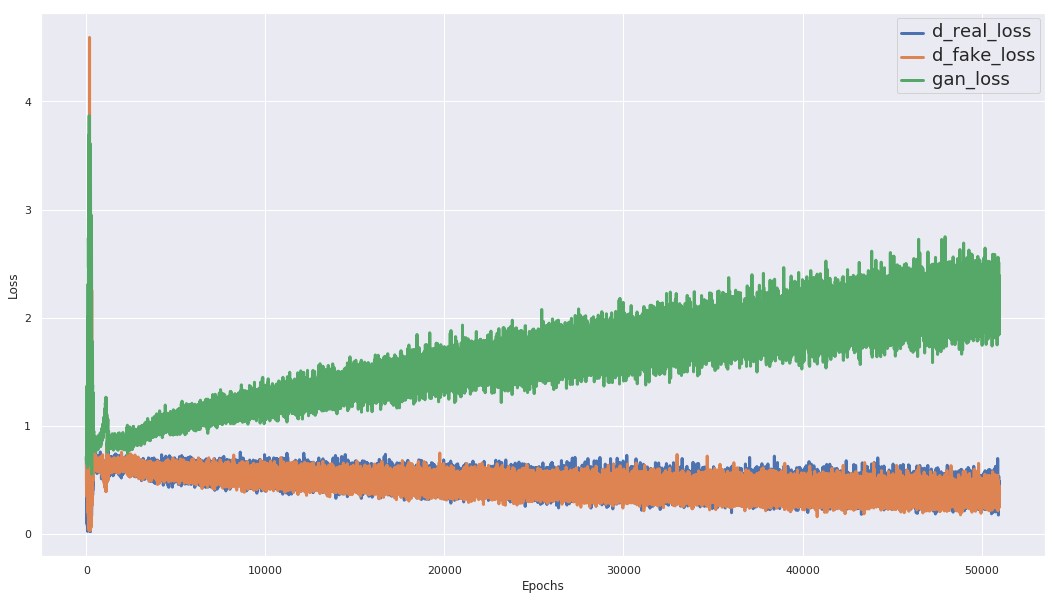

In [171]:
epochs = range(1, len(d_real_losses)+1)
plot_df = pd.DataFrame(data=np.c_[epochs,d_real_losses,d_fake_losses,gan_losses,d_real_accus, d_fake_accus],
                       columns=['epochs','d_real_losses', 'd_fake_losses', 'gan_losses', 'd_real_accus', 'd_fake_accus'])

#%%

sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(18,10))
sns.lineplot(data=plot_df, x='epochs', y='d_real_losses', ax=ax, label='d_real_loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='d_fake_losses', ax=ax, label='d_fake_loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='gan_losses', ax=ax, label='gan_loss', linewidth=3)

ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text


In [179]:
# create and save a plot of generated images 
from tensorflow.keras.models import load_model
def save_plot(examples): 
    # plot images 
    for i in range(examples.shape[0]): 
        # define subplot 
        plt.subplot(10, 5, 1 + i) 
        
        # turn off axis 
        plt.axis('off') 
        
        # plot raw pixel data 
        plt.imshow(examples[i, :, :, 0], cmap='gray_r') 
    plt.show()

    # load model
model = load_model(f"{dbBase}//model_gan_5class_28px1px_threshinv.hdf5")

In [180]:
# generate images
latent_points, labels = generate_latent_points(100, 50) 

# specify labels 
labels = np.asarray([x for _ in range(10) for x in range(5)]) 
print(labels.shape)
print(labels)

(50,)
[0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1 2 3 4 0 1 2 3 4]


In [178]:
X.shape

(50, 28, 28, 1)

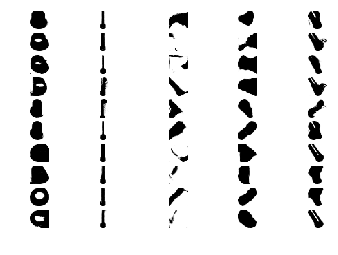

In [181]:
# generate images 
X = model.predict([latent_points, labels]) 

# scale from [-1,1] to [0,1] 
X = (X + 1) / 2.0 

# plot the result
save_plot(X)

In [182]:
classifier_model = load_model(f"{dbBase}//model_10class_28px1px_threshinv.hdf5")

In [186]:
classifier_image = X[5]
classifier_image = np.expand_dims(classifier_image, axis=0)

probs = classifier_model.predict(classifier_image)
label = np.argmax(probs, axis=1)
label[0]

0

In [188]:
part_dict = {
    0: 'Bearings',
    1: 'Bolts',
    2: 'Brackets',
    3: 'Bushing',
    4: 'Collets', 
    5: 'Pipes',
    6: 'PushRings',
    7: 'Springs',
    8: 'Sprockets',
    9: 'Washers'
}
hit_rate_hist = []
runs = 100

for run in range(runs):
    # generate latent points
    latent_points, labels = generate_latent_points(100, 50) 

    # specify conditional labels 
    labels = np.asarray([x for _ in range(10) for x in range(5)]) 
    
    # generate images 
    X = model.predict([latent_points, labels]) 

    # scale from [-1,1] to [0,1] 
    X = (X + 1) / 2.0 

    k = 0
    wrong_items = 0
    for row in range(10):
        for col in range(5):
            classifier_image = X[k]
            classifier_image = np.expand_dims(classifier_image, axis=0)
            probs = classifier_model.predict(classifier_image)
            predicted_label = np.argmax(probs, axis=1)[0]
            predicted_label = part_dict[predicted_label]
            actual_label = part_dict[col]
            print(f"Actual: {actual_label}, Pred: {predicted_label}")
            k+=1

            if actual_label != predicted_label:
                wrong_items += 1
        print("====End of Row====")    
    hit_rate = (k-wrong_items)/k
    hit_rate_hist.append(hit_rate)
    print(f"Wrong Items: {wrong_items}") 
    print(f"Hit Rate: {hit_rate}")

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Sprockets
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Col

Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Sprockets
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pr

Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Wrong Items: 7
Hit Rate: 0.86
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bol

Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Wrong Items: 4
Hit Rate: 0.92
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Sprockets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pre

Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Brackets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: B

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Brackets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Ro

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Wrong Items: 10
Hit Rate: 0.8
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bu

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actu

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actua

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
====End of Row====
Wrong Items: 12
Hit Rate: 0.76
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Sprockets
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Col

Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Bushing
====End of Row====
Wrong Items: 10
Hit Rate: 0.8
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Sprockets
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, 

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
====End of Row====
Wrong Items: 10
Hit Rate: 0.8
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bu

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Washers
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Coll

Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Sprockets
====End of Row====
Wrong Items: 12
Hit Rate: 0.76
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End 

Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
====End of Row====
Wrong Items: 8
Hit Rate: 0.84
Actual: Bearings, Pred: Sprockets
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: B

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Col

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Sprockets
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Wrong Items: 11
Hit Rate: 0.78
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Washers
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Sprockets
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual:

Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: B

Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: PushRings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, 

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Brackets
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Bushing
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Co

In [144]:
part_dict = {
    0: 'Bearings',
    1: 'Bolts',
    2: 'Brackets',
    3: 'Bushing',
    4: 'Collets', 
    5: 'Pipes',
    6: 'PushRings',
    7: 'Springs',
    8: 'Sprockets',
    9: 'Washers'
}
hit_rate_hist = []
runs = 100

for run in range(runs):
    # generate latent points
    latent_points, labels = generate_latent_points(100, 100) 

    # specify conditional labels 
    labels = np.asarray([x for _ in range(10) for x in range(10)]) 
    
    # generate images 
    X = model.predict([latent_points, labels]) 

    # scale from [-1,1] to [0,1] 
    X = (X + 1) / 2.0 

    k = 0
    wrong_items = 0
    for row in range(10):
        for col in range(10):
            classifier_image = X[k]
            classifier_image = np.expand_dims(classifier_image, axis=0)
            probs = classifier_model.predict(classifier_image)
            predicted_label = np.argmax(probs, axis=1)[0]
            predicted_label = part_dict[predicted_label]
            actual_label = part_dict[col]
            print(f"Actual: {actual_label}, Pred: {predicted_label}")
            k+=1

            if actual_label != predicted_label:
                wrong_items += 1
        print("====End of Row====")    
    hit_rate = (k-wrong_items)/k
    hit_rate_hist.append(hit_rate)
    print(f"Wrong Items: {wrong_items}") 
    print(f"Hit Rate: {hit_rate}")

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Washers
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Bearings
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual

Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 19
Hit Rate: 0.81
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts

Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Sprockets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Sprockets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: B

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Pipes
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Sprockets
Ac

Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 29
Hit Rate: 0.71
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Washers
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: Sprockets
Actual: Springs, Pred: Wa

Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 21
Hit Rate: 0.79
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actua

Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bushing
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actu

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Sprockets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Beari

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actu

Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Bolts
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: PushRings


Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bearings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Bearings
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Ac

Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Bolts
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Springs
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets


Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Sprockets
Actual: Springs, Pred: Bearings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bearings
Actual: Bushing, Pred: Springs
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row

Actual: Bushing, Pred: Springs
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bushing
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 31
Hit Rate: 0.69
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: 

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bearings
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bushing
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bolts
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing


Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Sprockets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bo

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Brackets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bushing
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Bushing
Act

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Sprockets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings


Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Springs
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actu

Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 25
Hit Rate: 0.75
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Sprockets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Sprockets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bea

Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual

Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Collets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
A

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Washers
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Ac

Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Brackets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Ac

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Bolts
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Act

Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Pipes
Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Ac

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bearings
Actual: Bushing, Pred: Brackets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actu

Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Bearings
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 27
Hit Rate: 0.73
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bush

Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Colle

Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Bearings
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Washers
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row=

Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 25
Hit Rate: 0.75
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: PushRing

Actual: Brackets, Pred: Bearings
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts


Actual: Pipes, Pred: Bolts
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Pipes
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Bushing
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Wrong Items: 25
Hit Rate: 0.75
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Washers
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Bushing
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Pip

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bushing
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bolts
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bearings
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row===

Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Springs
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Bushing
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 23
Hit Rate: 0.77


In [189]:
np.mean(hit_rate_hist)

0.8244

In [190]:
np.std(hit_rate_hist)

0.05525070135301453